# NLP_State Gov Complaint / Question Classification Project

### Проект группы развития медиааналитики в г. Москва

## Задача

Необходимо обучить модель, которая будет присваивать сообщениям пользователей класс - *жалоба / вопрос.*

## Методология проекта

1. Сделать первичную обработку данных.
2. Обучить модели классификации, начиная с baselines.
3. Оценить качество классификации разных моделей по метрикам качества выбрать лучшую.
4. Сделать выводы.

## Данные

В качестве данных предложен файл, содержащий в себе вопросы в адрес государственных и муниципальных органов, которые пользователи оставили в социальных сетях. Файл с данными находиться [здесь](https://docs.google.com/spreadsheets/d/1VoONQ5Li6hYFv1SGmUKEWdnm7wYDmWYi/edit?usp=sharing&ouid=117398067332429699807&rtpof=true&sd=true).


In [1]:
import nltk
import pandas as pd

from functools import lru_cache

import fasttext.util
import lightgbm as lgb
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from gensim.models import word2vec
from pymorphy2 import MorphAnalyzer

# загрузка модели Word2Vec для английского языка
nltk.download('stopwords')
import warnings

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer # TfidfVectorizer преобразует тексты в числовые векторы, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте
from sklearn.model_selection import GridSearchCV # модуль поиска по сетке параметров

from sklearn.pipeline import Pipeline

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

from tqdm import tqdm
# pipeline позволяет объединить в один блок трансформер и модель, что упрощает написание кода и улучшает его читаемость
# TfidfVectorizer преобразует тексты в числовые вектора, отражающие важность использования каждого слова из некоторого набора слов (количество слов набора определяет размерность вектора) в каждом тексте

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
import warnings

import matplotlib.pyplot as plt
import numpy as np
import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from functools import lru_cache

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs
from pymystem3 import Mystem
from multiprocessing import Pool
from tqdm import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

warnings.simplefilter("ignore", category=RuntimeWarning)
pd.options.mode.chained_assignment = None
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading pa

In [2]:
# в nltk много токенизаторов
from nltk import tokenize
dir(tokenize)[:16]

['BlanklineTokenizer',
 'LegalitySyllableTokenizer',
 'LineTokenizer',
 'MWETokenizer',
 'NLTKWordTokenizer',
 'PunktSentenceTokenizer',
 'RegexpTokenizer',
 'ReppTokenizer',
 'SExprTokenizer',
 'SpaceTokenizer',
 'StanfordSegmenter',
 'SyllableTokenizer',
 'TabTokenizer',
 'TextTilingTokenizer',
 'ToktokTokenizer',
 'TreebankWordDetokenizer']

In [3]:
from nltk.corpus import stopwords

# смотрим, какие языки есть
stopwords.fileids()

['arabic',
 'azerbaijani',
 'basque',
 'bengali',
 'catalan',
 'chinese',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'hebrew',
 'hinglish',
 'hungarian',
 'indonesian',
 'italian',
 'kazakh',
 'nepali',
 'norwegian',
 'portuguese',
 'romanian',
 'russian',
 'slovene',
 'spanish',
 'swedish',
 'tajik',
 'turkish']

In [4]:
# выведем все стоп-слова русского языка
sw = stopwords.words('russian')
print(sw)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

## Загрузка и изучение данных

In [5]:
df = pd.read_excel("C:\\Users\\HOME\\PycharmProjects\\Data_scientist_NLP_данные.xlsx")
df.head(20)

,Дата,Категория,Тема,Муниципалитет,Текст
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года..."
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что..."


In [6]:
df.columns

Index(['Дата', 'Категория', 'Тема', 'Муниципалитет', 'Текст'], dtype='object')

In [7]:
# rename the columns
d = df.rename(columns={'Категория': 'category',
                        'Тема': 'topic',
                        'Муниципалитет': 'municipality',
                        'Текст': 'text',
                       'Дата': 'date'})

# print the DataFrame to verify the column names
print(d.columns)
d

Index(['date', 'category', 'topic', 'municipality', 'text'], dtype='object')


,date,category,topic,municipality,text
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс..."
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ..."
...,...,...,...,...,...
29544,2022-04-11 08:42:35.514,Вопрос,Общественный транспорт,Октябрьский г,'Добрый день.Почему подорожала плата за проезд...
29545,2022-05-04 07:38:28.007,Вопрос,"МФЦ ""Мои документы""",Миасс г,'Миасс. Девочки подскажите номер телефона пф о...
29546,2022-04-15 19:15:52.086,Вопрос,Социальное обслуживание и защита,Уфа г,'Здравствуйте почему пришел отказ?<br>db7ced5b...
29547,2022-07-11 07:51:28.096,Вопрос,Общественный транспорт,Белгород г,'А НАЗАД С КАКИМ ИНТЕРВОЛОМ БУДУТ ЕЗДИТЬ АВТОБ...


### Изучим целевую переменную label на предмет дисбаланса

С дисбалансом таргета можно бороться разными способами:
* провести upsampling, downsampling;
* добавить при обучении модели аргумент ```class_weight = 'balanced'```

В данном проекте мы будем использовать второй способ; в целях тренировки сделаем downsampling.

In [8]:
d['category'].unique()

array(['Вопрос', 'Жалоба'], dtype=object)

In [9]:
# проверка таргета на дисбаланс
d['category'].value_counts()

Вопрос    24549
Жалоба     5000
Name: category, dtype: int64

In [10]:
d['category'].value_counts() / (len(df))

Вопрос    0.83079
Жалоба    0.16921
Name: category, dtype: float64

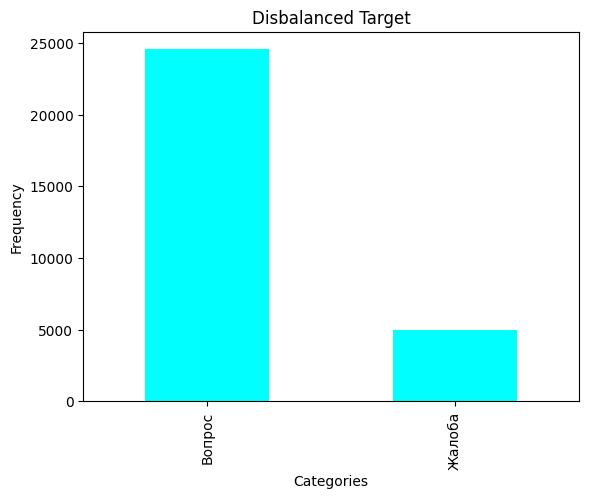

In [37]:
d['category'].value_counts().plot(kind='bar', color=['cyan'])

plt.title('Disbalanced Target')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.show();

In [38]:
# перекодируем таргет цифрами
d['label'] = d['category'].replace({'Вопрос': 'question', 'Жалоба': 'complaint'})
d.head(30)

,date,category,topic,municipality,text,label
0,2022-04-02 15:43:24.726,Вопрос,Благоустройство,Хайбуллинский р-н,'Вид из окна потрясающий (пр. С. Юлаева напрот...,question
1,2022-05-06 14:46:31.109,Вопрос,Социальное обслуживание и защита,Брянск г,"'[id294938415:bp-88767010_4|Αнастасия], Здравс...",question
2,2022-01-14 07:20:51.308,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'[club53367440:bp-53367440_121743|Министерство...,question
3,2022-05-18 03:54:37.952,Вопрос,Социальное обслуживание и защита,Улан-Удэ г,'Здравствуйте когда будет выплата ДВ?,question
4,2022-05-20 07:33:30.558,Вопрос,Социальное обслуживание и защита,Челябинск г,"'Девочки всем привет,у меня такой вопрос получ...",question
5,2022-07-19 05:28:42.565,Жалоба,Экология,Ивнянский р-н,'Когда будет приведён в порядок пруд в центре ...,complaint
6,2022-05-17 06:14:50.682,Жалоба,ЖКХ,Котлас,'Обращаюсь от имени одиноких престарелых людей...,complaint
7,2022-03-09 11:12:59.799,Жалоба,ЖКХ,Красноярский р-н,"'Добрый день,Игорь Юрьевич!С 4 марта 2022 года...",complaint
8,2022-03-06 14:06:36.410,Вопрос,ЖКХ,Камызякский р-н,'А про Камызякский район забыли?,question
9,2022-01-06 20:53:11.803,Вопрос,Здравоохранение/Медицина,Архангельск г,"'Здравствуйте!Скажите пожалуйста,правда ли,что...",question


### Изучим текстовые данные

In [39]:
corpus = list(d['text'])
corpus

["'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)",
 "'[id294938415:bp-88767010_4|Αнастасия], Здравствуйте, подскажите как оспорить результаты по отказу пособия с 8 до 17? Насчитали большую сумму, а по факту меньше. Как быть?спасибо",
 "'[club53367440:bp-53367440_121743|Министерство], здравствуйте. С 3 до 7 уже направили? Сегодня же только 14",
 "'Здравствуйте когда будет выплата ДВ?",
 "'Девочки всем привет,у меня такой вопрос получила пособие вместо 12444,7 с копейками,детские вчера переоформила которые до 1,5,нам вчера исполнился 1 год,когда придет остальная часть?",
 "'Когда будет приведён в порядок пруд в центре Ивни по улице Луговая? Не просто покос рогоза в январе перед журналистами, а качественная чистка водоёма от рогоза, который превращает пруд в центре посёлка в болото и сборник мусора.",
 "'Обращаюсь от имени одиноких престарелых людей жителей микрорайона Лименды города Котласа. по поводу нововведения передачи

In [40]:
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)

    return lemm_text

def clear_text(text):
    clr = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    cleared_text = " ".join(clr.split())
    return cleared_text

In [41]:
# тестируем функции
print("Исходный текст:", corpus[153])
print()
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[153])))

Исходный текст: 'А,он будет ездить по старому маршруту,через ЛИСКИ,не подскажите???

Очищенный и лемматизированный текст: а он быть ездить по старый маршрут через лиски не подсказывать



In [42]:
m = MorphAnalyzer()

# убираем все небуквенные символы
regex = re.compile("[А-Яа-яA-z]+")


def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

In [43]:
print(d.text[0])

'Вид из окна потрясающий (пр. С. Юлаева напротив Юбилейной). Когда наконец уберете эту помойку(сараи, постройки)


In [44]:
# # создаем новый список для хранения очищенных и лемматизированных текстов
# processed_corpus = []
#
# # проходим по каждому тексту в корпусе, применяем функции лемматизации и очистки текста
# for text in corpus:
#     processed_text = lemmatize(clear_text(text))
#     processed_corpus.append(processed_text)

#### Код выше - корректный, но ввиду большого объема данных циклом обходить весь корпус занимает много времени. Сам по себе Mystem() очень долгий. Нужно какое-то более оптимальное решение.

#### Метод ```@lru_cashe``` создает для функции lemmatize кэш указанного размера, что позволяет в целом ускорить лемматизацию текста (что очень полезно, так как лемматизация - ресурсоемкий процесс).

In [45]:
# create a MorphAnalyzer instance
m = MorphAnalyzer()

# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

# set up lemmatization cache
@lru_cache(maxsize=100000)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

# define text preprocessing function
def clean_text(text):
    # extract words from text
    tokens = regex.findall(text.lower())

    # lemmatize the words
    lemmas = [lemmatize_word(token) for token in tokens]

    # remove stopwords and short words
    words = [word for word in lemmas if word not in mystopwords and len(word) > 3]

    return words

In [46]:
print(*clean_text(d.text[3]))

здравствуйте выплата


In [47]:
text = d.text[13]
cleaned_text = clean_text(text)
print(cleaned_text)

['вопрос', 'администрация', 'город', 'деньга', 'почему', 'содержание', 'животное']


#### Нам нужно предобработать большой объем текста, помимо кэширования может помочь распараллеливание, например, методом Pool библиотеки multiprocessing:

In [48]:
# %%time
# # N = 200
# # with Pool(4) as p:
# #     lemmas = list(tqdm(p.imap(clean_text, data['text']), total=N))
#
# with Pool(4) as p:
#     lemmas = list(tqdm(p.imap(clean_text, d['text']), total=len(d)))
#
# d['lemmas'] = lemmas
# d.sample(5)

Код выше - корректный, однако ввиду большого объема данных лемматизатизация проходит очень долго. Попробуем найти другое решение.

## Начинаем с простых baselines

Это всегда хорошая практика - сначала попробовать что-то предельно простое. В нашем случае это будет логистическая регрессия + мешок слов (Bag of Words, BoW).

In [49]:
d.columns

Index(['date', 'category', 'topic', 'municipality', 'text', 'label'], dtype='object')

In [50]:
data = d[['text', 'label']]

In [51]:
train, test = train_test_split(data, test_size=0.2)

In [52]:
X_train = train.drop(columns=['label'])
y_train = train[['label']]

X_test = test.drop(columns=['label'])
y_test = test[['label']]

In [53]:
train.sample()

,text,label
19662,'В с.головино только две улицы почистили остал...,complaint


In [54]:
test.sample()

,text,label
20003,"'На мост с Ленинского района, над железной дор...",question


In [55]:
y_train.sample()

,label
6660,question


In [56]:
y_test.sample()

,label
19526,question


In [57]:
y_test = y_test['label'].values
y_test

array(['complaint', 'question', 'complaint', ..., 'question', 'complaint',
       'complaint'], dtype=object)

In [60]:
# строим BoW для слов
vec = CountVectorizer(ngram_range=(1, 1), token_pattern='\w{3,}')

In [61]:
bow = vec.fit_transform(train['text'])
bow

<23639x360576 sparse matrix of type '<class 'numpy.int64'>'
	with 933822 stored elements in Compressed Sparse Row format>

In [62]:
print(train.text[111])

'Скажите, пожалуйста, родителям сообщается, что препарат экспериментальный до декабря 2023 года согласно официальному реестру клинических исследований?


In [63]:
list(vec.vocabulary_.items())[:10]

[('может', 157733),
 ('наконец', 165308),
 ('проведём', 250748),
 ('воду', 39356),
 ('ижс', 110807),
 ('вишенки', 36760),
 ('2013', 2320),
 ('года', 59005),
 ('требуем', 321669),
 ('может наконец', 157902)]

In [64]:
sorted(list(vec.vocabulary_.items()), key=lambda x: x[0])[:10]

[('000', 0),
 ('000 000', 1),
 ('000 2018', 2),
 ('000 всем', 3),
 ('000 говорили', 4),
 ('000 говорят', 5),
 ('000 депутатские', 6),
 ('000 его', 7),
 ('000 если', 8),
 ('000 ипотека', 9)]

In [65]:
list(vec.vocabulary_.keys())[:10]

['может',
 'наконец',
 'проведём',
 'воду',
 'ижс',
 'вишенки',
 '2013',
 'года',
 'требуем',
 'может наконец']

In [66]:
len(vec.vocabulary_.items())

360576

### Логистическая регрессия

In [67]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(bow, y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500, random_state=42)

In [68]:
# len(clf.coef_[0]) returns the length of the clf.coef_[0] array, which is equal to the number of features used in the model.
len(clf.coef_[0])

360576

In [69]:
bow_test = vec.transform(test['text'])
bow_test

<5910x360576 sparse matrix of type '<class 'numpy.int64'>'
	with 158846 stored elements in Compressed Sparse Row format>

In [70]:
pred = clf.predict(bow_test)
pred[:10]

array(['complaint', 'complaint', 'complaint', 'question', 'question',
       'question', 'question', 'question', 'question', 'question'],
      dtype=object)

In [71]:
accuracy_score(pred, y_test)

0.8661590524534687

In [72]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.41      0.69      0.51       601
    question       0.96      0.89      0.92      5309

    accuracy                           0.87      5910
   macro avg       0.68      0.79      0.72      5910
weighted avg       0.91      0.87      0.88      5910



### *Вывод:*

**В данном случае, безо всякой предобработки текста модель логистической регрессии делает предсказания с правильностью 86.5% (0.865).** Посмотрим повнимательнее на classification report.

* Модель достигает общей точности в 0,86, что означает, что она правильно предсказывает метки классов для 86% экземпляров в тестовом наборе.

* Класс question имеет гораздо большее значение support (количество экземпляров в тестовом наборе), чем класс complaint, что указывает на его более частое появление в тестовом наборе. Модель достигает высокой точности (0,95) и полноты (0,89) для класса question, что означает, что она правильно идентифицирует большинство экземпляров этого класса и не ошибается в классификации многих экземпляров как question.

* Класс complaint имеет более низкую точность (0,45) и полноту (0,65) по сравнению с классом question, что означает, что модель менее точно идентифицирует экземпляры этого класса. Это может быть вызвано несколькими причинами, такими как несбалансированность классов, недостаточное количество тренировочных данных или представление признаков, которое не так хорошо выделяет характеристики класса complaint, как это делает для класса question.

* Макро-усредненная F1-мера (0,73) ниже, чем взвешенная средняя F1-мера (0,88), что указывает на то, что производительность модели более сильно зависит от более крупного класса question. Это также может быть признаком несбалансированности классов или смещения модели в сторону большинства классов.

**В целом, отчет о классификации говорит о том, что модель хорошо справляется с классом ```question```, но могла бы получить дополнительные улучшения в классификации класса ```complaint```.**

#### Попробуем добавить препроцессинг текста и посмотрим, улучшится ли качество модели.

Препроцессинг, как правило, включает удаление небуквенных символов, топ-слов и нормализацию (стемминг - приведение к основе слова - или лемматизацию - приведение слов к начальной форме).

Кроме того, заменим мешок слов на TF-IDF матрицу. В качестве модели оставим логистическую регрессию.

### Напишем необходимые функции для препроцессинга.

1. (f1) Функция для удаления небуквенных символов из текста.
2. (f2) Функция для удаления небуквенных символов
2. (f3) Функция для лемматизации.
3. (f4) Функция для удаления коротких (менее 3 символов) и стоп-слов.

In [73]:
# f1
# Создание регулярного выражения для английского алфавита
m = MorphAnalyzer()
# set up regex to extract words from text
regex = re.compile("[А-Яа-яA-z]+")

# set up stopwords
mystopwords = stopwords.words('russian')

def words_only(text, regex=regex):
    try:
        # Приведение текста к нижнему регистру и поиск всех слов, соответствующих регулярному выражению
        return regex.findall(text.lower())
    except:
        # Если происходит ошибка, возвращаем пустой список
        return []

# f2
@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form


# f3
def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

# f4
def remove_stopwords(lemmas, stopwords=mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]


# applying all
def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [74]:
# тестируем обработку
%time clean_text(data.text[13])

CPU times: total: 0 ns
Wall time: 2.13 ms


'вопрос администрация город деньга почему содержание животное'

##### Функции работают, проводим препроцессинг для train и test выборок.

In [75]:
%%time
lemmas = list(tqdm(map(clean_text, train['text']), total=len(train)))

train['lemmas'] = lemmas
train.sample(5)

100%|██████████| 23639/23639 [00:50<00:00, 471.37it/s]

CPU times: total: 27.6 s
Wall time: 50.2 s


,text,label,lemmas
22589,'Пришла доплата 933р а основную сумму так и не...,question,прийти доплата основный сумма прислать должный...
27525,"'[club49923613|Челябинская область], подскажит...",question,[club челябинский область] подсказать считатьс...
5437,"'Здравствуйте, будет ли в этом 2022 году прово...",question,здравствуйте проводиться октябрьский полумараф...
3414,'Там постоянно такая помойка. Да еще мусорка с...,complaint,постоянно помойка мусорк стоить проезжий часть
17589,'и какой результат обьезда города и смотр доро...,question,результат обьезда город смотр дорожный покрытие


In [76]:
%%time
lemmas_test = list(tqdm(map(clean_text, test['text']), total=len(test)))

test['lemmas'] = lemmas_test
test.sample(5)

100%|██████████| 5910/5910 [00:12<00:00, 484.37it/s]

CPU times: total: 5.89 s
Wall time: 12.2 s


,text,label,lemmas
14592,'А шо делать если нет контейнеров в частном се...,complaint,делать контейнер частный сектор
27113,'Когда уже сделают дорогу от 38 до моста на да...,question,сделать дорога мост дачный
22276,"'Здравствуйте, подскажите пожалуйста как испол...",question,здравствуйте подсказать пожалуйста использоват...
22998,'Здравствуйте прошу убрать пенёк на стоянке у ...,complaint,здравствуйте просить убрать стоянка дорога про...
10057,'Когда трусовская социальная защита населения ...,question,трусовский социальный защита население начать ...


#### Считаем TF-IDF матрицу и обучаем модель:

In [77]:
vec = TfidfVectorizer(ngram_range=(1, 2)) # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8578680203045685

In [78]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.33      0.68      0.44       488
    question       0.97      0.87      0.92      5422

    accuracy                           0.86      5910
   macro avg       0.65      0.78      0.68      5910
weighted avg       0.92      0.86      0.88      5910



In [79]:
vec = TfidfVectorizer(ngram_range=(1, 4))  # строим BoW для слов
tfidf = vec.fit_transform(train['lemmas'])

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(tfidf, y_train)

pred = clf.predict(vec.transform(test['lemmas']))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8558375634517766

In [80]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.36      0.65      0.46       562
    question       0.96      0.88      0.92      5348

    accuracy                           0.86      5910
   macro avg       0.66      0.76      0.69      5910
weighted avg       0.90      0.86      0.87      5910



### *Вывод:* После предобработки accuracy не сильно возросла, однако по матрице несоответствий можно сделать следующие выводы:

* Для категории "complaint" точность (precision) невысока (0.34), что означает, что большинство сообщений, которые модель относит к данной категории, на самом деле не являются жалобами. Однако полнота (recall) высока (0.70), что говорит о том, что модель находит большую часть настоящих жалоб.
* Для категории "question" точность очень высока (0.97), то есть большинство сообщений, которые модель относит к данной категории, на самом деле являются вопросами. Полнота также высока (0.88).
* Средние значения метрик (macro avg) говорят о том, что модель работает достаточно хорошо в целом для обеих категорий.
* Взвешенное среднее (weighted avg) показывает, что общая точность модели достаточно высока (0.92), однако также видно, что модель лучше справляется с классификацией "question", чем с "complaint".

**Можно заметить, что модель справляется неплохо с задачей классификации. Попробуем улучшить преобработку и применить разные модели классификации.**

### Word2Vec

*Попробуем использовать эмбеддинги слов - для этого сперва обучим модель Word2Vec c помощью библиотеки gensim.*

Выполним обучение модели ```Word2Vec``` на токенизированных комментариях, хранящихся в столбце ```'lemmas'``` датафрейма train. Каждый комментарий разбивается на отдельные слова (токены), которые используются для обучения модели.

#### Параметры функции Word2Vec:

* ```workers=4``` - количество потоков, используемых для обучения модели;
* ```vector_size=200``` - размерность векторов слов, которые будут получены в результате обучения;
* ```min_count=10``` - минимальное количество вхождений слова в корпус, которое необходимо для его участия в обучении модели;
* ```window=5``` - размер окна, в котором рассматриваются слова в тексте при обучении модели;
* ```sample=1e-3``` - порог для downsampling'а частых слов, чтобы уменьшить их вес в обучении и повысить значимость менее частых слов.

In [81]:
tokenized_comment = [comment.split() for comment in train['lemmas'].values]

%time
w2v = word2vec.Word2Vec(tokenized_comment, workers=4, vector_size=200, min_count=10, window=5, sample=1e-3)

CPU times: total: 0 ns
Wall time: 0 ns


In [82]:
tokenized_comment

[['мочь', 'проведа', 'вода', 'вишенка', 'требовать'],
 ['улица',
  'нуреева',
  'глумилино',
  'почему',
  'некачественно',
  'производиться',
  'очистка',
  'пешеходный',
  'дорога',
  'проезжий',
  'часть',
  'песок',
  'вообще',
  'помнить',
  'посыпаться',
  'пешеходка'],
 ['больничный', 'лист', 'забирать', 'прикрепить', 'тест', 'прикрепл'],
 ['добрый',
  'день',
  'устроиться',
  'официальный',
  'работа',
  'время',
  'мочь',
  'подать',
  'выплата'],
 ['здравствуйте',
  'сказать',
  'пожалуйста',
  'обратиться',
  'вознесеновский',
  'школа',
  'забор',
  'поставить',
  'круговой'],
 ['вячеслав',
  'владимирович',
  'узнать',
  'повод',
  'зарплата',
  'школа',
  'губкин',
  'обращаться',
  'свой',
  'везде',
  'зарплата',
  'повышать',
  'тишина',
  'знать',
  'везде',
  'цена',
  'пожалуста',
  'помочь',
  'вопрос'],
 ['сегодня',
  'село',
  'автобус',
  'многие',
  'пассажир',
  'спрашивать',
  'водитель',
  'черниковка',
  'комаров',
  'больница',
  'отвечать',
  'местный',


#### Теперь у нас есть эмбеддинги для слов. Но как получить эмбеддинги для целого комментария? Можно усреднить эмбеддинги слов, входящих в комментарий.

In [83]:
def get_comment_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [84]:
get_comment_embedding('text')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Для каждого комментария из обучающей и тестовой выборки вычислим такой эмбеддинг:

In [85]:
train['w2v_embedding'] = train['lemmas'].map(get_comment_embedding)
test['w2v_embedding'] = test['lemmas'].map(get_comment_embedding)

clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['w2v_embedding'].values), y_train)

pred = clf.predict(list(test['w2v_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8331641285956006

In [86]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.14      0.57      0.23       254
    question       0.98      0.85      0.91      5656

    accuracy                           0.83      5910
   macro avg       0.56      0.71      0.57      5910
weighted avg       0.94      0.83      0.88      5910



### *Вывод:* Качество модели упало, значит Word2Vec точно не подходит для обработки текста в данной задаче.

Классификатор показывает высокую точность в определении вопросов, но низкую точность в определении жалоб. Точность определения жалоб составляет всего 13%, что означает, что из всех определенных как жалобы, только 13% действительно являются жалобами. Однако, показатели полноты и точности в определении вопросов составляют 0.98 и 0.85 соответственно, что говорит о высокой точности и полноте в определении вопросов. Метрика F1-score на уровне 0.21 и в целом она является низкой.

## FastText

FastText - это модификация модели word2vec.

FastText использует не только векторы слов, но и векторы n-грам. В корпусе каждое слово автоматически представляется в виде набора символьных n-грамм. Скажем, если мы установим n=3, то вектор для слова "where" будет представлен суммой векторов следующих триграм: "<wh", "whe", "her", "ere", "re>" (где "<" и ">" символы, обозначающие начало и конец слова). Благодаря этому мы можем также получать вектора для слов, отсутствуюших в словаре, а также эффективно работать с текстами, содержащими ошибки и опечатки.

* [Статья](https://aclweb.org/anthology/Q17-1010)
* [Сайт](https://fasttext.cc/)
* [Руководство](https://fasttext.cc/docs/en/support.html)
* [Репозиторий](https://github.com/facebookresearch/fasttext)

Есть библиотека `fasttext` для питона (с готовыми моделями можно работать и через `gensim`).

На сайте проекта можно найти предобученные модели для 157 языков (в том числе русского): https://fasttext.cc/docs/en/crawl-vectors.html

Для начала, попробуем взять предобученную модель fastText с сайта проекта и заменить эмбеддинги в модели выше на эмбеддинги fastText.

Можно попробовать взять модель с сайта проекта Rusvetores: https://rusvectores.org/ru/models/

In [87]:
help(fasttext.util.download_model)

Help on function download_model in module fasttext.util.util:

download_model(lang_id, if_exists='strict', dimension=None)
    Download pre-trained common-crawl vectors from fastText's website
    https://fasttext.cc/docs/en/crawl-vectors.html



In [88]:
%%time
# Загрузка модели, если ее нет на диске ==> ОЧЕНЬ МНОГО ВЕСИТ

# fasttext.util.download_model('ru', if_exists='ignore') # russian ==> ЗАГРУЖЕНА ЛОКАЛЬНО
# fasttext.util.download_model('en', if_exists='ignore') # english

CPU times: total: 0 ns
Wall time: 0 ns


In [89]:
# Загрузка модели в переменную ft
ft = fasttext.load_model("C:\\Users\\HOME\\PycharmProjects\\cc.ru.300.bin") # модель весит 7 Гб, лежит локально

In [90]:
ft['парковый очень красивый неужели пила']

array([-4.35059052e-03, -3.55695793e-03,  1.58397609e-03, -1.31041333e-02,
       -7.87809864e-03,  4.54303576e-03,  1.04006974e-03, -1.80274190e-04,
       -1.24827363e-02,  9.26701073e-03,  7.43316486e-03, -2.52725109e-02,
       -1.15026105e-02,  1.73878949e-03,  7.44686229e-03, -1.22938519e-02,
       -7.29628047e-03,  7.33408472e-03, -1.56296827e-02, -6.07067393e-03,
        1.73137933e-02,  7.57565373e-04, -2.14581814e-04,  9.62902699e-03,
        1.51335122e-02,  3.21272761e-03,  5.74692152e-03,  9.82438400e-03,
        1.36665022e-02, -2.03599669e-02,  9.70651302e-03, -1.39907701e-02,
        1.59544516e-02, -1.40423868e-02,  1.23823062e-02, -8.17978568e-03,
        6.48655090e-03, -3.22098844e-02,  2.48824283e-02, -2.96643865e-03,
        2.81910971e-03, -1.59070343e-02,  1.64397131e-03,  5.22648683e-03,
       -3.38745536e-03,  1.42006660e-02, -2.08896725e-03, -9.78665799e-03,
        6.10517850e-03,  5.20809507e-03,  1.30556151e-02,  2.33448576e-02,
        1.48877222e-02,  

In [91]:
x = 'парковый очень красивый неужели пила'
get_comment_embedding(x, model=ft, embedding_size=300)

array([ 0.01625473,  0.00829152, -0.00126097,  0.02905879,  0.02823407,
       -0.03041483, -0.03086586,  0.02289047, -0.04900266,  0.02815436,
        0.02625005,  0.03469973,  0.00199546,  0.02783065, -0.0363468 ,
       -0.00846948,  0.02456651, -0.00123474, -0.01385996,  0.00020733,
        0.01313574, -0.078882  ,  0.03972147,  0.03464337,  0.03299493,
       -0.00444709,  0.02087226,  0.03203575, -0.01421488,  0.00806902,
        0.02245799, -0.0216795 ,  0.01419253, -0.01919321,  0.03188244,
       -0.01646302,  0.00893144, -0.13303685, -0.02057134, -0.02821044,
       -0.00839118, -0.01133353,  0.01330306,  0.03265403, -0.00125835,
        0.02956294, -0.03214562,  0.00694021,  0.01470614,  0.05039065,
        0.02668291, -0.01293064, -0.03571518,  0.08411254, -0.01901203,
        0.00656017,  0.00691449, -0.01054051,  0.00186629, -0.00523254,
        0.0152056 , -0.01624435,  0.03386005,  0.02345904, -0.00533265,
        0.01555425, -0.04247219,  0.05884881, -0.03249846, -0.00

In [92]:
# немного изменим функцию, что мы писали выше, уберем проверку на входждении, чтобы увеличить скорость
def get_com_embedding(lemmas, model=w2v.wv, embedding_size=200):

    res = np.zeros(embedding_size)
    cnt = 0
    for word in lemmas.split():
        # if word in model:
            res += np.array(model[word])
            cnt += 1
    if cnt:
        res = res / cnt
    return res

In [93]:
%%time
# добавляем колонку с очищенным текстом с помощью Fasttext
train['ft_embedding'] = train['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TRAIN COMPLETED')

test['ft_embedding'] = test['text'].apply(lambda x: get_com_embedding(x, model=ft, embedding_size=300))
print('TEST COMPLETED')

TRAIN COMPLETED
TEST COMPLETED
CPU times: total: 8.84 s
Wall time: 37.8 s


In [94]:
train.head(10)

,text,label,lemmas,w2v_embedding,ft_embedding
6852,'Может наконец-то проведём воду в ИЖС Вишенки?...,question,мочь проведа вода вишенка требовать,"[0.11778203983558341, -0.2334743171930313, -0....","[0.0001656567593189803, 0.02560101641045714, -..."
19777,'Улица Р. Нуреева в мкр. Глумилино-2: почему т...,question,улица нуреева глумилино почему некачественно п...,"[-0.03371383030510818, -0.44727814476937056, -...","[0.005234606617401975, -0.029186316451765986, ..."
24652,'А больничный лист где забирать? Прикреплена к...,question,больничный лист забирать прикрепить тест прикрепл,"[0.0803545854985714, -0.02824169918894768, -0....","[-0.023042103096556205, -0.042681251652538776,..."
23026,"'Добрый день, если муж устроился на официальну...",question,добрый день устроиться официальный работа врем...,"[0.13989924411806795, 0.16404211862633625, -0....","[0.019316440711177333, -0.013622055787386166, ..."
19622,'Здравствуйте.Скажите пожалуйста к кому обрати...,question,здравствуйте сказать пожалуйста обратиться воз...,"[0.07681842919971262, 0.051188028284481595, -0...","[0.0008087583745901401, -0.010651501898582164,..."
17619,"'Вячеслав Владимирович, где-то можно узнать по...",question,вячеслав владимирович узнать повод зарплата шк...,"[-0.010028823719997155, 0.010942897955445867, ...","[0.013767029085245571, -0.012694147421586277, ..."
18327,"'Сегодня села на 258 автобус, многие пассажиры...",question,сегодня село автобус многие пассажир спрашиват...,"[-0.07346492790384218, -0.3369988066454728, 0....","[0.026568511318535975, -0.03180902615453566, -..."
19978,"'28 апреля , в 6 ч. утра ул. Ленина . Кто знае...",question,апрель утро ленин знать клещ обработка почему ...,"[0.11742886449792422, -0.09973946632817388, -0...","[0.02201011366841774, -0.03577165335657135, -0..."
59,'Так сколько стоят то?,question,сколько стоять,"[0.1724984252359718, -0.188913494348526, -0.10...","[-0.0147950928658247, -0.03248090390115976, 0...."
3263,'Какая работа ведется по противодействию мошен...,question,работа вестись противодействие мошенничество сеть,"[-0.11722089846928914, -0.10489033659299214, 0...","[0.012776839139405638, 0.008988908841274679, 0..."


In [95]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

pred = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8514382402707276

In [96]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

   complaint       0.23      0.72      0.35       322
    question       0.98      0.86      0.92      5588

    accuracy                           0.85      5910
   macro avg       0.60      0.79      0.63      5910
weighted avg       0.94      0.85      0.89      5910



print(train.shape)
print(y_train.shape)

### *Вывод:* Данные очищены от странных букв и знаков, знаки пунктуации и стоп-слова удалены, данные разделены на тестовую и обучающую выборки, в каждой из которой выделены признаки и целевое значение. Выборки признаков приведены к векторному виду и готовы к обучению.

## Модели
### 1) Логистическая регрессия

In [97]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(list(train['ft_embedding'].values), y_train)

prediction = clf.predict(list(test['ft_embedding'].values))
accuracy_score(pred, y_test)

print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 85.14%

f1-score: 0.8177516043390917%

 [[ 232  788]
 [  90 4800]]

               precision    recall  f1-score   support

   complaint       0.72      0.23      0.35      1020
    question       0.86      0.98      0.92      4890

    accuracy                           0.85      5910
   macro avg       0.79      0.60      0.63      5910
weighted avg       0.84      0.85      0.82      5910



#### Или с использованием контейнера.

In [98]:
pipe_lr = Pipeline([('model', LogisticRegression())])
pipe_lr.fit(train['ft_embedding'].values.tolist(), y_train)

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('model', LogisticRegression())])

In [99]:
prediction = pipe_lr.predict(test['ft_embedding'].values.tolist())

In [100]:
print("\naccuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print("\nf1-score: {}%".format(f1_score(y_test, prediction, average='weighted')))
print('\n',confusion_matrix(y_test, prediction))
print('\n',classification_report(y_test, prediction))


accuracy: 85.14%

f1-score: 0.8177516043390917%

 [[ 232  788]
 [  90 4800]]

               precision    recall  f1-score   support

   complaint       0.72      0.23      0.35      1020
    question       0.86      0.98      0.92      4890

    accuracy                           0.85      5910
   macro avg       0.79      0.60      0.63      5910
weighted avg       0.84      0.85      0.82      5910



**Для более точного подбора гиперпараметров применим поиск по сетке.**

In [101]:
%%time
# logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

param_grid = [    {'C': [0.01, 0.1, 1, 2, 10, 100],
     'penalty': ['l2']}
]

logreg_grid = GridSearchCV(logreg,
                           param_grid,
                           cv=3,
                           verbose=False,
                           n_jobs=-1,
                           scoring='f1')

logreg_grid.fit(train['ft_embedding'].values.tolist(), y_train)

pred_final = logreg_grid.predict(test['ft_embedding'].values.tolist())

print("\naccuracy: {}%".format(round(accuracy_score(y_test, pred_final)*100,2)))
print("\nf1-score: {}".format(f1_score(y_test, pred_final, average='weighted')))
print('\n',confusion_matrix(y_test, pred_final))
print('\n',classification_report(y_test, pred_final))

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(
C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



accuracy: 70.47%

f1-score: 0.7387772844303905

 [[ 748  272]
 [1473 3417]]

               precision    recall  f1-score   support

   complaint       0.34      0.73      0.46      1020
    question       0.93      0.70      0.80      4890

    accuracy                           0.70      5910
   macro avg       0.63      0.72      0.63      5910
weighted avg       0.82      0.70      0.74      5910

CPU times: total: 10.6 s
Wall time: 48.1 s


#### Логистическая регрессия позволяет получить такие результаты, что:

* accuracy: 70.47%

* f1-score: 0.7403508626986594

Матрица несоответствий указывает, что модель показывает лучшие результаты в определении примеров класса 'question', что отражается в более высоких значениях точности, полноты и f1-меры для этого класса. Однако модель неправильно классифицирует многие примеры класса 'complaint' как примеры класса 'question', что отражается в более низких значениях точности, полноты и f1-меры для класса 'complaint'.

### 2) CatBoost

Гиперпараметры подберем поиском по сетке со встроенной кросс-валидацией:

* **iterations**: Количество итераций бустинга. Этот гиперпараметр контролирует количество деревьев решений в модели.

* **learning_rate**: Скорость обучения для градиентного бустинга. Этот гиперпараметр контролирует размер шага, используемого для обновления весов деревьев решений во время обучения.

* **depth:** Максимальная глубина каждого дерева решений. Этот гиперпараметр контролирует сложность модели и может помочь предотвратить переобучение.

* **l2_leaf_reg**: Коэффициент L2-регуляризации для весов листьев. Этот гиперпараметр помогает предотвратить переобучение путем штрафования больших весов.

* **border_count:** Количество разбиений для числовых признаков. Этот гиперпараметр контролирует гранулярность разбиений признаков и может помочь предотвратить переобучение.

* **bootstrap_type:** Тип бутстрэпа, используемый для выборки наблюдений для каждого дерева. Этот гиперпараметр контролирует случайность обучающих данных и может помочь предотвратить переобучение.

In [102]:
%%time
catboost = CatBoostClassifier(random_seed=42,
                              loss_function='Logloss')

# preparing parameters to ask GridSearch, which contains cross validation
parameters_cat = {'iterations': [50],
                  'learning_rate': np.arange(0.1, 1, 0.2),
                  'depth': [4, 6, 8],
                  'l2_leaf_reg': [0.01, 0.1, 1],
                  # 'bagging_temperature': [0.2, 0.5, 0.8],
                  'border_count': [32, 64, 128],
                  # 'colsample_bylevel': [0.5, 0.8, 1],
                  # 'bootstrap_type': ['Bayesian', 'Poisson', 'MVS']
                  }

gsearch_catboost = GridSearchCV(catboost,
                                param_grid=parameters_cat,
                                cv=3,
                                verbose=0,
                                scoring='f1')

gsearch_catboost.fit(list(train['ft_embedding'].values), y_train)

0:	learn: 0.6269127	total: 149ms	remaining: 7.32s
1:	learn: 0.5717881	total: 157ms	remaining: 3.78s
2:	learn: 0.5374763	total: 165ms	remaining: 2.59s
3:	learn: 0.5067339	total: 173ms	remaining: 1.99s
4:	learn: 0.4821624	total: 182ms	remaining: 1.64s
5:	learn: 0.4614941	total: 190ms	remaining: 1.4s
6:	learn: 0.4434392	total: 199ms	remaining: 1.22s
7:	learn: 0.4288098	total: 209ms	remaining: 1.1s
8:	learn: 0.4163135	total: 219ms	remaining: 997ms
9:	learn: 0.4073135	total: 229ms	remaining: 915ms
10:	learn: 0.3981557	total: 239ms	remaining: 847ms
11:	learn: 0.3916336	total: 249ms	remaining: 789ms
12:	learn: 0.3864395	total: 260ms	remaining: 739ms
13:	learn: 0.3820022	total: 269ms	remaining: 693ms
14:	learn: 0.3775220	total: 279ms	remaining: 652ms
15:	learn: 0.3745332	total: 289ms	remaining: 614ms
16:	learn: 0.3713927	total: 299ms	remaining: 580ms
17:	learn: 0.3684335	total: 308ms	remaining: 548ms
18:	learn: 0.3660856	total: 317ms	remaining: 517ms
19:	learn: 0.3635152	total: 328ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6248757	total: 11.1ms	remaining: 543ms
1:	learn: 0.5697462	total: 20.4ms	remaining: 489ms
2:	learn: 0.5350813	total: 28.8ms	remaining: 452ms
3:	learn: 0.5049184	total: 39ms	remaining: 449ms
4:	learn: 0.4793680	total: 48.3ms	remaining: 435ms
5:	learn: 0.4573753	total: 56.6ms	remaining: 415ms
6:	learn: 0.4403908	total: 64.6ms	remaining: 397ms
7:	learn: 0.4275610	total: 73ms	remaining: 383ms
8:	learn: 0.4150211	total: 83.1ms	remaining: 378ms
9:	learn: 0.4067550	total: 92.5ms	remaining: 370ms
10:	learn: 0.4000627	total: 104ms	remaining: 368ms
11:	learn: 0.3935906	total: 114ms	remaining: 361ms
12:	learn: 0.3884376	total: 125ms	remaining: 355ms
13:	learn: 0.3828846	total: 136ms	remaining: 350ms
14:	learn: 0.3784357	total: 148ms	remaining: 345ms
15:	learn: 0.3754799	total: 158ms	remaining: 336ms
16:	learn: 0.3721708	total: 169ms	remaining: 328ms
17:	learn: 0.3695411	total: 178ms	remaining: 317ms
18:	learn: 0.3665613	total: 187ms	remaining: 305ms
19:	learn: 0.3639369	total: 196ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6280621	total: 12.7ms	remaining: 621ms
1:	learn: 0.5728075	total: 23.5ms	remaining: 564ms
2:	learn: 0.5353722	total: 33.9ms	remaining: 532ms
3:	learn: 0.5068651	total: 44.6ms	remaining: 513ms
4:	learn: 0.4827087	total: 56.9ms	remaining: 512ms
5:	learn: 0.4610294	total: 69.6ms	remaining: 510ms
6:	learn: 0.4466956	total: 79.7ms	remaining: 490ms
7:	learn: 0.4324093	total: 90.3ms	remaining: 474ms
8:	learn: 0.4212209	total: 101ms	remaining: 461ms
9:	learn: 0.4115770	total: 112ms	remaining: 449ms
10:	learn: 0.4040819	total: 123ms	remaining: 434ms
11:	learn: 0.3967708	total: 133ms	remaining: 421ms
12:	learn: 0.3906411	total: 143ms	remaining: 408ms
13:	learn: 0.3861911	total: 154ms	remaining: 396ms
14:	learn: 0.3814487	total: 165ms	remaining: 385ms
15:	learn: 0.3776988	total: 176ms	remaining: 373ms
16:	learn: 0.3745331	total: 187ms	remaining: 363ms
17:	learn: 0.3714043	total: 198ms	remaining: 352ms
18:	learn: 0.3691020	total: 210ms	remaining: 342ms
19:	learn: 0.3665716	total: 223ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5249447	total: 30.9ms	remaining: 1.51s
1:	learn: 0.4425181	total: 59.5ms	remaining: 1.43s
2:	learn: 0.4092293	total: 83.1ms	remaining: 1.3s
3:	learn: 0.3873659	total: 98.6ms	remaining: 1.13s
4:	learn: 0.3750127	total: 114ms	remaining: 1.03s
5:	learn: 0.3661407	total: 138ms	remaining: 1.01s
6:	learn: 0.3599482	total: 161ms	remaining: 992ms
7:	learn: 0.3547153	total: 178ms	remaining: 937ms
8:	learn: 0.3517190	total: 194ms	remaining: 885ms
9:	learn: 0.3491208	total: 214ms	remaining: 855ms
10:	learn: 0.3458516	total: 235ms	remaining: 834ms
11:	learn: 0.3434966	total: 255ms	remaining: 807ms
12:	learn: 0.3413006	total: 272ms	remaining: 775ms
13:	learn: 0.3388448	total: 290ms	remaining: 745ms
14:	learn: 0.3371999	total: 303ms	remaining: 708ms
15:	learn: 0.3347189	total: 319ms	remaining: 678ms
16:	learn: 0.3325595	total: 335ms	remaining: 650ms
17:	learn: 0.3311338	total: 346ms	remaining: 616ms
18:	learn: 0.3293717	total: 361ms	remaining: 590ms
19:	learn: 0.3281590	total: 372ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5197419	total: 14.2ms	remaining: 698ms
1:	learn: 0.4445737	total: 25.5ms	remaining: 612ms
2:	learn: 0.4098071	total: 38.8ms	remaining: 608ms
3:	learn: 0.3875453	total: 51.1ms	remaining: 587ms
4:	learn: 0.3750128	total: 62.8ms	remaining: 565ms
5:	learn: 0.3672715	total: 73.3ms	remaining: 538ms
6:	learn: 0.3620047	total: 84.4ms	remaining: 518ms
7:	learn: 0.3564742	total: 95ms	remaining: 499ms
8:	learn: 0.3518166	total: 106ms	remaining: 481ms
9:	learn: 0.3478478	total: 117ms	remaining: 466ms
10:	learn: 0.3447944	total: 126ms	remaining: 447ms
11:	learn: 0.3418969	total: 135ms	remaining: 429ms
12:	learn: 0.3397030	total: 145ms	remaining: 413ms
13:	learn: 0.3372910	total: 155ms	remaining: 398ms
14:	learn: 0.3350969	total: 164ms	remaining: 382ms
15:	learn: 0.3330242	total: 173ms	remaining: 368ms
16:	learn: 0.3313676	total: 182ms	remaining: 354ms
17:	learn: 0.3298688	total: 190ms	remaining: 338ms
18:	learn: 0.3281234	total: 200ms	remaining: 326ms
19:	learn: 0.3268157	total: 208ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5274756	total: 21.1ms	remaining: 1.03s
1:	learn: 0.4441305	total: 37.1ms	remaining: 890ms
2:	learn: 0.4083685	total: 53.1ms	remaining: 832ms
3:	learn: 0.3903547	total: 69.7ms	remaining: 801ms
4:	learn: 0.3789317	total: 84.1ms	remaining: 757ms
5:	learn: 0.3708223	total: 98.7ms	remaining: 724ms
6:	learn: 0.3648792	total: 114ms	remaining: 701ms
7:	learn: 0.3591552	total: 127ms	remaining: 668ms
8:	learn: 0.3558543	total: 142ms	remaining: 646ms
9:	learn: 0.3520335	total: 155ms	remaining: 622ms
10:	learn: 0.3482444	total: 168ms	remaining: 596ms
11:	learn: 0.3457030	total: 181ms	remaining: 574ms
12:	learn: 0.3433377	total: 193ms	remaining: 550ms
13:	learn: 0.3408853	total: 208ms	remaining: 535ms
14:	learn: 0.3390179	total: 224ms	remaining: 522ms
15:	learn: 0.3371693	total: 234ms	remaining: 497ms
16:	learn: 0.3357395	total: 244ms	remaining: 474ms
17:	learn: 0.3340243	total: 255ms	remaining: 454ms
18:	learn: 0.3326225	total: 266ms	remaining: 434ms
19:	learn: 0.3312881	total: 276ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4589735	total: 11.8ms	remaining: 576ms
1:	learn: 0.3950524	total: 22.1ms	remaining: 532ms
2:	learn: 0.3771699	total: 32.9ms	remaining: 515ms
3:	learn: 0.3679462	total: 43.3ms	remaining: 498ms
4:	learn: 0.3603850	total: 54.3ms	remaining: 489ms
5:	learn: 0.3523443	total: 64.9ms	remaining: 476ms
6:	learn: 0.3483928	total: 74.5ms	remaining: 457ms
7:	learn: 0.3455056	total: 83.6ms	remaining: 439ms
8:	learn: 0.3422757	total: 112ms	remaining: 509ms
9:	learn: 0.3393490	total: 144ms	remaining: 577ms
10:	learn: 0.3362557	total: 168ms	remaining: 595ms
11:	learn: 0.3337098	total: 179ms	remaining: 565ms
12:	learn: 0.3318772	total: 188ms	remaining: 536ms
13:	learn: 0.3296946	total: 209ms	remaining: 538ms
14:	learn: 0.3274018	total: 220ms	remaining: 514ms
15:	learn: 0.3255769	total: 232ms	remaining: 492ms
16:	learn: 0.3238635	total: 243ms	remaining: 471ms
17:	learn: 0.3221695	total: 254ms	remaining: 452ms
18:	learn: 0.3205764	total: 264ms	remaining: 430ms
19:	learn: 0.3181804	total: 274ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4517681	total: 10.3ms	remaining: 505ms
1:	learn: 0.3944989	total: 21.6ms	remaining: 518ms
2:	learn: 0.3755201	total: 32.3ms	remaining: 506ms
3:	learn: 0.3651468	total: 42.4ms	remaining: 487ms
4:	learn: 0.3559391	total: 53ms	remaining: 477ms
5:	learn: 0.3499554	total: 63.7ms	remaining: 467ms
6:	learn: 0.3465624	total: 74.1ms	remaining: 455ms
7:	learn: 0.3426173	total: 85.9ms	remaining: 451ms
8:	learn: 0.3386893	total: 98.3ms	remaining: 448ms
9:	learn: 0.3366584	total: 109ms	remaining: 437ms
10:	learn: 0.3340651	total: 122ms	remaining: 431ms
11:	learn: 0.3321542	total: 133ms	remaining: 421ms
12:	learn: 0.3305894	total: 143ms	remaining: 408ms
13:	learn: 0.3288903	total: 153ms	remaining: 394ms
14:	learn: 0.3274415	total: 163ms	remaining: 380ms
15:	learn: 0.3256120	total: 172ms	remaining: 365ms
16:	learn: 0.3240501	total: 181ms	remaining: 352ms
17:	learn: 0.3218529	total: 188ms	remaining: 335ms
18:	learn: 0.3198418	total: 197ms	remaining: 321ms
19:	learn: 0.3183835	total: 206ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4620034	total: 10.4ms	remaining: 512ms
1:	learn: 0.3967123	total: 19.1ms	remaining: 458ms
2:	learn: 0.3752180	total: 30.1ms	remaining: 472ms
3:	learn: 0.3641190	total: 40.6ms	remaining: 467ms
4:	learn: 0.3574269	total: 50.3ms	remaining: 453ms
5:	learn: 0.3520958	total: 60.2ms	remaining: 442ms
6:	learn: 0.3490199	total: 70.9ms	remaining: 436ms
7:	learn: 0.3452389	total: 81ms	remaining: 425ms
8:	learn: 0.3418896	total: 91.1ms	remaining: 415ms
9:	learn: 0.3397136	total: 100ms	remaining: 401ms
10:	learn: 0.3374195	total: 110ms	remaining: 389ms
11:	learn: 0.3353759	total: 120ms	remaining: 380ms
12:	learn: 0.3338363	total: 129ms	remaining: 367ms
13:	learn: 0.3318876	total: 140ms	remaining: 361ms
14:	learn: 0.3305026	total: 150ms	remaining: 351ms
15:	learn: 0.3291659	total: 160ms	remaining: 339ms
16:	learn: 0.3275392	total: 170ms	remaining: 331ms
17:	learn: 0.3259834	total: 181ms	remaining: 322ms
18:	learn: 0.3244752	total: 191ms	remaining: 311ms
19:	learn: 0.3225568	total: 201ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4218819	total: 10.3ms	remaining: 503ms
1:	learn: 0.3796704	total: 19.5ms	remaining: 467ms
2:	learn: 0.3679669	total: 28.1ms	remaining: 441ms
3:	learn: 0.3584980	total: 36.5ms	remaining: 420ms
4:	learn: 0.3543893	total: 43.8ms	remaining: 394ms
5:	learn: 0.3486892	total: 52.3ms	remaining: 384ms
6:	learn: 0.3451631	total: 60.4ms	remaining: 371ms
7:	learn: 0.3420821	total: 67.9ms	remaining: 356ms
8:	learn: 0.3383767	total: 75.7ms	remaining: 345ms
9:	learn: 0.3361170	total: 84.3ms	remaining: 337ms
10:	learn: 0.3338885	total: 91.4ms	remaining: 324ms
11:	learn: 0.3319390	total: 99.9ms	remaining: 316ms
12:	learn: 0.3291056	total: 110ms	remaining: 312ms
13:	learn: 0.3257777	total: 118ms	remaining: 304ms
14:	learn: 0.3228962	total: 127ms	remaining: 296ms
15:	learn: 0.3205221	total: 135ms	remaining: 286ms
16:	learn: 0.3178477	total: 142ms	remaining: 277ms
17:	learn: 0.3149141	total: 151ms	remaining: 269ms
18:	learn: 0.3121912	total: 160ms	remaining: 261ms
19:	learn: 0.3099457	total: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4135601	total: 11ms	remaining: 540ms
1:	learn: 0.3772069	total: 21.1ms	remaining: 507ms
2:	learn: 0.3641477	total: 31.4ms	remaining: 492ms
3:	learn: 0.3563951	total: 41.4ms	remaining: 477ms
4:	learn: 0.3504661	total: 50.4ms	remaining: 454ms
5:	learn: 0.3458282	total: 58.8ms	remaining: 431ms
6:	learn: 0.3421412	total: 67.5ms	remaining: 414ms
7:	learn: 0.3384608	total: 75.8ms	remaining: 398ms
8:	learn: 0.3359206	total: 84.4ms	remaining: 384ms
9:	learn: 0.3336261	total: 92.9ms	remaining: 372ms
10:	learn: 0.3314030	total: 100ms	remaining: 355ms
11:	learn: 0.3291973	total: 108ms	remaining: 340ms
12:	learn: 0.3271270	total: 116ms	remaining: 330ms
13:	learn: 0.3254530	total: 124ms	remaining: 320ms
14:	learn: 0.3233453	total: 133ms	remaining: 309ms
15:	learn: 0.3204495	total: 140ms	remaining: 297ms
16:	learn: 0.3183507	total: 148ms	remaining: 287ms
17:	learn: 0.3154996	total: 155ms	remaining: 276ms
18:	learn: 0.3129029	total: 162ms	remaining: 265ms
19:	learn: 0.3105177	total: 171ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4249419	total: 9.91ms	remaining: 485ms
1:	learn: 0.3834735	total: 19.2ms	remaining: 460ms
2:	learn: 0.3675906	total: 29.3ms	remaining: 458ms
3:	learn: 0.3600964	total: 37.8ms	remaining: 434ms
4:	learn: 0.3541196	total: 45.4ms	remaining: 408ms
5:	learn: 0.3506247	total: 52.9ms	remaining: 388ms
6:	learn: 0.3479908	total: 60.5ms	remaining: 371ms
7:	learn: 0.3447868	total: 68ms	remaining: 357ms
8:	learn: 0.3410431	total: 75.5ms	remaining: 344ms
9:	learn: 0.3387059	total: 82.9ms	remaining: 331ms
10:	learn: 0.3360942	total: 90.7ms	remaining: 321ms
11:	learn: 0.3338570	total: 98.6ms	remaining: 312ms
12:	learn: 0.3320658	total: 108ms	remaining: 306ms
13:	learn: 0.3297682	total: 115ms	remaining: 295ms
14:	learn: 0.3263641	total: 123ms	remaining: 287ms
15:	learn: 0.3236629	total: 131ms	remaining: 278ms
16:	learn: 0.3208129	total: 139ms	remaining: 270ms
17:	learn: 0.3181929	total: 147ms	remaining: 261ms
18:	learn: 0.3159826	total: 154ms	remaining: 251ms
19:	learn: 0.3135471	total: 161

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4062731	total: 10.2ms	remaining: 501ms
1:	learn: 0.3781769	total: 19ms	remaining: 456ms
2:	learn: 0.3666949	total: 28.5ms	remaining: 446ms
3:	learn: 0.3616979	total: 37.5ms	remaining: 432ms
4:	learn: 0.3558007	total: 47.2ms	remaining: 425ms
5:	learn: 0.3497306	total: 55.6ms	remaining: 408ms
6:	learn: 0.3463370	total: 64.4ms	remaining: 396ms
7:	learn: 0.3429900	total: 73.9ms	remaining: 388ms
8:	learn: 0.3404790	total: 84.1ms	remaining: 383ms
9:	learn: 0.3363362	total: 92.7ms	remaining: 371ms
10:	learn: 0.3336756	total: 101ms	remaining: 359ms
11:	learn: 0.3304723	total: 108ms	remaining: 342ms
12:	learn: 0.3265487	total: 117ms	remaining: 332ms
13:	learn: 0.3235794	total: 124ms	remaining: 320ms
14:	learn: 0.3201755	total: 132ms	remaining: 309ms
15:	learn: 0.3171394	total: 141ms	remaining: 299ms
16:	learn: 0.3141104	total: 148ms	remaining: 288ms
17:	learn: 0.3112580	total: 155ms	remaining: 276ms
18:	learn: 0.3080704	total: 163ms	remaining: 267ms
19:	learn: 0.3051561	total: 171ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3975148	total: 9.91ms	remaining: 486ms
1:	learn: 0.3734543	total: 19.6ms	remaining: 470ms
2:	learn: 0.3617795	total: 28.8ms	remaining: 452ms
3:	learn: 0.3552076	total: 37.5ms	remaining: 431ms
4:	learn: 0.3514665	total: 45.8ms	remaining: 412ms
5:	learn: 0.3475223	total: 53.3ms	remaining: 391ms
6:	learn: 0.3434213	total: 61.2ms	remaining: 376ms
7:	learn: 0.3396488	total: 69.4ms	remaining: 364ms
8:	learn: 0.3353954	total: 77.3ms	remaining: 352ms
9:	learn: 0.3323151	total: 84.5ms	remaining: 338ms
10:	learn: 0.3287150	total: 92.2ms	remaining: 327ms
11:	learn: 0.3253079	total: 99.8ms	remaining: 316ms
12:	learn: 0.3221418	total: 108ms	remaining: 308ms
13:	learn: 0.3192699	total: 118ms	remaining: 303ms
14:	learn: 0.3165375	total: 127ms	remaining: 296ms
15:	learn: 0.3130157	total: 135ms	remaining: 287ms
16:	learn: 0.3100810	total: 144ms	remaining: 280ms
17:	learn: 0.3079612	total: 153ms	remaining: 271ms
18:	learn: 0.3050886	total: 163ms	remaining: 266ms
19:	learn: 0.3026403	total: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4092808	total: 10.5ms	remaining: 514ms
1:	learn: 0.3819858	total: 19.2ms	remaining: 461ms
2:	learn: 0.3694920	total: 27.8ms	remaining: 435ms
3:	learn: 0.3620283	total: 35.6ms	remaining: 410ms
4:	learn: 0.3548564	total: 43.6ms	remaining: 392ms
5:	learn: 0.3509784	total: 50.4ms	remaining: 370ms
6:	learn: 0.3484590	total: 57.1ms	remaining: 351ms
7:	learn: 0.3461309	total: 64.2ms	remaining: 337ms
8:	learn: 0.3432709	total: 72.2ms	remaining: 329ms
9:	learn: 0.3407010	total: 79.4ms	remaining: 317ms
10:	learn: 0.3367654	total: 87.5ms	remaining: 310ms
11:	learn: 0.3337551	total: 96.6ms	remaining: 306ms
12:	learn: 0.3302239	total: 105ms	remaining: 299ms
13:	learn: 0.3271433	total: 112ms	remaining: 288ms
14:	learn: 0.3241307	total: 120ms	remaining: 280ms
15:	learn: 0.3209350	total: 128ms	remaining: 272ms
16:	learn: 0.3186360	total: 135ms	remaining: 262ms
17:	learn: 0.3163040	total: 141ms	remaining: 251ms
18:	learn: 0.3134633	total: 148ms	remaining: 242ms
19:	learn: 0.3103933	total: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6269127	total: 10.7ms	remaining: 525ms
1:	learn: 0.5717881	total: 20.3ms	remaining: 488ms
2:	learn: 0.5325824	total: 30ms	remaining: 469ms
3:	learn: 0.5014534	total: 39.4ms	remaining: 453ms
4:	learn: 0.4758039	total: 48ms	remaining: 432ms
5:	learn: 0.4583851	total: 56.1ms	remaining: 411ms
6:	learn: 0.4433389	total: 63.9ms	remaining: 393ms
7:	learn: 0.4280578	total: 72.3ms	remaining: 380ms
8:	learn: 0.4181746	total: 80.5ms	remaining: 367ms
9:	learn: 0.4077808	total: 89.1ms	remaining: 357ms
10:	learn: 0.4004488	total: 98.3ms	remaining: 348ms
11:	learn: 0.3944176	total: 107ms	remaining: 339ms
12:	learn: 0.3900779	total: 114ms	remaining: 325ms
13:	learn: 0.3847921	total: 123ms	remaining: 317ms
14:	learn: 0.3796257	total: 131ms	remaining: 307ms
15:	learn: 0.3755397	total: 140ms	remaining: 297ms
16:	learn: 0.3711270	total: 148ms	remaining: 288ms
17:	learn: 0.3679208	total: 156ms	remaining: 277ms
18:	learn: 0.3653401	total: 164ms	remaining: 267ms
19:	learn: 0.3631983	total: 172ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6248757	total: 9.87ms	remaining: 484ms
1:	learn: 0.5697461	total: 19.3ms	remaining: 462ms
2:	learn: 0.5357201	total: 28.8ms	remaining: 450ms
3:	learn: 0.5064553	total: 37.9ms	remaining: 436ms
4:	learn: 0.4786286	total: 48.6ms	remaining: 437ms
5:	learn: 0.4558954	total: 58.3ms	remaining: 427ms
6:	learn: 0.4396537	total: 68.1ms	remaining: 418ms
7:	learn: 0.4254765	total: 76.7ms	remaining: 402ms
8:	learn: 0.4145960	total: 86.2ms	remaining: 393ms
9:	learn: 0.4046065	total: 94.9ms	remaining: 380ms
10:	learn: 0.3984476	total: 109ms	remaining: 386ms
11:	learn: 0.3926651	total: 119ms	remaining: 376ms
12:	learn: 0.3867016	total: 127ms	remaining: 362ms
13:	learn: 0.3822065	total: 135ms	remaining: 346ms
14:	learn: 0.3778624	total: 144ms	remaining: 335ms
15:	learn: 0.3738933	total: 152ms	remaining: 323ms
16:	learn: 0.3706608	total: 160ms	remaining: 311ms
17:	learn: 0.3673109	total: 168ms	remaining: 299ms
18:	learn: 0.3647001	total: 177ms	remaining: 289ms
19:	learn: 0.3624812	total: 185

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6280621	total: 10.2ms	remaining: 498ms
1:	learn: 0.5728075	total: 19.2ms	remaining: 460ms
2:	learn: 0.5353722	total: 28.5ms	remaining: 447ms
3:	learn: 0.5038844	total: 37.9ms	remaining: 436ms
4:	learn: 0.4774565	total: 59.6ms	remaining: 537ms
5:	learn: 0.4569183	total: 69.5ms	remaining: 510ms
6:	learn: 0.4423171	total: 79.4ms	remaining: 488ms
7:	learn: 0.4274417	total: 88.2ms	remaining: 463ms
8:	learn: 0.4164650	total: 97.3ms	remaining: 443ms
9:	learn: 0.4062832	total: 108ms	remaining: 431ms
10:	learn: 0.3983400	total: 118ms	remaining: 417ms
11:	learn: 0.3920825	total: 127ms	remaining: 403ms
12:	learn: 0.3865747	total: 137ms	remaining: 389ms
13:	learn: 0.3819764	total: 146ms	remaining: 374ms
14:	learn: 0.3782436	total: 155ms	remaining: 361ms
15:	learn: 0.3750773	total: 164ms	remaining: 349ms
16:	learn: 0.3719967	total: 173ms	remaining: 335ms
17:	learn: 0.3692976	total: 181ms	remaining: 321ms
18:	learn: 0.3669821	total: 188ms	remaining: 307ms
19:	learn: 0.3649271	total: 198m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5249447	total: 9.75ms	remaining: 478ms
1:	learn: 0.4425181	total: 18.9ms	remaining: 454ms
2:	learn: 0.4083590	total: 27.8ms	remaining: 436ms
3:	learn: 0.3877399	total: 35.6ms	remaining: 410ms
4:	learn: 0.3747695	total: 44ms	remaining: 396ms
5:	learn: 0.3668197	total: 52.2ms	remaining: 383ms
6:	learn: 0.3609313	total: 61ms	remaining: 374ms
7:	learn: 0.3555375	total: 70ms	remaining: 368ms
8:	learn: 0.3513265	total: 79ms	remaining: 360ms
9:	learn: 0.3472305	total: 88.6ms	remaining: 354ms
10:	learn: 0.3444588	total: 99ms	remaining: 351ms
11:	learn: 0.3425212	total: 109ms	remaining: 344ms
12:	learn: 0.3405525	total: 119ms	remaining: 340ms
13:	learn: 0.3390505	total: 130ms	remaining: 335ms
14:	learn: 0.3375483	total: 141ms	remaining: 329ms
15:	learn: 0.3356655	total: 149ms	remaining: 317ms
16:	learn: 0.3339663	total: 156ms	remaining: 304ms
17:	learn: 0.3321355	total: 164ms	remaining: 292ms
18:	learn: 0.3309752	total: 172ms	remaining: 280ms
19:	learn: 0.3296011	total: 179ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5197419	total: 9.83ms	remaining: 482ms
1:	learn: 0.4445738	total: 18.5ms	remaining: 443ms
2:	learn: 0.4099952	total: 27.4ms	remaining: 429ms
3:	learn: 0.3885485	total: 35.1ms	remaining: 404ms
4:	learn: 0.3759514	total: 42.8ms	remaining: 385ms
5:	learn: 0.3676721	total: 50.6ms	remaining: 371ms
6:	learn: 0.3592196	total: 58.1ms	remaining: 357ms
7:	learn: 0.3546262	total: 65.5ms	remaining: 344ms
8:	learn: 0.3515137	total: 73ms	remaining: 333ms
9:	learn: 0.3487148	total: 80.5ms	remaining: 322ms
10:	learn: 0.3457250	total: 88ms	remaining: 312ms
11:	learn: 0.3430062	total: 96.7ms	remaining: 306ms
12:	learn: 0.3405502	total: 105ms	remaining: 300ms
13:	learn: 0.3383220	total: 113ms	remaining: 291ms
14:	learn: 0.3366652	total: 121ms	remaining: 283ms
15:	learn: 0.3349740	total: 129ms	remaining: 273ms
16:	learn: 0.3334667	total: 136ms	remaining: 264ms
17:	learn: 0.3320651	total: 143ms	remaining: 255ms
18:	learn: 0.3303233	total: 150ms	remaining: 245ms
19:	learn: 0.3288711	total: 158ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5274756	total: 10.4ms	remaining: 510ms
1:	learn: 0.4441305	total: 20ms	remaining: 480ms
2:	learn: 0.4120600	total: 29.7ms	remaining: 465ms
3:	learn: 0.3913563	total: 38.9ms	remaining: 448ms
4:	learn: 0.3789627	total: 46.9ms	remaining: 422ms
5:	learn: 0.3695192	total: 54.5ms	remaining: 400ms
6:	learn: 0.3622580	total: 62.6ms	remaining: 385ms
7:	learn: 0.3565926	total: 70.2ms	remaining: 368ms
8:	learn: 0.3524458	total: 77.7ms	remaining: 354ms
9:	learn: 0.3493714	total: 84.8ms	remaining: 339ms
10:	learn: 0.3468399	total: 92.3ms	remaining: 327ms
11:	learn: 0.3443535	total: 101ms	remaining: 321ms
12:	learn: 0.3418503	total: 110ms	remaining: 314ms
13:	learn: 0.3400035	total: 118ms	remaining: 304ms
14:	learn: 0.3383188	total: 126ms	remaining: 294ms
15:	learn: 0.3365071	total: 133ms	remaining: 283ms
16:	learn: 0.3352006	total: 141ms	remaining: 274ms
17:	learn: 0.3341194	total: 148ms	remaining: 263ms
18:	learn: 0.3330675	total: 155ms	remaining: 253ms
19:	learn: 0.3314989	total: 163m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4589735	total: 9.97ms	remaining: 488ms
1:	learn: 0.3950524	total: 19ms	remaining: 455ms
2:	learn: 0.3771699	total: 27.2ms	remaining: 425ms
3:	learn: 0.3633843	total: 36.2ms	remaining: 416ms
4:	learn: 0.3547412	total: 45.3ms	remaining: 407ms
5:	learn: 0.3497518	total: 53.6ms	remaining: 393ms
6:	learn: 0.3457029	total: 61.4ms	remaining: 377ms
7:	learn: 0.3421333	total: 69.2ms	remaining: 363ms
8:	learn: 0.3389660	total: 76ms	remaining: 346ms
9:	learn: 0.3367112	total: 84ms	remaining: 336ms
10:	learn: 0.3339382	total: 91.4ms	remaining: 324ms
11:	learn: 0.3319560	total: 98.3ms	remaining: 311ms
12:	learn: 0.3300549	total: 106ms	remaining: 303ms
13:	learn: 0.3286168	total: 114ms	remaining: 294ms
14:	learn: 0.3269653	total: 123ms	remaining: 287ms
15:	learn: 0.3249114	total: 131ms	remaining: 279ms
16:	learn: 0.3236260	total: 138ms	remaining: 268ms
17:	learn: 0.3216337	total: 146ms	remaining: 260ms
18:	learn: 0.3198051	total: 154ms	remaining: 251ms
19:	learn: 0.3182178	total: 161ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4517681	total: 9.37ms	remaining: 459ms
1:	learn: 0.3944988	total: 18.8ms	remaining: 451ms
2:	learn: 0.3732445	total: 27.7ms	remaining: 434ms
3:	learn: 0.3634439	total: 36.6ms	remaining: 421ms
4:	learn: 0.3533282	total: 45ms	remaining: 405ms
5:	learn: 0.3468439	total: 53.3ms	remaining: 391ms
6:	learn: 0.3433565	total: 61.5ms	remaining: 378ms
7:	learn: 0.3393612	total: 71.9ms	remaining: 377ms
8:	learn: 0.3356595	total: 81.5ms	remaining: 371ms
9:	learn: 0.3328213	total: 91ms	remaining: 364ms
10:	learn: 0.3305530	total: 98.8ms	remaining: 350ms
11:	learn: 0.3278707	total: 107ms	remaining: 339ms
12:	learn: 0.3261270	total: 114ms	remaining: 325ms
13:	learn: 0.3238494	total: 122ms	remaining: 314ms
14:	learn: 0.3222515	total: 130ms	remaining: 303ms
15:	learn: 0.3204361	total: 137ms	remaining: 292ms
16:	learn: 0.3185538	total: 146ms	remaining: 283ms
17:	learn: 0.3170838	total: 153ms	remaining: 272ms
18:	learn: 0.3157266	total: 160ms	remaining: 260ms
19:	learn: 0.3137773	total: 167ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4620034	total: 9.93ms	remaining: 486ms
1:	learn: 0.3967123	total: 18.8ms	remaining: 452ms
2:	learn: 0.3747209	total: 28.2ms	remaining: 443ms
3:	learn: 0.3646680	total: 36ms	remaining: 414ms
4:	learn: 0.3579477	total: 44ms	remaining: 396ms
5:	learn: 0.3531072	total: 50.8ms	remaining: 373ms
6:	learn: 0.3493331	total: 58.7ms	remaining: 361ms
7:	learn: 0.3448777	total: 66.8ms	remaining: 351ms
8:	learn: 0.3417169	total: 75ms	remaining: 342ms
9:	learn: 0.3385052	total: 81.8ms	remaining: 327ms
10:	learn: 0.3365059	total: 88.9ms	remaining: 315ms
11:	learn: 0.3344850	total: 97ms	remaining: 307ms
12:	learn: 0.3330461	total: 106ms	remaining: 301ms
13:	learn: 0.3311179	total: 113ms	remaining: 291ms
14:	learn: 0.3287728	total: 122ms	remaining: 284ms
15:	learn: 0.3266462	total: 130ms	remaining: 277ms
16:	learn: 0.3251473	total: 139ms	remaining: 270ms
17:	learn: 0.3234901	total: 147ms	remaining: 262ms
18:	learn: 0.3211275	total: 158ms	remaining: 258ms
19:	learn: 0.3191045	total: 168ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4218819	total: 9.15ms	remaining: 448ms
1:	learn: 0.3796704	total: 18.3ms	remaining: 439ms
2:	learn: 0.3671452	total: 28ms	remaining: 438ms
3:	learn: 0.3587154	total: 36.3ms	remaining: 418ms
4:	learn: 0.3529815	total: 44ms	remaining: 396ms
5:	learn: 0.3487602	total: 51.9ms	remaining: 381ms
6:	learn: 0.3451946	total: 59.8ms	remaining: 367ms
7:	learn: 0.3418542	total: 67.8ms	remaining: 356ms
8:	learn: 0.3390527	total: 74.8ms	remaining: 341ms
9:	learn: 0.3373178	total: 82ms	remaining: 328ms
10:	learn: 0.3351416	total: 88.8ms	remaining: 315ms
11:	learn: 0.3329397	total: 95.5ms	remaining: 302ms
12:	learn: 0.3308360	total: 104ms	remaining: 297ms
13:	learn: 0.3274346	total: 112ms	remaining: 289ms
14:	learn: 0.3238924	total: 120ms	remaining: 281ms
15:	learn: 0.3211149	total: 128ms	remaining: 273ms
16:	learn: 0.3181242	total: 136ms	remaining: 264ms
17:	learn: 0.3151484	total: 143ms	remaining: 255ms
18:	learn: 0.3125528	total: 150ms	remaining: 244ms
19:	learn: 0.3097198	total: 157ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4135601	total: 9.83ms	remaining: 482ms
1:	learn: 0.3772069	total: 19.3ms	remaining: 463ms
2:	learn: 0.3641477	total: 28ms	remaining: 438ms
3:	learn: 0.3564578	total: 35.3ms	remaining: 405ms
4:	learn: 0.3509372	total: 42.5ms	remaining: 383ms
5:	learn: 0.3455501	total: 50.3ms	remaining: 369ms
6:	learn: 0.3421787	total: 57.7ms	remaining: 354ms
7:	learn: 0.3387411	total: 64.6ms	remaining: 339ms
8:	learn: 0.3351686	total: 72.5ms	remaining: 330ms
9:	learn: 0.3323837	total: 80.1ms	remaining: 320ms
10:	learn: 0.3305917	total: 87.6ms	remaining: 310ms
11:	learn: 0.3283682	total: 95.9ms	remaining: 304ms
12:	learn: 0.3265629	total: 104ms	remaining: 295ms
13:	learn: 0.3244468	total: 111ms	remaining: 286ms
14:	learn: 0.3223690	total: 119ms	remaining: 277ms
15:	learn: 0.3194315	total: 125ms	remaining: 265ms
16:	learn: 0.3172258	total: 132ms	remaining: 257ms
17:	learn: 0.3147943	total: 140ms	remaining: 249ms
18:	learn: 0.3124211	total: 147ms	remaining: 239ms
19:	learn: 0.3101538	total: 155

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4249419	total: 9.85ms	remaining: 483ms
1:	learn: 0.3834735	total: 18.6ms	remaining: 447ms
2:	learn: 0.3685610	total: 27.3ms	remaining: 428ms
3:	learn: 0.3620384	total: 36.5ms	remaining: 420ms
4:	learn: 0.3555860	total: 44.4ms	remaining: 399ms
5:	learn: 0.3515009	total: 51.8ms	remaining: 380ms
6:	learn: 0.3477424	total: 59.6ms	remaining: 366ms
7:	learn: 0.3448137	total: 67.2ms	remaining: 353ms
8:	learn: 0.3425319	total: 74ms	remaining: 337ms
9:	learn: 0.3403023	total: 81.8ms	remaining: 327ms
10:	learn: 0.3380949	total: 89.8ms	remaining: 319ms
11:	learn: 0.3358115	total: 98.5ms	remaining: 312ms
12:	learn: 0.3331184	total: 106ms	remaining: 302ms
13:	learn: 0.3305916	total: 114ms	remaining: 293ms
14:	learn: 0.3281264	total: 122ms	remaining: 285ms
15:	learn: 0.3251250	total: 130ms	remaining: 277ms
16:	learn: 0.3227697	total: 137ms	remaining: 266ms
17:	learn: 0.3201586	total: 144ms	remaining: 256ms
18:	learn: 0.3174293	total: 152ms	remaining: 247ms
19:	learn: 0.3151082	total: 159

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4062731	total: 10ms	remaining: 491ms
1:	learn: 0.3781769	total: 18.7ms	remaining: 449ms
2:	learn: 0.3664747	total: 27ms	remaining: 422ms
3:	learn: 0.3606441	total: 33.8ms	remaining: 389ms
4:	learn: 0.3537316	total: 42.6ms	remaining: 383ms
5:	learn: 0.3486884	total: 51.3ms	remaining: 376ms
6:	learn: 0.3456417	total: 58.9ms	remaining: 362ms
7:	learn: 0.3416530	total: 67.5ms	remaining: 355ms
8:	learn: 0.3386248	total: 76ms	remaining: 346ms
9:	learn: 0.3349224	total: 84.9ms	remaining: 340ms
10:	learn: 0.3312604	total: 94.7ms	remaining: 336ms
11:	learn: 0.3282750	total: 103ms	remaining: 327ms
12:	learn: 0.3249822	total: 110ms	remaining: 314ms
13:	learn: 0.3214958	total: 119ms	remaining: 305ms
14:	learn: 0.3185174	total: 128ms	remaining: 299ms
15:	learn: 0.3158233	total: 137ms	remaining: 292ms
16:	learn: 0.3123057	total: 147ms	remaining: 285ms
17:	learn: 0.3096509	total: 154ms	remaining: 273ms
18:	learn: 0.3070488	total: 161ms	remaining: 263ms
19:	learn: 0.3035071	total: 169ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3975148	total: 9.54ms	remaining: 467ms
1:	learn: 0.3734543	total: 19.1ms	remaining: 459ms
2:	learn: 0.3627349	total: 27.9ms	remaining: 437ms
3:	learn: 0.3574296	total: 34.9ms	remaining: 401ms
4:	learn: 0.3511585	total: 42.1ms	remaining: 379ms
5:	learn: 0.3460500	total: 50.6ms	remaining: 371ms
6:	learn: 0.3421734	total: 57.5ms	remaining: 354ms
7:	learn: 0.3386958	total: 65.2ms	remaining: 342ms
8:	learn: 0.3357232	total: 72.7ms	remaining: 331ms
9:	learn: 0.3324348	total: 80.6ms	remaining: 322ms
10:	learn: 0.3288680	total: 87.9ms	remaining: 312ms
11:	learn: 0.3255824	total: 95.3ms	remaining: 302ms
12:	learn: 0.3222927	total: 104ms	remaining: 295ms
13:	learn: 0.3189514	total: 111ms	remaining: 286ms
14:	learn: 0.3159475	total: 118ms	remaining: 276ms
15:	learn: 0.3129116	total: 126ms	remaining: 267ms
16:	learn: 0.3099740	total: 134ms	remaining: 260ms
17:	learn: 0.3071265	total: 141ms	remaining: 251ms
18:	learn: 0.3043777	total: 149ms	remaining: 243ms
19:	learn: 0.3017823	total: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4092808	total: 9.89ms	remaining: 485ms
1:	learn: 0.3819858	total: 18ms	remaining: 433ms
2:	learn: 0.3694920	total: 26.1ms	remaining: 409ms
3:	learn: 0.3620283	total: 33.6ms	remaining: 387ms
4:	learn: 0.3566396	total: 42.1ms	remaining: 379ms
5:	learn: 0.3530771	total: 50.2ms	remaining: 368ms
6:	learn: 0.3497811	total: 58.6ms	remaining: 360ms
7:	learn: 0.3457399	total: 66.8ms	remaining: 351ms
8:	learn: 0.3419253	total: 74.1ms	remaining: 337ms
9:	learn: 0.3390212	total: 81.2ms	remaining: 325ms
10:	learn: 0.3358341	total: 89.5ms	remaining: 317ms
11:	learn: 0.3326509	total: 97.8ms	remaining: 310ms
12:	learn: 0.3296689	total: 105ms	remaining: 300ms
13:	learn: 0.3268240	total: 112ms	remaining: 289ms
14:	learn: 0.3238803	total: 120ms	remaining: 279ms
15:	learn: 0.3213763	total: 126ms	remaining: 269ms
16:	learn: 0.3186473	total: 134ms	remaining: 259ms
17:	learn: 0.3160159	total: 141ms	remaining: 251ms
18:	learn: 0.3130467	total: 148ms	remaining: 242ms
19:	learn: 0.3101297	total: 156

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6269127	total: 9.85ms	remaining: 483ms
1:	learn: 0.5762418	total: 18.5ms	remaining: 444ms
2:	learn: 0.5317209	total: 28.1ms	remaining: 440ms
3:	learn: 0.5001312	total: 37.8ms	remaining: 434ms
4:	learn: 0.4764312	total: 46.5ms	remaining: 419ms
5:	learn: 0.4572702	total: 55.4ms	remaining: 406ms
6:	learn: 0.4424843	total: 65ms	remaining: 399ms
7:	learn: 0.4301985	total: 74.8ms	remaining: 393ms
8:	learn: 0.4173340	total: 85.3ms	remaining: 388ms
9:	learn: 0.4069713	total: 93.8ms	remaining: 375ms
10:	learn: 0.3994085	total: 102ms	remaining: 360ms
11:	learn: 0.3929339	total: 110ms	remaining: 348ms
12:	learn: 0.3867993	total: 118ms	remaining: 336ms
13:	learn: 0.3820895	total: 127ms	remaining: 325ms
14:	learn: 0.3778470	total: 135ms	remaining: 316ms
15:	learn: 0.3743031	total: 144ms	remaining: 305ms
16:	learn: 0.3714954	total: 152ms	remaining: 295ms
17:	learn: 0.3684276	total: 160ms	remaining: 284ms
18:	learn: 0.3656608	total: 168ms	remaining: 274ms
19:	learn: 0.3633955	total: 177ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6248757	total: 10.6ms	remaining: 519ms
1:	learn: 0.5746962	total: 20.2ms	remaining: 485ms
2:	learn: 0.5305597	total: 28.8ms	remaining: 451ms
3:	learn: 0.5020479	total: 37.5ms	remaining: 431ms
4:	learn: 0.4750946	total: 45.6ms	remaining: 411ms
5:	learn: 0.4539764	total: 54.1ms	remaining: 397ms
6:	learn: 0.4413065	total: 62ms	remaining: 381ms
7:	learn: 0.4275564	total: 70.1ms	remaining: 368ms
8:	learn: 0.4148907	total: 78.7ms	remaining: 359ms
9:	learn: 0.4079867	total: 87.1ms	remaining: 348ms
10:	learn: 0.3992431	total: 97.1ms	remaining: 344ms
11:	learn: 0.3933564	total: 106ms	remaining: 335ms
12:	learn: 0.3877875	total: 115ms	remaining: 327ms
13:	learn: 0.3822990	total: 124ms	remaining: 320ms
14:	learn: 0.3778131	total: 133ms	remaining: 310ms
15:	learn: 0.3741941	total: 142ms	remaining: 302ms
16:	learn: 0.3706061	total: 151ms	remaining: 293ms
17:	learn: 0.3675196	total: 161ms	remaining: 286ms
18:	learn: 0.3652093	total: 171ms	remaining: 279ms
19:	learn: 0.3634832	total: 181m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6280621	total: 11.5ms	remaining: 565ms
1:	learn: 0.5773581	total: 22ms	remaining: 528ms
2:	learn: 0.5418151	total: 31.8ms	remaining: 498ms
3:	learn: 0.5092631	total: 40.6ms	remaining: 467ms
4:	learn: 0.4838002	total: 49.6ms	remaining: 447ms
5:	learn: 0.4642922	total: 58.6ms	remaining: 430ms
6:	learn: 0.4460509	total: 67.5ms	remaining: 415ms
7:	learn: 0.4318058	total: 76.2ms	remaining: 400ms
8:	learn: 0.4193146	total: 85.2ms	remaining: 388ms
9:	learn: 0.4090043	total: 93.4ms	remaining: 373ms
10:	learn: 0.4004259	total: 102ms	remaining: 361ms
11:	learn: 0.3945878	total: 111ms	remaining: 353ms
12:	learn: 0.3889222	total: 120ms	remaining: 342ms
13:	learn: 0.3838247	total: 128ms	remaining: 330ms
14:	learn: 0.3797503	total: 136ms	remaining: 317ms
15:	learn: 0.3759860	total: 144ms	remaining: 306ms
16:	learn: 0.3731235	total: 152ms	remaining: 296ms
17:	learn: 0.3709034	total: 160ms	remaining: 284ms
18:	learn: 0.3675186	total: 167ms	remaining: 273ms
19:	learn: 0.3653060	total: 176ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5249447	total: 9.32ms	remaining: 457ms
1:	learn: 0.4453879	total: 17.9ms	remaining: 430ms
2:	learn: 0.4114378	total: 25.7ms	remaining: 403ms
3:	learn: 0.3884577	total: 33.6ms	remaining: 387ms
4:	learn: 0.3753684	total: 41.9ms	remaining: 377ms
5:	learn: 0.3658539	total: 50.1ms	remaining: 368ms
6:	learn: 0.3616416	total: 58.5ms	remaining: 359ms
7:	learn: 0.3568600	total: 67.6ms	remaining: 355ms
8:	learn: 0.3529648	total: 76.3ms	remaining: 348ms
9:	learn: 0.3505117	total: 85.4ms	remaining: 342ms
10:	learn: 0.3475260	total: 94.8ms	remaining: 336ms
11:	learn: 0.3453642	total: 105ms	remaining: 332ms
12:	learn: 0.3437171	total: 113ms	remaining: 323ms
13:	learn: 0.3414442	total: 123ms	remaining: 317ms
14:	learn: 0.3389280	total: 131ms	remaining: 306ms
15:	learn: 0.3370939	total: 139ms	remaining: 295ms
16:	learn: 0.3352579	total: 147ms	remaining: 285ms
17:	learn: 0.3336859	total: 155ms	remaining: 275ms
18:	learn: 0.3322405	total: 162ms	remaining: 265ms
19:	learn: 0.3311437	total: 16

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5197419	total: 10.5ms	remaining: 514ms
1:	learn: 0.4412867	total: 18.8ms	remaining: 451ms
2:	learn: 0.4032784	total: 26.2ms	remaining: 411ms
3:	learn: 0.3869362	total: 33.2ms	remaining: 382ms
4:	learn: 0.3747483	total: 42.3ms	remaining: 381ms
5:	learn: 0.3656680	total: 51ms	remaining: 374ms
6:	learn: 0.3600059	total: 59.4ms	remaining: 365ms
7:	learn: 0.3552543	total: 67.6ms	remaining: 355ms
8:	learn: 0.3517546	total: 75.3ms	remaining: 343ms
9:	learn: 0.3484607	total: 83.7ms	remaining: 335ms
10:	learn: 0.3451351	total: 93.6ms	remaining: 332ms
11:	learn: 0.3416802	total: 103ms	remaining: 327ms
12:	learn: 0.3398403	total: 112ms	remaining: 319ms
13:	learn: 0.3376398	total: 121ms	remaining: 310ms
14:	learn: 0.3362248	total: 129ms	remaining: 300ms
15:	learn: 0.3344553	total: 138ms	remaining: 292ms
16:	learn: 0.3326853	total: 145ms	remaining: 282ms
17:	learn: 0.3311889	total: 153ms	remaining: 271ms
18:	learn: 0.3294563	total: 160ms	remaining: 261ms
19:	learn: 0.3279672	total: 167m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5274756	total: 9.83ms	remaining: 482ms
1:	learn: 0.4522835	total: 18.9ms	remaining: 454ms
2:	learn: 0.4130447	total: 27.4ms	remaining: 429ms
3:	learn: 0.3916203	total: 35.2ms	remaining: 405ms
4:	learn: 0.3792898	total: 44.2ms	remaining: 398ms
5:	learn: 0.3688909	total: 52.8ms	remaining: 387ms
6:	learn: 0.3618281	total: 60.7ms	remaining: 373ms
7:	learn: 0.3570974	total: 68.4ms	remaining: 359ms
8:	learn: 0.3531520	total: 76ms	remaining: 346ms
9:	learn: 0.3499428	total: 84.1ms	remaining: 336ms
10:	learn: 0.3470453	total: 107ms	remaining: 379ms
11:	learn: 0.3448906	total: 116ms	remaining: 366ms
12:	learn: 0.3429588	total: 125ms	remaining: 355ms
13:	learn: 0.3408214	total: 134ms	remaining: 343ms
14:	learn: 0.3386628	total: 142ms	remaining: 332ms
15:	learn: 0.3375424	total: 150ms	remaining: 319ms
16:	learn: 0.3353075	total: 159ms	remaining: 309ms
17:	learn: 0.3338041	total: 169ms	remaining: 300ms
18:	learn: 0.3322310	total: 177ms	remaining: 289ms
19:	learn: 0.3310727	total: 185ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4589735	total: 9.82ms	remaining: 481ms
1:	learn: 0.3982281	total: 19ms	remaining: 456ms
2:	learn: 0.3760951	total: 29.3ms	remaining: 459ms
3:	learn: 0.3657341	total: 39.7ms	remaining: 457ms
4:	learn: 0.3579148	total: 49.5ms	remaining: 446ms
5:	learn: 0.3523682	total: 58.9ms	remaining: 432ms
6:	learn: 0.3480221	total: 70.7ms	remaining: 434ms
7:	learn: 0.3447406	total: 80.2ms	remaining: 421ms
8:	learn: 0.3411656	total: 91.9ms	remaining: 418ms
9:	learn: 0.3391494	total: 99.9ms	remaining: 400ms
10:	learn: 0.3365777	total: 108ms	remaining: 382ms
11:	learn: 0.3343618	total: 116ms	remaining: 368ms
12:	learn: 0.3329248	total: 124ms	remaining: 353ms
13:	learn: 0.3311467	total: 132ms	remaining: 340ms
14:	learn: 0.3289288	total: 141ms	remaining: 328ms
15:	learn: 0.3271737	total: 149ms	remaining: 316ms
16:	learn: 0.3256755	total: 156ms	remaining: 303ms
17:	learn: 0.3237714	total: 164ms	remaining: 291ms
18:	learn: 0.3212380	total: 173ms	remaining: 282ms
19:	learn: 0.3194645	total: 183ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4517681	total: 9.76ms	remaining: 478ms
1:	learn: 0.3902803	total: 19.8ms	remaining: 475ms
2:	learn: 0.3697395	total: 28.2ms	remaining: 441ms
3:	learn: 0.3601198	total: 35.5ms	remaining: 408ms
4:	learn: 0.3523697	total: 43.3ms	remaining: 390ms
5:	learn: 0.3482901	total: 52.5ms	remaining: 385ms
6:	learn: 0.3445464	total: 61.5ms	remaining: 378ms
7:	learn: 0.3404491	total: 69.7ms	remaining: 366ms
8:	learn: 0.3374808	total: 78.6ms	remaining: 358ms
9:	learn: 0.3346395	total: 87.5ms	remaining: 350ms
10:	learn: 0.3320207	total: 96.1ms	remaining: 341ms
11:	learn: 0.3293473	total: 105ms	remaining: 332ms
12:	learn: 0.3280995	total: 112ms	remaining: 320ms
13:	learn: 0.3261456	total: 121ms	remaining: 310ms
14:	learn: 0.3241696	total: 131ms	remaining: 306ms
15:	learn: 0.3227221	total: 141ms	remaining: 300ms
16:	learn: 0.3208958	total: 151ms	remaining: 293ms
17:	learn: 0.3189568	total: 159ms	remaining: 283ms
18:	learn: 0.3172470	total: 168ms	remaining: 275ms
19:	learn: 0.3158951	total: 17

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4620034	total: 10ms	remaining: 491ms
1:	learn: 0.4010756	total: 19.4ms	remaining: 465ms
2:	learn: 0.3786245	total: 27.5ms	remaining: 431ms
3:	learn: 0.3647993	total: 36.2ms	remaining: 416ms
4:	learn: 0.3585530	total: 43.9ms	remaining: 395ms
5:	learn: 0.3541036	total: 52.5ms	remaining: 385ms
6:	learn: 0.3498847	total: 59.6ms	remaining: 366ms
7:	learn: 0.3459084	total: 67ms	remaining: 352ms
8:	learn: 0.3429367	total: 74.2ms	remaining: 338ms
9:	learn: 0.3401003	total: 81.7ms	remaining: 327ms
10:	learn: 0.3379572	total: 89.2ms	remaining: 316ms
11:	learn: 0.3362067	total: 97.4ms	remaining: 309ms
12:	learn: 0.3339273	total: 106ms	remaining: 302ms
13:	learn: 0.3317262	total: 114ms	remaining: 294ms
14:	learn: 0.3297446	total: 122ms	remaining: 285ms
15:	learn: 0.3274497	total: 132ms	remaining: 279ms
16:	learn: 0.3259293	total: 140ms	remaining: 271ms
17:	learn: 0.3245672	total: 148ms	remaining: 264ms
18:	learn: 0.3231173	total: 157ms	remaining: 256ms
19:	learn: 0.3210963	total: 165ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4218819	total: 10.5ms	remaining: 513ms
1:	learn: 0.3772651	total: 19.6ms	remaining: 471ms
2:	learn: 0.3647879	total: 27.7ms	remaining: 433ms
3:	learn: 0.3572488	total: 35.6ms	remaining: 409ms
4:	learn: 0.3529143	total: 43.1ms	remaining: 388ms
5:	learn: 0.3478555	total: 50.9ms	remaining: 373ms
6:	learn: 0.3451854	total: 58.1ms	remaining: 357ms
7:	learn: 0.3410699	total: 65.2ms	remaining: 342ms
8:	learn: 0.3383005	total: 72.3ms	remaining: 329ms
9:	learn: 0.3360956	total: 79.4ms	remaining: 318ms
10:	learn: 0.3336738	total: 88ms	remaining: 312ms
11:	learn: 0.3308155	total: 96.9ms	remaining: 307ms
12:	learn: 0.3288272	total: 105ms	remaining: 300ms
13:	learn: 0.3259986	total: 113ms	remaining: 291ms
14:	learn: 0.3235847	total: 121ms	remaining: 283ms
15:	learn: 0.3206982	total: 129ms	remaining: 275ms
16:	learn: 0.3179465	total: 137ms	remaining: 267ms
17:	learn: 0.3153985	total: 145ms	remaining: 258ms
18:	learn: 0.3130067	total: 153ms	remaining: 249ms
19:	learn: 0.3103046	total: 160

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4135601	total: 9.83ms	remaining: 482ms
1:	learn: 0.3778858	total: 19.2ms	remaining: 460ms
2:	learn: 0.3639775	total: 29ms	remaining: 454ms
3:	learn: 0.3557350	total: 37.8ms	remaining: 435ms
4:	learn: 0.3501749	total: 45.3ms	remaining: 407ms
5:	learn: 0.3446411	total: 53.2ms	remaining: 390ms
6:	learn: 0.3403132	total: 61.1ms	remaining: 375ms
7:	learn: 0.3371334	total: 68.6ms	remaining: 360ms
8:	learn: 0.3342922	total: 76.1ms	remaining: 346ms
9:	learn: 0.3305213	total: 84.2ms	remaining: 337ms
10:	learn: 0.3284838	total: 92.2ms	remaining: 327ms
11:	learn: 0.3261569	total: 99.6ms	remaining: 315ms
12:	learn: 0.3243014	total: 108ms	remaining: 306ms
13:	learn: 0.3220461	total: 115ms	remaining: 297ms
14:	learn: 0.3197533	total: 123ms	remaining: 287ms
15:	learn: 0.3178211	total: 130ms	remaining: 277ms
16:	learn: 0.3155674	total: 138ms	remaining: 267ms
17:	learn: 0.3127442	total: 146ms	remaining: 259ms
18:	learn: 0.3102539	total: 154ms	remaining: 251ms
19:	learn: 0.3077383	total: 162

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4249419	total: 10.2ms	remaining: 502ms
1:	learn: 0.3866966	total: 19.2ms	remaining: 461ms
2:	learn: 0.3701189	total: 28.6ms	remaining: 448ms
3:	learn: 0.3615303	total: 36.6ms	remaining: 421ms
4:	learn: 0.3548743	total: 45ms	remaining: 405ms
5:	learn: 0.3504392	total: 53.2ms	remaining: 390ms
6:	learn: 0.3455892	total: 62.4ms	remaining: 383ms
7:	learn: 0.3419075	total: 71.4ms	remaining: 375ms
8:	learn: 0.3396253	total: 79.7ms	remaining: 363ms
9:	learn: 0.3375635	total: 89.6ms	remaining: 358ms
10:	learn: 0.3349623	total: 98.8ms	remaining: 350ms
11:	learn: 0.3331184	total: 107ms	remaining: 337ms
12:	learn: 0.3307500	total: 114ms	remaining: 324ms
13:	learn: 0.3283842	total: 122ms	remaining: 315ms
14:	learn: 0.3253863	total: 133ms	remaining: 309ms
15:	learn: 0.3222262	total: 141ms	remaining: 301ms
16:	learn: 0.3193469	total: 149ms	remaining: 289ms
17:	learn: 0.3167569	total: 157ms	remaining: 278ms
18:	learn: 0.3143802	total: 164ms	remaining: 268ms
19:	learn: 0.3114653	total: 172m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4062731	total: 9.63ms	remaining: 472ms
1:	learn: 0.3754865	total: 18.6ms	remaining: 446ms
2:	learn: 0.3647659	total: 27.6ms	remaining: 432ms
3:	learn: 0.3594481	total: 35.2ms	remaining: 405ms
4:	learn: 0.3545324	total: 43.2ms	remaining: 389ms
5:	learn: 0.3497272	total: 51.1ms	remaining: 374ms
6:	learn: 0.3467238	total: 58.9ms	remaining: 362ms
7:	learn: 0.3414332	total: 66.6ms	remaining: 349ms
8:	learn: 0.3381090	total: 74.5ms	remaining: 339ms
9:	learn: 0.3337226	total: 81.8ms	remaining: 327ms
10:	learn: 0.3304819	total: 90.1ms	remaining: 320ms
11:	learn: 0.3276717	total: 98.1ms	remaining: 311ms
12:	learn: 0.3251952	total: 107ms	remaining: 304ms
13:	learn: 0.3220221	total: 114ms	remaining: 294ms
14:	learn: 0.3190562	total: 123ms	remaining: 287ms
15:	learn: 0.3161454	total: 132ms	remaining: 279ms
16:	learn: 0.3134528	total: 141ms	remaining: 274ms
17:	learn: 0.3107530	total: 150ms	remaining: 267ms
18:	learn: 0.3079068	total: 158ms	remaining: 258ms
19:	learn: 0.3046368	total: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3975148	total: 9.3ms	remaining: 456ms
1:	learn: 0.3740849	total: 19.7ms	remaining: 473ms
2:	learn: 0.3631058	total: 29ms	remaining: 455ms
3:	learn: 0.3560561	total: 37.4ms	remaining: 431ms
4:	learn: 0.3506970	total: 44.6ms	remaining: 401ms
5:	learn: 0.3447358	total: 52.7ms	remaining: 387ms
6:	learn: 0.3407998	total: 61.5ms	remaining: 378ms
7:	learn: 0.3381282	total: 68.7ms	remaining: 361ms
8:	learn: 0.3346456	total: 76.2ms	remaining: 347ms
9:	learn: 0.3318308	total: 83.9ms	remaining: 336ms
10:	learn: 0.3283420	total: 92.1ms	remaining: 327ms
11:	learn: 0.3253585	total: 100ms	remaining: 317ms
12:	learn: 0.3219824	total: 109ms	remaining: 310ms
13:	learn: 0.3189971	total: 117ms	remaining: 301ms
14:	learn: 0.3158767	total: 126ms	remaining: 293ms
15:	learn: 0.3129731	total: 134ms	remaining: 284ms
16:	learn: 0.3099708	total: 141ms	remaining: 274ms
17:	learn: 0.3067520	total: 149ms	remaining: 265ms
18:	learn: 0.3041277	total: 157ms	remaining: 256ms
19:	learn: 0.3018938	total: 165ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4092808	total: 9.87ms	remaining: 483ms
1:	learn: 0.3778159	total: 19ms	remaining: 455ms
2:	learn: 0.3705662	total: 27.5ms	remaining: 431ms
3:	learn: 0.3642146	total: 36.5ms	remaining: 420ms
4:	learn: 0.3597532	total: 43.8ms	remaining: 394ms
5:	learn: 0.3527913	total: 51.5ms	remaining: 378ms
6:	learn: 0.3492699	total: 59.4ms	remaining: 365ms
7:	learn: 0.3458826	total: 67.6ms	remaining: 355ms
8:	learn: 0.3424078	total: 74.5ms	remaining: 340ms
9:	learn: 0.3397829	total: 81.7ms	remaining: 327ms
10:	learn: 0.3361809	total: 89.6ms	remaining: 318ms
11:	learn: 0.3330597	total: 97.4ms	remaining: 308ms
12:	learn: 0.3295862	total: 106ms	remaining: 302ms
13:	learn: 0.3256462	total: 115ms	remaining: 295ms
14:	learn: 0.3226637	total: 122ms	remaining: 286ms
15:	learn: 0.3194985	total: 130ms	remaining: 276ms
16:	learn: 0.3167009	total: 137ms	remaining: 267ms
17:	learn: 0.3136906	total: 145ms	remaining: 257ms
18:	learn: 0.3111395	total: 152ms	remaining: 248ms
19:	learn: 0.3083318	total: 158

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6221877	total: 14.1ms	remaining: 693ms
1:	learn: 0.5694922	total: 26.5ms	remaining: 636ms
2:	learn: 0.5288241	total: 39.1ms	remaining: 612ms
3:	learn: 0.4958723	total: 51.1ms	remaining: 588ms
4:	learn: 0.4713646	total: 63.6ms	remaining: 573ms
5:	learn: 0.4485587	total: 76.2ms	remaining: 559ms
6:	learn: 0.4318403	total: 87.8ms	remaining: 539ms
7:	learn: 0.4177601	total: 99.8ms	remaining: 524ms
8:	learn: 0.4057342	total: 113ms	remaining: 517ms
9:	learn: 0.3961239	total: 125ms	remaining: 502ms
10:	learn: 0.3870986	total: 137ms	remaining: 486ms
11:	learn: 0.3808328	total: 149ms	remaining: 470ms
12:	learn: 0.3750668	total: 160ms	remaining: 456ms
13:	learn: 0.3690790	total: 172ms	remaining: 442ms
14:	learn: 0.3652062	total: 185ms	remaining: 431ms
15:	learn: 0.3620150	total: 196ms	remaining: 417ms
16:	learn: 0.3585725	total: 208ms	remaining: 404ms
17:	learn: 0.3553072	total: 221ms	remaining: 392ms
18:	learn: 0.3516290	total: 234ms	remaining: 382ms
19:	learn: 0.3482512	total: 247ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6198363	total: 14.3ms	remaining: 699ms
1:	learn: 0.5664832	total: 26.8ms	remaining: 642ms
2:	learn: 0.5264814	total: 38.3ms	remaining: 600ms
3:	learn: 0.4952392	total: 49.9ms	remaining: 573ms
4:	learn: 0.4704977	total: 62ms	remaining: 558ms
5:	learn: 0.4512181	total: 74ms	remaining: 543ms
6:	learn: 0.4332492	total: 86.5ms	remaining: 532ms
7:	learn: 0.4170356	total: 101ms	remaining: 528ms
8:	learn: 0.4058786	total: 112ms	remaining: 511ms
9:	learn: 0.3963298	total: 124ms	remaining: 495ms
10:	learn: 0.3883013	total: 136ms	remaining: 481ms
11:	learn: 0.3810450	total: 148ms	remaining: 469ms
12:	learn: 0.3744706	total: 161ms	remaining: 457ms
13:	learn: 0.3695518	total: 174ms	remaining: 447ms
14:	learn: 0.3647490	total: 186ms	remaining: 435ms
15:	learn: 0.3608130	total: 198ms	remaining: 421ms
16:	learn: 0.3570880	total: 210ms	remaining: 407ms
17:	learn: 0.3527701	total: 222ms	remaining: 394ms
18:	learn: 0.3502657	total: 234ms	remaining: 381ms
19:	learn: 0.3472395	total: 245ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6226386	total: 14.2ms	remaining: 697ms
1:	learn: 0.5679675	total: 26.6ms	remaining: 639ms
2:	learn: 0.5277746	total: 38.2ms	remaining: 599ms
3:	learn: 0.4952399	total: 49.5ms	remaining: 569ms
4:	learn: 0.4712388	total: 60.6ms	remaining: 545ms
5:	learn: 0.4515407	total: 72ms	remaining: 528ms
6:	learn: 0.4350180	total: 83.7ms	remaining: 514ms
7:	learn: 0.4195320	total: 97.8ms	remaining: 513ms
8:	learn: 0.4074001	total: 110ms	remaining: 502ms
9:	learn: 0.3965129	total: 123ms	remaining: 491ms
10:	learn: 0.3882225	total: 137ms	remaining: 484ms
11:	learn: 0.3809364	total: 150ms	remaining: 474ms
12:	learn: 0.3750385	total: 163ms	remaining: 464ms
13:	learn: 0.3696119	total: 176ms	remaining: 452ms
14:	learn: 0.3650240	total: 189ms	remaining: 441ms
15:	learn: 0.3617268	total: 204ms	remaining: 434ms
16:	learn: 0.3584659	total: 219ms	remaining: 426ms
17:	learn: 0.3548645	total: 233ms	remaining: 415ms
18:	learn: 0.3518662	total: 247ms	remaining: 402ms
19:	learn: 0.3494658	total: 261ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5148873	total: 15.6ms	remaining: 764ms
1:	learn: 0.4383892	total: 29.1ms	remaining: 697ms
2:	learn: 0.4006187	total: 41.8ms	remaining: 654ms
3:	learn: 0.3775233	total: 55.3ms	remaining: 636ms
4:	learn: 0.3675366	total: 69.1ms	remaining: 622ms
5:	learn: 0.3570261	total: 83.7ms	remaining: 614ms
6:	learn: 0.3490479	total: 98.8ms	remaining: 607ms
7:	learn: 0.3436615	total: 110ms	remaining: 578ms
8:	learn: 0.3379091	total: 121ms	remaining: 550ms
9:	learn: 0.3332959	total: 133ms	remaining: 531ms
10:	learn: 0.3299226	total: 145ms	remaining: 513ms
11:	learn: 0.3270318	total: 157ms	remaining: 496ms
12:	learn: 0.3239462	total: 169ms	remaining: 480ms
13:	learn: 0.3204064	total: 179ms	remaining: 460ms
14:	learn: 0.3169846	total: 190ms	remaining: 444ms
15:	learn: 0.3143119	total: 204ms	remaining: 433ms
16:	learn: 0.3118527	total: 217ms	remaining: 421ms
17:	learn: 0.3095414	total: 231ms	remaining: 411ms
18:	learn: 0.3067838	total: 246ms	remaining: 401ms
19:	learn: 0.3040828	total: 261ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5089223	total: 17.3ms	remaining: 849ms
1:	learn: 0.4329248	total: 31.7ms	remaining: 760ms
2:	learn: 0.3975069	total: 45ms	remaining: 706ms
3:	learn: 0.3774364	total: 59.1ms	remaining: 680ms
4:	learn: 0.3630499	total: 72.2ms	remaining: 650ms
5:	learn: 0.3526720	total: 84.4ms	remaining: 619ms
6:	learn: 0.3462801	total: 96.7ms	remaining: 594ms
7:	learn: 0.3398345	total: 110ms	remaining: 579ms
8:	learn: 0.3353572	total: 123ms	remaining: 558ms
9:	learn: 0.3306630	total: 134ms	remaining: 537ms
10:	learn: 0.3269583	total: 146ms	remaining: 517ms
11:	learn: 0.3238341	total: 158ms	remaining: 500ms
12:	learn: 0.3206114	total: 169ms	remaining: 480ms
13:	learn: 0.3179655	total: 179ms	remaining: 461ms
14:	learn: 0.3150017	total: 191ms	remaining: 445ms
15:	learn: 0.3119089	total: 203ms	remaining: 431ms
16:	learn: 0.3097522	total: 214ms	remaining: 416ms
17:	learn: 0.3074410	total: 228ms	remaining: 405ms
18:	learn: 0.3054190	total: 239ms	remaining: 390ms
19:	learn: 0.3031766	total: 252ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5158316	total: 14.3ms	remaining: 702ms
1:	learn: 0.4350070	total: 27.5ms	remaining: 660ms
2:	learn: 0.3976338	total: 40.7ms	remaining: 637ms
3:	learn: 0.3759368	total: 52.4ms	remaining: 602ms
4:	learn: 0.3621957	total: 64.5ms	remaining: 581ms
5:	learn: 0.3530424	total: 76.8ms	remaining: 563ms
6:	learn: 0.3446531	total: 88.3ms	remaining: 542ms
7:	learn: 0.3397013	total: 101ms	remaining: 529ms
8:	learn: 0.3352664	total: 114ms	remaining: 519ms
9:	learn: 0.3306120	total: 125ms	remaining: 501ms
10:	learn: 0.3280012	total: 136ms	remaining: 483ms
11:	learn: 0.3245078	total: 148ms	remaining: 467ms
12:	learn: 0.3218029	total: 159ms	remaining: 452ms
13:	learn: 0.3190885	total: 171ms	remaining: 440ms
14:	learn: 0.3166006	total: 184ms	remaining: 429ms
15:	learn: 0.3137613	total: 197ms	remaining: 419ms
16:	learn: 0.3115529	total: 210ms	remaining: 408ms
17:	learn: 0.3088972	total: 223ms	remaining: 397ms
18:	learn: 0.3069207	total: 234ms	remaining: 383ms
19:	learn: 0.3050176	total: 250ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4473906	total: 15.2ms	remaining: 743ms
1:	learn: 0.3923000	total: 28ms	remaining: 672ms
2:	learn: 0.3689150	total: 40.8ms	remaining: 640ms
3:	learn: 0.3561170	total: 54.5ms	remaining: 627ms
4:	learn: 0.3492565	total: 68.5ms	remaining: 616ms
5:	learn: 0.3419013	total: 84.2ms	remaining: 617ms
6:	learn: 0.3353409	total: 100ms	remaining: 615ms
7:	learn: 0.3305102	total: 114ms	remaining: 598ms
8:	learn: 0.3258813	total: 128ms	remaining: 582ms
9:	learn: 0.3217070	total: 142ms	remaining: 566ms
10:	learn: 0.3168416	total: 156ms	remaining: 552ms
11:	learn: 0.3128515	total: 170ms	remaining: 538ms
12:	learn: 0.3099388	total: 183ms	remaining: 521ms
13:	learn: 0.3073213	total: 197ms	remaining: 507ms
14:	learn: 0.3041807	total: 210ms	remaining: 489ms
15:	learn: 0.3007975	total: 223ms	remaining: 475ms
16:	learn: 0.2977297	total: 236ms	remaining: 459ms
17:	learn: 0.2948013	total: 248ms	remaining: 440ms
18:	learn: 0.2909441	total: 263ms	remaining: 429ms
19:	learn: 0.2882033	total: 277ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4392032	total: 13.8ms	remaining: 679ms
1:	learn: 0.3847038	total: 26.7ms	remaining: 640ms
2:	learn: 0.3650010	total: 40.7ms	remaining: 637ms
3:	learn: 0.3531450	total: 52.9ms	remaining: 609ms
4:	learn: 0.3438140	total: 65.4ms	remaining: 588ms
5:	learn: 0.3354661	total: 76.3ms	remaining: 559ms
6:	learn: 0.3284461	total: 88.1ms	remaining: 541ms
7:	learn: 0.3237737	total: 100ms	remaining: 528ms
8:	learn: 0.3199085	total: 113ms	remaining: 515ms
9:	learn: 0.3161599	total: 125ms	remaining: 501ms
10:	learn: 0.3122917	total: 137ms	remaining: 486ms
11:	learn: 0.3084591	total: 149ms	remaining: 472ms
12:	learn: 0.3046527	total: 161ms	remaining: 459ms
13:	learn: 0.3008374	total: 173ms	remaining: 445ms
14:	learn: 0.2974763	total: 184ms	remaining: 428ms
15:	learn: 0.2943512	total: 195ms	remaining: 414ms
16:	learn: 0.2915068	total: 205ms	remaining: 399ms
17:	learn: 0.2887031	total: 217ms	remaining: 386ms
18:	learn: 0.2859336	total: 229ms	remaining: 374ms
19:	learn: 0.2817558	total: 241ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4485406	total: 14.5ms	remaining: 710ms
1:	learn: 0.3899486	total: 27.6ms	remaining: 662ms
2:	learn: 0.3651928	total: 41ms	remaining: 642ms
3:	learn: 0.3535041	total: 52ms	remaining: 599ms
4:	learn: 0.3442443	total: 64.3ms	remaining: 578ms
5:	learn: 0.3385935	total: 77.4ms	remaining: 568ms
6:	learn: 0.3332525	total: 90.7ms	remaining: 557ms
7:	learn: 0.3286335	total: 105ms	remaining: 550ms
8:	learn: 0.3245578	total: 119ms	remaining: 541ms
9:	learn: 0.3205069	total: 132ms	remaining: 529ms
10:	learn: 0.3172556	total: 146ms	remaining: 518ms
11:	learn: 0.3133665	total: 158ms	remaining: 501ms
12:	learn: 0.3099221	total: 172ms	remaining: 489ms
13:	learn: 0.3066234	total: 185ms	remaining: 475ms
14:	learn: 0.3036213	total: 200ms	remaining: 466ms
15:	learn: 0.3002547	total: 213ms	remaining: 453ms
16:	learn: 0.2974927	total: 227ms	remaining: 440ms
17:	learn: 0.2947325	total: 240ms	remaining: 427ms
18:	learn: 0.2916396	total: 251ms	remaining: 410ms
19:	learn: 0.2883682	total: 266ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4103605	total: 14.4ms	remaining: 706ms
1:	learn: 0.3740698	total: 27.4ms	remaining: 657ms
2:	learn: 0.3569060	total: 41.4ms	remaining: 648ms
3:	learn: 0.3483716	total: 55.9ms	remaining: 643ms
4:	learn: 0.3407378	total: 69.1ms	remaining: 622ms
5:	learn: 0.3340611	total: 82.6ms	remaining: 606ms
6:	learn: 0.3289584	total: 96.2ms	remaining: 591ms
7:	learn: 0.3240023	total: 111ms	remaining: 581ms
8:	learn: 0.3198864	total: 124ms	remaining: 566ms
9:	learn: 0.3156711	total: 135ms	remaining: 541ms
10:	learn: 0.3116431	total: 146ms	remaining: 519ms
11:	learn: 0.3074641	total: 158ms	remaining: 500ms
12:	learn: 0.3038444	total: 171ms	remaining: 485ms
13:	learn: 0.2994940	total: 183ms	remaining: 470ms
14:	learn: 0.2949202	total: 194ms	remaining: 454ms
15:	learn: 0.2913354	total: 206ms	remaining: 437ms
16:	learn: 0.2873609	total: 220ms	remaining: 427ms
17:	learn: 0.2825576	total: 232ms	remaining: 413ms
18:	learn: 0.2782604	total: 245ms	remaining: 399ms
19:	learn: 0.2735102	total: 259ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4010689	total: 13.5ms	remaining: 661ms
1:	learn: 0.3643532	total: 27.1ms	remaining: 652ms
2:	learn: 0.3521812	total: 40.7ms	remaining: 638ms
3:	learn: 0.3413801	total: 52.2ms	remaining: 601ms
4:	learn: 0.3337774	total: 63.2ms	remaining: 569ms
5:	learn: 0.3286679	total: 73.6ms	remaining: 540ms
6:	learn: 0.3241734	total: 84.9ms	remaining: 522ms
7:	learn: 0.3198942	total: 96.6ms	remaining: 507ms
8:	learn: 0.3156172	total: 109ms	remaining: 495ms
9:	learn: 0.3113620	total: 121ms	remaining: 482ms
10:	learn: 0.3072971	total: 131ms	remaining: 466ms
11:	learn: 0.3027182	total: 143ms	remaining: 452ms
12:	learn: 0.2984615	total: 155ms	remaining: 441ms
13:	learn: 0.2944289	total: 166ms	remaining: 427ms
14:	learn: 0.2903689	total: 177ms	remaining: 412ms
15:	learn: 0.2858597	total: 188ms	remaining: 399ms
16:	learn: 0.2817129	total: 200ms	remaining: 388ms
17:	learn: 0.2762382	total: 213ms	remaining: 378ms
18:	learn: 0.2714238	total: 226ms	remaining: 369ms
19:	learn: 0.2664695	total: 239ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4115805	total: 15.3ms	remaining: 750ms
1:	learn: 0.3739144	total: 28.7ms	remaining: 689ms
2:	learn: 0.3582445	total: 41.4ms	remaining: 649ms
3:	learn: 0.3494291	total: 52.8ms	remaining: 607ms
4:	learn: 0.3414533	total: 65ms	remaining: 585ms
5:	learn: 0.3330990	total: 77.7ms	remaining: 570ms
6:	learn: 0.3271389	total: 89.8ms	remaining: 552ms
7:	learn: 0.3222556	total: 102ms	remaining: 535ms
8:	learn: 0.3176814	total: 113ms	remaining: 515ms
9:	learn: 0.3132353	total: 124ms	remaining: 498ms
10:	learn: 0.3078899	total: 137ms	remaining: 484ms
11:	learn: 0.3041073	total: 148ms	remaining: 468ms
12:	learn: 0.3005257	total: 160ms	remaining: 456ms
13:	learn: 0.2961739	total: 174ms	remaining: 447ms
14:	learn: 0.2920151	total: 187ms	remaining: 437ms
15:	learn: 0.2876958	total: 202ms	remaining: 428ms
16:	learn: 0.2822902	total: 216ms	remaining: 419ms
17:	learn: 0.2778371	total: 232ms	remaining: 412ms
18:	learn: 0.2734532	total: 246ms	remaining: 401ms
19:	learn: 0.2689267	total: 260ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3951018	total: 14.7ms	remaining: 718ms
1:	learn: 0.3681402	total: 28.5ms	remaining: 684ms
2:	learn: 0.3543396	total: 42.9ms	remaining: 672ms
3:	learn: 0.3469362	total: 58.7ms	remaining: 675ms
4:	learn: 0.3408988	total: 73.3ms	remaining: 660ms
5:	learn: 0.3353131	total: 87.8ms	remaining: 644ms
6:	learn: 0.3291226	total: 103ms	remaining: 635ms
7:	learn: 0.3240939	total: 119ms	remaining: 624ms
8:	learn: 0.3203747	total: 134ms	remaining: 610ms
9:	learn: 0.3152738	total: 148ms	remaining: 592ms
10:	learn: 0.3102416	total: 162ms	remaining: 573ms
11:	learn: 0.3048042	total: 177ms	remaining: 561ms
12:	learn: 0.2986877	total: 193ms	remaining: 548ms
13:	learn: 0.2924700	total: 207ms	remaining: 532ms
14:	learn: 0.2874202	total: 221ms	remaining: 516ms
15:	learn: 0.2815772	total: 236ms	remaining: 501ms
16:	learn: 0.2765960	total: 250ms	remaining: 485ms
17:	learn: 0.2716602	total: 267ms	remaining: 475ms
18:	learn: 0.2665856	total: 285ms	remaining: 465ms
19:	learn: 0.2614849	total: 302ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3853936	total: 16ms	remaining: 782ms
1:	learn: 0.3618229	total: 32.9ms	remaining: 789ms
2:	learn: 0.3487049	total: 48ms	remaining: 752ms
3:	learn: 0.3418941	total: 60.6ms	remaining: 696ms
4:	learn: 0.3364222	total: 73ms	remaining: 657ms
5:	learn: 0.3322213	total: 83.8ms	remaining: 614ms
6:	learn: 0.3270105	total: 94.6ms	remaining: 581ms
7:	learn: 0.3221831	total: 106ms	remaining: 557ms
8:	learn: 0.3175138	total: 118ms	remaining: 539ms
9:	learn: 0.3132280	total: 128ms	remaining: 513ms
10:	learn: 0.3082931	total: 140ms	remaining: 496ms
11:	learn: 0.3016800	total: 151ms	remaining: 479ms
12:	learn: 0.2961799	total: 163ms	remaining: 465ms
13:	learn: 0.2901135	total: 175ms	remaining: 451ms
14:	learn: 0.2841824	total: 187ms	remaining: 435ms
15:	learn: 0.2773086	total: 198ms	remaining: 420ms
16:	learn: 0.2724452	total: 209ms	remaining: 405ms
17:	learn: 0.2667541	total: 221ms	remaining: 393ms
18:	learn: 0.2611448	total: 234ms	remaining: 382ms
19:	learn: 0.2567502	total: 249ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3963531	total: 14.1ms	remaining: 692ms
1:	learn: 0.3655021	total: 27.5ms	remaining: 660ms
2:	learn: 0.3544693	total: 40.4ms	remaining: 632ms
3:	learn: 0.3478299	total: 51.8ms	remaining: 596ms
4:	learn: 0.3405017	total: 64.6ms	remaining: 582ms
5:	learn: 0.3359380	total: 75.9ms	remaining: 557ms
6:	learn: 0.3304596	total: 88.9ms	remaining: 546ms
7:	learn: 0.3252066	total: 101ms	remaining: 531ms
8:	learn: 0.3202304	total: 115ms	remaining: 523ms
9:	learn: 0.3149428	total: 129ms	remaining: 516ms
10:	learn: 0.3091181	total: 144ms	remaining: 510ms
11:	learn: 0.3033083	total: 156ms	remaining: 494ms
12:	learn: 0.2979013	total: 169ms	remaining: 481ms
13:	learn: 0.2910723	total: 183ms	remaining: 470ms
14:	learn: 0.2860333	total: 196ms	remaining: 457ms
15:	learn: 0.2805617	total: 208ms	remaining: 442ms
16:	learn: 0.2752991	total: 221ms	remaining: 428ms
17:	learn: 0.2698463	total: 235ms	remaining: 418ms
18:	learn: 0.2649835	total: 247ms	remaining: 404ms
19:	learn: 0.2601016	total: 260ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6221878	total: 14.6ms	remaining: 718ms
1:	learn: 0.5683350	total: 26.9ms	remaining: 646ms
2:	learn: 0.5283541	total: 39.8ms	remaining: 623ms
3:	learn: 0.4966728	total: 53.5ms	remaining: 615ms
4:	learn: 0.4727937	total: 67ms	remaining: 603ms
5:	learn: 0.4526628	total: 79.3ms	remaining: 582ms
6:	learn: 0.4341129	total: 91.6ms	remaining: 563ms
7:	learn: 0.4174985	total: 104ms	remaining: 544ms
8:	learn: 0.4058549	total: 116ms	remaining: 528ms
9:	learn: 0.3953979	total: 128ms	remaining: 514ms
10:	learn: 0.3882297	total: 141ms	remaining: 499ms
11:	learn: 0.3810527	total: 153ms	remaining: 485ms
12:	learn: 0.3744255	total: 166ms	remaining: 472ms
13:	learn: 0.3681421	total: 178ms	remaining: 457ms
14:	learn: 0.3637721	total: 190ms	remaining: 442ms
15:	learn: 0.3597553	total: 201ms	remaining: 427ms
16:	learn: 0.3561994	total: 213ms	remaining: 414ms
17:	learn: 0.3526664	total: 226ms	remaining: 402ms
18:	learn: 0.3494605	total: 239ms	remaining: 390ms
19:	learn: 0.3469646	total: 255ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6198363	total: 14.3ms	remaining: 699ms
1:	learn: 0.5665815	total: 27ms	remaining: 648ms
2:	learn: 0.5269009	total: 39.4ms	remaining: 617ms
3:	learn: 0.4957783	total: 50.8ms	remaining: 584ms
4:	learn: 0.4710438	total: 62.7ms	remaining: 564ms
5:	learn: 0.4501245	total: 74.6ms	remaining: 547ms
6:	learn: 0.4323795	total: 86.9ms	remaining: 534ms
7:	learn: 0.4163277	total: 100ms	remaining: 525ms
8:	learn: 0.4055216	total: 112ms	remaining: 512ms
9:	learn: 0.3971169	total: 124ms	remaining: 495ms
10:	learn: 0.3886532	total: 135ms	remaining: 478ms
11:	learn: 0.3806551	total: 147ms	remaining: 466ms
12:	learn: 0.3739460	total: 159ms	remaining: 454ms
13:	learn: 0.3685409	total: 171ms	remaining: 441ms
14:	learn: 0.3644750	total: 184ms	remaining: 429ms
15:	learn: 0.3609611	total: 197ms	remaining: 419ms
16:	learn: 0.3575280	total: 210ms	remaining: 408ms
17:	learn: 0.3538863	total: 224ms	remaining: 398ms
18:	learn: 0.3508034	total: 238ms	remaining: 389ms
19:	learn: 0.3475860	total: 253ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6226386	total: 14.1ms	remaining: 691ms
1:	learn: 0.5680501	total: 26.6ms	remaining: 639ms
2:	learn: 0.5283117	total: 39.4ms	remaining: 617ms
3:	learn: 0.4959194	total: 51.2ms	remaining: 588ms
4:	learn: 0.4718101	total: 62.8ms	remaining: 565ms
5:	learn: 0.4502917	total: 74.8ms	remaining: 548ms
6:	learn: 0.4342428	total: 86.6ms	remaining: 532ms
7:	learn: 0.4220995	total: 98.7ms	remaining: 518ms
8:	learn: 0.4106906	total: 111ms	remaining: 507ms
9:	learn: 0.4013026	total: 123ms	remaining: 492ms
10:	learn: 0.3919210	total: 136ms	remaining: 481ms
11:	learn: 0.3842426	total: 149ms	remaining: 472ms
12:	learn: 0.3788175	total: 162ms	remaining: 462ms
13:	learn: 0.3731405	total: 177ms	remaining: 455ms
14:	learn: 0.3692598	total: 192ms	remaining: 448ms
15:	learn: 0.3647261	total: 209ms	remaining: 444ms
16:	learn: 0.3606596	total: 224ms	remaining: 436ms
17:	learn: 0.3573289	total: 238ms	remaining: 424ms
18:	learn: 0.3539869	total: 252ms	remaining: 411ms
19:	learn: 0.3510237	total: 265ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5148873	total: 15.1ms	remaining: 741ms
1:	learn: 0.4375006	total: 28.8ms	remaining: 692ms
2:	learn: 0.3987623	total: 43.2ms	remaining: 676ms
3:	learn: 0.3773974	total: 56.5ms	remaining: 650ms
4:	learn: 0.3640804	total: 70.3ms	remaining: 632ms
5:	learn: 0.3544003	total: 85.3ms	remaining: 625ms
6:	learn: 0.3473388	total: 102ms	remaining: 629ms
7:	learn: 0.3428237	total: 117ms	remaining: 614ms
8:	learn: 0.3383285	total: 130ms	remaining: 592ms
9:	learn: 0.3332479	total: 145ms	remaining: 580ms
10:	learn: 0.3299833	total: 157ms	remaining: 555ms
11:	learn: 0.3259928	total: 168ms	remaining: 533ms
12:	learn: 0.3228875	total: 180ms	remaining: 514ms
13:	learn: 0.3193968	total: 193ms	remaining: 496ms
14:	learn: 0.3161351	total: 204ms	remaining: 477ms
15:	learn: 0.3138910	total: 217ms	remaining: 461ms
16:	learn: 0.3113322	total: 231ms	remaining: 448ms
17:	learn: 0.3089384	total: 243ms	remaining: 433ms
18:	learn: 0.3067876	total: 257ms	remaining: 420ms
19:	learn: 0.3044560	total: 273ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5089223	total: 14.4ms	remaining: 708ms
1:	learn: 0.4330812	total: 27.2ms	remaining: 653ms
2:	learn: 0.3962605	total: 40.1ms	remaining: 628ms
3:	learn: 0.3748059	total: 52.5ms	remaining: 604ms
4:	learn: 0.3621891	total: 63.7ms	remaining: 573ms
5:	learn: 0.3526704	total: 75.7ms	remaining: 555ms
6:	learn: 0.3452330	total: 88.7ms	remaining: 545ms
7:	learn: 0.3394877	total: 102ms	remaining: 534ms
8:	learn: 0.3354164	total: 114ms	remaining: 518ms
9:	learn: 0.3313522	total: 125ms	remaining: 498ms
10:	learn: 0.3275020	total: 137ms	remaining: 484ms
11:	learn: 0.3248358	total: 147ms	remaining: 466ms
12:	learn: 0.3212501	total: 159ms	remaining: 453ms
13:	learn: 0.3182190	total: 171ms	remaining: 440ms
14:	learn: 0.3147912	total: 182ms	remaining: 426ms
15:	learn: 0.3113512	total: 194ms	remaining: 413ms
16:	learn: 0.3093679	total: 207ms	remaining: 401ms
17:	learn: 0.3071209	total: 218ms	remaining: 388ms
18:	learn: 0.3047291	total: 230ms	remaining: 375ms
19:	learn: 0.3024044	total: 242ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5158316	total: 14.3ms	remaining: 703ms
1:	learn: 0.4350786	total: 27.1ms	remaining: 651ms
2:	learn: 0.3979887	total: 40.2ms	remaining: 630ms
3:	learn: 0.3758374	total: 52ms	remaining: 598ms
4:	learn: 0.3635944	total: 63.7ms	remaining: 573ms
5:	learn: 0.3546483	total: 75.2ms	remaining: 551ms
6:	learn: 0.3465048	total: 87.2ms	remaining: 536ms
7:	learn: 0.3407946	total: 99.3ms	remaining: 521ms
8:	learn: 0.3360018	total: 113ms	remaining: 514ms
9:	learn: 0.3311501	total: 125ms	remaining: 499ms
10:	learn: 0.3279211	total: 136ms	remaining: 481ms
11:	learn: 0.3243992	total: 148ms	remaining: 468ms
12:	learn: 0.3213689	total: 161ms	remaining: 459ms
13:	learn: 0.3184445	total: 176ms	remaining: 453ms
14:	learn: 0.3154942	total: 191ms	remaining: 445ms
15:	learn: 0.3129525	total: 205ms	remaining: 436ms
16:	learn: 0.3097731	total: 220ms	remaining: 427ms
17:	learn: 0.3075540	total: 235ms	remaining: 419ms
18:	learn: 0.3052910	total: 252ms	remaining: 411ms
19:	learn: 0.3029538	total: 267ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4473907	total: 14.3ms	remaining: 699ms
1:	learn: 0.3927337	total: 26.7ms	remaining: 640ms
2:	learn: 0.3682040	total: 40ms	remaining: 627ms
3:	learn: 0.3546054	total: 52.1ms	remaining: 599ms
4:	learn: 0.3454126	total: 64.9ms	remaining: 584ms
5:	learn: 0.3397503	total: 77.6ms	remaining: 569ms
6:	learn: 0.3336165	total: 90.1ms	remaining: 554ms
7:	learn: 0.3288154	total: 103ms	remaining: 541ms
8:	learn: 0.3242796	total: 116ms	remaining: 530ms
9:	learn: 0.3185452	total: 130ms	remaining: 518ms
10:	learn: 0.3144884	total: 141ms	remaining: 501ms
11:	learn: 0.3113045	total: 152ms	remaining: 482ms
12:	learn: 0.3075475	total: 167ms	remaining: 475ms
13:	learn: 0.3041606	total: 181ms	remaining: 466ms
14:	learn: 0.3007777	total: 195ms	remaining: 455ms
15:	learn: 0.2972838	total: 207ms	remaining: 440ms
16:	learn: 0.2938412	total: 222ms	remaining: 431ms
17:	learn: 0.2911277	total: 235ms	remaining: 418ms
18:	learn: 0.2880638	total: 249ms	remaining: 406ms
19:	learn: 0.2845078	total: 264ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4392032	total: 13.9ms	remaining: 681ms
1:	learn: 0.3847694	total: 26.5ms	remaining: 637ms
2:	learn: 0.3630018	total: 39.6ms	remaining: 621ms
3:	learn: 0.3508845	total: 54ms	remaining: 621ms
4:	learn: 0.3417916	total: 66.5ms	remaining: 598ms
5:	learn: 0.3347267	total: 80.2ms	remaining: 588ms
6:	learn: 0.3289848	total: 95.1ms	remaining: 584ms
7:	learn: 0.3235526	total: 109ms	remaining: 571ms
8:	learn: 0.3191898	total: 120ms	remaining: 548ms
9:	learn: 0.3153421	total: 132ms	remaining: 527ms
10:	learn: 0.3112386	total: 144ms	remaining: 511ms
11:	learn: 0.3087960	total: 156ms	remaining: 494ms
12:	learn: 0.3055320	total: 167ms	remaining: 477ms
13:	learn: 0.3022459	total: 180ms	remaining: 462ms
14:	learn: 0.2986274	total: 192ms	remaining: 449ms
15:	learn: 0.2957771	total: 205ms	remaining: 435ms
16:	learn: 0.2926883	total: 218ms	remaining: 422ms
17:	learn: 0.2895698	total: 230ms	remaining: 410ms
18:	learn: 0.2866079	total: 244ms	remaining: 398ms
19:	learn: 0.2830016	total: 256ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4485406	total: 14.5ms	remaining: 713ms
1:	learn: 0.3900216	total: 27.4ms	remaining: 657ms
2:	learn: 0.3652776	total: 39.8ms	remaining: 624ms
3:	learn: 0.3536328	total: 51.3ms	remaining: 590ms
4:	learn: 0.3453661	total: 63.1ms	remaining: 568ms
5:	learn: 0.3387551	total: 75.1ms	remaining: 551ms
6:	learn: 0.3339998	total: 86.7ms	remaining: 533ms
7:	learn: 0.3293428	total: 99.2ms	remaining: 521ms
8:	learn: 0.3245374	total: 113ms	remaining: 513ms
9:	learn: 0.3201988	total: 124ms	remaining: 494ms
10:	learn: 0.3169603	total: 134ms	remaining: 475ms
11:	learn: 0.3132597	total: 146ms	remaining: 464ms
12:	learn: 0.3104059	total: 158ms	remaining: 450ms
13:	learn: 0.3069461	total: 171ms	remaining: 439ms
14:	learn: 0.3043298	total: 184ms	remaining: 430ms
15:	learn: 0.3012802	total: 197ms	remaining: 418ms
16:	learn: 0.2982023	total: 212ms	remaining: 411ms
17:	learn: 0.2953581	total: 227ms	remaining: 403ms
18:	learn: 0.2921215	total: 243ms	remaining: 396ms
19:	learn: 0.2891388	total: 266ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4103605	total: 16.2ms	remaining: 792ms
1:	learn: 0.3751638	total: 31ms	remaining: 743ms
2:	learn: 0.3592466	total: 45.5ms	remaining: 713ms
3:	learn: 0.3479403	total: 59.9ms	remaining: 689ms
4:	learn: 0.3404309	total: 72.5ms	remaining: 652ms
5:	learn: 0.3358512	total: 83.8ms	remaining: 614ms
6:	learn: 0.3307632	total: 94.6ms	remaining: 581ms
7:	learn: 0.3249821	total: 108ms	remaining: 565ms
8:	learn: 0.3207269	total: 120ms	remaining: 546ms
9:	learn: 0.3168290	total: 133ms	remaining: 532ms
10:	learn: 0.3131944	total: 147ms	remaining: 520ms
11:	learn: 0.3089736	total: 161ms	remaining: 508ms
12:	learn: 0.3056791	total: 174ms	remaining: 496ms
13:	learn: 0.3012783	total: 189ms	remaining: 485ms
14:	learn: 0.2972794	total: 205ms	remaining: 477ms
15:	learn: 0.2922869	total: 221ms	remaining: 469ms
16:	learn: 0.2871744	total: 234ms	remaining: 454ms
17:	learn: 0.2825063	total: 246ms	remaining: 437ms
18:	learn: 0.2773314	total: 261ms	remaining: 426ms
19:	learn: 0.2726419	total: 275ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4010689	total: 14.3ms	remaining: 702ms
1:	learn: 0.3643532	total: 27.7ms	remaining: 664ms
2:	learn: 0.3465538	total: 41.4ms	remaining: 648ms
3:	learn: 0.3388003	total: 54.3ms	remaining: 625ms
4:	learn: 0.3331735	total: 67.1ms	remaining: 604ms
5:	learn: 0.3270965	total: 79.4ms	remaining: 583ms
6:	learn: 0.3224523	total: 92.7ms	remaining: 569ms
7:	learn: 0.3184715	total: 106ms	remaining: 558ms
8:	learn: 0.3145530	total: 119ms	remaining: 542ms
9:	learn: 0.3104262	total: 133ms	remaining: 534ms
10:	learn: 0.3071282	total: 151ms	remaining: 535ms
11:	learn: 0.3030171	total: 165ms	remaining: 524ms
12:	learn: 0.2989040	total: 179ms	remaining: 509ms
13:	learn: 0.2948326	total: 192ms	remaining: 493ms
14:	learn: 0.2903426	total: 203ms	remaining: 474ms
15:	learn: 0.2858039	total: 217ms	remaining: 460ms
16:	learn: 0.2807460	total: 229ms	remaining: 445ms
17:	learn: 0.2763910	total: 243ms	remaining: 432ms
18:	learn: 0.2716447	total: 257ms	remaining: 419ms
19:	learn: 0.2675467	total: 271ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4115804	total: 14.7ms	remaining: 720ms
1:	learn: 0.3739271	total: 27.6ms	remaining: 661ms
2:	learn: 0.3582540	total: 39.8ms	remaining: 624ms
3:	learn: 0.3477845	total: 52ms	remaining: 597ms
4:	learn: 0.3422843	total: 63ms	remaining: 567ms
5:	learn: 0.3356910	total: 74.2ms	remaining: 544ms
6:	learn: 0.3300382	total: 85.9ms	remaining: 528ms
7:	learn: 0.3246199	total: 98.3ms	remaining: 516ms
8:	learn: 0.3206374	total: 110ms	remaining: 500ms
9:	learn: 0.3158963	total: 121ms	remaining: 483ms
10:	learn: 0.3115756	total: 131ms	remaining: 465ms
11:	learn: 0.3078087	total: 143ms	remaining: 452ms
12:	learn: 0.3030049	total: 155ms	remaining: 440ms
13:	learn: 0.2987332	total: 166ms	remaining: 426ms
14:	learn: 0.2945221	total: 179ms	remaining: 418ms
15:	learn: 0.2898429	total: 193ms	remaining: 410ms
16:	learn: 0.2853503	total: 206ms	remaining: 400ms
17:	learn: 0.2816264	total: 217ms	remaining: 386ms
18:	learn: 0.2764454	total: 231ms	remaining: 377ms
19:	learn: 0.2714779	total: 247ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3951018	total: 20.4ms	remaining: 1s
1:	learn: 0.3700889	total: 39.3ms	remaining: 944ms
2:	learn: 0.3568379	total: 59.4ms	remaining: 931ms
3:	learn: 0.3462321	total: 75.1ms	remaining: 864ms
4:	learn: 0.3404428	total: 87.3ms	remaining: 785ms
5:	learn: 0.3344974	total: 102ms	remaining: 750ms
6:	learn: 0.3285592	total: 117ms	remaining: 721ms
7:	learn: 0.3232306	total: 134ms	remaining: 701ms
8:	learn: 0.3181978	total: 149ms	remaining: 679ms
9:	learn: 0.3116720	total: 164ms	remaining: 656ms
10:	learn: 0.3064792	total: 179ms	remaining: 635ms
11:	learn: 0.3002165	total: 193ms	remaining: 611ms
12:	learn: 0.2945198	total: 209ms	remaining: 596ms
13:	learn: 0.2893621	total: 227ms	remaining: 584ms
14:	learn: 0.2828898	total: 242ms	remaining: 565ms
15:	learn: 0.2775729	total: 258ms	remaining: 548ms
16:	learn: 0.2720209	total: 274ms	remaining: 531ms
17:	learn: 0.2671394	total: 289ms	remaining: 515ms
18:	learn: 0.2633602	total: 302ms	remaining: 493ms
19:	learn: 0.2597457	total: 317ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3853936	total: 13.7ms	remaining: 673ms
1:	learn: 0.3618229	total: 26.8ms	remaining: 644ms
2:	learn: 0.3487077	total: 41.2ms	remaining: 646ms
3:	learn: 0.3419130	total: 51.9ms	remaining: 597ms
4:	learn: 0.3364406	total: 64.2ms	remaining: 578ms
5:	learn: 0.3300649	total: 75.3ms	remaining: 552ms
6:	learn: 0.3249845	total: 85.7ms	remaining: 526ms
7:	learn: 0.3206661	total: 96.6ms	remaining: 507ms
8:	learn: 0.3149620	total: 109ms	remaining: 496ms
9:	learn: 0.3109803	total: 120ms	remaining: 482ms
10:	learn: 0.3060382	total: 132ms	remaining: 467ms
11:	learn: 0.3004150	total: 144ms	remaining: 456ms
12:	learn: 0.2946245	total: 159ms	remaining: 453ms
13:	learn: 0.2890597	total: 172ms	remaining: 443ms
14:	learn: 0.2833333	total: 187ms	remaining: 436ms
15:	learn: 0.2777847	total: 202ms	remaining: 429ms
16:	learn: 0.2728352	total: 215ms	remaining: 417ms
17:	learn: 0.2671841	total: 228ms	remaining: 406ms
18:	learn: 0.2624973	total: 241ms	remaining: 393ms
19:	learn: 0.2573006	total: 255ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3963531	total: 15.3ms	remaining: 751ms
1:	learn: 0.3655120	total: 30ms	remaining: 720ms
2:	learn: 0.3544807	total: 43.2ms	remaining: 677ms
3:	learn: 0.3479805	total: 54.9ms	remaining: 631ms
4:	learn: 0.3410503	total: 67.1ms	remaining: 604ms
5:	learn: 0.3360624	total: 79ms	remaining: 579ms
6:	learn: 0.3311481	total: 88.6ms	remaining: 544ms
7:	learn: 0.3250646	total: 102ms	remaining: 535ms
8:	learn: 0.3208470	total: 114ms	remaining: 519ms
9:	learn: 0.3151901	total: 126ms	remaining: 505ms
10:	learn: 0.3102573	total: 139ms	remaining: 492ms
11:	learn: 0.3052368	total: 152ms	remaining: 480ms
12:	learn: 0.2988054	total: 164ms	remaining: 468ms
13:	learn: 0.2928947	total: 177ms	remaining: 456ms
14:	learn: 0.2874596	total: 189ms	remaining: 442ms
15:	learn: 0.2817252	total: 202ms	remaining: 428ms
16:	learn: 0.2760009	total: 214ms	remaining: 416ms
17:	learn: 0.2718953	total: 229ms	remaining: 406ms
18:	learn: 0.2666741	total: 242ms	remaining: 395ms
19:	learn: 0.2625678	total: 256ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6221937	total: 14.4ms	remaining: 706ms
1:	learn: 0.5705716	total: 26.9ms	remaining: 646ms
2:	learn: 0.5306158	total: 38.3ms	remaining: 600ms
3:	learn: 0.4978029	total: 51.4ms	remaining: 591ms
4:	learn: 0.4728450	total: 64ms	remaining: 576ms
5:	learn: 0.4507747	total: 76.2ms	remaining: 559ms
6:	learn: 0.4341363	total: 88.1ms	remaining: 541ms
7:	learn: 0.4183322	total: 101ms	remaining: 529ms
8:	learn: 0.4069330	total: 113ms	remaining: 515ms
9:	learn: 0.3971563	total: 126ms	remaining: 503ms
10:	learn: 0.3897256	total: 139ms	remaining: 493ms
11:	learn: 0.3815726	total: 152ms	remaining: 482ms
12:	learn: 0.3750966	total: 165ms	remaining: 470ms
13:	learn: 0.3694518	total: 179ms	remaining: 461ms
14:	learn: 0.3647833	total: 194ms	remaining: 452ms
15:	learn: 0.3609119	total: 209ms	remaining: 444ms
16:	learn: 0.3570533	total: 225ms	remaining: 436ms
17:	learn: 0.3538478	total: 239ms	remaining: 426ms
18:	learn: 0.3507774	total: 255ms	remaining: 416ms
19:	learn: 0.3481087	total: 272ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6198386	total: 13.8ms	remaining: 677ms
1:	learn: 0.5683300	total: 26.8ms	remaining: 643ms
2:	learn: 0.5287827	total: 40.3ms	remaining: 631ms
3:	learn: 0.4966595	total: 54.6ms	remaining: 628ms
4:	learn: 0.4720903	total: 69.5ms	remaining: 625ms
5:	learn: 0.4493578	total: 84.8ms	remaining: 622ms
6:	learn: 0.4317590	total: 99.2ms	remaining: 610ms
7:	learn: 0.4170648	total: 114ms	remaining: 598ms
8:	learn: 0.4051201	total: 128ms	remaining: 583ms
9:	learn: 0.3955912	total: 143ms	remaining: 570ms
10:	learn: 0.3875762	total: 159ms	remaining: 564ms
11:	learn: 0.3813381	total: 173ms	remaining: 548ms
12:	learn: 0.3749678	total: 187ms	remaining: 533ms
13:	learn: 0.3697022	total: 201ms	remaining: 517ms
14:	learn: 0.3651381	total: 214ms	remaining: 500ms
15:	learn: 0.3607976	total: 228ms	remaining: 485ms
16:	learn: 0.3572177	total: 243ms	remaining: 471ms
17:	learn: 0.3535670	total: 257ms	remaining: 457ms
18:	learn: 0.3501485	total: 274ms	remaining: 447ms
19:	learn: 0.3477630	total: 292ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6226386	total: 15.9ms	remaining: 778ms
1:	learn: 0.5718665	total: 28.2ms	remaining: 678ms
2:	learn: 0.5317847	total: 40.1ms	remaining: 629ms
3:	learn: 0.4989883	total: 52.5ms	remaining: 604ms
4:	learn: 0.4739865	total: 64.4ms	remaining: 580ms
5:	learn: 0.4525524	total: 76.3ms	remaining: 560ms
6:	learn: 0.4359527	total: 88.5ms	remaining: 543ms
7:	learn: 0.4211544	total: 101ms	remaining: 531ms
8:	learn: 0.4098254	total: 113ms	remaining: 515ms
9:	learn: 0.4000138	total: 126ms	remaining: 504ms
10:	learn: 0.3907452	total: 140ms	remaining: 495ms
11:	learn: 0.3840537	total: 153ms	remaining: 485ms
12:	learn: 0.3781186	total: 167ms	remaining: 474ms
13:	learn: 0.3720163	total: 180ms	remaining: 462ms
14:	learn: 0.3672609	total: 193ms	remaining: 449ms
15:	learn: 0.3629585	total: 207ms	remaining: 441ms
16:	learn: 0.3587479	total: 223ms	remaining: 432ms
17:	learn: 0.3559490	total: 236ms	remaining: 420ms
18:	learn: 0.3527826	total: 251ms	remaining: 410ms
19:	learn: 0.3503406	total: 265ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5148962	total: 14.6ms	remaining: 714ms
1:	learn: 0.4390802	total: 27.6ms	remaining: 662ms
2:	learn: 0.4016988	total: 39.4ms	remaining: 618ms
3:	learn: 0.3784496	total: 51.7ms	remaining: 594ms
4:	learn: 0.3684002	total: 64.3ms	remaining: 579ms
5:	learn: 0.3577779	total: 78.1ms	remaining: 572ms
6:	learn: 0.3504286	total: 91.8ms	remaining: 564ms
7:	learn: 0.3447693	total: 107ms	remaining: 560ms
8:	learn: 0.3396271	total: 120ms	remaining: 548ms
9:	learn: 0.3350349	total: 136ms	remaining: 544ms
10:	learn: 0.3309243	total: 153ms	remaining: 542ms
11:	learn: 0.3271337	total: 171ms	remaining: 541ms
12:	learn: 0.3240711	total: 189ms	remaining: 539ms
13:	learn: 0.3210477	total: 204ms	remaining: 524ms
14:	learn: 0.3184771	total: 217ms	remaining: 507ms
15:	learn: 0.3161821	total: 230ms	remaining: 489ms
16:	learn: 0.3136341	total: 243ms	remaining: 472ms
17:	learn: 0.3110742	total: 258ms	remaining: 458ms
18:	learn: 0.3086072	total: 272ms	remaining: 444ms
19:	learn: 0.3065884	total: 286ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5089263	total: 15.1ms	remaining: 741ms
1:	learn: 0.4360356	total: 29.3ms	remaining: 703ms
2:	learn: 0.4001593	total: 43.6ms	remaining: 683ms
3:	learn: 0.3773762	total: 57.5ms	remaining: 662ms
4:	learn: 0.3666272	total: 71.7ms	remaining: 646ms
5:	learn: 0.3554348	total: 87.8ms	remaining: 644ms
6:	learn: 0.3473775	total: 103ms	remaining: 635ms
7:	learn: 0.3424488	total: 116ms	remaining: 612ms
8:	learn: 0.3370894	total: 130ms	remaining: 592ms
9:	learn: 0.3322165	total: 145ms	remaining: 581ms
10:	learn: 0.3278986	total: 158ms	remaining: 560ms
11:	learn: 0.3246996	total: 171ms	remaining: 543ms
12:	learn: 0.3224470	total: 184ms	remaining: 523ms
13:	learn: 0.3195872	total: 196ms	remaining: 505ms
14:	learn: 0.3170225	total: 209ms	remaining: 489ms
15:	learn: 0.3140959	total: 223ms	remaining: 473ms
16:	learn: 0.3117180	total: 237ms	remaining: 460ms
17:	learn: 0.3092179	total: 251ms	remaining: 446ms
18:	learn: 0.3066082	total: 266ms	remaining: 433ms
19:	learn: 0.3039987	total: 281ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5158318	total: 14.6ms	remaining: 717ms
1:	learn: 0.4432603	total: 27.7ms	remaining: 665ms
2:	learn: 0.4047709	total: 40.9ms	remaining: 641ms
3:	learn: 0.3841822	total: 53.4ms	remaining: 614ms
4:	learn: 0.3703996	total: 66.6ms	remaining: 599ms
5:	learn: 0.3600432	total: 78.4ms	remaining: 575ms
6:	learn: 0.3525811	total: 90.7ms	remaining: 557ms
7:	learn: 0.3461440	total: 105ms	remaining: 550ms
8:	learn: 0.3409321	total: 119ms	remaining: 544ms
9:	learn: 0.3360420	total: 133ms	remaining: 531ms
10:	learn: 0.3328494	total: 145ms	remaining: 516ms
11:	learn: 0.3294128	total: 158ms	remaining: 501ms
12:	learn: 0.3263330	total: 171ms	remaining: 487ms
13:	learn: 0.3235252	total: 184ms	remaining: 474ms
14:	learn: 0.3204659	total: 197ms	remaining: 460ms
15:	learn: 0.3180368	total: 211ms	remaining: 448ms
16:	learn: 0.3162233	total: 224ms	remaining: 434ms
17:	learn: 0.3136225	total: 238ms	remaining: 422ms
18:	learn: 0.3112483	total: 250ms	remaining: 409ms
19:	learn: 0.3084265	total: 266ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4473972	total: 14.5ms	remaining: 710ms
1:	learn: 0.3926590	total: 26.9ms	remaining: 646ms
2:	learn: 0.3694045	total: 38.8ms	remaining: 608ms
3:	learn: 0.3561675	total: 50.9ms	remaining: 585ms
4:	learn: 0.3480009	total: 62.4ms	remaining: 561ms
5:	learn: 0.3402192	total: 74.5ms	remaining: 546ms
6:	learn: 0.3345030	total: 86.7ms	remaining: 532ms
7:	learn: 0.3303058	total: 98.4ms	remaining: 517ms
8:	learn: 0.3254318	total: 110ms	remaining: 499ms
9:	learn: 0.3214251	total: 122ms	remaining: 489ms
10:	learn: 0.3175861	total: 137ms	remaining: 485ms
11:	learn: 0.3145624	total: 150ms	remaining: 475ms
12:	learn: 0.3113981	total: 164ms	remaining: 467ms
13:	learn: 0.3072475	total: 177ms	remaining: 456ms
14:	learn: 0.3041500	total: 190ms	remaining: 443ms
15:	learn: 0.3012419	total: 205ms	remaining: 435ms
16:	learn: 0.2978681	total: 222ms	remaining: 430ms
17:	learn: 0.2951138	total: 236ms	remaining: 419ms
18:	learn: 0.2925996	total: 248ms	remaining: 405ms
19:	learn: 0.2890636	total: 263ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4392065	total: 13.7ms	remaining: 670ms
1:	learn: 0.3840929	total: 27.5ms	remaining: 659ms
2:	learn: 0.3639691	total: 40.9ms	remaining: 641ms
3:	learn: 0.3519863	total: 53.7ms	remaining: 617ms
4:	learn: 0.3440449	total: 66.4ms	remaining: 598ms
5:	learn: 0.3370283	total: 80.1ms	remaining: 588ms
6:	learn: 0.3295346	total: 95.5ms	remaining: 586ms
7:	learn: 0.3248402	total: 109ms	remaining: 574ms
8:	learn: 0.3202880	total: 121ms	remaining: 550ms
9:	learn: 0.3158943	total: 133ms	remaining: 531ms
10:	learn: 0.3110102	total: 146ms	remaining: 516ms
11:	learn: 0.3082347	total: 158ms	remaining: 502ms
12:	learn: 0.3047108	total: 172ms	remaining: 490ms
13:	learn: 0.3019437	total: 186ms	remaining: 479ms
14:	learn: 0.2992805	total: 200ms	remaining: 467ms
15:	learn: 0.2964711	total: 213ms	remaining: 452ms
16:	learn: 0.2937636	total: 227ms	remaining: 440ms
17:	learn: 0.2906305	total: 241ms	remaining: 428ms
18:	learn: 0.2877620	total: 255ms	remaining: 416ms
19:	learn: 0.2840901	total: 270ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4485407	total: 14.6ms	remaining: 713ms
1:	learn: 0.3916361	total: 27.8ms	remaining: 667ms
2:	learn: 0.3658603	total: 39.8ms	remaining: 623ms
3:	learn: 0.3534692	total: 51.7ms	remaining: 595ms
4:	learn: 0.3473428	total: 62.2ms	remaining: 560ms
5:	learn: 0.3404818	total: 74.1ms	remaining: 543ms
6:	learn: 0.3351243	total: 85.7ms	remaining: 526ms
7:	learn: 0.3306041	total: 99.4ms	remaining: 522ms
8:	learn: 0.3273483	total: 113ms	remaining: 513ms
9:	learn: 0.3236715	total: 127ms	remaining: 509ms
10:	learn: 0.3196064	total: 141ms	remaining: 502ms
11:	learn: 0.3164185	total: 155ms	remaining: 490ms
12:	learn: 0.3133556	total: 167ms	remaining: 476ms
13:	learn: 0.3100510	total: 178ms	remaining: 458ms
14:	learn: 0.3075305	total: 191ms	remaining: 447ms
15:	learn: 0.3045766	total: 203ms	remaining: 431ms
16:	learn: 0.3012748	total: 217ms	remaining: 421ms
17:	learn: 0.2982477	total: 230ms	remaining: 409ms
18:	learn: 0.2949429	total: 244ms	remaining: 399ms
19:	learn: 0.2922793	total: 259ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4103644	total: 15.1ms	remaining: 739ms
1:	learn: 0.3742252	total: 28ms	remaining: 672ms
2:	learn: 0.3581493	total: 39.5ms	remaining: 619ms
3:	learn: 0.3485680	total: 51.8ms	remaining: 596ms
4:	learn: 0.3403093	total: 64.1ms	remaining: 577ms
5:	learn: 0.3341552	total: 75.5ms	remaining: 554ms
6:	learn: 0.3276052	total: 86.9ms	remaining: 534ms
7:	learn: 0.3227121	total: 101ms	remaining: 529ms
8:	learn: 0.3185039	total: 114ms	remaining: 519ms
9:	learn: 0.3141391	total: 127ms	remaining: 509ms
10:	learn: 0.3110363	total: 139ms	remaining: 494ms
11:	learn: 0.3076427	total: 153ms	remaining: 483ms
12:	learn: 0.3034089	total: 166ms	remaining: 472ms
13:	learn: 0.2988226	total: 181ms	remaining: 466ms
14:	learn: 0.2946703	total: 196ms	remaining: 457ms
15:	learn: 0.2907845	total: 210ms	remaining: 447ms
16:	learn: 0.2865080	total: 225ms	remaining: 438ms
17:	learn: 0.2815455	total: 239ms	remaining: 425ms
18:	learn: 0.2766102	total: 258ms	remaining: 420ms
19:	learn: 0.2719935	total: 274ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4010708	total: 14.2ms	remaining: 697ms
1:	learn: 0.3674808	total: 28ms	remaining: 672ms
2:	learn: 0.3506204	total: 42.3ms	remaining: 663ms
3:	learn: 0.3428352	total: 55.3ms	remaining: 636ms
4:	learn: 0.3345417	total: 69.7ms	remaining: 627ms
5:	learn: 0.3284117	total: 83.8ms	remaining: 615ms
6:	learn: 0.3240183	total: 97.1ms	remaining: 597ms
7:	learn: 0.3193133	total: 111ms	remaining: 584ms
8:	learn: 0.3151995	total: 124ms	remaining: 566ms
9:	learn: 0.3106912	total: 138ms	remaining: 553ms
10:	learn: 0.3069310	total: 154ms	remaining: 547ms
11:	learn: 0.3032924	total: 170ms	remaining: 540ms
12:	learn: 0.2994493	total: 186ms	remaining: 530ms
13:	learn: 0.2961667	total: 200ms	remaining: 513ms
14:	learn: 0.2912325	total: 213ms	remaining: 496ms
15:	learn: 0.2861819	total: 226ms	remaining: 481ms
16:	learn: 0.2818809	total: 239ms	remaining: 465ms
17:	learn: 0.2771174	total: 254ms	remaining: 451ms
18:	learn: 0.2724399	total: 269ms	remaining: 438ms
19:	learn: 0.2679720	total: 283ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4115808	total: 14ms	remaining: 687ms
1:	learn: 0.3742049	total: 27.7ms	remaining: 665ms
2:	learn: 0.3588733	total: 42ms	remaining: 658ms
3:	learn: 0.3500060	total: 55.3ms	remaining: 636ms
4:	learn: 0.3418751	total: 66.7ms	remaining: 600ms
5:	learn: 0.3360069	total: 78.6ms	remaining: 576ms
6:	learn: 0.3307877	total: 90.8ms	remaining: 558ms
7:	learn: 0.3269105	total: 104ms	remaining: 548ms
8:	learn: 0.3215629	total: 118ms	remaining: 535ms
9:	learn: 0.3170470	total: 129ms	remaining: 516ms
10:	learn: 0.3127784	total: 142ms	remaining: 505ms
11:	learn: 0.3083047	total: 156ms	remaining: 494ms
12:	learn: 0.3039351	total: 168ms	remaining: 479ms
13:	learn: 0.2997266	total: 181ms	remaining: 465ms
14:	learn: 0.2952021	total: 194ms	remaining: 452ms
15:	learn: 0.2911990	total: 208ms	remaining: 441ms
16:	learn: 0.2864588	total: 223ms	remaining: 434ms
17:	learn: 0.2819882	total: 237ms	remaining: 421ms
18:	learn: 0.2776388	total: 250ms	remaining: 407ms
19:	learn: 0.2739158	total: 263ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3951026	total: 14.1ms	remaining: 691ms
1:	learn: 0.3681402	total: 28.1ms	remaining: 674ms
2:	learn: 0.3557887	total: 41.9ms	remaining: 657ms
3:	learn: 0.3490111	total: 54ms	remaining: 621ms
4:	learn: 0.3427223	total: 65.7ms	remaining: 591ms
5:	learn: 0.3349391	total: 77.1ms	remaining: 565ms
6:	learn: 0.3294015	total: 88.3ms	remaining: 542ms
7:	learn: 0.3236965	total: 99.5ms	remaining: 522ms
8:	learn: 0.3179029	total: 111ms	remaining: 508ms
9:	learn: 0.3130178	total: 123ms	remaining: 493ms
10:	learn: 0.3090841	total: 136ms	remaining: 481ms
11:	learn: 0.3041778	total: 149ms	remaining: 473ms
12:	learn: 0.2983636	total: 162ms	remaining: 462ms
13:	learn: 0.2931272	total: 175ms	remaining: 449ms
14:	learn: 0.2868734	total: 188ms	remaining: 438ms
15:	learn: 0.2810895	total: 199ms	remaining: 423ms
16:	learn: 0.2761706	total: 211ms	remaining: 409ms
17:	learn: 0.2704650	total: 225ms	remaining: 399ms
18:	learn: 0.2652453	total: 238ms	remaining: 388ms
19:	learn: 0.2606363	total: 252ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3853942	total: 14.7ms	remaining: 722ms
1:	learn: 0.3627478	total: 28.2ms	remaining: 676ms
2:	learn: 0.3488033	total: 39.7ms	remaining: 621ms
3:	learn: 0.3410238	total: 51.5ms	remaining: 593ms
4:	learn: 0.3348724	total: 62.4ms	remaining: 562ms
5:	learn: 0.3293278	total: 73.7ms	remaining: 540ms
6:	learn: 0.3232202	total: 85.6ms	remaining: 526ms
7:	learn: 0.3191804	total: 98.7ms	remaining: 518ms
8:	learn: 0.3136073	total: 110ms	remaining: 502ms
9:	learn: 0.3076884	total: 123ms	remaining: 492ms
10:	learn: 0.3032767	total: 135ms	remaining: 477ms
11:	learn: 0.2983057	total: 149ms	remaining: 472ms
12:	learn: 0.2931345	total: 162ms	remaining: 460ms
13:	learn: 0.2878507	total: 179ms	remaining: 459ms
14:	learn: 0.2828895	total: 195ms	remaining: 455ms
15:	learn: 0.2782716	total: 212ms	remaining: 450ms
16:	learn: 0.2739020	total: 226ms	remaining: 439ms
17:	learn: 0.2681075	total: 242ms	remaining: 431ms
18:	learn: 0.2624798	total: 258ms	remaining: 421ms
19:	learn: 0.2580293	total: 272ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3963532	total: 15.1ms	remaining: 740ms
1:	learn: 0.3682813	total: 29.3ms	remaining: 703ms
2:	learn: 0.3566528	total: 42.3ms	remaining: 663ms
3:	learn: 0.3471689	total: 55.5ms	remaining: 638ms
4:	learn: 0.3406730	total: 68.7ms	remaining: 619ms
5:	learn: 0.3344448	total: 82.6ms	remaining: 605ms
6:	learn: 0.3281344	total: 96.6ms	remaining: 593ms
7:	learn: 0.3222381	total: 110ms	remaining: 578ms
8:	learn: 0.3178591	total: 123ms	remaining: 562ms
9:	learn: 0.3124170	total: 138ms	remaining: 553ms
10:	learn: 0.3067127	total: 155ms	remaining: 549ms
11:	learn: 0.3014874	total: 171ms	remaining: 540ms
12:	learn: 0.2954708	total: 185ms	remaining: 526ms
13:	learn: 0.2897971	total: 198ms	remaining: 508ms
14:	learn: 0.2837710	total: 211ms	remaining: 493ms
15:	learn: 0.2796258	total: 225ms	remaining: 478ms
16:	learn: 0.2739323	total: 238ms	remaining: 462ms
17:	learn: 0.2684173	total: 252ms	remaining: 448ms
18:	learn: 0.2626699	total: 267ms	remaining: 436ms
19:	learn: 0.2584530	total: 281ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6113689	total: 25.3ms	remaining: 1.24s
1:	learn: 0.5487837	total: 47.5ms	remaining: 1.14s
2:	learn: 0.5041774	total: 70.3ms	remaining: 1.1s
3:	learn: 0.4687167	total: 92.1ms	remaining: 1.06s
4:	learn: 0.4442262	total: 115ms	remaining: 1.03s
5:	learn: 0.4244628	total: 141ms	remaining: 1.03s
6:	learn: 0.4039263	total: 164ms	remaining: 1.01s
7:	learn: 0.3891557	total: 189ms	remaining: 994ms
8:	learn: 0.3753229	total: 212ms	remaining: 965ms
9:	learn: 0.3652268	total: 237ms	remaining: 946ms
10:	learn: 0.3547743	total: 262ms	remaining: 927ms
11:	learn: 0.3460814	total: 288ms	remaining: 912ms
12:	learn: 0.3398007	total: 316ms	remaining: 898ms
13:	learn: 0.3335876	total: 344ms	remaining: 884ms
14:	learn: 0.3275419	total: 369ms	remaining: 860ms
15:	learn: 0.3225983	total: 394ms	remaining: 836ms
16:	learn: 0.3183850	total: 420ms	remaining: 816ms
17:	learn: 0.3145941	total: 444ms	remaining: 790ms
18:	learn: 0.3099497	total: 470ms	remaining: 767ms
19:	learn: 0.3061889	total: 499ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6120111	total: 25.6ms	remaining: 1.25s
1:	learn: 0.5545200	total: 47ms	remaining: 1.13s
2:	learn: 0.5122609	total: 68ms	remaining: 1.07s
3:	learn: 0.4752455	total: 91ms	remaining: 1.05s
4:	learn: 0.4477864	total: 115ms	remaining: 1.03s
5:	learn: 0.4287650	total: 137ms	remaining: 1s
6:	learn: 0.4095976	total: 159ms	remaining: 977ms
7:	learn: 0.3948018	total: 183ms	remaining: 962ms
8:	learn: 0.3820833	total: 204ms	remaining: 931ms
9:	learn: 0.3713294	total: 231ms	remaining: 926ms
10:	learn: 0.3604537	total: 258ms	remaining: 914ms
11:	learn: 0.3520027	total: 283ms	remaining: 896ms
12:	learn: 0.3439417	total: 309ms	remaining: 879ms
13:	learn: 0.3368597	total: 337ms	remaining: 866ms
14:	learn: 0.3309685	total: 364ms	remaining: 849ms
15:	learn: 0.3246820	total: 391ms	remaining: 830ms
16:	learn: 0.3194295	total: 421ms	remaining: 817ms
17:	learn: 0.3156579	total: 445ms	remaining: 791ms
18:	learn: 0.3113896	total: 472ms	remaining: 769ms
19:	learn: 0.3074314	total: 496ms	remaining: 7

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6160269	total: 26.4ms	remaining: 1.29s
1:	learn: 0.5606629	total: 46.8ms	remaining: 1.12s
2:	learn: 0.5163518	total: 68.8ms	remaining: 1.08s
3:	learn: 0.4784418	total: 90.3ms	remaining: 1.04s
4:	learn: 0.4502474	total: 112ms	remaining: 1.01s
5:	learn: 0.4291827	total: 137ms	remaining: 1s
6:	learn: 0.4073488	total: 162ms	remaining: 994ms
7:	learn: 0.3917851	total: 191ms	remaining: 1s
8:	learn: 0.3760036	total: 214ms	remaining: 976ms
9:	learn: 0.3655934	total: 237ms	remaining: 949ms
10:	learn: 0.3563486	total: 263ms	remaining: 931ms
11:	learn: 0.3479026	total: 289ms	remaining: 915ms
12:	learn: 0.3417621	total: 318ms	remaining: 906ms
13:	learn: 0.3354195	total: 348ms	remaining: 895ms
14:	learn: 0.3299434	total: 372ms	remaining: 867ms
15:	learn: 0.3255030	total: 396ms	remaining: 841ms
16:	learn: 0.3209164	total: 422ms	remaining: 819ms
17:	learn: 0.3167247	total: 446ms	remaining: 794ms
18:	learn: 0.3127029	total: 470ms	remaining: 766ms
19:	learn: 0.3093920	total: 494ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4949961	total: 25.7ms	remaining: 1.26s
1:	learn: 0.4305020	total: 46.4ms	remaining: 1.11s
2:	learn: 0.3878735	total: 68.3ms	remaining: 1.07s
3:	learn: 0.3558648	total: 90.8ms	remaining: 1.04s
4:	learn: 0.3386878	total: 115ms	remaining: 1.04s
5:	learn: 0.3255113	total: 139ms	remaining: 1.02s
6:	learn: 0.3136120	total: 162ms	remaining: 995ms
7:	learn: 0.3051022	total: 185ms	remaining: 970ms
8:	learn: 0.2972684	total: 208ms	remaining: 950ms
9:	learn: 0.2908549	total: 234ms	remaining: 935ms
10:	learn: 0.2840866	total: 259ms	remaining: 919ms
11:	learn: 0.2787142	total: 283ms	remaining: 897ms
12:	learn: 0.2723246	total: 312ms	remaining: 889ms
13:	learn: 0.2674819	total: 336ms	remaining: 864ms
14:	learn: 0.2613540	total: 363ms	remaining: 846ms
15:	learn: 0.2562131	total: 389ms	remaining: 826ms
16:	learn: 0.2512634	total: 419ms	remaining: 814ms
17:	learn: 0.2462762	total: 447ms	remaining: 795ms
18:	learn: 0.2412966	total: 474ms	remaining: 774ms
19:	learn: 0.2353753	total: 500ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4959201	total: 24.8ms	remaining: 1.22s
1:	learn: 0.4265871	total: 46.1ms	remaining: 1.11s
2:	learn: 0.3779130	total: 69.5ms	remaining: 1.09s
3:	learn: 0.3549185	total: 91.8ms	remaining: 1.05s
4:	learn: 0.3380895	total: 117ms	remaining: 1.05s
5:	learn: 0.3256868	total: 142ms	remaining: 1.04s
6:	learn: 0.3152837	total: 169ms	remaining: 1.04s
7:	learn: 0.3047483	total: 194ms	remaining: 1.02s
8:	learn: 0.2965413	total: 215ms	remaining: 977ms
9:	learn: 0.2875974	total: 238ms	remaining: 951ms
10:	learn: 0.2806018	total: 263ms	remaining: 931ms
11:	learn: 0.2739183	total: 288ms	remaining: 913ms
12:	learn: 0.2686733	total: 311ms	remaining: 886ms
13:	learn: 0.2631054	total: 338ms	remaining: 870ms
14:	learn: 0.2576652	total: 361ms	remaining: 843ms
15:	learn: 0.2524992	total: 384ms	remaining: 816ms
16:	learn: 0.2471272	total: 409ms	remaining: 794ms
17:	learn: 0.2411404	total: 432ms	remaining: 769ms
18:	learn: 0.2362023	total: 455ms	remaining: 743ms
19:	learn: 0.2312385	total: 480ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5040122	total: 27ms	remaining: 1.32s
1:	learn: 0.4185891	total: 48.1ms	remaining: 1.16s
2:	learn: 0.3816707	total: 67.3ms	remaining: 1.05s
3:	learn: 0.3604442	total: 86.3ms	remaining: 992ms
4:	learn: 0.3447300	total: 107ms	remaining: 960ms
5:	learn: 0.3306259	total: 127ms	remaining: 934ms
6:	learn: 0.3199822	total: 147ms	remaining: 904ms
7:	learn: 0.3096437	total: 169ms	remaining: 890ms
8:	learn: 0.3011595	total: 195ms	remaining: 887ms
9:	learn: 0.2942889	total: 218ms	remaining: 872ms
10:	learn: 0.2884526	total: 240ms	remaining: 852ms
11:	learn: 0.2812596	total: 265ms	remaining: 840ms
12:	learn: 0.2756177	total: 291ms	remaining: 828ms
13:	learn: 0.2694501	total: 317ms	remaining: 816ms
14:	learn: 0.2634196	total: 344ms	remaining: 804ms
15:	learn: 0.2582248	total: 368ms	remaining: 782ms
16:	learn: 0.2534408	total: 397ms	remaining: 770ms
17:	learn: 0.2487549	total: 422ms	remaining: 750ms
18:	learn: 0.2440346	total: 447ms	remaining: 730ms
19:	learn: 0.2397878	total: 473ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4266007	total: 29.8ms	remaining: 1.46s
1:	learn: 0.3741679	total: 51.3ms	remaining: 1.23s
2:	learn: 0.3439248	total: 71.1ms	remaining: 1.11s
3:	learn: 0.3275940	total: 90.7ms	remaining: 1.04s
4:	learn: 0.3140628	total: 115ms	remaining: 1.03s
5:	learn: 0.3027237	total: 137ms	remaining: 1s
6:	learn: 0.2940677	total: 165ms	remaining: 1.01s
7:	learn: 0.2837401	total: 191ms	remaining: 1s
8:	learn: 0.2751168	total: 219ms	remaining: 996ms
9:	learn: 0.2659017	total: 245ms	remaining: 979ms
10:	learn: 0.2584806	total: 273ms	remaining: 969ms
11:	learn: 0.2507295	total: 300ms	remaining: 949ms
12:	learn: 0.2431777	total: 325ms	remaining: 924ms
13:	learn: 0.2346461	total: 351ms	remaining: 902ms
14:	learn: 0.2271974	total: 380ms	remaining: 887ms
15:	learn: 0.2207574	total: 405ms	remaining: 860ms
16:	learn: 0.2142165	total: 433ms	remaining: 840ms
17:	learn: 0.2079540	total: 458ms	remaining: 814ms
18:	learn: 0.2028121	total: 482ms	remaining: 786ms
19:	learn: 0.1948596	total: 510ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4269800	total: 25.7ms	remaining: 1.26s
1:	learn: 0.3726144	total: 47.7ms	remaining: 1.14s
2:	learn: 0.3442676	total: 71.2ms	remaining: 1.11s
3:	learn: 0.3265995	total: 92ms	remaining: 1.06s
4:	learn: 0.3116543	total: 116ms	remaining: 1.04s
5:	learn: 0.3017682	total: 140ms	remaining: 1.02s
6:	learn: 0.2927614	total: 162ms	remaining: 995ms
7:	learn: 0.2837896	total: 185ms	remaining: 973ms
8:	learn: 0.2767125	total: 206ms	remaining: 938ms
9:	learn: 0.2688826	total: 228ms	remaining: 913ms
10:	learn: 0.2597442	total: 254ms	remaining: 901ms
11:	learn: 0.2532735	total: 278ms	remaining: 881ms
12:	learn: 0.2479340	total: 301ms	remaining: 857ms
13:	learn: 0.2404737	total: 329ms	remaining: 846ms
14:	learn: 0.2328674	total: 357ms	remaining: 833ms
15:	learn: 0.2260828	total: 381ms	remaining: 809ms
16:	learn: 0.2187113	total: 407ms	remaining: 791ms
17:	learn: 0.2124588	total: 433ms	remaining: 770ms
18:	learn: 0.2065162	total: 460ms	remaining: 750ms
19:	learn: 0.1998597	total: 485ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4365731	total: 26ms	remaining: 1.27s
1:	learn: 0.3783652	total: 48.1ms	remaining: 1.15s
2:	learn: 0.3494822	total: 71.2ms	remaining: 1.11s
3:	learn: 0.3294951	total: 94.7ms	remaining: 1.09s
4:	learn: 0.3159070	total: 120ms	remaining: 1.08s
5:	learn: 0.3043186	total: 143ms	remaining: 1.05s
6:	learn: 0.2959307	total: 165ms	remaining: 1.01s
7:	learn: 0.2878962	total: 186ms	remaining: 977ms
8:	learn: 0.2786217	total: 210ms	remaining: 956ms
9:	learn: 0.2709864	total: 235ms	remaining: 939ms
10:	learn: 0.2614444	total: 260ms	remaining: 921ms
11:	learn: 0.2532044	total: 284ms	remaining: 900ms
12:	learn: 0.2462861	total: 313ms	remaining: 890ms
13:	learn: 0.2406045	total: 340ms	remaining: 875ms
14:	learn: 0.2333369	total: 366ms	remaining: 853ms
15:	learn: 0.2255359	total: 392ms	remaining: 833ms
16:	learn: 0.2189340	total: 417ms	remaining: 810ms
17:	learn: 0.2115235	total: 444ms	remaining: 790ms
18:	learn: 0.2049122	total: 470ms	remaining: 767ms
19:	learn: 0.1985510	total: 499ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3906840	total: 26.6ms	remaining: 1.3s
1:	learn: 0.3553339	total: 49.5ms	remaining: 1.19s
2:	learn: 0.3328646	total: 75.5ms	remaining: 1.18s
3:	learn: 0.3213663	total: 101ms	remaining: 1.16s
4:	learn: 0.3083969	total: 123ms	remaining: 1.11s
5:	learn: 0.2954665	total: 152ms	remaining: 1.12s
6:	learn: 0.2849891	total: 176ms	remaining: 1.08s
7:	learn: 0.2752287	total: 200ms	remaining: 1.05s
8:	learn: 0.2670712	total: 222ms	remaining: 1.01s
9:	learn: 0.2594294	total: 246ms	remaining: 984ms
10:	learn: 0.2506410	total: 268ms	remaining: 951ms
11:	learn: 0.2425657	total: 293ms	remaining: 928ms
12:	learn: 0.2333508	total: 319ms	remaining: 907ms
13:	learn: 0.2247990	total: 345ms	remaining: 887ms
14:	learn: 0.2159819	total: 371ms	remaining: 867ms
15:	learn: 0.2070517	total: 394ms	remaining: 838ms
16:	learn: 0.1977909	total: 418ms	remaining: 812ms
17:	learn: 0.1899569	total: 443ms	remaining: 788ms
18:	learn: 0.1807572	total: 469ms	remaining: 765ms
19:	learn: 0.1730513	total: 494ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3904219	total: 24.9ms	remaining: 1.22s
1:	learn: 0.3506039	total: 46.6ms	remaining: 1.12s
2:	learn: 0.3289314	total: 68.5ms	remaining: 1.07s
3:	learn: 0.3131934	total: 93.7ms	remaining: 1.08s
4:	learn: 0.3001605	total: 120ms	remaining: 1.08s
5:	learn: 0.2898029	total: 142ms	remaining: 1.04s
6:	learn: 0.2790187	total: 164ms	remaining: 1.01s
7:	learn: 0.2703613	total: 187ms	remaining: 982ms
8:	learn: 0.2616554	total: 210ms	remaining: 955ms
9:	learn: 0.2549905	total: 231ms	remaining: 925ms
10:	learn: 0.2459700	total: 254ms	remaining: 901ms
11:	learn: 0.2375607	total: 279ms	remaining: 884ms
12:	learn: 0.2271530	total: 306ms	remaining: 872ms
13:	learn: 0.2175394	total: 332ms	remaining: 853ms
14:	learn: 0.2091529	total: 358ms	remaining: 836ms
15:	learn: 0.1992095	total: 383ms	remaining: 814ms
16:	learn: 0.1897507	total: 408ms	remaining: 791ms
17:	learn: 0.1827924	total: 433ms	remaining: 771ms
18:	learn: 0.1748905	total: 460ms	remaining: 750ms
19:	learn: 0.1666011	total: 488ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4005634	total: 35.7ms	remaining: 1.75s
1:	learn: 0.3602387	total: 54.7ms	remaining: 1.31s
2:	learn: 0.3351299	total: 76ms	remaining: 1.19s
3:	learn: 0.3188034	total: 97.1ms	remaining: 1.12s
4:	learn: 0.3068906	total: 122ms	remaining: 1.09s
5:	learn: 0.2985555	total: 144ms	remaining: 1.05s
6:	learn: 0.2893738	total: 166ms	remaining: 1.02s
7:	learn: 0.2772371	total: 193ms	remaining: 1.01s
8:	learn: 0.2664588	total: 223ms	remaining: 1.01s
9:	learn: 0.2582819	total: 249ms	remaining: 997ms
10:	learn: 0.2486521	total: 274ms	remaining: 971ms
11:	learn: 0.2409053	total: 304ms	remaining: 962ms
12:	learn: 0.2334224	total: 330ms	remaining: 940ms
13:	learn: 0.2267416	total: 357ms	remaining: 919ms
14:	learn: 0.2173500	total: 383ms	remaining: 893ms
15:	learn: 0.2075132	total: 407ms	remaining: 865ms
16:	learn: 0.1991653	total: 430ms	remaining: 835ms
17:	learn: 0.1900305	total: 455ms	remaining: 809ms
18:	learn: 0.1805219	total: 482ms	remaining: 787ms
19:	learn: 0.1728431	total: 508ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3762850	total: 26.5ms	remaining: 1.3s
1:	learn: 0.3488911	total: 49.1ms	remaining: 1.18s
2:	learn: 0.3315537	total: 70.4ms	remaining: 1.1s
3:	learn: 0.3176728	total: 93.5ms	remaining: 1.07s
4:	learn: 0.3053249	total: 116ms	remaining: 1.04s
5:	learn: 0.2932178	total: 137ms	remaining: 1s
6:	learn: 0.2836659	total: 158ms	remaining: 971ms
7:	learn: 0.2733897	total: 179ms	remaining: 940ms
8:	learn: 0.2629874	total: 202ms	remaining: 920ms
9:	learn: 0.2528957	total: 222ms	remaining: 889ms
10:	learn: 0.2437954	total: 245ms	remaining: 869ms
11:	learn: 0.2318110	total: 270ms	remaining: 854ms
12:	learn: 0.2226793	total: 294ms	remaining: 837ms
13:	learn: 0.2112818	total: 323ms	remaining: 832ms
14:	learn: 0.1986125	total: 350ms	remaining: 816ms
15:	learn: 0.1874630	total: 376ms	remaining: 799ms
16:	learn: 0.1766566	total: 402ms	remaining: 781ms
17:	learn: 0.1682166	total: 427ms	remaining: 760ms
18:	learn: 0.1578115	total: 455ms	remaining: 742ms
19:	learn: 0.1509951	total: 477ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3756553	total: 24.9ms	remaining: 1.22s
1:	learn: 0.3476705	total: 46.1ms	remaining: 1.11s
2:	learn: 0.3279498	total: 66.9ms	remaining: 1.05s
3:	learn: 0.3097639	total: 89ms	remaining: 1.02s
4:	learn: 0.2972210	total: 112ms	remaining: 1s
5:	learn: 0.2863669	total: 133ms	remaining: 972ms
6:	learn: 0.2775978	total: 152ms	remaining: 935ms
7:	learn: 0.2664639	total: 174ms	remaining: 912ms
8:	learn: 0.2560269	total: 194ms	remaining: 885ms
9:	learn: 0.2451079	total: 215ms	remaining: 861ms
10:	learn: 0.2333393	total: 240ms	remaining: 851ms
11:	learn: 0.2230019	total: 264ms	remaining: 837ms
12:	learn: 0.2112367	total: 291ms	remaining: 828ms
13:	learn: 0.2007107	total: 317ms	remaining: 816ms
14:	learn: 0.1897273	total: 344ms	remaining: 802ms
15:	learn: 0.1820993	total: 370ms	remaining: 787ms
16:	learn: 0.1713566	total: 397ms	remaining: 770ms
17:	learn: 0.1618982	total: 424ms	remaining: 754ms
18:	learn: 0.1518132	total: 452ms	remaining: 738ms
19:	learn: 0.1425097	total: 479ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3859340	total: 25.5ms	remaining: 1.25s
1:	learn: 0.3515893	total: 46.6ms	remaining: 1.12s
2:	learn: 0.3317862	total: 72.6ms	remaining: 1.14s
3:	learn: 0.3183709	total: 99.8ms	remaining: 1.15s
4:	learn: 0.3034647	total: 125ms	remaining: 1.13s
5:	learn: 0.2932213	total: 149ms	remaining: 1.09s
6:	learn: 0.2823345	total: 174ms	remaining: 1.07s
7:	learn: 0.2706120	total: 196ms	remaining: 1.03s
8:	learn: 0.2616228	total: 222ms	remaining: 1.01s
9:	learn: 0.2512403	total: 249ms	remaining: 998ms
10:	learn: 0.2406169	total: 270ms	remaining: 958ms
11:	learn: 0.2272410	total: 296ms	remaining: 936ms
12:	learn: 0.2144108	total: 321ms	remaining: 913ms
13:	learn: 0.2061043	total: 345ms	remaining: 886ms
14:	learn: 0.1954820	total: 371ms	remaining: 865ms
15:	learn: 0.1856617	total: 392ms	remaining: 834ms
16:	learn: 0.1768501	total: 415ms	remaining: 806ms
17:	learn: 0.1676653	total: 441ms	remaining: 783ms
18:	learn: 0.1571450	total: 467ms	remaining: 762ms
19:	learn: 0.1472007	total: 493ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6128379	total: 25.2ms	remaining: 1.24s
1:	learn: 0.5522776	total: 46ms	remaining: 1.1s
2:	learn: 0.5085675	total: 67.8ms	remaining: 1.06s
3:	learn: 0.4753585	total: 90.2ms	remaining: 1.04s
4:	learn: 0.4474591	total: 115ms	remaining: 1.03s
5:	learn: 0.4285244	total: 138ms	remaining: 1.01s
6:	learn: 0.4098005	total: 161ms	remaining: 992ms
7:	learn: 0.3946598	total: 186ms	remaining: 979ms
8:	learn: 0.3791081	total: 210ms	remaining: 958ms
9:	learn: 0.3685514	total: 233ms	remaining: 931ms
10:	learn: 0.3597142	total: 261ms	remaining: 924ms
11:	learn: 0.3511221	total: 289ms	remaining: 914ms
12:	learn: 0.3450929	total: 318ms	remaining: 905ms
13:	learn: 0.3390203	total: 345ms	remaining: 888ms
14:	learn: 0.3330950	total: 372ms	remaining: 868ms
15:	learn: 0.3278195	total: 399ms	remaining: 849ms
16:	learn: 0.3232352	total: 427ms	remaining: 829ms
17:	learn: 0.3189733	total: 453ms	remaining: 806ms
18:	learn: 0.3148833	total: 482ms	remaining: 786ms
19:	learn: 0.3111678	total: 511ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6133512	total: 24.9ms	remaining: 1.22s
1:	learn: 0.5570559	total: 46.7ms	remaining: 1.12s
2:	learn: 0.5157026	total: 65.7ms	remaining: 1.03s
3:	learn: 0.4794114	total: 85.2ms	remaining: 980ms
4:	learn: 0.4525365	total: 107ms	remaining: 967ms
5:	learn: 0.4335671	total: 132ms	remaining: 967ms
6:	learn: 0.4145026	total: 156ms	remaining: 959ms
7:	learn: 0.3995401	total: 185ms	remaining: 969ms
8:	learn: 0.3869677	total: 209ms	remaining: 951ms
9:	learn: 0.3761313	total: 238ms	remaining: 951ms
10:	learn: 0.3654955	total: 266ms	remaining: 944ms
11:	learn: 0.3567398	total: 292ms	remaining: 926ms
12:	learn: 0.3487628	total: 318ms	remaining: 906ms
13:	learn: 0.3409183	total: 346ms	remaining: 890ms
14:	learn: 0.3352199	total: 374ms	remaining: 872ms
15:	learn: 0.3302531	total: 400ms	remaining: 851ms
16:	learn: 0.3250505	total: 429ms	remaining: 833ms
17:	learn: 0.3215403	total: 455ms	remaining: 808ms
18:	learn: 0.3177133	total: 482ms	remaining: 786ms
19:	learn: 0.3139878	total: 514ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6171181	total: 25.8ms	remaining: 1.27s
1:	learn: 0.5629716	total: 47ms	remaining: 1.13s
2:	learn: 0.5195126	total: 69ms	remaining: 1.08s
3:	learn: 0.4824314	total: 91.5ms	remaining: 1.05s
4:	learn: 0.4546104	total: 115ms	remaining: 1.04s
5:	learn: 0.4326396	total: 138ms	remaining: 1.01s
6:	learn: 0.4116980	total: 160ms	remaining: 986ms
7:	learn: 0.3961376	total: 185ms	remaining: 973ms
8:	learn: 0.3838146	total: 207ms	remaining: 945ms
9:	learn: 0.3738834	total: 231ms	remaining: 923ms
10:	learn: 0.3644016	total: 256ms	remaining: 907ms
11:	learn: 0.3556669	total: 279ms	remaining: 883ms
12:	learn: 0.3493815	total: 305ms	remaining: 867ms
13:	learn: 0.3428491	total: 331ms	remaining: 850ms
14:	learn: 0.3380829	total: 358ms	remaining: 834ms
15:	learn: 0.3331683	total: 383ms	remaining: 814ms
16:	learn: 0.3281144	total: 410ms	remaining: 795ms
17:	learn: 0.3238375	total: 437ms	remaining: 776ms
18:	learn: 0.3202468	total: 462ms	remaining: 755ms
19:	learn: 0.3170645	total: 490ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4964179	total: 33.5ms	remaining: 1.64s
1:	learn: 0.4323564	total: 58.8ms	remaining: 1.41s
2:	learn: 0.3901468	total: 84.6ms	remaining: 1.32s
3:	learn: 0.3618895	total: 115ms	remaining: 1.32s
4:	learn: 0.3439352	total: 144ms	remaining: 1.29s
5:	learn: 0.3310255	total: 173ms	remaining: 1.27s
6:	learn: 0.3198040	total: 202ms	remaining: 1.24s
7:	learn: 0.3104815	total: 237ms	remaining: 1.24s
8:	learn: 0.3019360	total: 265ms	remaining: 1.21s
9:	learn: 0.2942977	total: 290ms	remaining: 1.16s
10:	learn: 0.2877249	total: 316ms	remaining: 1.12s
11:	learn: 0.2827302	total: 340ms	remaining: 1.08s
12:	learn: 0.2766692	total: 369ms	remaining: 1.05s
13:	learn: 0.2711363	total: 394ms	remaining: 1.01s
14:	learn: 0.2656135	total: 418ms	remaining: 976ms
15:	learn: 0.2609301	total: 444ms	remaining: 942ms
16:	learn: 0.2556879	total: 469ms	remaining: 910ms
17:	learn: 0.2503845	total: 493ms	remaining: 877ms
18:	learn: 0.2466579	total: 518ms	remaining: 845ms
19:	learn: 0.2422209	total: 546ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4971538	total: 25.7ms	remaining: 1.26s
1:	learn: 0.4284147	total: 47.5ms	remaining: 1.14s
2:	learn: 0.3842039	total: 69.9ms	remaining: 1.09s
3:	learn: 0.3569401	total: 94.4ms	remaining: 1.08s
4:	learn: 0.3400513	total: 118ms	remaining: 1.06s
5:	learn: 0.3285367	total: 142ms	remaining: 1.04s
6:	learn: 0.3194286	total: 165ms	remaining: 1.01s
7:	learn: 0.3100367	total: 191ms	remaining: 1s
8:	learn: 0.3019597	total: 215ms	remaining: 980ms
9:	learn: 0.2956126	total: 237ms	remaining: 947ms
10:	learn: 0.2883786	total: 264ms	remaining: 937ms
11:	learn: 0.2827329	total: 291ms	remaining: 921ms
12:	learn: 0.2764483	total: 317ms	remaining: 903ms
13:	learn: 0.2718010	total: 341ms	remaining: 877ms
14:	learn: 0.2674188	total: 365ms	remaining: 852ms
15:	learn: 0.2616543	total: 391ms	remaining: 831ms
16:	learn: 0.2566644	total: 419ms	remaining: 812ms
17:	learn: 0.2528789	total: 445ms	remaining: 792ms
18:	learn: 0.2478905	total: 475ms	remaining: 775ms
19:	learn: 0.2432061	total: 500ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5051321	total: 24.7ms	remaining: 1.21s
1:	learn: 0.4284640	total: 46.8ms	remaining: 1.12s
2:	learn: 0.3846597	total: 72ms	remaining: 1.13s
3:	learn: 0.3629422	total: 98.7ms	remaining: 1.14s
4:	learn: 0.3474345	total: 129ms	remaining: 1.16s
5:	learn: 0.3331349	total: 159ms	remaining: 1.17s
6:	learn: 0.3243104	total: 184ms	remaining: 1.13s
7:	learn: 0.3142719	total: 208ms	remaining: 1.09s
8:	learn: 0.3052991	total: 232ms	remaining: 1.06s
9:	learn: 0.2972029	total: 256ms	remaining: 1.02s
10:	learn: 0.2905302	total: 280ms	remaining: 994ms
11:	learn: 0.2836283	total: 306ms	remaining: 968ms
12:	learn: 0.2778842	total: 332ms	remaining: 944ms
13:	learn: 0.2730375	total: 358ms	remaining: 922ms
14:	learn: 0.2674117	total: 383ms	remaining: 894ms
15:	learn: 0.2620943	total: 408ms	remaining: 867ms
16:	learn: 0.2579267	total: 434ms	remaining: 843ms
17:	learn: 0.2520629	total: 459ms	remaining: 816ms
18:	learn: 0.2485862	total: 483ms	remaining: 787ms
19:	learn: 0.2443003	total: 507ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4272532	total: 27ms	remaining: 1.32s
1:	learn: 0.3761455	total: 48.9ms	remaining: 1.17s
2:	learn: 0.3462214	total: 73.6ms	remaining: 1.15s
3:	learn: 0.3264968	total: 100ms	remaining: 1.16s
4:	learn: 0.3139121	total: 126ms	remaining: 1.13s
5:	learn: 0.3031926	total: 152ms	remaining: 1.12s
6:	learn: 0.2929125	total: 179ms	remaining: 1.1s
7:	learn: 0.2835334	total: 204ms	remaining: 1.07s
8:	learn: 0.2749530	total: 231ms	remaining: 1.05s
9:	learn: 0.2662599	total: 261ms	remaining: 1.04s
10:	learn: 0.2582520	total: 291ms	remaining: 1.03s
11:	learn: 0.2533414	total: 318ms	remaining: 1.01s
12:	learn: 0.2463184	total: 348ms	remaining: 991ms
13:	learn: 0.2398962	total: 374ms	remaining: 961ms
14:	learn: 0.2344999	total: 401ms	remaining: 935ms
15:	learn: 0.2262928	total: 429ms	remaining: 912ms
16:	learn: 0.2196321	total: 458ms	remaining: 889ms
17:	learn: 0.2128339	total: 487ms	remaining: 865ms
18:	learn: 0.2088001	total: 512ms	remaining: 835ms
19:	learn: 0.2017815	total: 541ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4275203	total: 27ms	remaining: 1.32s
1:	learn: 0.3733856	total: 52.8ms	remaining: 1.27s
2:	learn: 0.3451115	total: 80.5ms	remaining: 1.26s
3:	learn: 0.3273760	total: 109ms	remaining: 1.25s
4:	learn: 0.3136444	total: 136ms	remaining: 1.22s
5:	learn: 0.3042179	total: 160ms	remaining: 1.17s
6:	learn: 0.2928180	total: 184ms	remaining: 1.13s
7:	learn: 0.2825969	total: 210ms	remaining: 1.1s
8:	learn: 0.2735718	total: 235ms	remaining: 1.07s
9:	learn: 0.2668759	total: 259ms	remaining: 1.04s
10:	learn: 0.2602543	total: 287ms	remaining: 1.02s
11:	learn: 0.2538442	total: 315ms	remaining: 996ms
12:	learn: 0.2469859	total: 342ms	remaining: 973ms
13:	learn: 0.2402921	total: 367ms	remaining: 945ms
14:	learn: 0.2334978	total: 392ms	remaining: 915ms
15:	learn: 0.2269051	total: 418ms	remaining: 887ms
16:	learn: 0.2212953	total: 448ms	remaining: 870ms
17:	learn: 0.2162216	total: 478ms	remaining: 849ms
18:	learn: 0.2105329	total: 506ms	remaining: 825ms
19:	learn: 0.2032256	total: 533ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4371225	total: 25.6ms	remaining: 1.26s
1:	learn: 0.3791021	total: 48.2ms	remaining: 1.16s
2:	learn: 0.3487144	total: 71.6ms	remaining: 1.12s
3:	learn: 0.3336148	total: 94.4ms	remaining: 1.08s
4:	learn: 0.3201544	total: 119ms	remaining: 1.07s
5:	learn: 0.3086525	total: 157ms	remaining: 1.15s
6:	learn: 0.2979631	total: 185ms	remaining: 1.14s
7:	learn: 0.2885323	total: 211ms	remaining: 1.11s
8:	learn: 0.2800524	total: 239ms	remaining: 1.09s
9:	learn: 0.2712058	total: 268ms	remaining: 1.07s
10:	learn: 0.2632512	total: 296ms	remaining: 1.05s
11:	learn: 0.2575454	total: 319ms	remaining: 1.01s
12:	learn: 0.2503103	total: 347ms	remaining: 986ms
13:	learn: 0.2437177	total: 375ms	remaining: 964ms
14:	learn: 0.2380137	total: 401ms	remaining: 935ms
15:	learn: 0.2328074	total: 427ms	remaining: 908ms
16:	learn: 0.2268804	total: 455ms	remaining: 883ms
17:	learn: 0.2205908	total: 481ms	remaining: 856ms
18:	learn: 0.2135401	total: 511ms	remaining: 834ms
19:	learn: 0.2064891	total: 540ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3909304	total: 28.9ms	remaining: 1.41s
1:	learn: 0.3557517	total: 52.4ms	remaining: 1.26s
2:	learn: 0.3348725	total: 77.7ms	remaining: 1.22s
3:	learn: 0.3185259	total: 102ms	remaining: 1.17s
4:	learn: 0.3031197	total: 127ms	remaining: 1.14s
5:	learn: 0.2918325	total: 152ms	remaining: 1.11s
6:	learn: 0.2800897	total: 177ms	remaining: 1.09s
7:	learn: 0.2706395	total: 201ms	remaining: 1.05s
8:	learn: 0.2615327	total: 228ms	remaining: 1.04s
9:	learn: 0.2513027	total: 255ms	remaining: 1.02s
10:	learn: 0.2426946	total: 280ms	remaining: 994ms
11:	learn: 0.2352419	total: 306ms	remaining: 968ms
12:	learn: 0.2269983	total: 331ms	remaining: 943ms
13:	learn: 0.2202044	total: 357ms	remaining: 917ms
14:	learn: 0.2110905	total: 383ms	remaining: 894ms
15:	learn: 0.2014247	total: 410ms	remaining: 872ms
16:	learn: 0.1919647	total: 439ms	remaining: 851ms
17:	learn: 0.1824636	total: 468ms	remaining: 831ms
18:	learn: 0.1756458	total: 493ms	remaining: 805ms
19:	learn: 0.1692856	total: 520ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3906184	total: 25.1ms	remaining: 1.23s
1:	learn: 0.3570296	total: 47.2ms	remaining: 1.13s
2:	learn: 0.3314561	total: 71.7ms	remaining: 1.12s
3:	learn: 0.3171432	total: 95.5ms	remaining: 1.1s
4:	learn: 0.3042991	total: 119ms	remaining: 1.07s
5:	learn: 0.2936719	total: 144ms	remaining: 1.06s
6:	learn: 0.2834804	total: 172ms	remaining: 1.06s
7:	learn: 0.2722277	total: 198ms	remaining: 1.04s
8:	learn: 0.2632179	total: 221ms	remaining: 1.01s
9:	learn: 0.2529081	total: 246ms	remaining: 983ms
10:	learn: 0.2459773	total: 270ms	remaining: 956ms
11:	learn: 0.2381213	total: 296ms	remaining: 938ms
12:	learn: 0.2304929	total: 322ms	remaining: 915ms
13:	learn: 0.2202544	total: 350ms	remaining: 899ms
14:	learn: 0.2132487	total: 372ms	remaining: 867ms
15:	learn: 0.2044265	total: 396ms	remaining: 841ms
16:	learn: 0.1941292	total: 422ms	remaining: 819ms
17:	learn: 0.1843376	total: 448ms	remaining: 796ms
18:	learn: 0.1766514	total: 471ms	remaining: 768ms
19:	learn: 0.1683826	total: 496ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4007853	total: 25.7ms	remaining: 1.26s
1:	learn: 0.3642047	total: 46.2ms	remaining: 1.11s
2:	learn: 0.3386328	total: 68.7ms	remaining: 1.08s
3:	learn: 0.3209122	total: 95.5ms	remaining: 1.1s
4:	learn: 0.3091794	total: 122ms	remaining: 1.1s
5:	learn: 0.2968182	total: 147ms	remaining: 1.07s
6:	learn: 0.2872822	total: 170ms	remaining: 1.04s
7:	learn: 0.2776520	total: 192ms	remaining: 1.01s
8:	learn: 0.2674754	total: 216ms	remaining: 982ms
9:	learn: 0.2600861	total: 238ms	remaining: 954ms
10:	learn: 0.2506469	total: 263ms	remaining: 931ms
11:	learn: 0.2431154	total: 291ms	remaining: 921ms
12:	learn: 0.2352862	total: 316ms	remaining: 900ms
13:	learn: 0.2253945	total: 345ms	remaining: 887ms
14:	learn: 0.2176371	total: 372ms	remaining: 869ms
15:	learn: 0.2083707	total: 399ms	remaining: 848ms
16:	learn: 0.2002190	total: 426ms	remaining: 826ms
17:	learn: 0.1900975	total: 455ms	remaining: 809ms
18:	learn: 0.1825318	total: 480ms	remaining: 783ms
19:	learn: 0.1741601	total: 509ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3763724	total: 25.1ms	remaining: 1.23s
1:	learn: 0.3487809	total: 47.3ms	remaining: 1.14s
2:	learn: 0.3293781	total: 70.8ms	remaining: 1.11s
3:	learn: 0.3159838	total: 94.7ms	remaining: 1.09s
4:	learn: 0.3033304	total: 120ms	remaining: 1.08s
5:	learn: 0.2942715	total: 143ms	remaining: 1.05s
6:	learn: 0.2815203	total: 170ms	remaining: 1.04s
7:	learn: 0.2727554	total: 196ms	remaining: 1.03s
8:	learn: 0.2633996	total: 223ms	remaining: 1.01s
9:	learn: 0.2539164	total: 246ms	remaining: 982ms
10:	learn: 0.2442615	total: 267ms	remaining: 948ms
11:	learn: 0.2326227	total: 296ms	remaining: 937ms
12:	learn: 0.2210829	total: 325ms	remaining: 926ms
13:	learn: 0.2105790	total: 354ms	remaining: 910ms
14:	learn: 0.1999155	total: 383ms	remaining: 895ms
15:	learn: 0.1880096	total: 409ms	remaining: 869ms
16:	learn: 0.1769782	total: 436ms	remaining: 846ms
17:	learn: 0.1685674	total: 460ms	remaining: 818ms
18:	learn: 0.1594878	total: 484ms	remaining: 790ms
19:	learn: 0.1498086	total: 512ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3757230	total: 25.2ms	remaining: 1.23s
1:	learn: 0.3477935	total: 47.9ms	remaining: 1.15s
2:	learn: 0.3293856	total: 69.9ms	remaining: 1.09s
3:	learn: 0.3160723	total: 93.1ms	remaining: 1.07s
4:	learn: 0.3024880	total: 117ms	remaining: 1.05s
5:	learn: 0.2916708	total: 139ms	remaining: 1.02s
6:	learn: 0.2805829	total: 162ms	remaining: 995ms
7:	learn: 0.2701292	total: 184ms	remaining: 968ms
8:	learn: 0.2604585	total: 206ms	remaining: 939ms
9:	learn: 0.2515173	total: 228ms	remaining: 913ms
10:	learn: 0.2412868	total: 254ms	remaining: 900ms
11:	learn: 0.2306724	total: 280ms	remaining: 885ms
12:	learn: 0.2209097	total: 306ms	remaining: 871ms
13:	learn: 0.2083276	total: 335ms	remaining: 862ms
14:	learn: 0.2004620	total: 369ms	remaining: 861ms
15:	learn: 0.1897412	total: 395ms	remaining: 839ms
16:	learn: 0.1780978	total: 422ms	remaining: 819ms
17:	learn: 0.1691559	total: 449ms	remaining: 798ms
18:	learn: 0.1605374	total: 476ms	remaining: 777ms
19:	learn: 0.1526016	total: 502ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3860181	total: 25.7ms	remaining: 1.26s
1:	learn: 0.3543523	total: 48.6ms	remaining: 1.17s
2:	learn: 0.3313461	total: 71.8ms	remaining: 1.12s
3:	learn: 0.3172276	total: 94.4ms	remaining: 1.08s
4:	learn: 0.3039024	total: 119ms	remaining: 1.07s
5:	learn: 0.2908892	total: 145ms	remaining: 1.07s
6:	learn: 0.2792562	total: 173ms	remaining: 1.06s
7:	learn: 0.2681023	total: 197ms	remaining: 1.03s
8:	learn: 0.2587141	total: 223ms	remaining: 1.02s
9:	learn: 0.2474234	total: 251ms	remaining: 1s
10:	learn: 0.2378291	total: 276ms	remaining: 978ms
11:	learn: 0.2257237	total: 304ms	remaining: 962ms
12:	learn: 0.2169630	total: 328ms	remaining: 935ms
13:	learn: 0.2072348	total: 357ms	remaining: 918ms
14:	learn: 0.1964483	total: 384ms	remaining: 897ms
15:	learn: 0.1848831	total: 410ms	remaining: 871ms
16:	learn: 0.1734890	total: 438ms	remaining: 850ms
17:	learn: 0.1637677	total: 464ms	remaining: 825ms
18:	learn: 0.1551380	total: 490ms	remaining: 800ms
19:	learn: 0.1497157	total: 515ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6146703	total: 25.4ms	remaining: 1.24s
1:	learn: 0.5567426	total: 47.9ms	remaining: 1.15s
2:	learn: 0.5170121	total: 71ms	remaining: 1.11s
3:	learn: 0.4842793	total: 93.7ms	remaining: 1.08s
4:	learn: 0.4566980	total: 119ms	remaining: 1.07s
5:	learn: 0.4360278	total: 143ms	remaining: 1.05s
6:	learn: 0.4173122	total: 168ms	remaining: 1.03s
7:	learn: 0.4019782	total: 194ms	remaining: 1.02s
8:	learn: 0.3879201	total: 217ms	remaining: 988ms
9:	learn: 0.3779536	total: 242ms	remaining: 969ms
10:	learn: 0.3690045	total: 268ms	remaining: 948ms
11:	learn: 0.3603784	total: 294ms	remaining: 931ms
12:	learn: 0.3541324	total: 321ms	remaining: 913ms
13:	learn: 0.3485638	total: 348ms	remaining: 895ms
14:	learn: 0.3421352	total: 375ms	remaining: 876ms
15:	learn: 0.3375506	total: 403ms	remaining: 855ms
16:	learn: 0.3332341	total: 430ms	remaining: 835ms
17:	learn: 0.3293067	total: 457ms	remaining: 812ms
18:	learn: 0.3248680	total: 485ms	remaining: 791ms
19:	learn: 0.3212547	total: 515ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6150272	total: 26.2ms	remaining: 1.29s
1:	learn: 0.5602565	total: 49.5ms	remaining: 1.19s
2:	learn: 0.5200641	total: 74.8ms	remaining: 1.17s
3:	learn: 0.4847496	total: 101ms	remaining: 1.17s
4:	learn: 0.4586916	total: 128ms	remaining: 1.16s
5:	learn: 0.4382912	total: 155ms	remaining: 1.13s
6:	learn: 0.4194560	total: 185ms	remaining: 1.14s
7:	learn: 0.4027452	total: 217ms	remaining: 1.14s
8:	learn: 0.3907524	total: 243ms	remaining: 1.11s
9:	learn: 0.3800950	total: 273ms	remaining: 1.09s
10:	learn: 0.3706818	total: 301ms	remaining: 1.07s
11:	learn: 0.3622600	total: 332ms	remaining: 1.05s
12:	learn: 0.3550132	total: 362ms	remaining: 1.03s
13:	learn: 0.3479564	total: 390ms	remaining: 1s
14:	learn: 0.3424094	total: 418ms	remaining: 974ms
15:	learn: 0.3369017	total: 443ms	remaining: 942ms
16:	learn: 0.3323585	total: 470ms	remaining: 912ms
17:	learn: 0.3283173	total: 497ms	remaining: 884ms
18:	learn: 0.3246244	total: 524ms	remaining: 855ms
19:	learn: 0.3204870	total: 553ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6184768	total: 27.3ms	remaining: 1.34s
1:	learn: 0.5658867	total: 50.4ms	remaining: 1.21s
2:	learn: 0.5235231	total: 73.6ms	remaining: 1.15s
3:	learn: 0.4875432	total: 97.5ms	remaining: 1.12s
4:	learn: 0.4602336	total: 121ms	remaining: 1.09s
5:	learn: 0.4385557	total: 144ms	remaining: 1.05s
6:	learn: 0.4185490	total: 168ms	remaining: 1.03s
7:	learn: 0.4041843	total: 192ms	remaining: 1.01s
8:	learn: 0.3918795	total: 218ms	remaining: 993ms
9:	learn: 0.3820711	total: 247ms	remaining: 987ms
10:	learn: 0.3726899	total: 275ms	remaining: 976ms
11:	learn: 0.3640986	total: 303ms	remaining: 959ms
12:	learn: 0.3578328	total: 328ms	remaining: 934ms
13:	learn: 0.3520070	total: 363ms	remaining: 935ms
14:	learn: 0.3458445	total: 397ms	remaining: 926ms
15:	learn: 0.3410444	total: 431ms	remaining: 916ms
16:	learn: 0.3371921	total: 467ms	remaining: 906ms
17:	learn: 0.3332237	total: 504ms	remaining: 896ms
18:	learn: 0.3294743	total: 539ms	remaining: 879ms
19:	learn: 0.3257643	total: 573ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4990153	total: 26.5ms	remaining: 1.3s
1:	learn: 0.4357866	total: 49.8ms	remaining: 1.19s
2:	learn: 0.3940805	total: 72.8ms	remaining: 1.14s
3:	learn: 0.3662245	total: 96.4ms	remaining: 1.11s
4:	learn: 0.3491125	total: 120ms	remaining: 1.08s
5:	learn: 0.3369057	total: 143ms	remaining: 1.05s
6:	learn: 0.3272070	total: 167ms	remaining: 1.03s
7:	learn: 0.3165614	total: 192ms	remaining: 1.01s
8:	learn: 0.3086652	total: 215ms	remaining: 979ms
9:	learn: 0.3022144	total: 239ms	remaining: 956ms
10:	learn: 0.2957839	total: 264ms	remaining: 936ms
11:	learn: 0.2903446	total: 293ms	remaining: 927ms
12:	learn: 0.2852233	total: 321ms	remaining: 915ms
13:	learn: 0.2807755	total: 348ms	remaining: 894ms
14:	learn: 0.2752302	total: 372ms	remaining: 868ms
15:	learn: 0.2706074	total: 397ms	remaining: 843ms
16:	learn: 0.2660924	total: 424ms	remaining: 823ms
17:	learn: 0.2616035	total: 450ms	remaining: 799ms
18:	learn: 0.2577839	total: 475ms	remaining: 775ms
19:	learn: 0.2536536	total: 502ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4994106	total: 27.6ms	remaining: 1.35s
1:	learn: 0.4318002	total: 53.1ms	remaining: 1.27s
2:	learn: 0.3880465	total: 76.5ms	remaining: 1.2s
3:	learn: 0.3603495	total: 99.9ms	remaining: 1.15s
4:	learn: 0.3435878	total: 125ms	remaining: 1.13s
5:	learn: 0.3326689	total: 148ms	remaining: 1.09s
6:	learn: 0.3242554	total: 172ms	remaining: 1.06s
7:	learn: 0.3149377	total: 199ms	remaining: 1.04s
8:	learn: 0.3072697	total: 226ms	remaining: 1.03s
9:	learn: 0.3008923	total: 250ms	remaining: 1000ms
10:	learn: 0.2947087	total: 275ms	remaining: 976ms
11:	learn: 0.2885869	total: 302ms	remaining: 957ms
12:	learn: 0.2820913	total: 328ms	remaining: 933ms
13:	learn: 0.2772427	total: 352ms	remaining: 905ms
14:	learn: 0.2726660	total: 377ms	remaining: 880ms
15:	learn: 0.2684025	total: 404ms	remaining: 859ms
16:	learn: 0.2636934	total: 429ms	remaining: 833ms
17:	learn: 0.2590484	total: 454ms	remaining: 808ms
18:	learn: 0.2550847	total: 479ms	remaining: 782ms
19:	learn: 0.2502352	total: 509ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5071718	total: 25.7ms	remaining: 1.26s
1:	learn: 0.4314976	total: 46.1ms	remaining: 1.11s
2:	learn: 0.3883787	total: 71ms	remaining: 1.11s
3:	learn: 0.3657490	total: 97.7ms	remaining: 1.12s
4:	learn: 0.3507876	total: 123ms	remaining: 1.11s
5:	learn: 0.3369553	total: 146ms	remaining: 1.07s
6:	learn: 0.3275144	total: 170ms	remaining: 1.04s
7:	learn: 0.3181465	total: 195ms	remaining: 1.02s
8:	learn: 0.3100898	total: 219ms	remaining: 998ms
9:	learn: 0.3030205	total: 244ms	remaining: 976ms
10:	learn: 0.2973665	total: 267ms	remaining: 946ms
11:	learn: 0.2908458	total: 293ms	remaining: 928ms
12:	learn: 0.2847908	total: 320ms	remaining: 912ms
13:	learn: 0.2805394	total: 346ms	remaining: 890ms
14:	learn: 0.2765423	total: 369ms	remaining: 860ms
15:	learn: 0.2712325	total: 393ms	remaining: 835ms
16:	learn: 0.2672207	total: 419ms	remaining: 814ms
17:	learn: 0.2619932	total: 447ms	remaining: 796ms
18:	learn: 0.2579466	total: 474ms	remaining: 773ms
19:	learn: 0.2534434	total: 499ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4290917	total: 25.6ms	remaining: 1.26s
1:	learn: 0.3787256	total: 47.5ms	remaining: 1.14s
2:	learn: 0.3487339	total: 70.2ms	remaining: 1.1s
3:	learn: 0.3307287	total: 92.6ms	remaining: 1.06s
4:	learn: 0.3168824	total: 118ms	remaining: 1.06s
5:	learn: 0.3066784	total: 141ms	remaining: 1.03s
6:	learn: 0.2967469	total: 164ms	remaining: 1.01s
7:	learn: 0.2883787	total: 185ms	remaining: 974ms
8:	learn: 0.2799485	total: 211ms	remaining: 960ms
9:	learn: 0.2735391	total: 236ms	remaining: 945ms
10:	learn: 0.2687639	total: 260ms	remaining: 922ms
11:	learn: 0.2629492	total: 287ms	remaining: 908ms
12:	learn: 0.2553178	total: 316ms	remaining: 898ms
13:	learn: 0.2499310	total: 343ms	remaining: 883ms
14:	learn: 0.2424663	total: 371ms	remaining: 865ms
15:	learn: 0.2377965	total: 397ms	remaining: 844ms
16:	learn: 0.2329244	total: 426ms	remaining: 826ms
17:	learn: 0.2262416	total: 452ms	remaining: 804ms
18:	learn: 0.2201343	total: 477ms	remaining: 779ms
19:	learn: 0.2136394	total: 506ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4290376	total: 27.1ms	remaining: 1.33s
1:	learn: 0.3755399	total: 49.6ms	remaining: 1.19s
2:	learn: 0.3474589	total: 75ms	remaining: 1.18s
3:	learn: 0.3303994	total: 101ms	remaining: 1.16s
4:	learn: 0.3175815	total: 127ms	remaining: 1.15s
5:	learn: 0.3086551	total: 153ms	remaining: 1.12s
6:	learn: 0.3006968	total: 179ms	remaining: 1.1s
7:	learn: 0.2915466	total: 206ms	remaining: 1.08s
8:	learn: 0.2841613	total: 231ms	remaining: 1.05s
9:	learn: 0.2755372	total: 255ms	remaining: 1.02s
10:	learn: 0.2678628	total: 280ms	remaining: 991ms
11:	learn: 0.2617299	total: 304ms	remaining: 961ms
12:	learn: 0.2545795	total: 331ms	remaining: 941ms
13:	learn: 0.2487808	total: 357ms	remaining: 918ms
14:	learn: 0.2447798	total: 378ms	remaining: 883ms
15:	learn: 0.2380653	total: 401ms	remaining: 853ms
16:	learn: 0.2326826	total: 427ms	remaining: 828ms
17:	learn: 0.2256151	total: 452ms	remaining: 803ms
18:	learn: 0.2207875	total: 478ms	remaining: 781ms
19:	learn: 0.2161821	total: 503ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4386720	total: 26.9ms	remaining: 1.32s
1:	learn: 0.3749080	total: 50.1ms	remaining: 1.2s
2:	learn: 0.3493406	total: 74.5ms	remaining: 1.17s
3:	learn: 0.3320621	total: 99ms	remaining: 1.14s
4:	learn: 0.3200532	total: 122ms	remaining: 1.1s
5:	learn: 0.3094121	total: 150ms	remaining: 1.1s
6:	learn: 0.2993164	total: 178ms	remaining: 1.09s
7:	learn: 0.2901998	total: 204ms	remaining: 1.07s
8:	learn: 0.2815913	total: 231ms	remaining: 1.05s
9:	learn: 0.2764240	total: 258ms	remaining: 1.03s
10:	learn: 0.2694647	total: 285ms	remaining: 1.01s
11:	learn: 0.2617195	total: 311ms	remaining: 986ms
12:	learn: 0.2551219	total: 339ms	remaining: 966ms
13:	learn: 0.2495963	total: 367ms	remaining: 945ms
14:	learn: 0.2448768	total: 396ms	remaining: 923ms
15:	learn: 0.2375975	total: 422ms	remaining: 897ms
16:	learn: 0.2322620	total: 447ms	remaining: 868ms
17:	learn: 0.2261074	total: 471ms	remaining: 837ms
18:	learn: 0.2195572	total: 497ms	remaining: 810ms
19:	learn: 0.2131176	total: 522ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3920042	total: 25.7ms	remaining: 1.26s
1:	learn: 0.3574915	total: 47.6ms	remaining: 1.14s
2:	learn: 0.3362933	total: 70.6ms	remaining: 1.11s
3:	learn: 0.3230180	total: 93.7ms	remaining: 1.08s
4:	learn: 0.3111127	total: 118ms	remaining: 1.06s
5:	learn: 0.2997988	total: 141ms	remaining: 1.03s
6:	learn: 0.2880854	total: 164ms	remaining: 1s
7:	learn: 0.2782389	total: 186ms	remaining: 977ms
8:	learn: 0.2696726	total: 209ms	remaining: 952ms
9:	learn: 0.2618999	total: 233ms	remaining: 932ms
10:	learn: 0.2542796	total: 256ms	remaining: 906ms
11:	learn: 0.2453492	total: 282ms	remaining: 894ms
12:	learn: 0.2366762	total: 309ms	remaining: 880ms
13:	learn: 0.2293292	total: 335ms	remaining: 862ms
14:	learn: 0.2207246	total: 361ms	remaining: 842ms
15:	learn: 0.2138849	total: 387ms	remaining: 822ms
16:	learn: 0.2034376	total: 414ms	remaining: 804ms
17:	learn: 0.1939848	total: 442ms	remaining: 785ms
18:	learn: 0.1843697	total: 472ms	remaining: 770ms
19:	learn: 0.1761063	total: 499ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3914691	total: 26.1ms	remaining: 1.28s
1:	learn: 0.3583265	total: 48.7ms	remaining: 1.17s
2:	learn: 0.3325985	total: 71.9ms	remaining: 1.13s
3:	learn: 0.3170449	total: 95.4ms	remaining: 1.1s
4:	learn: 0.3063075	total: 119ms	remaining: 1.07s
5:	learn: 0.2972640	total: 141ms	remaining: 1.03s
6:	learn: 0.2861636	total: 165ms	remaining: 1.01s
7:	learn: 0.2773464	total: 190ms	remaining: 995ms
8:	learn: 0.2679280	total: 216ms	remaining: 984ms
9:	learn: 0.2600422	total: 242ms	remaining: 969ms
10:	learn: 0.2537862	total: 272ms	remaining: 963ms
11:	learn: 0.2462637	total: 299ms	remaining: 945ms
12:	learn: 0.2369227	total: 325ms	remaining: 925ms
13:	learn: 0.2279126	total: 353ms	remaining: 907ms
14:	learn: 0.2190498	total: 380ms	remaining: 888ms
15:	learn: 0.2114110	total: 406ms	remaining: 863ms
16:	learn: 0.2020326	total: 433ms	remaining: 840ms
17:	learn: 0.1928931	total: 458ms	remaining: 815ms
18:	learn: 0.1864214	total: 484ms	remaining: 789ms
19:	learn: 0.1780955	total: 512ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4017600	total: 27.4ms	remaining: 1.34s
1:	learn: 0.3593351	total: 50.3ms	remaining: 1.21s
2:	learn: 0.3377375	total: 75.7ms	remaining: 1.19s
3:	learn: 0.3207712	total: 102ms	remaining: 1.17s
4:	learn: 0.3089152	total: 127ms	remaining: 1.15s
5:	learn: 0.2983987	total: 153ms	remaining: 1.12s
6:	learn: 0.2866035	total: 178ms	remaining: 1.09s
7:	learn: 0.2765451	total: 202ms	remaining: 1.06s
8:	learn: 0.2685999	total: 225ms	remaining: 1.02s
9:	learn: 0.2608656	total: 249ms	remaining: 997ms
10:	learn: 0.2515744	total: 275ms	remaining: 977ms
11:	learn: 0.2442794	total: 303ms	remaining: 958ms
12:	learn: 0.2357441	total: 331ms	remaining: 943ms
13:	learn: 0.2284457	total: 359ms	remaining: 923ms
14:	learn: 0.2195461	total: 386ms	remaining: 902ms
15:	learn: 0.2106293	total: 414ms	remaining: 879ms
16:	learn: 0.2034724	total: 437ms	remaining: 849ms
17:	learn: 0.1934046	total: 465ms	remaining: 826ms
18:	learn: 0.1858164	total: 491ms	remaining: 801ms
19:	learn: 0.1768387	total: 519ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3769592	total: 25.9ms	remaining: 1.27s
1:	learn: 0.3497330	total: 50.1ms	remaining: 1.2s
2:	learn: 0.3308006	total: 71.7ms	remaining: 1.12s
3:	learn: 0.3190938	total: 93.3ms	remaining: 1.07s
4:	learn: 0.3064833	total: 119ms	remaining: 1.07s
5:	learn: 0.2918918	total: 148ms	remaining: 1.08s
6:	learn: 0.2821243	total: 176ms	remaining: 1.08s
7:	learn: 0.2718994	total: 200ms	remaining: 1.05s
8:	learn: 0.2610765	total: 227ms	remaining: 1.03s
9:	learn: 0.2495152	total: 255ms	remaining: 1.02s
10:	learn: 0.2416272	total: 281ms	remaining: 997ms
11:	learn: 0.2307596	total: 308ms	remaining: 974ms
12:	learn: 0.2213361	total: 333ms	remaining: 946ms
13:	learn: 0.2117726	total: 359ms	remaining: 924ms
14:	learn: 0.2011058	total: 390ms	remaining: 910ms
15:	learn: 0.1910980	total: 415ms	remaining: 883ms
16:	learn: 0.1825624	total: 439ms	remaining: 852ms
17:	learn: 0.1736504	total: 465ms	remaining: 827ms
18:	learn: 0.1675669	total: 488ms	remaining: 796ms
19:	learn: 0.1598559	total: 514ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3761742	total: 25.2ms	remaining: 1.24s
1:	learn: 0.3485717	total: 48.2ms	remaining: 1.16s
2:	learn: 0.3290560	total: 73.2ms	remaining: 1.15s
3:	learn: 0.3135178	total: 97.7ms	remaining: 1.12s
4:	learn: 0.3012211	total: 120ms	remaining: 1.08s
5:	learn: 0.2895453	total: 144ms	remaining: 1.06s
6:	learn: 0.2791632	total: 168ms	remaining: 1.03s
7:	learn: 0.2690940	total: 191ms	remaining: 1s
8:	learn: 0.2575579	total: 215ms	remaining: 977ms
9:	learn: 0.2465619	total: 239ms	remaining: 955ms
10:	learn: 0.2375082	total: 264ms	remaining: 935ms
11:	learn: 0.2280262	total: 291ms	remaining: 921ms
12:	learn: 0.2153954	total: 320ms	remaining: 911ms
13:	learn: 0.2042182	total: 350ms	remaining: 901ms
14:	learn: 0.1945803	total: 379ms	remaining: 884ms
15:	learn: 0.1840699	total: 406ms	remaining: 862ms
16:	learn: 0.1759085	total: 431ms	remaining: 837ms
17:	learn: 0.1653859	total: 459ms	remaining: 817ms
18:	learn: 0.1572613	total: 485ms	remaining: 792ms
19:	learn: 0.1497514	total: 512ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3865914	total: 25.4ms	remaining: 1.24s
1:	learn: 0.3534074	total: 47.8ms	remaining: 1.15s
2:	learn: 0.3316427	total: 71.5ms	remaining: 1.12s
3:	learn: 0.3202428	total: 91.2ms	remaining: 1.05s
4:	learn: 0.3079028	total: 117ms	remaining: 1.05s
5:	learn: 0.2944897	total: 144ms	remaining: 1.05s
6:	learn: 0.2815581	total: 171ms	remaining: 1.05s
7:	learn: 0.2694996	total: 198ms	remaining: 1.04s
8:	learn: 0.2580122	total: 226ms	remaining: 1.03s
9:	learn: 0.2481843	total: 253ms	remaining: 1.01s
10:	learn: 0.2394955	total: 278ms	remaining: 986ms
11:	learn: 0.2301004	total: 303ms	remaining: 960ms
12:	learn: 0.2197184	total: 328ms	remaining: 935ms
13:	learn: 0.2080517	total: 356ms	remaining: 914ms
14:	learn: 0.1977711	total: 381ms	remaining: 889ms
15:	learn: 0.1869278	total: 408ms	remaining: 867ms
16:	learn: 0.1768265	total: 436ms	remaining: 847ms
17:	learn: 0.1669411	total: 464ms	remaining: 824ms
18:	learn: 0.1598009	total: 490ms	remaining: 799ms
19:	learn: 0.1506551	total: 524ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263976	total: 9.36ms	remaining: 459ms
1:	learn: 0.5711741	total: 20.2ms	remaining: 484ms
2:	learn: 0.5357363	total: 30.7ms	remaining: 481ms
3:	learn: 0.5038275	total: 41.2ms	remaining: 474ms
4:	learn: 0.4784461	total: 50.7ms	remaining: 456ms
5:	learn: 0.4598545	total: 59.5ms	remaining: 437ms
6:	learn: 0.4452577	total: 69.8ms	remaining: 429ms
7:	learn: 0.4312614	total: 80.1ms	remaining: 421ms
8:	learn: 0.4196102	total: 90.5ms	remaining: 412ms
9:	learn: 0.4097986	total: 102ms	remaining: 407ms
10:	learn: 0.4024270	total: 112ms	remaining: 398ms
11:	learn: 0.3960680	total: 122ms	remaining: 387ms
12:	learn: 0.3895991	total: 133ms	remaining: 378ms
13:	learn: 0.3836607	total: 143ms	remaining: 369ms
14:	learn: 0.3798418	total: 154ms	remaining: 359ms
15:	learn: 0.3756047	total: 164ms	remaining: 348ms
16:	learn: 0.3723490	total: 173ms	remaining: 336ms
17:	learn: 0.3694630	total: 185ms	remaining: 328ms
18:	learn: 0.3662699	total: 194ms	remaining: 317ms
19:	learn: 0.3637178	total: 204m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263808	total: 9.27ms	remaining: 454ms
1:	learn: 0.5713937	total: 18.9ms	remaining: 454ms
2:	learn: 0.5363136	total: 29.5ms	remaining: 462ms
3:	learn: 0.5048019	total: 40.5ms	remaining: 466ms
4:	learn: 0.4792238	total: 51.6ms	remaining: 465ms
5:	learn: 0.4556445	total: 62.6ms	remaining: 459ms
6:	learn: 0.4424052	total: 73.9ms	remaining: 454ms
7:	learn: 0.4292463	total: 85.3ms	remaining: 448ms
8:	learn: 0.4183305	total: 96ms	remaining: 437ms
9:	learn: 0.4079581	total: 108ms	remaining: 431ms
10:	learn: 0.4010618	total: 120ms	remaining: 425ms
11:	learn: 0.3947526	total: 131ms	remaining: 415ms
12:	learn: 0.3893952	total: 143ms	remaining: 408ms
13:	learn: 0.3845905	total: 156ms	remaining: 402ms
14:	learn: 0.3797372	total: 169ms	remaining: 395ms
15:	learn: 0.3758566	total: 181ms	remaining: 384ms
16:	learn: 0.3722951	total: 192ms	remaining: 374ms
17:	learn: 0.3696514	total: 203ms	remaining: 360ms
18:	learn: 0.3674875	total: 214ms	remaining: 348ms
19:	learn: 0.3651152	total: 225ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6245499	total: 12.3ms	remaining: 604ms
1:	learn: 0.5791360	total: 24.8ms	remaining: 596ms
2:	learn: 0.5371463	total: 36.9ms	remaining: 579ms
3:	learn: 0.5045598	total: 50.6ms	remaining: 581ms
4:	learn: 0.4769484	total: 61.9ms	remaining: 557ms
5:	learn: 0.4572009	total: 71.9ms	remaining: 527ms
6:	learn: 0.4419467	total: 82.5ms	remaining: 507ms
7:	learn: 0.4282954	total: 94.1ms	remaining: 494ms
8:	learn: 0.4168365	total: 105ms	remaining: 480ms
9:	learn: 0.4082703	total: 117ms	remaining: 469ms
10:	learn: 0.4003097	total: 128ms	remaining: 455ms
11:	learn: 0.3944307	total: 139ms	remaining: 442ms
12:	learn: 0.3886528	total: 150ms	remaining: 426ms
13:	learn: 0.3848771	total: 160ms	remaining: 410ms
14:	learn: 0.3797290	total: 170ms	remaining: 396ms
15:	learn: 0.3757480	total: 180ms	remaining: 382ms
16:	learn: 0.3727937	total: 189ms	remaining: 367ms
17:	learn: 0.3701538	total: 200ms	remaining: 356ms
18:	learn: 0.3676216	total: 211ms	remaining: 345ms
19:	learn: 0.3652369	total: 223ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5239275	total: 9.55ms	remaining: 468ms
1:	learn: 0.4411677	total: 19.3ms	remaining: 464ms
2:	learn: 0.4060718	total: 29.5ms	remaining: 463ms
3:	learn: 0.3859056	total: 38.8ms	remaining: 446ms
4:	learn: 0.3733404	total: 48.4ms	remaining: 436ms
5:	learn: 0.3651199	total: 58ms	remaining: 425ms
6:	learn: 0.3597329	total: 67.3ms	remaining: 414ms
7:	learn: 0.3553127	total: 77ms	remaining: 404ms
8:	learn: 0.3502061	total: 87ms	remaining: 396ms
9:	learn: 0.3472103	total: 97.9ms	remaining: 392ms
10:	learn: 0.3451082	total: 109ms	remaining: 386ms
11:	learn: 0.3420060	total: 119ms	remaining: 377ms
12:	learn: 0.3400121	total: 128ms	remaining: 365ms
13:	learn: 0.3379364	total: 139ms	remaining: 356ms
14:	learn: 0.3363038	total: 148ms	remaining: 346ms
15:	learn: 0.3341507	total: 158ms	remaining: 335ms
16:	learn: 0.3323749	total: 167ms	remaining: 324ms
17:	learn: 0.3310353	total: 177ms	remaining: 315ms
18:	learn: 0.3296784	total: 186ms	remaining: 303ms
19:	learn: 0.3281662	total: 195ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5238894	total: 9.05ms	remaining: 444ms
1:	learn: 0.4413341	total: 19.2ms	remaining: 461ms
2:	learn: 0.4107044	total: 28.7ms	remaining: 450ms
3:	learn: 0.3886872	total: 39.3ms	remaining: 452ms
4:	learn: 0.3763377	total: 50.5ms	remaining: 454ms
5:	learn: 0.3685967	total: 63.4ms	remaining: 465ms
6:	learn: 0.3640454	total: 72.2ms	remaining: 443ms
7:	learn: 0.3586439	total: 81.6ms	remaining: 428ms
8:	learn: 0.3542274	total: 90.4ms	remaining: 412ms
9:	learn: 0.3508838	total: 101ms	remaining: 403ms
10:	learn: 0.3476449	total: 111ms	remaining: 395ms
11:	learn: 0.3450225	total: 122ms	remaining: 385ms
12:	learn: 0.3422155	total: 131ms	remaining: 372ms
13:	learn: 0.3400590	total: 140ms	remaining: 361ms
14:	learn: 0.3377746	total: 149ms	remaining: 348ms
15:	learn: 0.3359562	total: 158ms	remaining: 337ms
16:	learn: 0.3340538	total: 168ms	remaining: 326ms
17:	learn: 0.3323842	total: 178ms	remaining: 316ms
18:	learn: 0.3309584	total: 186ms	remaining: 304ms
19:	learn: 0.3288939	total: 196m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5227961	total: 11.5ms	remaining: 563ms
1:	learn: 0.4519692	total: 20.7ms	remaining: 497ms
2:	learn: 0.4144150	total: 30.1ms	remaining: 472ms
3:	learn: 0.3934472	total: 39.9ms	remaining: 458ms
4:	learn: 0.3789211	total: 50.7ms	remaining: 456ms
5:	learn: 0.3682277	total: 61.2ms	remaining: 449ms
6:	learn: 0.3627719	total: 72.3ms	remaining: 444ms
7:	learn: 0.3585880	total: 84.2ms	remaining: 442ms
8:	learn: 0.3541530	total: 94.9ms	remaining: 432ms
9:	learn: 0.3501457	total: 106ms	remaining: 424ms
10:	learn: 0.3476237	total: 118ms	remaining: 420ms
11:	learn: 0.3451947	total: 130ms	remaining: 412ms
12:	learn: 0.3430384	total: 143ms	remaining: 408ms
13:	learn: 0.3407851	total: 153ms	remaining: 392ms
14:	learn: 0.3391406	total: 162ms	remaining: 377ms
15:	learn: 0.3373435	total: 173ms	remaining: 367ms
16:	learn: 0.3355603	total: 183ms	remaining: 355ms
17:	learn: 0.3342726	total: 192ms	remaining: 341ms
18:	learn: 0.3327155	total: 203ms	remaining: 330ms
19:	learn: 0.3315010	total: 211m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4579103	total: 8.88ms	remaining: 435ms
1:	learn: 0.3933470	total: 18.5ms	remaining: 443ms
2:	learn: 0.3719812	total: 28.1ms	remaining: 441ms
3:	learn: 0.3618514	total: 38.1ms	remaining: 438ms
4:	learn: 0.3563067	total: 47.9ms	remaining: 431ms
5:	learn: 0.3519372	total: 59.2ms	remaining: 434ms
6:	learn: 0.3472364	total: 71.1ms	remaining: 437ms
7:	learn: 0.3429090	total: 82.1ms	remaining: 431ms
8:	learn: 0.3407886	total: 91.6ms	remaining: 417ms
9:	learn: 0.3380413	total: 103ms	remaining: 413ms
10:	learn: 0.3347000	total: 115ms	remaining: 409ms
11:	learn: 0.3334691	total: 127ms	remaining: 402ms
12:	learn: 0.3317806	total: 137ms	remaining: 389ms
13:	learn: 0.3292630	total: 147ms	remaining: 377ms
14:	learn: 0.3274122	total: 158ms	remaining: 370ms
15:	learn: 0.3250816	total: 168ms	remaining: 357ms
16:	learn: 0.3233059	total: 180ms	remaining: 349ms
17:	learn: 0.3214346	total: 188ms	remaining: 335ms
18:	learn: 0.3198753	total: 197ms	remaining: 322ms
19:	learn: 0.3179133	total: 206m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4578694	total: 9.49ms	remaining: 465ms
1:	learn: 0.3929528	total: 18.9ms	remaining: 453ms
2:	learn: 0.3714476	total: 28.9ms	remaining: 453ms
3:	learn: 0.3645951	total: 38.1ms	remaining: 438ms
4:	learn: 0.3571399	total: 48.7ms	remaining: 438ms
5:	learn: 0.3512363	total: 59.9ms	remaining: 439ms
6:	learn: 0.3468710	total: 69.9ms	remaining: 429ms
7:	learn: 0.3435325	total: 79.9ms	remaining: 419ms
8:	learn: 0.3406164	total: 89.6ms	remaining: 408ms
9:	learn: 0.3383536	total: 100ms	remaining: 401ms
10:	learn: 0.3354133	total: 111ms	remaining: 394ms
11:	learn: 0.3323157	total: 122ms	remaining: 386ms
12:	learn: 0.3298776	total: 133ms	remaining: 377ms
13:	learn: 0.3274324	total: 143ms	remaining: 369ms
14:	learn: 0.3253158	total: 156ms	remaining: 363ms
15:	learn: 0.3236825	total: 167ms	remaining: 356ms
16:	learn: 0.3221046	total: 179ms	remaining: 348ms
17:	learn: 0.3198785	total: 190ms	remaining: 338ms
18:	learn: 0.3180727	total: 201ms	remaining: 328ms
19:	learn: 0.3162358	total: 211m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4588759	total: 9.2ms	remaining: 451ms
1:	learn: 0.4051016	total: 17.8ms	remaining: 427ms
2:	learn: 0.3840813	total: 27.3ms	remaining: 428ms
3:	learn: 0.3694820	total: 37.2ms	remaining: 428ms
4:	learn: 0.3603535	total: 47.4ms	remaining: 426ms
5:	learn: 0.3561626	total: 57.6ms	remaining: 423ms
6:	learn: 0.3526453	total: 67.8ms	remaining: 417ms
7:	learn: 0.3492591	total: 78.1ms	remaining: 410ms
8:	learn: 0.3459181	total: 88.8ms	remaining: 404ms
9:	learn: 0.3427653	total: 99.6ms	remaining: 398ms
10:	learn: 0.3402759	total: 110ms	remaining: 389ms
11:	learn: 0.3374899	total: 120ms	remaining: 380ms
12:	learn: 0.3358540	total: 131ms	remaining: 372ms
13:	learn: 0.3341255	total: 143ms	remaining: 367ms
14:	learn: 0.3317840	total: 154ms	remaining: 360ms
15:	learn: 0.3300000	total: 166ms	remaining: 353ms
16:	learn: 0.3277607	total: 178ms	remaining: 345ms
17:	learn: 0.3261255	total: 188ms	remaining: 334ms
18:	learn: 0.3245515	total: 198ms	remaining: 323ms
19:	learn: 0.3227956	total: 208m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209575	total: 9.86ms	remaining: 483ms
1:	learn: 0.3790714	total: 19.6ms	remaining: 471ms
2:	learn: 0.3640384	total: 29.5ms	remaining: 462ms
3:	learn: 0.3573075	total: 39.9ms	remaining: 459ms
4:	learn: 0.3527333	total: 50.2ms	remaining: 452ms
5:	learn: 0.3488712	total: 60.2ms	remaining: 441ms
6:	learn: 0.3450802	total: 71.2ms	remaining: 437ms
7:	learn: 0.3422105	total: 81.4ms	remaining: 427ms
8:	learn: 0.3398701	total: 90.8ms	remaining: 414ms
9:	learn: 0.3370684	total: 101ms	remaining: 402ms
10:	learn: 0.3339575	total: 110ms	remaining: 390ms
11:	learn: 0.3321522	total: 120ms	remaining: 381ms
12:	learn: 0.3300695	total: 131ms	remaining: 372ms
13:	learn: 0.3272776	total: 142ms	remaining: 366ms
14:	learn: 0.3246455	total: 153ms	remaining: 357ms
15:	learn: 0.3214913	total: 165ms	remaining: 350ms
16:	learn: 0.3188767	total: 176ms	remaining: 342ms
17:	learn: 0.3167383	total: 187ms	remaining: 333ms
18:	learn: 0.3136826	total: 199ms	remaining: 325ms
19:	learn: 0.3111595	total: 212m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209756	total: 9.24ms	remaining: 453ms
1:	learn: 0.3781097	total: 19.8ms	remaining: 476ms
2:	learn: 0.3648246	total: 31ms	remaining: 486ms
3:	learn: 0.3582283	total: 42ms	remaining: 483ms
4:	learn: 0.3521670	total: 53.1ms	remaining: 478ms
5:	learn: 0.3459696	total: 64.5ms	remaining: 473ms
6:	learn: 0.3434459	total: 74.1ms	remaining: 455ms
7:	learn: 0.3392972	total: 84.2ms	remaining: 442ms
8:	learn: 0.3370647	total: 95.4ms	remaining: 434ms
9:	learn: 0.3352089	total: 106ms	remaining: 424ms
10:	learn: 0.3329726	total: 115ms	remaining: 409ms
11:	learn: 0.3303434	total: 126ms	remaining: 399ms
12:	learn: 0.3277394	total: 136ms	remaining: 388ms
13:	learn: 0.3235709	total: 146ms	remaining: 376ms
14:	learn: 0.3208434	total: 158ms	remaining: 368ms
15:	learn: 0.3187283	total: 168ms	remaining: 357ms
16:	learn: 0.3169146	total: 178ms	remaining: 346ms
17:	learn: 0.3143802	total: 190ms	remaining: 338ms
18:	learn: 0.3115254	total: 202ms	remaining: 330ms
19:	learn: 0.3094175	total: 217ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4232934	total: 9.02ms	remaining: 442ms
1:	learn: 0.3869477	total: 18.3ms	remaining: 440ms
2:	learn: 0.3702725	total: 28.7ms	remaining: 450ms
3:	learn: 0.3630524	total: 39ms	remaining: 449ms
4:	learn: 0.3563961	total: 49.4ms	remaining: 444ms
5:	learn: 0.3513109	total: 59.2ms	remaining: 434ms
6:	learn: 0.3473299	total: 68.7ms	remaining: 422ms
7:	learn: 0.3437831	total: 78.2ms	remaining: 411ms
8:	learn: 0.3405252	total: 88.4ms	remaining: 403ms
9:	learn: 0.3378351	total: 98ms	remaining: 392ms
10:	learn: 0.3350347	total: 108ms	remaining: 381ms
11:	learn: 0.3323647	total: 117ms	remaining: 371ms
12:	learn: 0.3300184	total: 127ms	remaining: 361ms
13:	learn: 0.3270760	total: 136ms	remaining: 350ms
14:	learn: 0.3239044	total: 146ms	remaining: 341ms
15:	learn: 0.3208166	total: 157ms	remaining: 335ms
16:	learn: 0.3183080	total: 168ms	remaining: 326ms
17:	learn: 0.3157611	total: 177ms	remaining: 315ms
18:	learn: 0.3130824	total: 188ms	remaining: 307ms
19:	learn: 0.3107541	total: 199ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054751	total: 8.92ms	remaining: 437ms
1:	learn: 0.3763983	total: 18.4ms	remaining: 443ms
2:	learn: 0.3639842	total: 28.7ms	remaining: 449ms
3:	learn: 0.3575965	total: 37.4ms	remaining: 430ms
4:	learn: 0.3515010	total: 45.9ms	remaining: 413ms
5:	learn: 0.3471596	total: 55.5ms	remaining: 407ms
6:	learn: 0.3430900	total: 65.6ms	remaining: 403ms
7:	learn: 0.3398804	total: 74.7ms	remaining: 392ms
8:	learn: 0.3351518	total: 85.2ms	remaining: 388ms
9:	learn: 0.3323205	total: 94.7ms	remaining: 379ms
10:	learn: 0.3299081	total: 105ms	remaining: 371ms
11:	learn: 0.3265536	total: 115ms	remaining: 363ms
12:	learn: 0.3227098	total: 124ms	remaining: 354ms
13:	learn: 0.3196218	total: 135ms	remaining: 346ms
14:	learn: 0.3170857	total: 145ms	remaining: 338ms
15:	learn: 0.3136291	total: 155ms	remaining: 330ms
16:	learn: 0.3105923	total: 165ms	remaining: 321ms
17:	learn: 0.3078746	total: 175ms	remaining: 311ms
18:	learn: 0.3051738	total: 185ms	remaining: 302ms
19:	learn: 0.3026559	total: 196

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054828	total: 9.47ms	remaining: 464ms
1:	learn: 0.3763350	total: 19.6ms	remaining: 470ms
2:	learn: 0.3637011	total: 29.8ms	remaining: 467ms
3:	learn: 0.3598305	total: 38.4ms	remaining: 442ms
4:	learn: 0.3532891	total: 47.7ms	remaining: 429ms
5:	learn: 0.3482995	total: 57ms	remaining: 418ms
6:	learn: 0.3442999	total: 67ms	remaining: 412ms
7:	learn: 0.3396567	total: 76.4ms	remaining: 401ms
8:	learn: 0.3363050	total: 85.2ms	remaining: 388ms
9:	learn: 0.3341310	total: 95.2ms	remaining: 381ms
10:	learn: 0.3311756	total: 106ms	remaining: 376ms
11:	learn: 0.3273996	total: 116ms	remaining: 369ms
12:	learn: 0.3243017	total: 128ms	remaining: 363ms
13:	learn: 0.3212015	total: 139ms	remaining: 357ms
14:	learn: 0.3180221	total: 150ms	remaining: 351ms
15:	learn: 0.3149914	total: 161ms	remaining: 343ms
16:	learn: 0.3125835	total: 172ms	remaining: 333ms
17:	learn: 0.3095908	total: 181ms	remaining: 323ms
18:	learn: 0.3067625	total: 192ms	remaining: 313ms
19:	learn: 0.3041491	total: 202ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084014	total: 9.71ms	remaining: 476ms
1:	learn: 0.3845638	total: 19.4ms	remaining: 466ms
2:	learn: 0.3706518	total: 30.2ms	remaining: 474ms
3:	learn: 0.3610718	total: 41.6ms	remaining: 478ms
4:	learn: 0.3553363	total: 51.4ms	remaining: 462ms
5:	learn: 0.3513128	total: 61.1ms	remaining: 448ms
6:	learn: 0.3481828	total: 70.5ms	remaining: 433ms
7:	learn: 0.3444571	total: 79.9ms	remaining: 419ms
8:	learn: 0.3411205	total: 88.7ms	remaining: 404ms
9:	learn: 0.3387233	total: 97.5ms	remaining: 390ms
10:	learn: 0.3357549	total: 107ms	remaining: 381ms
11:	learn: 0.3319562	total: 118ms	remaining: 373ms
12:	learn: 0.3283228	total: 128ms	remaining: 365ms
13:	learn: 0.3257228	total: 138ms	remaining: 355ms
14:	learn: 0.3223332	total: 149ms	remaining: 347ms
15:	learn: 0.3205478	total: 158ms	remaining: 337ms
16:	learn: 0.3179648	total: 168ms	remaining: 326ms
17:	learn: 0.3153081	total: 177ms	remaining: 315ms
18:	learn: 0.3120909	total: 187ms	remaining: 305ms
19:	learn: 0.3087879	total: 198

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263975	total: 9.69ms	remaining: 475ms
1:	learn: 0.5763373	total: 18.8ms	remaining: 451ms
2:	learn: 0.5398074	total: 28.4ms	remaining: 445ms
3:	learn: 0.5080522	total: 39.5ms	remaining: 454ms
4:	learn: 0.4848503	total: 49.2ms	remaining: 443ms
5:	learn: 0.4620241	total: 59ms	remaining: 433ms
6:	learn: 0.4471614	total: 69.6ms	remaining: 428ms
7:	learn: 0.4313989	total: 79.4ms	remaining: 417ms
8:	learn: 0.4207854	total: 89.1ms	remaining: 406ms
9:	learn: 0.4098021	total: 100ms	remaining: 401ms
10:	learn: 0.4019794	total: 111ms	remaining: 395ms
11:	learn: 0.3953152	total: 121ms	remaining: 384ms
12:	learn: 0.3889096	total: 131ms	remaining: 372ms
13:	learn: 0.3836299	total: 142ms	remaining: 364ms
14:	learn: 0.3792926	total: 153ms	remaining: 356ms
15:	learn: 0.3754615	total: 163ms	remaining: 347ms
16:	learn: 0.3715233	total: 174ms	remaining: 338ms
17:	learn: 0.3683138	total: 185ms	remaining: 329ms
18:	learn: 0.3654673	total: 196ms	remaining: 320ms
19:	learn: 0.3632352	total: 207ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263808	total: 9.67ms	remaining: 474ms
1:	learn: 0.5713937	total: 20.5ms	remaining: 493ms
2:	learn: 0.5363136	total: 31.8ms	remaining: 498ms
3:	learn: 0.5048019	total: 42.6ms	remaining: 489ms
4:	learn: 0.4792238	total: 54ms	remaining: 486ms
5:	learn: 0.4583398	total: 64.5ms	remaining: 473ms
6:	learn: 0.4434338	total: 74.6ms	remaining: 458ms
7:	learn: 0.4285654	total: 84.8ms	remaining: 445ms
8:	learn: 0.4172842	total: 95.5ms	remaining: 435ms
9:	learn: 0.4072605	total: 107ms	remaining: 429ms
10:	learn: 0.4005243	total: 118ms	remaining: 417ms
11:	learn: 0.3929511	total: 128ms	remaining: 405ms
12:	learn: 0.3864375	total: 139ms	remaining: 395ms
13:	learn: 0.3821884	total: 150ms	remaining: 386ms
14:	learn: 0.3783422	total: 161ms	remaining: 377ms
15:	learn: 0.3746174	total: 172ms	remaining: 366ms
16:	learn: 0.3711759	total: 184ms	remaining: 356ms
17:	learn: 0.3680620	total: 195ms	remaining: 347ms
18:	learn: 0.3655594	total: 207ms	remaining: 337ms
19:	learn: 0.3636144	total: 218ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6249657	total: 9.4ms	remaining: 461ms
1:	learn: 0.5795143	total: 19.2ms	remaining: 461ms
2:	learn: 0.5374513	total: 29.4ms	remaining: 461ms
3:	learn: 0.5048715	total: 40.7ms	remaining: 468ms
4:	learn: 0.4795160	total: 52.2ms	remaining: 470ms
5:	learn: 0.4590880	total: 61.9ms	remaining: 454ms
6:	learn: 0.4445936	total: 73.3ms	remaining: 450ms
7:	learn: 0.4303868	total: 83.2ms	remaining: 437ms
8:	learn: 0.4206735	total: 92.3ms	remaining: 420ms
9:	learn: 0.4112495	total: 102ms	remaining: 409ms
10:	learn: 0.4031186	total: 113ms	remaining: 402ms
11:	learn: 0.3959776	total: 123ms	remaining: 390ms
12:	learn: 0.3903096	total: 133ms	remaining: 380ms
13:	learn: 0.3854074	total: 142ms	remaining: 366ms
14:	learn: 0.3816993	total: 153ms	remaining: 356ms
15:	learn: 0.3776896	total: 164ms	remaining: 348ms
16:	learn: 0.3743472	total: 175ms	remaining: 339ms
17:	learn: 0.3714249	total: 185ms	remaining: 329ms
18:	learn: 0.3686519	total: 197ms	remaining: 322ms
19:	learn: 0.3659351	total: 215ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5239270	total: 9.26ms	remaining: 454ms
1:	learn: 0.4450935	total: 18.9ms	remaining: 455ms
2:	learn: 0.4075209	total: 29.2ms	remaining: 458ms
3:	learn: 0.3904994	total: 39ms	remaining: 448ms
4:	learn: 0.3772210	total: 48.1ms	remaining: 433ms
5:	learn: 0.3685833	total: 57.3ms	remaining: 420ms
6:	learn: 0.3613790	total: 67.6ms	remaining: 415ms
7:	learn: 0.3564052	total: 77.2ms	remaining: 406ms
8:	learn: 0.3523805	total: 87.6ms	remaining: 399ms
9:	learn: 0.3485760	total: 98.9ms	remaining: 395ms
10:	learn: 0.3458412	total: 109ms	remaining: 386ms
11:	learn: 0.3436036	total: 118ms	remaining: 374ms
12:	learn: 0.3408315	total: 128ms	remaining: 363ms
13:	learn: 0.3389910	total: 137ms	remaining: 352ms
14:	learn: 0.3363492	total: 148ms	remaining: 346ms
15:	learn: 0.3343570	total: 159ms	remaining: 338ms
16:	learn: 0.3328540	total: 170ms	remaining: 329ms
17:	learn: 0.3312973	total: 180ms	remaining: 320ms
18:	learn: 0.3297504	total: 191ms	remaining: 312ms
19:	learn: 0.3280351	total: 203ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5238895	total: 10.8ms	remaining: 531ms
1:	learn: 0.4413341	total: 22.1ms	remaining: 529ms
2:	learn: 0.4065125	total: 33ms	remaining: 517ms
3:	learn: 0.3873270	total: 42.8ms	remaining: 492ms
4:	learn: 0.3758400	total: 53.8ms	remaining: 484ms
5:	learn: 0.3683206	total: 63.9ms	remaining: 469ms
6:	learn: 0.3617619	total: 74.2ms	remaining: 456ms
7:	learn: 0.3572020	total: 84.5ms	remaining: 443ms
8:	learn: 0.3531350	total: 95.8ms	remaining: 436ms
9:	learn: 0.3497149	total: 106ms	remaining: 425ms
10:	learn: 0.3456101	total: 117ms	remaining: 414ms
11:	learn: 0.3427521	total: 126ms	remaining: 400ms
12:	learn: 0.3407953	total: 135ms	remaining: 385ms
13:	learn: 0.3387699	total: 145ms	remaining: 372ms
14:	learn: 0.3364776	total: 154ms	remaining: 359ms
15:	learn: 0.3351973	total: 163ms	remaining: 345ms
16:	learn: 0.3332679	total: 173ms	remaining: 335ms
17:	learn: 0.3317599	total: 183ms	remaining: 325ms
18:	learn: 0.3299293	total: 192ms	remaining: 313ms
19:	learn: 0.3280098	total: 203ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5230668	total: 10.4ms	remaining: 509ms
1:	learn: 0.4521105	total: 20.9ms	remaining: 501ms
2:	learn: 0.4145087	total: 32.4ms	remaining: 508ms
3:	learn: 0.3927504	total: 43.3ms	remaining: 498ms
4:	learn: 0.3786756	total: 53.6ms	remaining: 483ms
5:	learn: 0.3685330	total: 64.7ms	remaining: 474ms
6:	learn: 0.3637408	total: 74.6ms	remaining: 458ms
7:	learn: 0.3580409	total: 84.5ms	remaining: 444ms
8:	learn: 0.3541340	total: 94.7ms	remaining: 431ms
9:	learn: 0.3511220	total: 106ms	remaining: 424ms
10:	learn: 0.3477976	total: 117ms	remaining: 415ms
11:	learn: 0.3450715	total: 127ms	remaining: 402ms
12:	learn: 0.3430343	total: 137ms	remaining: 389ms
13:	learn: 0.3409532	total: 146ms	remaining: 375ms
14:	learn: 0.3395305	total: 155ms	remaining: 362ms
15:	learn: 0.3378536	total: 166ms	remaining: 353ms
16:	learn: 0.3362261	total: 176ms	remaining: 342ms
17:	learn: 0.3348874	total: 186ms	remaining: 331ms
18:	learn: 0.3332070	total: 196ms	remaining: 321ms
19:	learn: 0.3318374	total: 207m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4579098	total: 17.3ms	remaining: 849ms
1:	learn: 0.3987427	total: 32.7ms	remaining: 785ms
2:	learn: 0.3736013	total: 48.9ms	remaining: 766ms
3:	learn: 0.3662473	total: 65.2ms	remaining: 749ms
4:	learn: 0.3580517	total: 82.3ms	remaining: 741ms
5:	learn: 0.3513631	total: 96.2ms	remaining: 706ms
6:	learn: 0.3478758	total: 111ms	remaining: 680ms
7:	learn: 0.3440552	total: 125ms	remaining: 658ms
8:	learn: 0.3396993	total: 140ms	remaining: 637ms
9:	learn: 0.3373994	total: 153ms	remaining: 614ms
10:	learn: 0.3350175	total: 168ms	remaining: 594ms
11:	learn: 0.3325583	total: 182ms	remaining: 575ms
12:	learn: 0.3295660	total: 196ms	remaining: 559ms
13:	learn: 0.3273672	total: 212ms	remaining: 544ms
14:	learn: 0.3257210	total: 227ms	remaining: 530ms
15:	learn: 0.3236246	total: 246ms	remaining: 523ms
16:	learn: 0.3220353	total: 261ms	remaining: 506ms
17:	learn: 0.3204122	total: 272ms	remaining: 484ms
18:	learn: 0.3183061	total: 284ms	remaining: 464ms
19:	learn: 0.3164299	total: 297ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4578694	total: 11.1ms	remaining: 542ms
1:	learn: 0.3929529	total: 22.6ms	remaining: 543ms
2:	learn: 0.3718609	total: 35.2ms	remaining: 552ms
3:	learn: 0.3631950	total: 47.9ms	remaining: 551ms
4:	learn: 0.3556527	total: 60.5ms	remaining: 545ms
5:	learn: 0.3522966	total: 72ms	remaining: 528ms
6:	learn: 0.3478958	total: 83.9ms	remaining: 515ms
7:	learn: 0.3443665	total: 97.3ms	remaining: 511ms
8:	learn: 0.3405351	total: 110ms	remaining: 500ms
9:	learn: 0.3378106	total: 123ms	remaining: 493ms
10:	learn: 0.3353274	total: 135ms	remaining: 479ms
11:	learn: 0.3323914	total: 147ms	remaining: 466ms
12:	learn: 0.3308085	total: 160ms	remaining: 457ms
13:	learn: 0.3279313	total: 172ms	remaining: 443ms
14:	learn: 0.3264895	total: 184ms	remaining: 429ms
15:	learn: 0.3245884	total: 196ms	remaining: 416ms
16:	learn: 0.3227567	total: 208ms	remaining: 403ms
17:	learn: 0.3210354	total: 220ms	remaining: 391ms
18:	learn: 0.3191140	total: 232ms	remaining: 378ms
19:	learn: 0.3173578	total: 244ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4589551	total: 10.5ms	remaining: 513ms
1:	learn: 0.4016918	total: 20ms	remaining: 481ms
2:	learn: 0.3796489	total: 31.6ms	remaining: 496ms
3:	learn: 0.3693273	total: 42.5ms	remaining: 489ms
4:	learn: 0.3598839	total: 55ms	remaining: 495ms
5:	learn: 0.3548774	total: 65.9ms	remaining: 484ms
6:	learn: 0.3497270	total: 77.8ms	remaining: 478ms
7:	learn: 0.3466298	total: 89.9ms	remaining: 472ms
8:	learn: 0.3438070	total: 100ms	remaining: 457ms
9:	learn: 0.3413565	total: 110ms	remaining: 439ms
10:	learn: 0.3389014	total: 120ms	remaining: 426ms
11:	learn: 0.3368212	total: 131ms	remaining: 415ms
12:	learn: 0.3346765	total: 142ms	remaining: 403ms
13:	learn: 0.3323563	total: 152ms	remaining: 390ms
14:	learn: 0.3306207	total: 162ms	remaining: 378ms
15:	learn: 0.3291797	total: 172ms	remaining: 366ms
16:	learn: 0.3269801	total: 182ms	remaining: 354ms
17:	learn: 0.3252393	total: 195ms	remaining: 347ms
18:	learn: 0.3232940	total: 207ms	remaining: 338ms
19:	learn: 0.3212038	total: 219ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209588	total: 10.9ms	remaining: 536ms
1:	learn: 0.3783310	total: 24.3ms	remaining: 583ms
2:	learn: 0.3664690	total: 36.9ms	remaining: 579ms
3:	learn: 0.3578891	total: 47.9ms	remaining: 551ms
4:	learn: 0.3521746	total: 59ms	remaining: 531ms
5:	learn: 0.3474350	total: 69.8ms	remaining: 512ms
6:	learn: 0.3431899	total: 80.2ms	remaining: 493ms
7:	learn: 0.3408829	total: 89.5ms	remaining: 470ms
8:	learn: 0.3386972	total: 100ms	remaining: 456ms
9:	learn: 0.3362447	total: 110ms	remaining: 441ms
10:	learn: 0.3333853	total: 121ms	remaining: 428ms
11:	learn: 0.3312828	total: 129ms	remaining: 410ms
12:	learn: 0.3287822	total: 140ms	remaining: 399ms
13:	learn: 0.3262656	total: 151ms	remaining: 387ms
14:	learn: 0.3236606	total: 160ms	remaining: 374ms
15:	learn: 0.3209581	total: 171ms	remaining: 363ms
16:	learn: 0.3181466	total: 182ms	remaining: 354ms
17:	learn: 0.3154213	total: 193ms	remaining: 343ms
18:	learn: 0.3125718	total: 204ms	remaining: 332ms
19:	learn: 0.3095952	total: 215ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209755	total: 10.6ms	remaining: 517ms
1:	learn: 0.3781096	total: 22.2ms	remaining: 534ms
2:	learn: 0.3648246	total: 33.3ms	remaining: 521ms
3:	learn: 0.3578316	total: 44.4ms	remaining: 510ms
4:	learn: 0.3496898	total: 55.7ms	remaining: 501ms
5:	learn: 0.3438136	total: 65.5ms	remaining: 480ms
6:	learn: 0.3405233	total: 74.6ms	remaining: 458ms
7:	learn: 0.3375421	total: 83.2ms	remaining: 437ms
8:	learn: 0.3349114	total: 92.7ms	remaining: 422ms
9:	learn: 0.3316695	total: 102ms	remaining: 407ms
10:	learn: 0.3283869	total: 113ms	remaining: 400ms
11:	learn: 0.3256845	total: 122ms	remaining: 387ms
12:	learn: 0.3233534	total: 132ms	remaining: 375ms
13:	learn: 0.3215367	total: 142ms	remaining: 365ms
14:	learn: 0.3191477	total: 151ms	remaining: 352ms
15:	learn: 0.3166738	total: 161ms	remaining: 341ms
16:	learn: 0.3141203	total: 172ms	remaining: 333ms
17:	learn: 0.3112263	total: 182ms	remaining: 323ms
18:	learn: 0.3085337	total: 192ms	remaining: 314ms
19:	learn: 0.3059367	total: 202m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4233122	total: 11.1ms	remaining: 545ms
1:	learn: 0.3869565	total: 21.5ms	remaining: 516ms
2:	learn: 0.3719608	total: 33.9ms	remaining: 532ms
3:	learn: 0.3612215	total: 46.2ms	remaining: 532ms
4:	learn: 0.3560326	total: 57.6ms	remaining: 518ms
5:	learn: 0.3493701	total: 67.1ms	remaining: 492ms
6:	learn: 0.3450297	total: 76.3ms	remaining: 469ms
7:	learn: 0.3412844	total: 85.3ms	remaining: 448ms
8:	learn: 0.3392108	total: 95.3ms	remaining: 434ms
9:	learn: 0.3363370	total: 106ms	remaining: 422ms
10:	learn: 0.3335883	total: 115ms	remaining: 408ms
11:	learn: 0.3306996	total: 124ms	remaining: 394ms
12:	learn: 0.3281336	total: 134ms	remaining: 381ms
13:	learn: 0.3255139	total: 142ms	remaining: 366ms
14:	learn: 0.3228387	total: 150ms	remaining: 351ms
15:	learn: 0.3204908	total: 160ms	remaining: 340ms
16:	learn: 0.3174206	total: 170ms	remaining: 330ms
17:	learn: 0.3148268	total: 180ms	remaining: 321ms
18:	learn: 0.3126698	total: 190ms	remaining: 311ms
19:	learn: 0.3101910	total: 201m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054751	total: 11.3ms	remaining: 552ms
1:	learn: 0.3781407	total: 22.7ms	remaining: 545ms
2:	learn: 0.3680405	total: 34.7ms	remaining: 544ms
3:	learn: 0.3599136	total: 46.1ms	remaining: 531ms
4:	learn: 0.3550667	total: 56.8ms	remaining: 512ms
5:	learn: 0.3498564	total: 66.9ms	remaining: 491ms
6:	learn: 0.3466852	total: 76.6ms	remaining: 470ms
7:	learn: 0.3440836	total: 86.3ms	remaining: 453ms
8:	learn: 0.3407128	total: 97ms	remaining: 442ms
9:	learn: 0.3375689	total: 107ms	remaining: 427ms
10:	learn: 0.3337193	total: 117ms	remaining: 414ms
11:	learn: 0.3310197	total: 127ms	remaining: 402ms
12:	learn: 0.3276548	total: 137ms	remaining: 389ms
13:	learn: 0.3240254	total: 145ms	remaining: 373ms
14:	learn: 0.3206836	total: 155ms	remaining: 362ms
15:	learn: 0.3175704	total: 165ms	remaining: 350ms
16:	learn: 0.3145215	total: 175ms	remaining: 339ms
17:	learn: 0.3125508	total: 184ms	remaining: 326ms
18:	learn: 0.3091142	total: 193ms	remaining: 315ms
19:	learn: 0.3060526	total: 203ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054828	total: 10.7ms	remaining: 523ms
1:	learn: 0.3763348	total: 20.5ms	remaining: 491ms
2:	learn: 0.3636116	total: 31.6ms	remaining: 495ms
3:	learn: 0.3573631	total: 43.4ms	remaining: 499ms
4:	learn: 0.3510843	total: 55.2ms	remaining: 496ms
5:	learn: 0.3454901	total: 66.9ms	remaining: 491ms
6:	learn: 0.3428199	total: 78.3ms	remaining: 481ms
7:	learn: 0.3389070	total: 88.5ms	remaining: 465ms
8:	learn: 0.3367439	total: 99.5ms	remaining: 453ms
9:	learn: 0.3335088	total: 111ms	remaining: 442ms
10:	learn: 0.3308703	total: 121ms	remaining: 428ms
11:	learn: 0.3276498	total: 131ms	remaining: 415ms
12:	learn: 0.3239856	total: 141ms	remaining: 400ms
13:	learn: 0.3213356	total: 149ms	remaining: 384ms
14:	learn: 0.3183108	total: 158ms	remaining: 369ms
15:	learn: 0.3152448	total: 167ms	remaining: 356ms
16:	learn: 0.3125897	total: 176ms	remaining: 342ms
17:	learn: 0.3098064	total: 186ms	remaining: 331ms
18:	learn: 0.3071477	total: 196ms	remaining: 320ms
19:	learn: 0.3048541	total: 206m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084054	total: 10.8ms	remaining: 528ms
1:	learn: 0.3845663	total: 20.6ms	remaining: 495ms
2:	learn: 0.3708301	total: 31.5ms	remaining: 493ms
3:	learn: 0.3619515	total: 42.1ms	remaining: 484ms
4:	learn: 0.3570480	total: 52.6ms	remaining: 473ms
5:	learn: 0.3522919	total: 63.8ms	remaining: 468ms
6:	learn: 0.3474404	total: 75ms	remaining: 461ms
7:	learn: 0.3447485	total: 85.6ms	remaining: 449ms
8:	learn: 0.3404522	total: 97.8ms	remaining: 445ms
9:	learn: 0.3379920	total: 110ms	remaining: 439ms
10:	learn: 0.3345744	total: 119ms	remaining: 422ms
11:	learn: 0.3307327	total: 128ms	remaining: 407ms
12:	learn: 0.3270979	total: 140ms	remaining: 397ms
13:	learn: 0.3243209	total: 149ms	remaining: 384ms
14:	learn: 0.3220274	total: 159ms	remaining: 370ms
15:	learn: 0.3187707	total: 168ms	remaining: 358ms
16:	learn: 0.3157754	total: 177ms	remaining: 343ms
17:	learn: 0.3124559	total: 186ms	remaining: 330ms
18:	learn: 0.3097140	total: 195ms	remaining: 318ms
19:	learn: 0.3073353	total: 204ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263975	total: 10.3ms	remaining: 506ms
1:	learn: 0.5763372	total: 20.7ms	remaining: 497ms
2:	learn: 0.5398074	total: 31.1ms	remaining: 487ms
3:	learn: 0.5047725	total: 41.7ms	remaining: 480ms
4:	learn: 0.4792594	total: 52ms	remaining: 468ms
5:	learn: 0.4583122	total: 62.4ms	remaining: 458ms
6:	learn: 0.4409178	total: 74.1ms	remaining: 455ms
7:	learn: 0.4271191	total: 86.5ms	remaining: 454ms
8:	learn: 0.4156989	total: 98ms	remaining: 446ms
9:	learn: 0.4055880	total: 110ms	remaining: 439ms
10:	learn: 0.3983489	total: 121ms	remaining: 429ms
11:	learn: 0.3913089	total: 133ms	remaining: 420ms
12:	learn: 0.3865950	total: 143ms	remaining: 407ms
13:	learn: 0.3816673	total: 155ms	remaining: 400ms
14:	learn: 0.3782703	total: 168ms	remaining: 392ms
15:	learn: 0.3755602	total: 181ms	remaining: 384ms
16:	learn: 0.3722519	total: 193ms	remaining: 374ms
17:	learn: 0.3691473	total: 204ms	remaining: 363ms
18:	learn: 0.3660911	total: 215ms	remaining: 352ms
19:	learn: 0.3638436	total: 227ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6263808	total: 9.42ms	remaining: 462ms
1:	learn: 0.5713942	total: 19.1ms	remaining: 458ms
2:	learn: 0.5346949	total: 27.8ms	remaining: 435ms
3:	learn: 0.5039109	total: 37.9ms	remaining: 436ms
4:	learn: 0.4762751	total: 48.6ms	remaining: 437ms
5:	learn: 0.4539569	total: 59.9ms	remaining: 439ms
6:	learn: 0.4384545	total: 71.5ms	remaining: 439ms
7:	learn: 0.4254134	total: 82.7ms	remaining: 434ms
8:	learn: 0.4130341	total: 94.3ms	remaining: 430ms
9:	learn: 0.4042114	total: 105ms	remaining: 422ms
10:	learn: 0.3968886	total: 117ms	remaining: 413ms
11:	learn: 0.3904620	total: 128ms	remaining: 406ms
12:	learn: 0.3848830	total: 141ms	remaining: 401ms
13:	learn: 0.3802452	total: 154ms	remaining: 396ms
14:	learn: 0.3761800	total: 167ms	remaining: 390ms
15:	learn: 0.3726847	total: 178ms	remaining: 378ms
16:	learn: 0.3703157	total: 188ms	remaining: 366ms
17:	learn: 0.3670557	total: 201ms	remaining: 358ms
18:	learn: 0.3647075	total: 214ms	remaining: 348ms
19:	learn: 0.3621843	total: 225m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6255236	total: 9.73ms	remaining: 477ms
1:	learn: 0.5800329	total: 18.4ms	remaining: 443ms
2:	learn: 0.5378694	total: 27.9ms	remaining: 437ms
3:	learn: 0.5052878	total: 38.2ms	remaining: 439ms
4:	learn: 0.4775297	total: 50.3ms	remaining: 452ms
5:	learn: 0.4576843	total: 61ms	remaining: 447ms
6:	learn: 0.4423630	total: 97.6ms	remaining: 599ms
7:	learn: 0.4293750	total: 107ms	remaining: 563ms
8:	learn: 0.4215371	total: 117ms	remaining: 533ms
9:	learn: 0.4121086	total: 128ms	remaining: 512ms
10:	learn: 0.4033590	total: 139ms	remaining: 493ms
11:	learn: 0.3966096	total: 150ms	remaining: 475ms
12:	learn: 0.3915230	total: 162ms	remaining: 461ms
13:	learn: 0.3860838	total: 174ms	remaining: 446ms
14:	learn: 0.3817368	total: 186ms	remaining: 433ms
15:	learn: 0.3783817	total: 198ms	remaining: 421ms
16:	learn: 0.3753221	total: 212ms	remaining: 412ms
17:	learn: 0.3726878	total: 225ms	remaining: 400ms
18:	learn: 0.3696554	total: 236ms	remaining: 385ms
19:	learn: 0.3673156	total: 248ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5239271	total: 9.97ms	remaining: 488ms
1:	learn: 0.4450937	total: 19.7ms	remaining: 473ms
2:	learn: 0.4071452	total: 29.2ms	remaining: 458ms
3:	learn: 0.3901557	total: 39.3ms	remaining: 452ms
4:	learn: 0.3769293	total: 49.9ms	remaining: 449ms
5:	learn: 0.3685373	total: 60.2ms	remaining: 441ms
6:	learn: 0.3622007	total: 71.1ms	remaining: 437ms
7:	learn: 0.3564660	total: 82.5ms	remaining: 433ms
8:	learn: 0.3517407	total: 93.3ms	remaining: 425ms
9:	learn: 0.3474061	total: 105ms	remaining: 418ms
10:	learn: 0.3448472	total: 115ms	remaining: 408ms
11:	learn: 0.3419670	total: 126ms	remaining: 400ms
12:	learn: 0.3395663	total: 138ms	remaining: 392ms
13:	learn: 0.3375674	total: 148ms	remaining: 381ms
14:	learn: 0.3357143	total: 159ms	remaining: 372ms
15:	learn: 0.3337629	total: 170ms	remaining: 361ms
16:	learn: 0.3324876	total: 181ms	remaining: 351ms
17:	learn: 0.3308773	total: 192ms	remaining: 341ms
18:	learn: 0.3293120	total: 203ms	remaining: 332ms
19:	learn: 0.3278026	total: 216m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5238908	total: 9.88ms	remaining: 484ms
1:	learn: 0.4413350	total: 20.3ms	remaining: 487ms
2:	learn: 0.4065129	total: 31.1ms	remaining: 487ms
3:	learn: 0.3873272	total: 41.4ms	remaining: 477ms
4:	learn: 0.3758402	total: 53.4ms	remaining: 480ms
5:	learn: 0.3671818	total: 63.7ms	remaining: 467ms
6:	learn: 0.3608316	total: 73.4ms	remaining: 451ms
7:	learn: 0.3561702	total: 83ms	remaining: 436ms
8:	learn: 0.3524428	total: 92.5ms	remaining: 421ms
9:	learn: 0.3484418	total: 104ms	remaining: 414ms
10:	learn: 0.3459556	total: 114ms	remaining: 403ms
11:	learn: 0.3430704	total: 125ms	remaining: 395ms
12:	learn: 0.3396614	total: 135ms	remaining: 386ms
13:	learn: 0.3378785	total: 146ms	remaining: 377ms
14:	learn: 0.3352424	total: 157ms	remaining: 366ms
15:	learn: 0.3338206	total: 167ms	remaining: 355ms
16:	learn: 0.3318085	total: 178ms	remaining: 345ms
17:	learn: 0.3308356	total: 189ms	remaining: 335ms
18:	learn: 0.3291798	total: 201ms	remaining: 327ms
19:	learn: 0.3281353	total: 210ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5235555	total: 10.1ms	remaining: 495ms
1:	learn: 0.4523678	total: 20.2ms	remaining: 484ms
2:	learn: 0.4146617	total: 31.1ms	remaining: 487ms
3:	learn: 0.3930814	total: 42.5ms	remaining: 489ms
4:	learn: 0.3777907	total: 53.3ms	remaining: 480ms
5:	learn: 0.3683233	total: 64.3ms	remaining: 471ms
6:	learn: 0.3635114	total: 74.9ms	remaining: 460ms
7:	learn: 0.3591444	total: 84.5ms	remaining: 444ms
8:	learn: 0.3540773	total: 93.9ms	remaining: 428ms
9:	learn: 0.3507898	total: 106ms	remaining: 422ms
10:	learn: 0.3479557	total: 117ms	remaining: 413ms
11:	learn: 0.3457648	total: 127ms	remaining: 401ms
12:	learn: 0.3431267	total: 137ms	remaining: 391ms
13:	learn: 0.3403357	total: 148ms	remaining: 381ms
14:	learn: 0.3382939	total: 159ms	remaining: 371ms
15:	learn: 0.3368713	total: 171ms	remaining: 364ms
16:	learn: 0.3357046	total: 183ms	remaining: 355ms
17:	learn: 0.3343573	total: 194ms	remaining: 345ms
18:	learn: 0.3328797	total: 206ms	remaining: 336ms
19:	learn: 0.3316234	total: 217m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4579098	total: 9.86ms	remaining: 483ms
1:	learn: 0.3987462	total: 20.8ms	remaining: 499ms
2:	learn: 0.3736034	total: 32ms	remaining: 502ms
3:	learn: 0.3656090	total: 42.1ms	remaining: 484ms
4:	learn: 0.3574318	total: 52.4ms	remaining: 472ms
5:	learn: 0.3511593	total: 63.1ms	remaining: 463ms
6:	learn: 0.3470548	total: 72.3ms	remaining: 444ms
7:	learn: 0.3430578	total: 82.1ms	remaining: 431ms
8:	learn: 0.3397429	total: 91.9ms	remaining: 419ms
9:	learn: 0.3378019	total: 102ms	remaining: 409ms
10:	learn: 0.3357723	total: 112ms	remaining: 398ms
11:	learn: 0.3341143	total: 122ms	remaining: 386ms
12:	learn: 0.3314938	total: 132ms	remaining: 375ms
13:	learn: 0.3296654	total: 142ms	remaining: 365ms
14:	learn: 0.3280999	total: 152ms	remaining: 354ms
15:	learn: 0.3258894	total: 163ms	remaining: 346ms
16:	learn: 0.3239938	total: 173ms	remaining: 337ms
17:	learn: 0.3225971	total: 185ms	remaining: 328ms
18:	learn: 0.3213421	total: 194ms	remaining: 317ms
19:	learn: 0.3190901	total: 206ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4578705	total: 10.8ms	remaining: 527ms
1:	learn: 0.3929535	total: 22.1ms	remaining: 531ms
2:	learn: 0.3718611	total: 33.8ms	remaining: 529ms
3:	learn: 0.3645559	total: 44ms	remaining: 506ms
4:	learn: 0.3577262	total: 54.1ms	remaining: 487ms
5:	learn: 0.3513545	total: 65.3ms	remaining: 479ms
6:	learn: 0.3467182	total: 76ms	remaining: 467ms
7:	learn: 0.3425344	total: 85.3ms	remaining: 448ms
8:	learn: 0.3393703	total: 95.5ms	remaining: 435ms
9:	learn: 0.3363097	total: 106ms	remaining: 426ms
10:	learn: 0.3338405	total: 116ms	remaining: 412ms
11:	learn: 0.3310057	total: 126ms	remaining: 398ms
12:	learn: 0.3289904	total: 136ms	remaining: 387ms
13:	learn: 0.3264696	total: 146ms	remaining: 375ms
14:	learn: 0.3241907	total: 158ms	remaining: 368ms
15:	learn: 0.3220310	total: 169ms	remaining: 358ms
16:	learn: 0.3204498	total: 179ms	remaining: 347ms
17:	learn: 0.3183309	total: 190ms	remaining: 338ms
18:	learn: 0.3167048	total: 200ms	remaining: 327ms
19:	learn: 0.3147789	total: 210ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4591504	total: 10ms	remaining: 490ms
1:	learn: 0.4052178	total: 19.9ms	remaining: 477ms
2:	learn: 0.3775630	total: 31ms	remaining: 485ms
3:	learn: 0.3647145	total: 41.9ms	remaining: 481ms
4:	learn: 0.3576970	total: 53.4ms	remaining: 481ms
5:	learn: 0.3527858	total: 62.7ms	remaining: 460ms
6:	learn: 0.3498058	total: 72ms	remaining: 443ms
7:	learn: 0.3463078	total: 81.5ms	remaining: 428ms
8:	learn: 0.3419019	total: 91.2ms	remaining: 415ms
9:	learn: 0.3393881	total: 101ms	remaining: 404ms
10:	learn: 0.3372700	total: 112ms	remaining: 398ms
11:	learn: 0.3352864	total: 122ms	remaining: 388ms
12:	learn: 0.3330926	total: 134ms	remaining: 380ms
13:	learn: 0.3315978	total: 145ms	remaining: 374ms
14:	learn: 0.3300550	total: 156ms	remaining: 364ms
15:	learn: 0.3276666	total: 166ms	remaining: 354ms
16:	learn: 0.3255645	total: 176ms	remaining: 343ms
17:	learn: 0.3237768	total: 187ms	remaining: 333ms
18:	learn: 0.3219863	total: 198ms	remaining: 322ms
19:	learn: 0.3201909	total: 209ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209588	total: 9.94ms	remaining: 487ms
1:	learn: 0.3783310	total: 21.7ms	remaining: 522ms
2:	learn: 0.3664690	total: 33.4ms	remaining: 524ms
3:	learn: 0.3582345	total: 44.3ms	remaining: 509ms
4:	learn: 0.3514618	total: 55.5ms	remaining: 500ms
5:	learn: 0.3483289	total: 66.5ms	remaining: 488ms
6:	learn: 0.3429162	total: 77.3ms	remaining: 475ms
7:	learn: 0.3400163	total: 88.1ms	remaining: 463ms
8:	learn: 0.3374255	total: 97.5ms	remaining: 444ms
9:	learn: 0.3354176	total: 107ms	remaining: 428ms
10:	learn: 0.3323055	total: 116ms	remaining: 413ms
11:	learn: 0.3303188	total: 126ms	remaining: 398ms
12:	learn: 0.3282076	total: 137ms	remaining: 389ms
13:	learn: 0.3253641	total: 148ms	remaining: 381ms
14:	learn: 0.3230060	total: 161ms	remaining: 375ms
15:	learn: 0.3205437	total: 171ms	remaining: 364ms
16:	learn: 0.3179518	total: 182ms	remaining: 353ms
17:	learn: 0.3152679	total: 194ms	remaining: 345ms
18:	learn: 0.3127886	total: 207ms	remaining: 338ms
19:	learn: 0.3104237	total: 218m

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4209762	total: 9.43ms	remaining: 462ms
1:	learn: 0.3781104	total: 19.1ms	remaining: 457ms
2:	learn: 0.3648247	total: 29.8ms	remaining: 468ms
3:	learn: 0.3561208	total: 41ms	remaining: 472ms
4:	learn: 0.3511081	total: 52.5ms	remaining: 472ms
5:	learn: 0.3450335	total: 63.9ms	remaining: 469ms
6:	learn: 0.3417969	total: 73.3ms	remaining: 450ms
7:	learn: 0.3382854	total: 81.7ms	remaining: 429ms
8:	learn: 0.3350365	total: 92.1ms	remaining: 419ms
9:	learn: 0.3313423	total: 103ms	remaining: 413ms
10:	learn: 0.3293851	total: 114ms	remaining: 404ms
11:	learn: 0.3273134	total: 124ms	remaining: 393ms
12:	learn: 0.3252283	total: 135ms	remaining: 384ms
13:	learn: 0.3230556	total: 147ms	remaining: 377ms
14:	learn: 0.3200192	total: 157ms	remaining: 365ms
15:	learn: 0.3168592	total: 168ms	remaining: 358ms
16:	learn: 0.3138195	total: 179ms	remaining: 348ms
17:	learn: 0.3114887	total: 190ms	remaining: 339ms
18:	learn: 0.3087416	total: 203ms	remaining: 331ms
19:	learn: 0.3060020	total: 217ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4233741	total: 8.58ms	remaining: 420ms
1:	learn: 0.3869866	total: 17.8ms	remaining: 428ms
2:	learn: 0.3709755	total: 27.6ms	remaining: 433ms
3:	learn: 0.3599390	total: 38.3ms	remaining: 440ms
4:	learn: 0.3527261	total: 50.4ms	remaining: 453ms
5:	learn: 0.3476780	total: 61ms	remaining: 447ms
6:	learn: 0.3446328	total: 68.8ms	remaining: 423ms
7:	learn: 0.3422305	total: 78.1ms	remaining: 410ms
8:	learn: 0.3391532	total: 87.9ms	remaining: 401ms
9:	learn: 0.3360991	total: 98.8ms	remaining: 395ms
10:	learn: 0.3327604	total: 110ms	remaining: 389ms
11:	learn: 0.3304448	total: 121ms	remaining: 383ms
12:	learn: 0.3280624	total: 132ms	remaining: 375ms
13:	learn: 0.3257407	total: 142ms	remaining: 366ms
14:	learn: 0.3227305	total: 154ms	remaining: 359ms
15:	learn: 0.3205736	total: 164ms	remaining: 348ms
16:	learn: 0.3180886	total: 175ms	remaining: 339ms
17:	learn: 0.3155553	total: 186ms	remaining: 331ms
18:	learn: 0.3131896	total: 199ms	remaining: 324ms
19:	learn: 0.3107159	total: 211ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054751	total: 9.59ms	remaining: 470ms
1:	learn: 0.3781407	total: 19.1ms	remaining: 459ms
2:	learn: 0.3685383	total: 29ms	remaining: 454ms
3:	learn: 0.3604100	total: 38.7ms	remaining: 445ms
4:	learn: 0.3556881	total: 48.8ms	remaining: 439ms
5:	learn: 0.3514023	total: 59.5ms	remaining: 436ms
6:	learn: 0.3472108	total: 69ms	remaining: 424ms
7:	learn: 0.3436524	total: 78.3ms	remaining: 411ms
8:	learn: 0.3397340	total: 88ms	remaining: 401ms
9:	learn: 0.3355443	total: 98.7ms	remaining: 395ms
10:	learn: 0.3333486	total: 109ms	remaining: 386ms
11:	learn: 0.3308274	total: 119ms	remaining: 378ms
12:	learn: 0.3276576	total: 129ms	remaining: 367ms
13:	learn: 0.3247568	total: 139ms	remaining: 358ms
14:	learn: 0.3209164	total: 150ms	remaining: 350ms
15:	learn: 0.3176860	total: 161ms	remaining: 342ms
16:	learn: 0.3142573	total: 171ms	remaining: 331ms
17:	learn: 0.3112724	total: 182ms	remaining: 324ms
18:	learn: 0.3074103	total: 194ms	remaining: 316ms
19:	learn: 0.3039366	total: 207ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4054829	total: 9.98ms	remaining: 489ms
1:	learn: 0.3763350	total: 20.5ms	remaining: 492ms
2:	learn: 0.3652761	total: 31.5ms	remaining: 493ms
3:	learn: 0.3589719	total: 40.5ms	remaining: 465ms
4:	learn: 0.3536758	total: 50.4ms	remaining: 454ms
5:	learn: 0.3480791	total: 62ms	remaining: 455ms
6:	learn: 0.3452312	total: 72.5ms	remaining: 445ms
7:	learn: 0.3409411	total: 83ms	remaining: 436ms
8:	learn: 0.3371324	total: 93.1ms	remaining: 424ms
9:	learn: 0.3338490	total: 104ms	remaining: 415ms
10:	learn: 0.3314650	total: 116ms	remaining: 411ms
11:	learn: 0.3276526	total: 127ms	remaining: 403ms
12:	learn: 0.3248845	total: 139ms	remaining: 395ms
13:	learn: 0.3217931	total: 149ms	remaining: 384ms
14:	learn: 0.3194530	total: 160ms	remaining: 372ms
15:	learn: 0.3164315	total: 171ms	remaining: 364ms
16:	learn: 0.3128767	total: 182ms	remaining: 354ms
17:	learn: 0.3104196	total: 194ms	remaining: 345ms
18:	learn: 0.3079584	total: 205ms	remaining: 335ms
19:	learn: 0.3057351	total: 216ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084234	total: 9.9ms	remaining: 485ms
1:	learn: 0.3836533	total: 19.9ms	remaining: 477ms
2:	learn: 0.3706365	total: 30.5ms	remaining: 477ms
3:	learn: 0.3616467	total: 40.1ms	remaining: 461ms
4:	learn: 0.3566424	total: 50.4ms	remaining: 453ms
5:	learn: 0.3512007	total: 61.8ms	remaining: 453ms
6:	learn: 0.3478982	total: 73.2ms	remaining: 450ms
7:	learn: 0.3445241	total: 84.3ms	remaining: 443ms
8:	learn: 0.3413470	total: 94.1ms	remaining: 429ms
9:	learn: 0.3379402	total: 105ms	remaining: 421ms
10:	learn: 0.3348324	total: 117ms	remaining: 414ms
11:	learn: 0.3310007	total: 128ms	remaining: 406ms
12:	learn: 0.3281703	total: 138ms	remaining: 394ms
13:	learn: 0.3245801	total: 148ms	remaining: 381ms
14:	learn: 0.3208678	total: 161ms	remaining: 375ms
15:	learn: 0.3179465	total: 172ms	remaining: 366ms
16:	learn: 0.3148830	total: 184ms	remaining: 357ms
17:	learn: 0.3118179	total: 195ms	remaining: 346ms
18:	learn: 0.3095121	total: 206ms	remaining: 337ms
19:	learn: 0.3067614	total: 218ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6213015	total: 17ms	remaining: 833ms
1:	learn: 0.5716907	total: 32.6ms	remaining: 782ms
2:	learn: 0.5307550	total: 48.1ms	remaining: 753ms
3:	learn: 0.4942447	total: 65.6ms	remaining: 754ms
4:	learn: 0.4703105	total: 83.7ms	remaining: 753ms
5:	learn: 0.4493556	total: 100ms	remaining: 735ms
6:	learn: 0.4305709	total: 118ms	remaining: 724ms
7:	learn: 0.4183087	total: 136ms	remaining: 713ms
8:	learn: 0.4063190	total: 154ms	remaining: 702ms
9:	learn: 0.3954210	total: 174ms	remaining: 695ms
10:	learn: 0.3882068	total: 194ms	remaining: 686ms
11:	learn: 0.3812530	total: 216ms	remaining: 685ms
12:	learn: 0.3742992	total: 242ms	remaining: 690ms
13:	learn: 0.3687748	total: 265ms	remaining: 683ms
14:	learn: 0.3635104	total: 286ms	remaining: 668ms
15:	learn: 0.3596178	total: 306ms	remaining: 651ms
16:	learn: 0.3550677	total: 325ms	remaining: 631ms
17:	learn: 0.3517344	total: 344ms	remaining: 611ms
18:	learn: 0.3490303	total: 363ms	remaining: 591ms
19:	learn: 0.3462437	total: 383ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6203542	total: 17.5ms	remaining: 858ms
1:	learn: 0.5699888	total: 34.7ms	remaining: 833ms
2:	learn: 0.5285284	total: 49.2ms	remaining: 771ms
3:	learn: 0.4972759	total: 64.8ms	remaining: 745ms
4:	learn: 0.4704830	total: 81.1ms	remaining: 730ms
5:	learn: 0.4488663	total: 97.4ms	remaining: 714ms
6:	learn: 0.4301852	total: 114ms	remaining: 700ms
7:	learn: 0.4168034	total: 130ms	remaining: 682ms
8:	learn: 0.4052803	total: 146ms	remaining: 665ms
9:	learn: 0.3951460	total: 162ms	remaining: 649ms
10:	learn: 0.3872241	total: 180ms	remaining: 637ms
11:	learn: 0.3792257	total: 198ms	remaining: 629ms
12:	learn: 0.3733376	total: 217ms	remaining: 617ms
13:	learn: 0.3678331	total: 234ms	remaining: 601ms
14:	learn: 0.3633018	total: 251ms	remaining: 586ms
15:	learn: 0.3598547	total: 269ms	remaining: 572ms
16:	learn: 0.3562105	total: 289ms	remaining: 560ms
17:	learn: 0.3531296	total: 308ms	remaining: 548ms
18:	learn: 0.3501207	total: 326ms	remaining: 533ms
19:	learn: 0.3476702	total: 345ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6180919	total: 16.1ms	remaining: 790ms
1:	learn: 0.5687936	total: 32.2ms	remaining: 772ms
2:	learn: 0.5282539	total: 51.4ms	remaining: 806ms
3:	learn: 0.4979683	total: 71.4ms	remaining: 822ms
4:	learn: 0.4741300	total: 88.8ms	remaining: 799ms
5:	learn: 0.4513811	total: 106ms	remaining: 779ms
6:	learn: 0.4335767	total: 122ms	remaining: 748ms
7:	learn: 0.4186114	total: 138ms	remaining: 725ms
8:	learn: 0.4058930	total: 155ms	remaining: 707ms
9:	learn: 0.3959819	total: 172ms	remaining: 687ms
10:	learn: 0.3880950	total: 187ms	remaining: 664ms
11:	learn: 0.3816575	total: 204ms	remaining: 646ms
12:	learn: 0.3764452	total: 220ms	remaining: 625ms
13:	learn: 0.3712190	total: 238ms	remaining: 611ms
14:	learn: 0.3657754	total: 255ms	remaining: 594ms
15:	learn: 0.3616287	total: 273ms	remaining: 581ms
16:	learn: 0.3575508	total: 292ms	remaining: 567ms
17:	learn: 0.3539452	total: 309ms	remaining: 549ms
18:	learn: 0.3507979	total: 327ms	remaining: 534ms
19:	learn: 0.3482907	total: 345ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5139538	total: 17.1ms	remaining: 836ms
1:	learn: 0.4385919	total: 33.4ms	remaining: 801ms
2:	learn: 0.3982951	total: 49.8ms	remaining: 780ms
3:	learn: 0.3752536	total: 65.5ms	remaining: 753ms
4:	learn: 0.3639040	total: 80.9ms	remaining: 728ms
5:	learn: 0.3541939	total: 98.1ms	remaining: 719ms
6:	learn: 0.3470922	total: 116ms	remaining: 714ms
7:	learn: 0.3421101	total: 137ms	remaining: 719ms
8:	learn: 0.3366232	total: 156ms	remaining: 712ms
9:	learn: 0.3331477	total: 176ms	remaining: 704ms
10:	learn: 0.3298693	total: 195ms	remaining: 691ms
11:	learn: 0.3269389	total: 212ms	remaining: 672ms
12:	learn: 0.3236300	total: 229ms	remaining: 652ms
13:	learn: 0.3209772	total: 245ms	remaining: 630ms
14:	learn: 0.3180877	total: 264ms	remaining: 617ms
15:	learn: 0.3147219	total: 281ms	remaining: 598ms
16:	learn: 0.3122850	total: 298ms	remaining: 579ms
17:	learn: 0.3099476	total: 315ms	remaining: 559ms
18:	learn: 0.3077495	total: 331ms	remaining: 541ms
19:	learn: 0.3050793	total: 351ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5131854	total: 22.1ms	remaining: 1.08s
1:	learn: 0.4415353	total: 43.3ms	remaining: 1.04s
2:	learn: 0.4006733	total: 76.2ms	remaining: 1.19s
3:	learn: 0.3806809	total: 96.9ms	remaining: 1.11s
4:	learn: 0.3656978	total: 116ms	remaining: 1.04s
5:	learn: 0.3565828	total: 134ms	remaining: 983ms
6:	learn: 0.3476207	total: 152ms	remaining: 936ms
7:	learn: 0.3409424	total: 171ms	remaining: 896ms
8:	learn: 0.3362720	total: 188ms	remaining: 854ms
9:	learn: 0.3312647	total: 207ms	remaining: 827ms
10:	learn: 0.3265793	total: 225ms	remaining: 797ms
11:	learn: 0.3227707	total: 244ms	remaining: 772ms
12:	learn: 0.3193928	total: 263ms	remaining: 747ms
13:	learn: 0.3157845	total: 281ms	remaining: 723ms
14:	learn: 0.3135950	total: 301ms	remaining: 701ms
15:	learn: 0.3106998	total: 320ms	remaining: 681ms
16:	learn: 0.3084988	total: 338ms	remaining: 657ms
17:	learn: 0.3063368	total: 358ms	remaining: 637ms
18:	learn: 0.3037826	total: 379ms	remaining: 618ms
19:	learn: 0.3015226	total: 399ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5101657	total: 16.1ms	remaining: 791ms
1:	learn: 0.4383565	total: 31.8ms	remaining: 764ms
2:	learn: 0.4052063	total: 49.2ms	remaining: 771ms
3:	learn: 0.3823686	total: 67.2ms	remaining: 772ms
4:	learn: 0.3710482	total: 82.7ms	remaining: 744ms
5:	learn: 0.3600434	total: 97.7ms	remaining: 717ms
6:	learn: 0.3509173	total: 113ms	remaining: 697ms
7:	learn: 0.3447780	total: 130ms	remaining: 685ms
8:	learn: 0.3393514	total: 145ms	remaining: 660ms
9:	learn: 0.3346451	total: 161ms	remaining: 644ms
10:	learn: 0.3301127	total: 176ms	remaining: 624ms
11:	learn: 0.3263088	total: 192ms	remaining: 608ms
12:	learn: 0.3233970	total: 208ms	remaining: 591ms
13:	learn: 0.3205055	total: 224ms	remaining: 576ms
14:	learn: 0.3180057	total: 240ms	remaining: 560ms
15:	learn: 0.3155678	total: 254ms	remaining: 540ms
16:	learn: 0.3130750	total: 273ms	remaining: 529ms
17:	learn: 0.3099033	total: 292ms	remaining: 520ms
18:	learn: 0.3071172	total: 313ms	remaining: 511ms
19:	learn: 0.3049854	total: 334ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4469948	total: 17.7ms	remaining: 869ms
1:	learn: 0.3902707	total: 34.3ms	remaining: 824ms
2:	learn: 0.3667105	total: 53.5ms	remaining: 838ms
3:	learn: 0.3542610	total: 70.5ms	remaining: 811ms
4:	learn: 0.3437575	total: 86.3ms	remaining: 777ms
5:	learn: 0.3361439	total: 103ms	remaining: 752ms
6:	learn: 0.3306466	total: 120ms	remaining: 735ms
7:	learn: 0.3259090	total: 137ms	remaining: 718ms
8:	learn: 0.3217608	total: 153ms	remaining: 698ms
9:	learn: 0.3181653	total: 171ms	remaining: 683ms
10:	learn: 0.3145994	total: 188ms	remaining: 668ms
11:	learn: 0.3109985	total: 206ms	remaining: 651ms
12:	learn: 0.3073191	total: 223ms	remaining: 634ms
13:	learn: 0.3045525	total: 241ms	remaining: 619ms
14:	learn: 0.3011491	total: 260ms	remaining: 608ms
15:	learn: 0.2979377	total: 281ms	remaining: 596ms
16:	learn: 0.2947424	total: 299ms	remaining: 580ms
17:	learn: 0.2912238	total: 316ms	remaining: 561ms
18:	learn: 0.2879134	total: 333ms	remaining: 544ms
19:	learn: 0.2848675	total: 351ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4467096	total: 27.2ms	remaining: 1.33s
1:	learn: 0.3884532	total: 43ms	remaining: 1.03s
2:	learn: 0.3649661	total: 59.3ms	remaining: 930ms
3:	learn: 0.3524059	total: 75ms	remaining: 862ms
4:	learn: 0.3421058	total: 90.3ms	remaining: 813ms
5:	learn: 0.3355162	total: 108ms	remaining: 789ms
6:	learn: 0.3297097	total: 124ms	remaining: 759ms
7:	learn: 0.3242866	total: 139ms	remaining: 730ms
8:	learn: 0.3197059	total: 155ms	remaining: 708ms
9:	learn: 0.3152936	total: 172ms	remaining: 687ms
10:	learn: 0.3101490	total: 187ms	remaining: 664ms
11:	learn: 0.3062391	total: 203ms	remaining: 642ms
12:	learn: 0.3033060	total: 218ms	remaining: 621ms
13:	learn: 0.2988102	total: 236ms	remaining: 606ms
14:	learn: 0.2956356	total: 253ms	remaining: 589ms
15:	learn: 0.2926887	total: 270ms	remaining: 574ms
16:	learn: 0.2896489	total: 288ms	remaining: 559ms
17:	learn: 0.2871625	total: 309ms	remaining: 550ms
18:	learn: 0.2844573	total: 332ms	remaining: 541ms
19:	learn: 0.2816209	total: 348ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4447645	total: 15.6ms	remaining: 763ms
1:	learn: 0.3845642	total: 31.8ms	remaining: 763ms
2:	learn: 0.3619094	total: 49.4ms	remaining: 774ms
3:	learn: 0.3501344	total: 66.2ms	remaining: 761ms
4:	learn: 0.3413145	total: 83.4ms	remaining: 751ms
5:	learn: 0.3360574	total: 101ms	remaining: 738ms
6:	learn: 0.3305875	total: 119ms	remaining: 732ms
7:	learn: 0.3262044	total: 135ms	remaining: 711ms
8:	learn: 0.3214871	total: 155ms	remaining: 705ms
9:	learn: 0.3184615	total: 173ms	remaining: 691ms
10:	learn: 0.3153886	total: 190ms	remaining: 672ms
11:	learn: 0.3123418	total: 208ms	remaining: 658ms
12:	learn: 0.3090988	total: 229ms	remaining: 651ms
13:	learn: 0.3060130	total: 247ms	remaining: 634ms
14:	learn: 0.3032838	total: 264ms	remaining: 616ms
15:	learn: 0.2994374	total: 283ms	remaining: 602ms
16:	learn: 0.2960535	total: 300ms	remaining: 582ms
17:	learn: 0.2925965	total: 316ms	remaining: 561ms
18:	learn: 0.2897605	total: 332ms	remaining: 542ms
19:	learn: 0.2866269	total: 349ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4102656	total: 26.5ms	remaining: 1.3s
1:	learn: 0.3743700	total: 50ms	remaining: 1.2s
2:	learn: 0.3575572	total: 73.6ms	remaining: 1.15s
3:	learn: 0.3464199	total: 97.7ms	remaining: 1.12s
4:	learn: 0.3383586	total: 123ms	remaining: 1.1s
5:	learn: 0.3330844	total: 141ms	remaining: 1.03s
6:	learn: 0.3285714	total: 158ms	remaining: 969ms
7:	learn: 0.3227375	total: 177ms	remaining: 929ms
8:	learn: 0.3173923	total: 198ms	remaining: 900ms
9:	learn: 0.3128585	total: 219ms	remaining: 875ms
10:	learn: 0.3084256	total: 238ms	remaining: 843ms
11:	learn: 0.3047633	total: 256ms	remaining: 811ms
12:	learn: 0.3009312	total: 274ms	remaining: 780ms
13:	learn: 0.2969263	total: 291ms	remaining: 748ms
14:	learn: 0.2932477	total: 308ms	remaining: 720ms
15:	learn: 0.2874259	total: 327ms	remaining: 694ms
16:	learn: 0.2823372	total: 345ms	remaining: 670ms
17:	learn: 0.2769946	total: 364ms	remaining: 647ms
18:	learn: 0.2720103	total: 380ms	remaining: 620ms
19:	learn: 0.2678762	total: 396ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4101861	total: 17.6ms	remaining: 863ms
1:	learn: 0.3733207	total: 35.3ms	remaining: 848ms
2:	learn: 0.3564102	total: 51.9ms	remaining: 813ms
3:	learn: 0.3456017	total: 67ms	remaining: 771ms
4:	learn: 0.3386353	total: 83.2ms	remaining: 749ms
5:	learn: 0.3327285	total: 101ms	remaining: 738ms
6:	learn: 0.3260329	total: 116ms	remaining: 715ms
7:	learn: 0.3217068	total: 132ms	remaining: 692ms
8:	learn: 0.3176275	total: 149ms	remaining: 677ms
9:	learn: 0.3138209	total: 166ms	remaining: 664ms
10:	learn: 0.3090876	total: 182ms	remaining: 647ms
11:	learn: 0.3056470	total: 199ms	remaining: 630ms
12:	learn: 0.3002550	total: 217ms	remaining: 618ms
13:	learn: 0.2958298	total: 236ms	remaining: 607ms
14:	learn: 0.2911740	total: 254ms	remaining: 594ms
15:	learn: 0.2867524	total: 273ms	remaining: 581ms
16:	learn: 0.2817236	total: 292ms	remaining: 566ms
17:	learn: 0.2768543	total: 312ms	remaining: 555ms
18:	learn: 0.2711300	total: 333ms	remaining: 543ms
19:	learn: 0.2659871	total: 352ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4092529	total: 18ms	remaining: 884ms
1:	learn: 0.3738444	total: 36.2ms	remaining: 870ms
2:	learn: 0.3583896	total: 53.7ms	remaining: 842ms
3:	learn: 0.3489710	total: 72.5ms	remaining: 833ms
4:	learn: 0.3424743	total: 87.7ms	remaining: 790ms
5:	learn: 0.3351587	total: 104ms	remaining: 764ms
6:	learn: 0.3298331	total: 122ms	remaining: 748ms
7:	learn: 0.3240929	total: 141ms	remaining: 742ms
8:	learn: 0.3200814	total: 156ms	remaining: 711ms
9:	learn: 0.3159817	total: 174ms	remaining: 696ms
10:	learn: 0.3117907	total: 190ms	remaining: 675ms
11:	learn: 0.3071988	total: 207ms	remaining: 655ms
12:	learn: 0.3023754	total: 223ms	remaining: 633ms
13:	learn: 0.2975804	total: 238ms	remaining: 611ms
14:	learn: 0.2929422	total: 255ms	remaining: 595ms
15:	learn: 0.2873480	total: 274ms	remaining: 583ms
16:	learn: 0.2828881	total: 292ms	remaining: 567ms
17:	learn: 0.2776144	total: 311ms	remaining: 553ms
18:	learn: 0.2732112	total: 328ms	remaining: 536ms
19:	learn: 0.2693161	total: 348ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3950899	total: 16.9ms	remaining: 830ms
1:	learn: 0.3669112	total: 34.8ms	remaining: 834ms
2:	learn: 0.3561617	total: 53.7ms	remaining: 841ms
3:	learn: 0.3453597	total: 72.6ms	remaining: 835ms
4:	learn: 0.3374020	total: 89.5ms	remaining: 806ms
5:	learn: 0.3305445	total: 105ms	remaining: 773ms
6:	learn: 0.3256704	total: 122ms	remaining: 751ms
7:	learn: 0.3202882	total: 139ms	remaining: 730ms
8:	learn: 0.3157979	total: 157ms	remaining: 714ms
9:	learn: 0.3122287	total: 176ms	remaining: 702ms
10:	learn: 0.3080874	total: 192ms	remaining: 681ms
11:	learn: 0.3016682	total: 209ms	remaining: 663ms
12:	learn: 0.2956415	total: 227ms	remaining: 647ms
13:	learn: 0.2902528	total: 244ms	remaining: 627ms
14:	learn: 0.2843867	total: 260ms	remaining: 607ms
15:	learn: 0.2784434	total: 279ms	remaining: 593ms
16:	learn: 0.2725141	total: 298ms	remaining: 578ms
17:	learn: 0.2675765	total: 315ms	remaining: 561ms
18:	learn: 0.2626169	total: 333ms	remaining: 543ms
19:	learn: 0.2576454	total: 351ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3950333	total: 17.1ms	remaining: 840ms
1:	learn: 0.3705715	total: 34.3ms	remaining: 824ms
2:	learn: 0.3571761	total: 52.8ms	remaining: 828ms
3:	learn: 0.3463734	total: 70.6ms	remaining: 811ms
4:	learn: 0.3370402	total: 88ms	remaining: 792ms
5:	learn: 0.3315838	total: 105ms	remaining: 771ms
6:	learn: 0.3248812	total: 121ms	remaining: 746ms
7:	learn: 0.3180697	total: 138ms	remaining: 726ms
8:	learn: 0.3141938	total: 157ms	remaining: 717ms
9:	learn: 0.3092377	total: 177ms	remaining: 709ms
10:	learn: 0.3044621	total: 196ms	remaining: 694ms
11:	learn: 0.2985630	total: 216ms	remaining: 683ms
12:	learn: 0.2918070	total: 235ms	remaining: 668ms
13:	learn: 0.2865633	total: 252ms	remaining: 647ms
14:	learn: 0.2808466	total: 270ms	remaining: 631ms
15:	learn: 0.2762773	total: 288ms	remaining: 612ms
16:	learn: 0.2703723	total: 306ms	remaining: 593ms
17:	learn: 0.2640500	total: 325ms	remaining: 577ms
18:	learn: 0.2589011	total: 344ms	remaining: 561ms
19:	learn: 0.2539057	total: 363ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3946247	total: 17.5ms	remaining: 856ms
1:	learn: 0.3669315	total: 35.8ms	remaining: 859ms
2:	learn: 0.3567072	total: 53.9ms	remaining: 845ms
3:	learn: 0.3488519	total: 67.9ms	remaining: 781ms
4:	learn: 0.3411635	total: 83.6ms	remaining: 753ms
5:	learn: 0.3346897	total: 100ms	remaining: 736ms
6:	learn: 0.3269347	total: 118ms	remaining: 728ms
7:	learn: 0.3212479	total: 136ms	remaining: 716ms
8:	learn: 0.3161676	total: 153ms	remaining: 696ms
9:	learn: 0.3106195	total: 168ms	remaining: 671ms
10:	learn: 0.3051423	total: 183ms	remaining: 650ms
11:	learn: 0.3004540	total: 198ms	remaining: 628ms
12:	learn: 0.2949765	total: 213ms	remaining: 607ms
13:	learn: 0.2897819	total: 230ms	remaining: 591ms
14:	learn: 0.2846246	total: 246ms	remaining: 574ms
15:	learn: 0.2791133	total: 262ms	remaining: 557ms
16:	learn: 0.2730681	total: 280ms	remaining: 543ms
17:	learn: 0.2672495	total: 297ms	remaining: 528ms
18:	learn: 0.2628033	total: 324ms	remaining: 528ms
19:	learn: 0.2579316	total: 342ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6215730	total: 16.5ms	remaining: 810ms
1:	learn: 0.5721373	total: 33.6ms	remaining: 806ms
2:	learn: 0.5314329	total: 50.3ms	remaining: 788ms
3:	learn: 0.4954026	total: 68.6ms	remaining: 789ms
4:	learn: 0.4712837	total: 87.3ms	remaining: 786ms
5:	learn: 0.4469869	total: 107ms	remaining: 785ms
6:	learn: 0.4291427	total: 128ms	remaining: 786ms
7:	learn: 0.4160153	total: 146ms	remaining: 764ms
8:	learn: 0.4059788	total: 164ms	remaining: 745ms
9:	learn: 0.3954217	total: 180ms	remaining: 722ms
10:	learn: 0.3877205	total: 197ms	remaining: 698ms
11:	learn: 0.3807792	total: 214ms	remaining: 679ms
12:	learn: 0.3742854	total: 232ms	remaining: 659ms
13:	learn: 0.3681428	total: 249ms	remaining: 641ms
14:	learn: 0.3638427	total: 267ms	remaining: 623ms
15:	learn: 0.3598141	total: 286ms	remaining: 609ms
16:	learn: 0.3560734	total: 306ms	remaining: 595ms
17:	learn: 0.3528705	total: 324ms	remaining: 576ms
18:	learn: 0.3499698	total: 342ms	remaining: 559ms
19:	learn: 0.3476002	total: 360ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6210028	total: 19ms	remaining: 932ms
1:	learn: 0.5707661	total: 36.4ms	remaining: 874ms
2:	learn: 0.5294334	total: 53ms	remaining: 831ms
3:	learn: 0.4981085	total: 70.4ms	remaining: 809ms
4:	learn: 0.4711732	total: 88.8ms	remaining: 800ms
5:	learn: 0.4495850	total: 105ms	remaining: 773ms
6:	learn: 0.4308426	total: 123ms	remaining: 757ms
7:	learn: 0.4173260	total: 142ms	remaining: 744ms
8:	learn: 0.4056966	total: 159ms	remaining: 726ms
9:	learn: 0.3964244	total: 177ms	remaining: 706ms
10:	learn: 0.3866477	total: 194ms	remaining: 689ms
11:	learn: 0.3790797	total: 213ms	remaining: 676ms
12:	learn: 0.3730326	total: 234ms	remaining: 665ms
13:	learn: 0.3672690	total: 253ms	remaining: 651ms
14:	learn: 0.3638027	total: 273ms	remaining: 638ms
15:	learn: 0.3596105	total: 290ms	remaining: 617ms
16:	learn: 0.3563757	total: 308ms	remaining: 597ms
17:	learn: 0.3532025	total: 326ms	remaining: 580ms
18:	learn: 0.3501533	total: 346ms	remaining: 565ms
19:	learn: 0.3475370	total: 366ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6190695	total: 17.1ms	remaining: 837ms
1:	learn: 0.5698975	total: 34.1ms	remaining: 817ms
2:	learn: 0.5294951	total: 50.5ms	remaining: 792ms
3:	learn: 0.4990441	total: 67ms	remaining: 770ms
4:	learn: 0.4750515	total: 83.6ms	remaining: 752ms
5:	learn: 0.4523132	total: 101ms	remaining: 741ms
6:	learn: 0.4345694	total: 117ms	remaining: 721ms
7:	learn: 0.4208395	total: 133ms	remaining: 701ms
8:	learn: 0.4078081	total: 150ms	remaining: 683ms
9:	learn: 0.3976121	total: 166ms	remaining: 663ms
10:	learn: 0.3897043	total: 182ms	remaining: 646ms
11:	learn: 0.3832822	total: 199ms	remaining: 630ms
12:	learn: 0.3770614	total: 215ms	remaining: 612ms
13:	learn: 0.3718219	total: 233ms	remaining: 598ms
14:	learn: 0.3670340	total: 250ms	remaining: 584ms
15:	learn: 0.3633590	total: 268ms	remaining: 569ms
16:	learn: 0.3598081	total: 286ms	remaining: 556ms
17:	learn: 0.3567752	total: 304ms	remaining: 541ms
18:	learn: 0.3533952	total: 322ms	remaining: 525ms
19:	learn: 0.3509471	total: 340ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5141702	total: 16.5ms	remaining: 807ms
1:	learn: 0.4387208	total: 34.3ms	remaining: 824ms
2:	learn: 0.3978931	total: 53.6ms	remaining: 840ms
3:	learn: 0.3762188	total: 71.5ms	remaining: 822ms
4:	learn: 0.3661876	total: 88.5ms	remaining: 797ms
5:	learn: 0.3554253	total: 105ms	remaining: 769ms
6:	learn: 0.3475944	total: 122ms	remaining: 747ms
7:	learn: 0.3414484	total: 140ms	remaining: 735ms
8:	learn: 0.3367762	total: 158ms	remaining: 721ms
9:	learn: 0.3323473	total: 178ms	remaining: 711ms
10:	learn: 0.3283274	total: 196ms	remaining: 695ms
11:	learn: 0.3245542	total: 214ms	remaining: 677ms
12:	learn: 0.3214702	total: 234ms	remaining: 666ms
13:	learn: 0.3175910	total: 252ms	remaining: 647ms
14:	learn: 0.3151722	total: 271ms	remaining: 632ms
15:	learn: 0.3125245	total: 290ms	remaining: 617ms
16:	learn: 0.3099997	total: 307ms	remaining: 597ms
17:	learn: 0.3076913	total: 324ms	remaining: 576ms
18:	learn: 0.3053170	total: 342ms	remaining: 558ms
19:	learn: 0.3032237	total: 358ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5136631	total: 18.7ms	remaining: 914ms
1:	learn: 0.4419825	total: 35.5ms	remaining: 852ms
2:	learn: 0.4011702	total: 52.9ms	remaining: 828ms
3:	learn: 0.3810694	total: 69.4ms	remaining: 798ms
4:	learn: 0.3658477	total: 86ms	remaining: 774ms
5:	learn: 0.3558720	total: 105ms	remaining: 767ms
6:	learn: 0.3487020	total: 122ms	remaining: 747ms
7:	learn: 0.3416924	total: 138ms	remaining: 727ms
8:	learn: 0.3367127	total: 154ms	remaining: 702ms
9:	learn: 0.3319663	total: 172ms	remaining: 688ms
10:	learn: 0.3281996	total: 191ms	remaining: 676ms
11:	learn: 0.3249857	total: 209ms	remaining: 660ms
12:	learn: 0.3216305	total: 226ms	remaining: 644ms
13:	learn: 0.3175512	total: 243ms	remaining: 625ms
14:	learn: 0.3148233	total: 260ms	remaining: 606ms
15:	learn: 0.3120547	total: 279ms	remaining: 592ms
16:	learn: 0.3097182	total: 295ms	remaining: 573ms
17:	learn: 0.3069689	total: 314ms	remaining: 559ms
18:	learn: 0.3043488	total: 333ms	remaining: 543ms
19:	learn: 0.3018738	total: 351ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5108788	total: 17.6ms	remaining: 860ms
1:	learn: 0.4375298	total: 35.8ms	remaining: 860ms
2:	learn: 0.4018861	total: 54.3ms	remaining: 851ms
3:	learn: 0.3796354	total: 71.5ms	remaining: 823ms
4:	learn: 0.3673383	total: 87.8ms	remaining: 790ms
5:	learn: 0.3569987	total: 105ms	remaining: 767ms
6:	learn: 0.3499394	total: 122ms	remaining: 747ms
7:	learn: 0.3454153	total: 137ms	remaining: 721ms
8:	learn: 0.3400683	total: 154ms	remaining: 700ms
9:	learn: 0.3351168	total: 171ms	remaining: 683ms
10:	learn: 0.3318235	total: 187ms	remaining: 662ms
11:	learn: 0.3279721	total: 204ms	remaining: 646ms
12:	learn: 0.3249622	total: 220ms	remaining: 626ms
13:	learn: 0.3219008	total: 238ms	remaining: 611ms
14:	learn: 0.3195861	total: 254ms	remaining: 594ms
15:	learn: 0.3168074	total: 273ms	remaining: 580ms
16:	learn: 0.3145188	total: 292ms	remaining: 566ms
17:	learn: 0.3121786	total: 308ms	remaining: 547ms
18:	learn: 0.3100899	total: 326ms	remaining: 532ms
19:	learn: 0.3075870	total: 344ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4470733	total: 18.2ms	remaining: 890ms
1:	learn: 0.3903650	total: 35ms	remaining: 841ms
2:	learn: 0.3667976	total: 52.4ms	remaining: 820ms
3:	learn: 0.3543729	total: 69.2ms	remaining: 795ms
4:	learn: 0.3449941	total: 86.2ms	remaining: 776ms
5:	learn: 0.3372875	total: 104ms	remaining: 760ms
6:	learn: 0.3314374	total: 123ms	remaining: 754ms
7:	learn: 0.3270704	total: 142ms	remaining: 747ms
8:	learn: 0.3229181	total: 162ms	remaining: 737ms
9:	learn: 0.3187770	total: 179ms	remaining: 716ms
10:	learn: 0.3155090	total: 196ms	remaining: 694ms
11:	learn: 0.3120074	total: 214ms	remaining: 677ms
12:	learn: 0.3083260	total: 233ms	remaining: 663ms
13:	learn: 0.3044623	total: 252ms	remaining: 647ms
14:	learn: 0.3012574	total: 271ms	remaining: 632ms
15:	learn: 0.2978079	total: 289ms	remaining: 614ms
16:	learn: 0.2948421	total: 308ms	remaining: 598ms
17:	learn: 0.2919828	total: 325ms	remaining: 577ms
18:	learn: 0.2887485	total: 342ms	remaining: 559ms
19:	learn: 0.2854773	total: 361ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4468732	total: 17.2ms	remaining: 845ms
1:	learn: 0.3885457	total: 35.4ms	remaining: 850ms
2:	learn: 0.3660133	total: 53.9ms	remaining: 844ms
3:	learn: 0.3523843	total: 71ms	remaining: 817ms
4:	learn: 0.3435222	total: 87.5ms	remaining: 788ms
5:	learn: 0.3352452	total: 106ms	remaining: 774ms
6:	learn: 0.3287999	total: 123ms	remaining: 756ms
7:	learn: 0.3249610	total: 139ms	remaining: 730ms
8:	learn: 0.3209492	total: 155ms	remaining: 705ms
9:	learn: 0.3171232	total: 171ms	remaining: 683ms
10:	learn: 0.3133759	total: 186ms	remaining: 660ms
11:	learn: 0.3103300	total: 202ms	remaining: 639ms
12:	learn: 0.3071373	total: 219ms	remaining: 623ms
13:	learn: 0.3034056	total: 237ms	remaining: 610ms
14:	learn: 0.3002420	total: 253ms	remaining: 591ms
15:	learn: 0.2973424	total: 269ms	remaining: 571ms
16:	learn: 0.2937250	total: 286ms	remaining: 556ms
17:	learn: 0.2903678	total: 306ms	remaining: 543ms
18:	learn: 0.2864550	total: 324ms	remaining: 528ms
19:	learn: 0.2832165	total: 342ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4450072	total: 18ms	remaining: 883ms
1:	learn: 0.3846978	total: 36.1ms	remaining: 868ms
2:	learn: 0.3635773	total: 54.4ms	remaining: 852ms
3:	learn: 0.3519799	total: 71.4ms	remaining: 821ms
4:	learn: 0.3430412	total: 88.1ms	remaining: 793ms
5:	learn: 0.3376593	total: 105ms	remaining: 770ms
6:	learn: 0.3322798	total: 121ms	remaining: 746ms
7:	learn: 0.3270512	total: 139ms	remaining: 729ms
8:	learn: 0.3222578	total: 155ms	remaining: 707ms
9:	learn: 0.3177194	total: 172ms	remaining: 687ms
10:	learn: 0.3140204	total: 187ms	remaining: 664ms
11:	learn: 0.3112803	total: 202ms	remaining: 639ms
12:	learn: 0.3083359	total: 217ms	remaining: 617ms
13:	learn: 0.3044340	total: 234ms	remaining: 602ms
14:	learn: 0.3011827	total: 251ms	remaining: 586ms
15:	learn: 0.2985608	total: 268ms	remaining: 570ms
16:	learn: 0.2954968	total: 286ms	remaining: 556ms
17:	learn: 0.2925774	total: 305ms	remaining: 542ms
18:	learn: 0.2893654	total: 325ms	remaining: 530ms
19:	learn: 0.2860632	total: 345ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4102887	total: 18.3ms	remaining: 897ms
1:	learn: 0.3744056	total: 35.2ms	remaining: 845ms
2:	learn: 0.3576031	total: 52.9ms	remaining: 829ms
3:	learn: 0.3473646	total: 70.2ms	remaining: 807ms
4:	learn: 0.3390000	total: 88ms	remaining: 792ms
5:	learn: 0.3335932	total: 105ms	remaining: 772ms
6:	learn: 0.3282835	total: 122ms	remaining: 750ms
7:	learn: 0.3234257	total: 138ms	remaining: 726ms
8:	learn: 0.3185320	total: 155ms	remaining: 705ms
9:	learn: 0.3128757	total: 172ms	remaining: 688ms
10:	learn: 0.3083163	total: 190ms	remaining: 673ms
11:	learn: 0.3040851	total: 208ms	remaining: 658ms
12:	learn: 0.2997336	total: 226ms	remaining: 642ms
13:	learn: 0.2960459	total: 242ms	remaining: 623ms
14:	learn: 0.2914535	total: 260ms	remaining: 606ms
15:	learn: 0.2870466	total: 279ms	remaining: 592ms
16:	learn: 0.2826224	total: 295ms	remaining: 573ms
17:	learn: 0.2785999	total: 309ms	remaining: 550ms
18:	learn: 0.2746658	total: 327ms	remaining: 533ms
19:	learn: 0.2700220	total: 344ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4102325	total: 15.7ms	remaining: 767ms
1:	learn: 0.3733511	total: 33.3ms	remaining: 799ms
2:	learn: 0.3564397	total: 51ms	remaining: 800ms
3:	learn: 0.3463056	total: 66.3ms	remaining: 763ms
4:	learn: 0.3395990	total: 85.5ms	remaining: 770ms
5:	learn: 0.3325290	total: 100ms	remaining: 736ms
6:	learn: 0.3289586	total: 116ms	remaining: 713ms
7:	learn: 0.3223151	total: 132ms	remaining: 694ms
8:	learn: 0.3175855	total: 148ms	remaining: 673ms
9:	learn: 0.3130754	total: 163ms	remaining: 653ms
10:	learn: 0.3097159	total: 178ms	remaining: 631ms
11:	learn: 0.3057892	total: 193ms	remaining: 611ms
12:	learn: 0.3014322	total: 208ms	remaining: 593ms
13:	learn: 0.2970361	total: 225ms	remaining: 578ms
14:	learn: 0.2936195	total: 242ms	remaining: 564ms
15:	learn: 0.2898886	total: 260ms	remaining: 552ms
16:	learn: 0.2845830	total: 276ms	remaining: 536ms
17:	learn: 0.2791996	total: 294ms	remaining: 523ms
18:	learn: 0.2745525	total: 313ms	remaining: 510ms
19:	learn: 0.2692345	total: 331ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4093216	total: 15.4ms	remaining: 754ms
1:	learn: 0.3738935	total: 31.5ms	remaining: 755ms
2:	learn: 0.3587553	total: 48.7ms	remaining: 763ms
3:	learn: 0.3482637	total: 67.5ms	remaining: 776ms
4:	learn: 0.3407532	total: 87ms	remaining: 783ms
5:	learn: 0.3351221	total: 103ms	remaining: 754ms
6:	learn: 0.3298682	total: 119ms	remaining: 732ms
7:	learn: 0.3240371	total: 135ms	remaining: 707ms
8:	learn: 0.3183463	total: 151ms	remaining: 689ms
9:	learn: 0.3137140	total: 166ms	remaining: 665ms
10:	learn: 0.3095479	total: 182ms	remaining: 644ms
11:	learn: 0.3056054	total: 197ms	remaining: 623ms
12:	learn: 0.3009130	total: 212ms	remaining: 604ms
13:	learn: 0.2969258	total: 229ms	remaining: 589ms
14:	learn: 0.2923525	total: 246ms	remaining: 573ms
15:	learn: 0.2868473	total: 265ms	remaining: 563ms
16:	learn: 0.2821756	total: 284ms	remaining: 552ms
17:	learn: 0.2774437	total: 303ms	remaining: 539ms
18:	learn: 0.2726822	total: 323ms	remaining: 528ms
19:	learn: 0.2676194	total: 343ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3950962	total: 17ms	remaining: 834ms
1:	learn: 0.3669157	total: 34ms	remaining: 817ms
2:	learn: 0.3529064	total: 51.5ms	remaining: 807ms
3:	learn: 0.3449489	total: 67.1ms	remaining: 771ms
4:	learn: 0.3397146	total: 85.6ms	remaining: 770ms
5:	learn: 0.3318477	total: 103ms	remaining: 759ms
6:	learn: 0.3257474	total: 121ms	remaining: 741ms
7:	learn: 0.3207984	total: 137ms	remaining: 721ms
8:	learn: 0.3146978	total: 155ms	remaining: 705ms
9:	learn: 0.3097184	total: 172ms	remaining: 686ms
10:	learn: 0.3032022	total: 189ms	remaining: 672ms
11:	learn: 0.2976987	total: 207ms	remaining: 655ms
12:	learn: 0.2922945	total: 225ms	remaining: 640ms
13:	learn: 0.2863945	total: 243ms	remaining: 625ms
14:	learn: 0.2810341	total: 261ms	remaining: 608ms
15:	learn: 0.2753575	total: 277ms	remaining: 588ms
16:	learn: 0.2695660	total: 295ms	remaining: 573ms
17:	learn: 0.2647036	total: 312ms	remaining: 555ms
18:	learn: 0.2598258	total: 329ms	remaining: 537ms
19:	learn: 0.2539925	total: 348ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3950456	total: 17.3ms	remaining: 847ms
1:	learn: 0.3705799	total: 34ms	remaining: 816ms
2:	learn: 0.3560391	total: 50.7ms	remaining: 795ms
3:	learn: 0.3474290	total: 66.1ms	remaining: 760ms
4:	learn: 0.3395712	total: 81.7ms	remaining: 735ms
5:	learn: 0.3308303	total: 100ms	remaining: 734ms
6:	learn: 0.3257526	total: 117ms	remaining: 717ms
7:	learn: 0.3193418	total: 132ms	remaining: 694ms
8:	learn: 0.3134098	total: 148ms	remaining: 674ms
9:	learn: 0.3081214	total: 162ms	remaining: 647ms
10:	learn: 0.3033901	total: 177ms	remaining: 626ms
11:	learn: 0.2977383	total: 191ms	remaining: 605ms
12:	learn: 0.2922154	total: 209ms	remaining: 595ms
13:	learn: 0.2860997	total: 227ms	remaining: 584ms
14:	learn: 0.2799907	total: 244ms	remaining: 570ms
15:	learn: 0.2757605	total: 261ms	remaining: 555ms
16:	learn: 0.2710598	total: 278ms	remaining: 540ms
17:	learn: 0.2651788	total: 297ms	remaining: 527ms
18:	learn: 0.2599112	total: 316ms	remaining: 515ms
19:	learn: 0.2540935	total: 334ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3946430	total: 16.8ms	remaining: 824ms
1:	learn: 0.3669467	total: 34.4ms	remaining: 826ms
2:	learn: 0.3567268	total: 53.4ms	remaining: 836ms
3:	learn: 0.3488854	total: 70.9ms	remaining: 816ms
4:	learn: 0.3408636	total: 87.3ms	remaining: 786ms
5:	learn: 0.3350117	total: 106ms	remaining: 780ms
6:	learn: 0.3271091	total: 126ms	remaining: 777ms
7:	learn: 0.3231038	total: 144ms	remaining: 758ms
8:	learn: 0.3185900	total: 160ms	remaining: 731ms
9:	learn: 0.3144356	total: 175ms	remaining: 701ms
10:	learn: 0.3086448	total: 191ms	remaining: 677ms
11:	learn: 0.3042968	total: 205ms	remaining: 650ms
12:	learn: 0.2971257	total: 220ms	remaining: 626ms
13:	learn: 0.2919671	total: 236ms	remaining: 608ms
14:	learn: 0.2854525	total: 253ms	remaining: 590ms
15:	learn: 0.2789992	total: 271ms	remaining: 576ms
16:	learn: 0.2736928	total: 289ms	remaining: 560ms
17:	learn: 0.2689548	total: 308ms	remaining: 547ms
18:	learn: 0.2633297	total: 325ms	remaining: 530ms
19:	learn: 0.2579591	total: 344ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6219180	total: 18.6ms	remaining: 912ms
1:	learn: 0.5727045	total: 36.7ms	remaining: 881ms
2:	learn: 0.5322941	total: 53ms	remaining: 830ms
3:	learn: 0.4969088	total: 72.3ms	remaining: 832ms
4:	learn: 0.4725531	total: 90.8ms	remaining: 817ms
5:	learn: 0.4497169	total: 109ms	remaining: 797ms
6:	learn: 0.4322952	total: 125ms	remaining: 771ms
7:	learn: 0.4173551	total: 144ms	remaining: 756ms
8:	learn: 0.4062043	total: 163ms	remaining: 741ms
9:	learn: 0.3945903	total: 181ms	remaining: 724ms
10:	learn: 0.3860107	total: 199ms	remaining: 707ms
11:	learn: 0.3789184	total: 218ms	remaining: 691ms
12:	learn: 0.3734187	total: 238ms	remaining: 678ms
13:	learn: 0.3682265	total: 258ms	remaining: 664ms
14:	learn: 0.3631739	total: 276ms	remaining: 644ms
15:	learn: 0.3596951	total: 295ms	remaining: 626ms
16:	learn: 0.3563719	total: 313ms	remaining: 607ms
17:	learn: 0.3537722	total: 333ms	remaining: 592ms
18:	learn: 0.3506194	total: 352ms	remaining: 575ms
19:	learn: 0.3481192	total: 375ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6218353	total: 22.5ms	remaining: 1.1s
1:	learn: 0.5717656	total: 46ms	remaining: 1.1s
2:	learn: 0.5305936	total: 65.9ms	remaining: 1.03s
3:	learn: 0.4988355	total: 87.4ms	remaining: 1s
4:	learn: 0.4717603	total: 110ms	remaining: 989ms
5:	learn: 0.4488895	total: 132ms	remaining: 968ms
6:	learn: 0.4323326	total: 153ms	remaining: 938ms
7:	learn: 0.4179931	total: 176ms	remaining: 925ms
8:	learn: 0.4064106	total: 201ms	remaining: 917ms
9:	learn: 0.3952428	total: 225ms	remaining: 899ms
10:	learn: 0.3869865	total: 252ms	remaining: 893ms
11:	learn: 0.3796593	total: 275ms	remaining: 872ms
12:	learn: 0.3732781	total: 299ms	remaining: 850ms
13:	learn: 0.3677254	total: 319ms	remaining: 821ms
14:	learn: 0.3636053	total: 340ms	remaining: 793ms
15:	learn: 0.3591874	total: 363ms	remaining: 771ms
16:	learn: 0.3560827	total: 386ms	remaining: 749ms
17:	learn: 0.3530806	total: 409ms	remaining: 727ms
18:	learn: 0.3501331	total: 432ms	remaining: 704ms
19:	learn: 0.3473473	total: 452ms	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6203299	total: 17.4ms	remaining: 850ms
1:	learn: 0.5713225	total: 35ms	remaining: 839ms
2:	learn: 0.5310960	total: 52.8ms	remaining: 826ms
3:	learn: 0.5004347	total: 69.7ms	remaining: 802ms
4:	learn: 0.4762442	total: 86.4ms	remaining: 778ms
5:	learn: 0.4536974	total: 103ms	remaining: 756ms
6:	learn: 0.4360523	total: 120ms	remaining: 737ms
7:	learn: 0.4208859	total: 137ms	remaining: 722ms
8:	learn: 0.4080548	total: 154ms	remaining: 704ms
9:	learn: 0.3978930	total: 171ms	remaining: 686ms
10:	learn: 0.3895096	total: 187ms	remaining: 663ms
11:	learn: 0.3830237	total: 204ms	remaining: 646ms
12:	learn: 0.3773678	total: 221ms	remaining: 628ms
13:	learn: 0.3711868	total: 239ms	remaining: 615ms
14:	learn: 0.3667221	total: 256ms	remaining: 597ms
15:	learn: 0.3635690	total: 273ms	remaining: 581ms
16:	learn: 0.3598957	total: 291ms	remaining: 566ms
17:	learn: 0.3569403	total: 309ms	remaining: 549ms
18:	learn: 0.3537042	total: 327ms	remaining: 534ms
19:	learn: 0.3511582	total: 347ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5145723	total: 16ms	remaining: 784ms
1:	learn: 0.4389679	total: 32.8ms	remaining: 786ms
2:	learn: 0.3985144	total: 51.2ms	remaining: 802ms
3:	learn: 0.3768680	total: 70.4ms	remaining: 810ms
4:	learn: 0.3667226	total: 88.8ms	remaining: 800ms
5:	learn: 0.3560794	total: 110ms	remaining: 809ms
6:	learn: 0.3487849	total: 130ms	remaining: 798ms
7:	learn: 0.3437767	total: 150ms	remaining: 788ms
8:	learn: 0.3393900	total: 169ms	remaining: 769ms
9:	learn: 0.3345032	total: 188ms	remaining: 753ms
10:	learn: 0.3305889	total: 207ms	remaining: 733ms
11:	learn: 0.3274484	total: 225ms	remaining: 711ms
12:	learn: 0.3243624	total: 242ms	remaining: 690ms
13:	learn: 0.3208040	total: 260ms	remaining: 668ms
14:	learn: 0.3182442	total: 279ms	remaining: 650ms
15:	learn: 0.3160910	total: 298ms	remaining: 634ms
16:	learn: 0.3134958	total: 315ms	remaining: 611ms
17:	learn: 0.3106475	total: 333ms	remaining: 593ms
18:	learn: 0.3080762	total: 352ms	remaining: 574ms
19:	learn: 0.3062253	total: 369ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5145521	total: 18.1ms	remaining: 888ms
1:	learn: 0.4428208	total: 35.2ms	remaining: 846ms
2:	learn: 0.4021046	total: 53.7ms	remaining: 841ms
3:	learn: 0.3818057	total: 71.2ms	remaining: 819ms
4:	learn: 0.3664665	total: 88.5ms	remaining: 796ms
5:	learn: 0.3564668	total: 105ms	remaining: 773ms
6:	learn: 0.3493760	total: 124ms	remaining: 759ms
7:	learn: 0.3434842	total: 142ms	remaining: 748ms
8:	learn: 0.3381975	total: 161ms	remaining: 735ms
9:	learn: 0.3336718	total: 178ms	remaining: 712ms
10:	learn: 0.3298817	total: 196ms	remaining: 696ms
11:	learn: 0.3265280	total: 215ms	remaining: 680ms
12:	learn: 0.3233758	total: 233ms	remaining: 662ms
13:	learn: 0.3199423	total: 252ms	remaining: 648ms
14:	learn: 0.3171829	total: 269ms	remaining: 628ms
15:	learn: 0.3146717	total: 288ms	remaining: 612ms
16:	learn: 0.3118493	total: 309ms	remaining: 599ms
17:	learn: 0.3093785	total: 328ms	remaining: 583ms
18:	learn: 0.3079716	total: 345ms	remaining: 562ms
19:	learn: 0.3059494	total: 362ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5122096	total: 16.2ms	remaining: 794ms
1:	learn: 0.4384135	total: 33.3ms	remaining: 799ms
2:	learn: 0.4026866	total: 51.4ms	remaining: 806ms
3:	learn: 0.3802587	total: 69ms	remaining: 794ms
4:	learn: 0.3678723	total: 86.3ms	remaining: 777ms
5:	learn: 0.3578130	total: 105ms	remaining: 768ms
6:	learn: 0.3506593	total: 122ms	remaining: 748ms
7:	learn: 0.3440649	total: 138ms	remaining: 726ms
8:	learn: 0.3388576	total: 155ms	remaining: 706ms
9:	learn: 0.3341482	total: 171ms	remaining: 685ms
10:	learn: 0.3308630	total: 187ms	remaining: 663ms
11:	learn: 0.3276987	total: 203ms	remaining: 642ms
12:	learn: 0.3243977	total: 218ms	remaining: 619ms
13:	learn: 0.3213445	total: 234ms	remaining: 602ms
14:	learn: 0.3185258	total: 251ms	remaining: 587ms
15:	learn: 0.3159775	total: 268ms	remaining: 570ms
16:	learn: 0.3136710	total: 286ms	remaining: 555ms
17:	learn: 0.3111185	total: 304ms	remaining: 541ms
18:	learn: 0.3080749	total: 324ms	remaining: 529ms
19:	learn: 0.3060885	total: 345ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4472955	total: 18ms	remaining: 882ms
1:	learn: 0.3903897	total: 34.7ms	remaining: 832ms
2:	learn: 0.3676569	total: 55.1ms	remaining: 863ms
3:	learn: 0.3557730	total: 77.4ms	remaining: 890ms
4:	learn: 0.3460169	total: 99.1ms	remaining: 892ms
5:	learn: 0.3397028	total: 118ms	remaining: 868ms
6:	learn: 0.3341198	total: 137ms	remaining: 839ms
7:	learn: 0.3295728	total: 154ms	remaining: 810ms
8:	learn: 0.3248346	total: 171ms	remaining: 778ms
9:	learn: 0.3208908	total: 187ms	remaining: 746ms
10:	learn: 0.3172454	total: 200ms	remaining: 710ms
11:	learn: 0.3134733	total: 216ms	remaining: 684ms
12:	learn: 0.3106066	total: 234ms	remaining: 665ms
13:	learn: 0.3066960	total: 251ms	remaining: 645ms
14:	learn: 0.3033962	total: 269ms	remaining: 629ms
15:	learn: 0.3006992	total: 287ms	remaining: 610ms
16:	learn: 0.2972451	total: 305ms	remaining: 592ms
17:	learn: 0.2945680	total: 322ms	remaining: 572ms
18:	learn: 0.2909840	total: 339ms	remaining: 554ms
19:	learn: 0.2877710	total: 355ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4473290	total: 15.4ms	remaining: 757ms
1:	learn: 0.3888126	total: 32.5ms	remaining: 779ms
2:	learn: 0.3662485	total: 50.8ms	remaining: 796ms
3:	learn: 0.3527885	total: 66.4ms	remaining: 764ms
4:	learn: 0.3443652	total: 82.5ms	remaining: 743ms
5:	learn: 0.3368320	total: 99.4ms	remaining: 729ms
6:	learn: 0.3311934	total: 115ms	remaining: 704ms
7:	learn: 0.3256745	total: 131ms	remaining: 689ms
8:	learn: 0.3196472	total: 149ms	remaining: 678ms
9:	learn: 0.3151438	total: 165ms	remaining: 661ms
10:	learn: 0.3122828	total: 181ms	remaining: 640ms
11:	learn: 0.3076073	total: 198ms	remaining: 627ms
12:	learn: 0.3043821	total: 215ms	remaining: 611ms
13:	learn: 0.3012509	total: 233ms	remaining: 598ms
14:	learn: 0.2983664	total: 249ms	remaining: 580ms
15:	learn: 0.2952052	total: 268ms	remaining: 569ms
16:	learn: 0.2916538	total: 286ms	remaining: 556ms
17:	learn: 0.2883673	total: 304ms	remaining: 541ms
18:	learn: 0.2851569	total: 321ms	remaining: 524ms
19:	learn: 0.2817419	total: 340ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4456837	total: 17.3ms	remaining: 848ms
1:	learn: 0.3850730	total: 34.6ms	remaining: 829ms
2:	learn: 0.3623628	total: 51.8ms	remaining: 811ms
3:	learn: 0.3507115	total: 67ms	remaining: 771ms
4:	learn: 0.3419157	total: 83.8ms	remaining: 754ms
5:	learn: 0.3366979	total: 101ms	remaining: 743ms
6:	learn: 0.3311521	total: 121ms	remaining: 743ms
7:	learn: 0.3261413	total: 138ms	remaining: 724ms
8:	learn: 0.3219519	total: 156ms	remaining: 712ms
9:	learn: 0.3175160	total: 174ms	remaining: 694ms
10:	learn: 0.3148073	total: 190ms	remaining: 673ms
11:	learn: 0.3107079	total: 206ms	remaining: 654ms
12:	learn: 0.3070829	total: 223ms	remaining: 636ms
13:	learn: 0.3039392	total: 241ms	remaining: 619ms
14:	learn: 0.3008738	total: 259ms	remaining: 604ms
15:	learn: 0.2979288	total: 276ms	remaining: 587ms
16:	learn: 0.2953453	total: 294ms	remaining: 571ms
17:	learn: 0.2920420	total: 312ms	remaining: 555ms
18:	learn: 0.2881403	total: 330ms	remaining: 538ms
19:	learn: 0.2850808	total: 348ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4103868	total: 16.5ms	remaining: 807ms
1:	learn: 0.3745546	total: 34.2ms	remaining: 820ms
2:	learn: 0.3590950	total: 53ms	remaining: 830ms
3:	learn: 0.3485619	total: 72.5ms	remaining: 834ms
4:	learn: 0.3390331	total: 90.9ms	remaining: 818ms
5:	learn: 0.3326927	total: 108ms	remaining: 795ms
6:	learn: 0.3277214	total: 125ms	remaining: 768ms
7:	learn: 0.3225446	total: 144ms	remaining: 755ms
8:	learn: 0.3187428	total: 163ms	remaining: 743ms
9:	learn: 0.3146611	total: 180ms	remaining: 719ms
10:	learn: 0.3096710	total: 197ms	remaining: 700ms
11:	learn: 0.3055345	total: 216ms	remaining: 685ms
12:	learn: 0.3015776	total: 233ms	remaining: 663ms
13:	learn: 0.2975077	total: 250ms	remaining: 642ms
14:	learn: 0.2937221	total: 266ms	remaining: 620ms
15:	learn: 0.2889148	total: 287ms	remaining: 609ms
16:	learn: 0.2842704	total: 305ms	remaining: 592ms
17:	learn: 0.2791945	total: 322ms	remaining: 573ms
18:	learn: 0.2754194	total: 339ms	remaining: 553ms
19:	learn: 0.2716456	total: 357ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4104251	total: 17.4ms	remaining: 851ms
1:	learn: 0.3734792	total: 34.7ms	remaining: 832ms
2:	learn: 0.3565628	total: 52.2ms	remaining: 818ms
3:	learn: 0.3465833	total: 67.2ms	remaining: 773ms
4:	learn: 0.3395366	total: 84.9ms	remaining: 764ms
5:	learn: 0.3317871	total: 102ms	remaining: 747ms
6:	learn: 0.3267897	total: 118ms	remaining: 727ms
7:	learn: 0.3220036	total: 134ms	remaining: 705ms
8:	learn: 0.3181039	total: 151ms	remaining: 688ms
9:	learn: 0.3142802	total: 169ms	remaining: 677ms
10:	learn: 0.3105419	total: 187ms	remaining: 663ms
11:	learn: 0.3063648	total: 204ms	remaining: 647ms
12:	learn: 0.3015989	total: 223ms	remaining: 635ms
13:	learn: 0.2963127	total: 240ms	remaining: 618ms
14:	learn: 0.2919985	total: 259ms	remaining: 604ms
15:	learn: 0.2876535	total: 277ms	remaining: 589ms
16:	learn: 0.2833838	total: 305ms	remaining: 593ms
17:	learn: 0.2790077	total: 326ms	remaining: 580ms
18:	learn: 0.2741569	total: 345ms	remaining: 564ms
19:	learn: 0.2692310	total: 364ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4096070	total: 15ms	remaining: 736ms
1:	learn: 0.3680128	total: 32.8ms	remaining: 787ms
2:	learn: 0.3547299	total: 51.6ms	remaining: 809ms
3:	learn: 0.3474622	total: 66.6ms	remaining: 766ms
4:	learn: 0.3412879	total: 81.9ms	remaining: 737ms
5:	learn: 0.3346064	total: 97.2ms	remaining: 713ms
6:	learn: 0.3294192	total: 112ms	remaining: 691ms
7:	learn: 0.3247903	total: 128ms	remaining: 673ms
8:	learn: 0.3199015	total: 143ms	remaining: 651ms
9:	learn: 0.3151613	total: 159ms	remaining: 634ms
10:	learn: 0.3103821	total: 173ms	remaining: 613ms
11:	learn: 0.3062056	total: 188ms	remaining: 595ms
12:	learn: 0.3016137	total: 206ms	remaining: 588ms
13:	learn: 0.2965657	total: 225ms	remaining: 579ms
14:	learn: 0.2921652	total: 243ms	remaining: 568ms
15:	learn: 0.2879279	total: 260ms	remaining: 552ms
16:	learn: 0.2832476	total: 278ms	remaining: 539ms
17:	learn: 0.2796109	total: 294ms	remaining: 522ms
18:	learn: 0.2757978	total: 310ms	remaining: 506ms
19:	learn: 0.2717323	total: 326ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3951353	total: 18.2ms	remaining: 890ms
1:	learn: 0.3669436	total: 37.9ms	remaining: 909ms
2:	learn: 0.3529932	total: 55.5ms	remaining: 870ms
3:	learn: 0.3451186	total: 72.2ms	remaining: 831ms
4:	learn: 0.3391615	total: 89ms	remaining: 801ms
5:	learn: 0.3324925	total: 107ms	remaining: 781ms
6:	learn: 0.3260914	total: 124ms	remaining: 762ms
7:	learn: 0.3196453	total: 140ms	remaining: 735ms
8:	learn: 0.3156242	total: 154ms	remaining: 703ms
9:	learn: 0.3093923	total: 171ms	remaining: 686ms
10:	learn: 0.3035856	total: 189ms	remaining: 669ms
11:	learn: 0.2982699	total: 205ms	remaining: 649ms
12:	learn: 0.2929232	total: 221ms	remaining: 630ms
13:	learn: 0.2873068	total: 239ms	remaining: 614ms
14:	learn: 0.2813543	total: 257ms	remaining: 599ms
15:	learn: 0.2759313	total: 275ms	remaining: 585ms
16:	learn: 0.2712839	total: 294ms	remaining: 571ms
17:	learn: 0.2663779	total: 311ms	remaining: 553ms
18:	learn: 0.2616383	total: 329ms	remaining: 537ms
19:	learn: 0.2574748	total: 346ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3951220	total: 16.2ms	remaining: 794ms
1:	learn: 0.3706315	total: 33.4ms	remaining: 801ms
2:	learn: 0.3578842	total: 51ms	remaining: 800ms
3:	learn: 0.3466240	total: 68ms	remaining: 783ms
4:	learn: 0.3388149	total: 85.2ms	remaining: 767ms
5:	learn: 0.3318325	total: 104ms	remaining: 764ms
6:	learn: 0.3269434	total: 123ms	remaining: 753ms
7:	learn: 0.3211015	total: 141ms	remaining: 740ms
8:	learn: 0.3167189	total: 160ms	remaining: 727ms
9:	learn: 0.3129903	total: 178ms	remaining: 711ms
10:	learn: 0.3092434	total: 197ms	remaining: 697ms
11:	learn: 0.3040878	total: 215ms	remaining: 682ms
12:	learn: 0.2985071	total: 234ms	remaining: 665ms
13:	learn: 0.2919671	total: 252ms	remaining: 648ms
14:	learn: 0.2860734	total: 269ms	remaining: 627ms
15:	learn: 0.2803221	total: 287ms	remaining: 610ms
16:	learn: 0.2748232	total: 305ms	remaining: 592ms
17:	learn: 0.2707257	total: 323ms	remaining: 574ms
18:	learn: 0.2657126	total: 341ms	remaining: 556ms
19:	learn: 0.2607745	total: 360ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3947568	total: 16.7ms	remaining: 819ms
1:	learn: 0.3633189	total: 35.2ms	remaining: 845ms
2:	learn: 0.3542804	total: 52.9ms	remaining: 828ms
3:	learn: 0.3462068	total: 69.5ms	remaining: 799ms
4:	learn: 0.3396440	total: 85.5ms	remaining: 769ms
5:	learn: 0.3333988	total: 104ms	remaining: 760ms
6:	learn: 0.3280673	total: 120ms	remaining: 738ms
7:	learn: 0.3234627	total: 137ms	remaining: 720ms
8:	learn: 0.3189591	total: 153ms	remaining: 698ms
9:	learn: 0.3130675	total: 171ms	remaining: 683ms
10:	learn: 0.3072856	total: 189ms	remaining: 669ms
11:	learn: 0.3018967	total: 205ms	remaining: 648ms
12:	learn: 0.2960030	total: 223ms	remaining: 634ms
13:	learn: 0.2901054	total: 240ms	remaining: 617ms
14:	learn: 0.2850883	total: 257ms	remaining: 599ms
15:	learn: 0.2800781	total: 274ms	remaining: 582ms
16:	learn: 0.2745701	total: 291ms	remaining: 565ms
17:	learn: 0.2700412	total: 308ms	remaining: 548ms
18:	learn: 0.2650965	total: 325ms	remaining: 531ms
19:	learn: 0.2600603	total: 343ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6142429	total: 38.7ms	remaining: 1.89s
1:	learn: 0.5610351	total: 70.2ms	remaining: 1.68s
2:	learn: 0.5104076	total: 106ms	remaining: 1.66s
3:	learn: 0.4760445	total: 139ms	remaining: 1.6s
4:	learn: 0.4478052	total: 172ms	remaining: 1.54s
5:	learn: 0.4278888	total: 203ms	remaining: 1.49s
6:	learn: 0.4109765	total: 239ms	remaining: 1.47s
7:	learn: 0.3953961	total: 274ms	remaining: 1.44s
8:	learn: 0.3821050	total: 314ms	remaining: 1.43s
9:	learn: 0.3704414	total: 352ms	remaining: 1.41s
10:	learn: 0.3593410	total: 389ms	remaining: 1.38s
11:	learn: 0.3513458	total: 426ms	remaining: 1.35s
12:	learn: 0.3447029	total: 462ms	remaining: 1.31s
13:	learn: 0.3368173	total: 499ms	remaining: 1.28s
14:	learn: 0.3314472	total: 536ms	remaining: 1.25s
15:	learn: 0.3270122	total: 571ms	remaining: 1.21s
16:	learn: 0.3223311	total: 612ms	remaining: 1.19s
17:	learn: 0.3169430	total: 650ms	remaining: 1.15s
18:	learn: 0.3125953	total: 687ms	remaining: 1.12s
19:	learn: 0.3092915	total: 725ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6132528	total: 38.9ms	remaining: 1.91s
1:	learn: 0.5592795	total: 74.5ms	remaining: 1.79s
2:	learn: 0.5107908	total: 111ms	remaining: 1.73s
3:	learn: 0.4763520	total: 144ms	remaining: 1.66s
4:	learn: 0.4506254	total: 180ms	remaining: 1.62s
5:	learn: 0.4286588	total: 215ms	remaining: 1.58s
6:	learn: 0.4103349	total: 251ms	remaining: 1.54s
7:	learn: 0.3932211	total: 287ms	remaining: 1.51s
8:	learn: 0.3808017	total: 327ms	remaining: 1.49s
9:	learn: 0.3708934	total: 364ms	remaining: 1.46s
10:	learn: 0.3612729	total: 402ms	remaining: 1.43s
11:	learn: 0.3524270	total: 441ms	remaining: 1.4s
12:	learn: 0.3456583	total: 480ms	remaining: 1.37s
13:	learn: 0.3383647	total: 519ms	remaining: 1.33s
14:	learn: 0.3303515	total: 556ms	remaining: 1.3s
15:	learn: 0.3260490	total: 593ms	remaining: 1.26s
16:	learn: 0.3211195	total: 629ms	remaining: 1.22s
17:	learn: 0.3159926	total: 665ms	remaining: 1.18s
18:	learn: 0.3116558	total: 702ms	remaining: 1.15s
19:	learn: 0.3079066	total: 737ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6134511	total: 34.2ms	remaining: 1.68s
1:	learn: 0.5568075	total: 67.7ms	remaining: 1.62s
2:	learn: 0.5122294	total: 98.9ms	remaining: 1.55s
3:	learn: 0.4778443	total: 133ms	remaining: 1.53s
4:	learn: 0.4511541	total: 169ms	remaining: 1.52s
5:	learn: 0.4299701	total: 203ms	remaining: 1.49s
6:	learn: 0.4106310	total: 239ms	remaining: 1.47s
7:	learn: 0.3951948	total: 275ms	remaining: 1.45s
8:	learn: 0.3816638	total: 313ms	remaining: 1.42s
9:	learn: 0.3699609	total: 349ms	remaining: 1.4s
10:	learn: 0.3604433	total: 386ms	remaining: 1.37s
11:	learn: 0.3527328	total: 426ms	remaining: 1.35s
12:	learn: 0.3465928	total: 464ms	remaining: 1.32s
13:	learn: 0.3395109	total: 499ms	remaining: 1.28s
14:	learn: 0.3332304	total: 541ms	remaining: 1.26s
15:	learn: 0.3276408	total: 580ms	remaining: 1.23s
16:	learn: 0.3221487	total: 619ms	remaining: 1.2s
17:	learn: 0.3182865	total: 655ms	remaining: 1.16s
18:	learn: 0.3142700	total: 693ms	remaining: 1.13s
19:	learn: 0.3104902	total: 727ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5035670	total: 33.9ms	remaining: 1.66s
1:	learn: 0.4232279	total: 68ms	remaining: 1.63s
2:	learn: 0.3794436	total: 101ms	remaining: 1.58s
3:	learn: 0.3550194	total: 138ms	remaining: 1.58s
4:	learn: 0.3385232	total: 174ms	remaining: 1.57s
5:	learn: 0.3285236	total: 206ms	remaining: 1.51s
6:	learn: 0.3189583	total: 240ms	remaining: 1.48s
7:	learn: 0.3105927	total: 273ms	remaining: 1.43s
8:	learn: 0.3026271	total: 310ms	remaining: 1.41s
9:	learn: 0.2949444	total: 346ms	remaining: 1.38s
10:	learn: 0.2892746	total: 379ms	remaining: 1.34s
11:	learn: 0.2829897	total: 416ms	remaining: 1.32s
12:	learn: 0.2783925	total: 449ms	remaining: 1.28s
13:	learn: 0.2717240	total: 484ms	remaining: 1.24s
14:	learn: 0.2663413	total: 521ms	remaining: 1.22s
15:	learn: 0.2609005	total: 557ms	remaining: 1.18s
16:	learn: 0.2558206	total: 592ms	remaining: 1.15s
17:	learn: 0.2504463	total: 628ms	remaining: 1.11s
18:	learn: 0.2445224	total: 665ms	remaining: 1.08s
19:	learn: 0.2397710	total: 702ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5025018	total: 36.9ms	remaining: 1.81s
1:	learn: 0.4298534	total: 70.3ms	remaining: 1.69s
2:	learn: 0.3843170	total: 105ms	remaining: 1.65s
3:	learn: 0.3511359	total: 142ms	remaining: 1.63s
4:	learn: 0.3335708	total: 177ms	remaining: 1.6s
5:	learn: 0.3225467	total: 213ms	remaining: 1.56s
6:	learn: 0.3144413	total: 247ms	remaining: 1.52s
7:	learn: 0.3059151	total: 286ms	remaining: 1.5s
8:	learn: 0.2962545	total: 327ms	remaining: 1.49s
9:	learn: 0.2899155	total: 366ms	remaining: 1.46s
10:	learn: 0.2830776	total: 405ms	remaining: 1.44s
11:	learn: 0.2759634	total: 446ms	remaining: 1.41s
12:	learn: 0.2707868	total: 484ms	remaining: 1.38s
13:	learn: 0.2635680	total: 526ms	remaining: 1.35s
14:	learn: 0.2573149	total: 565ms	remaining: 1.32s
15:	learn: 0.2510932	total: 608ms	remaining: 1.29s
16:	learn: 0.2457345	total: 646ms	remaining: 1.25s
17:	learn: 0.2413663	total: 680ms	remaining: 1.21s
18:	learn: 0.2363009	total: 716ms	remaining: 1.17s
19:	learn: 0.2317167	total: 755ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5026086	total: 35.2ms	remaining: 1.72s
1:	learn: 0.4250415	total: 66.9ms	remaining: 1.61s
2:	learn: 0.3805455	total: 99.6ms	remaining: 1.56s
3:	learn: 0.3576201	total: 132ms	remaining: 1.52s
4:	learn: 0.3414146	total: 168ms	remaining: 1.51s
5:	learn: 0.3282208	total: 200ms	remaining: 1.46s
6:	learn: 0.3194908	total: 233ms	remaining: 1.43s
7:	learn: 0.3130615	total: 264ms	remaining: 1.38s
8:	learn: 0.3041032	total: 300ms	remaining: 1.37s
9:	learn: 0.2969376	total: 337ms	remaining: 1.35s
10:	learn: 0.2910433	total: 370ms	remaining: 1.31s
11:	learn: 0.2851090	total: 408ms	remaining: 1.29s
12:	learn: 0.2784441	total: 445ms	remaining: 1.27s
13:	learn: 0.2719013	total: 488ms	remaining: 1.25s
14:	learn: 0.2660600	total: 529ms	remaining: 1.23s
15:	learn: 0.2613061	total: 565ms	remaining: 1.2s
16:	learn: 0.2563830	total: 602ms	remaining: 1.17s
17:	learn: 0.2510101	total: 640ms	remaining: 1.14s
18:	learn: 0.2464806	total: 677ms	remaining: 1.1s
19:	learn: 0.2417171	total: 714ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4380401	total: 35.5ms	remaining: 1.74s
1:	learn: 0.3742360	total: 71.8ms	remaining: 1.72s
2:	learn: 0.3433061	total: 111ms	remaining: 1.75s
3:	learn: 0.3240832	total: 148ms	remaining: 1.7s
4:	learn: 0.3125780	total: 188ms	remaining: 1.69s
5:	learn: 0.3032089	total: 224ms	remaining: 1.64s
6:	learn: 0.2936954	total: 259ms	remaining: 1.59s
7:	learn: 0.2845584	total: 293ms	remaining: 1.54s
8:	learn: 0.2757089	total: 327ms	remaining: 1.49s
9:	learn: 0.2692420	total: 358ms	remaining: 1.43s
10:	learn: 0.2613357	total: 393ms	remaining: 1.39s
11:	learn: 0.2552535	total: 433ms	remaining: 1.37s
12:	learn: 0.2468293	total: 468ms	remaining: 1.33s
13:	learn: 0.2413225	total: 501ms	remaining: 1.29s
14:	learn: 0.2337263	total: 539ms	remaining: 1.26s
15:	learn: 0.2274382	total: 575ms	remaining: 1.22s
16:	learn: 0.2210075	total: 609ms	remaining: 1.18s
17:	learn: 0.2142868	total: 644ms	remaining: 1.14s
18:	learn: 0.2070184	total: 679ms	remaining: 1.11s
19:	learn: 0.2004179	total: 714ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4372776	total: 39.5ms	remaining: 1.94s
1:	learn: 0.3778976	total: 76.1ms	remaining: 1.83s
2:	learn: 0.3467205	total: 112ms	remaining: 1.75s
3:	learn: 0.3291149	total: 146ms	remaining: 1.68s
4:	learn: 0.3168391	total: 180ms	remaining: 1.62s
5:	learn: 0.3047949	total: 212ms	remaining: 1.55s
6:	learn: 0.2949395	total: 248ms	remaining: 1.52s
7:	learn: 0.2871069	total: 280ms	remaining: 1.47s
8:	learn: 0.2788512	total: 313ms	remaining: 1.42s
9:	learn: 0.2712168	total: 349ms	remaining: 1.4s
10:	learn: 0.2643695	total: 384ms	remaining: 1.36s
11:	learn: 0.2562291	total: 420ms	remaining: 1.33s
12:	learn: 0.2483233	total: 456ms	remaining: 1.3s
13:	learn: 0.2399581	total: 494ms	remaining: 1.27s
14:	learn: 0.2331447	total: 529ms	remaining: 1.24s
15:	learn: 0.2262067	total: 566ms	remaining: 1.2s
16:	learn: 0.2200419	total: 605ms	remaining: 1.17s
17:	learn: 0.2129383	total: 639ms	remaining: 1.14s
18:	learn: 0.2060119	total: 676ms	remaining: 1.1s
19:	learn: 0.1988514	total: 714ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4377933	total: 34.4ms	remaining: 1.68s
1:	learn: 0.3798235	total: 67.3ms	remaining: 1.61s
2:	learn: 0.3499313	total: 100ms	remaining: 1.57s
3:	learn: 0.3321686	total: 136ms	remaining: 1.56s
4:	learn: 0.3189980	total: 173ms	remaining: 1.55s
5:	learn: 0.3069491	total: 209ms	remaining: 1.53s
6:	learn: 0.2973484	total: 246ms	remaining: 1.51s
7:	learn: 0.2901404	total: 280ms	remaining: 1.47s
8:	learn: 0.2811448	total: 317ms	remaining: 1.44s
9:	learn: 0.2737219	total: 351ms	remaining: 1.4s
10:	learn: 0.2666711	total: 386ms	remaining: 1.37s
11:	learn: 0.2581739	total: 427ms	remaining: 1.35s
12:	learn: 0.2497727	total: 465ms	remaining: 1.32s
13:	learn: 0.2416275	total: 504ms	remaining: 1.29s
14:	learn: 0.2360541	total: 541ms	remaining: 1.26s
15:	learn: 0.2289379	total: 579ms	remaining: 1.23s
16:	learn: 0.2240579	total: 614ms	remaining: 1.19s
17:	learn: 0.2179946	total: 648ms	remaining: 1.15s
18:	learn: 0.2120873	total: 683ms	remaining: 1.11s
19:	learn: 0.2070807	total: 719ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4027356	total: 35.1ms	remaining: 1.72s
1:	learn: 0.3604065	total: 69.8ms	remaining: 1.68s
2:	learn: 0.3349593	total: 101ms	remaining: 1.58s
3:	learn: 0.3192316	total: 134ms	remaining: 1.54s
4:	learn: 0.3059030	total: 171ms	remaining: 1.54s
5:	learn: 0.2975658	total: 203ms	remaining: 1.49s
6:	learn: 0.2854526	total: 238ms	remaining: 1.46s
7:	learn: 0.2757564	total: 274ms	remaining: 1.44s
8:	learn: 0.2668521	total: 306ms	remaining: 1.39s
9:	learn: 0.2567940	total: 341ms	remaining: 1.36s
10:	learn: 0.2487004	total: 377ms	remaining: 1.34s
11:	learn: 0.2396914	total: 416ms	remaining: 1.32s
12:	learn: 0.2295954	total: 454ms	remaining: 1.29s
13:	learn: 0.2216215	total: 491ms	remaining: 1.26s
14:	learn: 0.2143126	total: 523ms	remaining: 1.22s
15:	learn: 0.2056621	total: 558ms	remaining: 1.19s
16:	learn: 0.1949253	total: 595ms	remaining: 1.15s
17:	learn: 0.1860023	total: 632ms	remaining: 1.12s
18:	learn: 0.1772516	total: 668ms	remaining: 1.09s
19:	learn: 0.1710226	total: 707ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4020983	total: 35.4ms	remaining: 1.73s
1:	learn: 0.3592313	total: 68.6ms	remaining: 1.65s
2:	learn: 0.3365423	total: 104ms	remaining: 1.63s
3:	learn: 0.3192731	total: 137ms	remaining: 1.57s
4:	learn: 0.3058195	total: 170ms	remaining: 1.53s
5:	learn: 0.2939284	total: 202ms	remaining: 1.48s
6:	learn: 0.2829218	total: 236ms	remaining: 1.45s
7:	learn: 0.2764723	total: 269ms	remaining: 1.41s
8:	learn: 0.2672034	total: 303ms	remaining: 1.38s
9:	learn: 0.2573605	total: 338ms	remaining: 1.35s
10:	learn: 0.2490548	total: 369ms	remaining: 1.31s
11:	learn: 0.2414254	total: 405ms	remaining: 1.28s
12:	learn: 0.2319592	total: 441ms	remaining: 1.25s
13:	learn: 0.2240435	total: 477ms	remaining: 1.23s
14:	learn: 0.2163223	total: 511ms	remaining: 1.19s
15:	learn: 0.2069452	total: 548ms	remaining: 1.16s
16:	learn: 0.1961825	total: 585ms	remaining: 1.14s
17:	learn: 0.1876344	total: 626ms	remaining: 1.11s
18:	learn: 0.1788265	total: 676ms	remaining: 1.1s
19:	learn: 0.1702429	total: 720ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4032043	total: 33.3ms	remaining: 1.63s
1:	learn: 0.3614643	total: 65.4ms	remaining: 1.57s
2:	learn: 0.3388985	total: 100ms	remaining: 1.57s
3:	learn: 0.3229219	total: 134ms	remaining: 1.54s
4:	learn: 0.3105236	total: 169ms	remaining: 1.52s
5:	learn: 0.2984539	total: 204ms	remaining: 1.5s
6:	learn: 0.2860246	total: 242ms	remaining: 1.49s
7:	learn: 0.2784519	total: 276ms	remaining: 1.45s
8:	learn: 0.2695669	total: 318ms	remaining: 1.45s
9:	learn: 0.2598315	total: 355ms	remaining: 1.42s
10:	learn: 0.2523053	total: 396ms	remaining: 1.4s
11:	learn: 0.2421960	total: 436ms	remaining: 1.38s
12:	learn: 0.2326965	total: 473ms	remaining: 1.34s
13:	learn: 0.2251403	total: 507ms	remaining: 1.3s
14:	learn: 0.2158951	total: 544ms	remaining: 1.27s
15:	learn: 0.2076333	total: 579ms	remaining: 1.23s
16:	learn: 0.1984435	total: 614ms	remaining: 1.19s
17:	learn: 0.1897943	total: 648ms	remaining: 1.15s
18:	learn: 0.1840907	total: 683ms	remaining: 1.11s
19:	learn: 0.1763811	total: 719ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3881930	total: 37.8ms	remaining: 1.85s
1:	learn: 0.3532537	total: 77.6ms	remaining: 1.86s
2:	learn: 0.3352952	total: 115ms	remaining: 1.8s
3:	learn: 0.3226984	total: 147ms	remaining: 1.69s
4:	learn: 0.3088613	total: 179ms	remaining: 1.61s
5:	learn: 0.2955220	total: 211ms	remaining: 1.54s
6:	learn: 0.2848360	total: 244ms	remaining: 1.5s
7:	learn: 0.2766013	total: 275ms	remaining: 1.44s
8:	learn: 0.2658092	total: 311ms	remaining: 1.42s
9:	learn: 0.2563004	total: 346ms	remaining: 1.38s
10:	learn: 0.2449589	total: 382ms	remaining: 1.35s
11:	learn: 0.2336839	total: 415ms	remaining: 1.31s
12:	learn: 0.2210130	total: 452ms	remaining: 1.29s
13:	learn: 0.2082211	total: 487ms	remaining: 1.25s
14:	learn: 0.1965125	total: 522ms	remaining: 1.22s
15:	learn: 0.1869516	total: 558ms	remaining: 1.19s
16:	learn: 0.1760469	total: 595ms	remaining: 1.15s
17:	learn: 0.1687681	total: 631ms	remaining: 1.12s
18:	learn: 0.1578889	total: 665ms	remaining: 1.08s
19:	learn: 0.1514606	total: 699ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3875734	total: 35.9ms	remaining: 1.76s
1:	learn: 0.3512814	total: 70.7ms	remaining: 1.7s
2:	learn: 0.3301422	total: 105ms	remaining: 1.65s
3:	learn: 0.3135645	total: 140ms	remaining: 1.61s
4:	learn: 0.3022491	total: 174ms	remaining: 1.57s
5:	learn: 0.2891821	total: 209ms	remaining: 1.53s
6:	learn: 0.2831492	total: 243ms	remaining: 1.49s
7:	learn: 0.2709356	total: 280ms	remaining: 1.47s
8:	learn: 0.2599325	total: 319ms	remaining: 1.45s
9:	learn: 0.2474314	total: 356ms	remaining: 1.42s
10:	learn: 0.2377192	total: 391ms	remaining: 1.39s
11:	learn: 0.2300755	total: 427ms	remaining: 1.35s
12:	learn: 0.2205225	total: 464ms	remaining: 1.32s
13:	learn: 0.2112178	total: 499ms	remaining: 1.28s
14:	learn: 0.2010049	total: 534ms	remaining: 1.25s
15:	learn: 0.1928946	total: 569ms	remaining: 1.21s
16:	learn: 0.1819035	total: 608ms	remaining: 1.18s
17:	learn: 0.1717649	total: 644ms	remaining: 1.15s
18:	learn: 0.1611916	total: 682ms	remaining: 1.11s
19:	learn: 0.1517736	total: 720ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3890487	total: 39.9ms	remaining: 1.95s
1:	learn: 0.3579688	total: 74.1ms	remaining: 1.78s
2:	learn: 0.3409817	total: 110ms	remaining: 1.73s
3:	learn: 0.3257969	total: 146ms	remaining: 1.68s
4:	learn: 0.3131653	total: 179ms	remaining: 1.61s
5:	learn: 0.3020411	total: 209ms	remaining: 1.53s
6:	learn: 0.2933638	total: 239ms	remaining: 1.47s
7:	learn: 0.2825533	total: 273ms	remaining: 1.43s
8:	learn: 0.2710077	total: 306ms	remaining: 1.4s
9:	learn: 0.2624481	total: 343ms	remaining: 1.37s
10:	learn: 0.2502057	total: 380ms	remaining: 1.35s
11:	learn: 0.2399296	total: 418ms	remaining: 1.32s
12:	learn: 0.2289340	total: 457ms	remaining: 1.3s
13:	learn: 0.2170076	total: 495ms	remaining: 1.27s
14:	learn: 0.2060200	total: 532ms	remaining: 1.24s
15:	learn: 0.1963804	total: 568ms	remaining: 1.21s
16:	learn: 0.1833601	total: 607ms	remaining: 1.18s
17:	learn: 0.1754443	total: 643ms	remaining: 1.14s
18:	learn: 0.1656267	total: 681ms	remaining: 1.11s
19:	learn: 0.1567186	total: 719ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6163168	total: 36ms	remaining: 1.76s
1:	learn: 0.5635125	total: 65.5ms	remaining: 1.57s
2:	learn: 0.5138071	total: 102ms	remaining: 1.6s
3:	learn: 0.4778620	total: 142ms	remaining: 1.63s
4:	learn: 0.4505826	total: 180ms	remaining: 1.62s
5:	learn: 0.4307998	total: 215ms	remaining: 1.58s
6:	learn: 0.4110273	total: 252ms	remaining: 1.55s
7:	learn: 0.3962232	total: 289ms	remaining: 1.52s
8:	learn: 0.3834006	total: 329ms	remaining: 1.5s
9:	learn: 0.3716024	total: 364ms	remaining: 1.46s
10:	learn: 0.3604432	total: 402ms	remaining: 1.43s
11:	learn: 0.3533614	total: 440ms	remaining: 1.39s
12:	learn: 0.3465158	total: 479ms	remaining: 1.36s
13:	learn: 0.3398315	total: 517ms	remaining: 1.33s
14:	learn: 0.3335842	total: 553ms	remaining: 1.29s
15:	learn: 0.3288301	total: 588ms	remaining: 1.25s
16:	learn: 0.3247241	total: 626ms	remaining: 1.21s
17:	learn: 0.3205562	total: 664ms	remaining: 1.18s
18:	learn: 0.3164285	total: 700ms	remaining: 1.14s
19:	learn: 0.3133664	total: 736ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6156580	total: 35ms	remaining: 1.72s
1:	learn: 0.5622534	total: 68.2ms	remaining: 1.64s
2:	learn: 0.5141923	total: 102ms	remaining: 1.6s
3:	learn: 0.4801043	total: 135ms	remaining: 1.56s
4:	learn: 0.4517536	total: 168ms	remaining: 1.51s
5:	learn: 0.4320249	total: 200ms	remaining: 1.47s
6:	learn: 0.4135419	total: 235ms	remaining: 1.44s
7:	learn: 0.3975539	total: 270ms	remaining: 1.42s
8:	learn: 0.3847039	total: 306ms	remaining: 1.39s
9:	learn: 0.3752692	total: 341ms	remaining: 1.36s
10:	learn: 0.3658878	total: 377ms	remaining: 1.34s
11:	learn: 0.3576371	total: 414ms	remaining: 1.31s
12:	learn: 0.3510252	total: 451ms	remaining: 1.28s
13:	learn: 0.3442798	total: 487ms	remaining: 1.25s
14:	learn: 0.3376121	total: 524ms	remaining: 1.22s
15:	learn: 0.3321890	total: 559ms	remaining: 1.19s
16:	learn: 0.3277687	total: 596ms	remaining: 1.16s
17:	learn: 0.3232026	total: 633ms	remaining: 1.13s
18:	learn: 0.3188746	total: 673ms	remaining: 1.1s
19:	learn: 0.3154034	total: 710ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6157495	total: 36ms	remaining: 1.76s
1:	learn: 0.5631337	total: 66.6ms	remaining: 1.6s
2:	learn: 0.5155217	total: 101ms	remaining: 1.59s
3:	learn: 0.4795225	total: 137ms	remaining: 1.57s
4:	learn: 0.4541146	total: 172ms	remaining: 1.55s
5:	learn: 0.4314155	total: 208ms	remaining: 1.52s
6:	learn: 0.4144740	total: 244ms	remaining: 1.5s
7:	learn: 0.4009459	total: 280ms	remaining: 1.47s
8:	learn: 0.3867763	total: 317ms	remaining: 1.44s
9:	learn: 0.3745269	total: 353ms	remaining: 1.41s
10:	learn: 0.3635766	total: 391ms	remaining: 1.39s
11:	learn: 0.3565112	total: 429ms	remaining: 1.36s
12:	learn: 0.3497199	total: 467ms	remaining: 1.33s
13:	learn: 0.3438173	total: 509ms	remaining: 1.31s
14:	learn: 0.3389070	total: 549ms	remaining: 1.28s
15:	learn: 0.3335217	total: 586ms	remaining: 1.25s
16:	learn: 0.3292186	total: 625ms	remaining: 1.21s
17:	learn: 0.3248841	total: 661ms	remaining: 1.17s
18:	learn: 0.3201229	total: 699ms	remaining: 1.14s
19:	learn: 0.3160516	total: 734ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5054080	total: 40.7ms	remaining: 1.99s
1:	learn: 0.4253109	total: 74.9ms	remaining: 1.8s
2:	learn: 0.3813174	total: 111ms	remaining: 1.74s
3:	learn: 0.3569717	total: 145ms	remaining: 1.67s
4:	learn: 0.3406393	total: 179ms	remaining: 1.61s
5:	learn: 0.3309537	total: 213ms	remaining: 1.56s
6:	learn: 0.3207299	total: 251ms	remaining: 1.54s
7:	learn: 0.3127052	total: 288ms	remaining: 1.51s
8:	learn: 0.3036297	total: 324ms	remaining: 1.48s
9:	learn: 0.2971686	total: 360ms	remaining: 1.44s
10:	learn: 0.2905730	total: 396ms	remaining: 1.4s
11:	learn: 0.2833406	total: 433ms	remaining: 1.37s
12:	learn: 0.2774830	total: 470ms	remaining: 1.34s
13:	learn: 0.2724790	total: 505ms	remaining: 1.3s
14:	learn: 0.2678459	total: 543ms	remaining: 1.27s
15:	learn: 0.2641396	total: 578ms	remaining: 1.23s
16:	learn: 0.2582862	total: 613ms	remaining: 1.19s
17:	learn: 0.2534261	total: 652ms	remaining: 1.16s
18:	learn: 0.2492079	total: 688ms	remaining: 1.12s
19:	learn: 0.2459217	total: 721ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5045681	total: 35.5ms	remaining: 1.74s
1:	learn: 0.4336432	total: 70.5ms	remaining: 1.69s
2:	learn: 0.3800127	total: 106ms	remaining: 1.66s
3:	learn: 0.3542427	total: 142ms	remaining: 1.64s
4:	learn: 0.3378421	total: 179ms	remaining: 1.61s
5:	learn: 0.3269887	total: 217ms	remaining: 1.59s
6:	learn: 0.3181187	total: 255ms	remaining: 1.56s
7:	learn: 0.3098927	total: 293ms	remaining: 1.54s
8:	learn: 0.3020827	total: 332ms	remaining: 1.51s
9:	learn: 0.2937548	total: 368ms	remaining: 1.47s
10:	learn: 0.2874511	total: 402ms	remaining: 1.43s
11:	learn: 0.2820741	total: 440ms	remaining: 1.39s
12:	learn: 0.2764863	total: 476ms	remaining: 1.35s
13:	learn: 0.2701537	total: 512ms	remaining: 1.31s
14:	learn: 0.2657576	total: 546ms	remaining: 1.27s
15:	learn: 0.2601830	total: 582ms	remaining: 1.24s
16:	learn: 0.2556508	total: 618ms	remaining: 1.2s
17:	learn: 0.2499650	total: 654ms	remaining: 1.16s
18:	learn: 0.2464669	total: 695ms	remaining: 1.13s
19:	learn: 0.2414739	total: 736ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5046855	total: 35.9ms	remaining: 1.76s
1:	learn: 0.4270863	total: 67.1ms	remaining: 1.61s
2:	learn: 0.3832429	total: 101ms	remaining: 1.59s
3:	learn: 0.3574827	total: 134ms	remaining: 1.54s
4:	learn: 0.3441074	total: 165ms	remaining: 1.49s
5:	learn: 0.3305938	total: 199ms	remaining: 1.46s
6:	learn: 0.3224891	total: 235ms	remaining: 1.44s
7:	learn: 0.3140269	total: 271ms	remaining: 1.42s
8:	learn: 0.3059325	total: 308ms	remaining: 1.4s
9:	learn: 0.2977542	total: 346ms	remaining: 1.38s
10:	learn: 0.2909439	total: 385ms	remaining: 1.36s
11:	learn: 0.2854163	total: 422ms	remaining: 1.33s
12:	learn: 0.2793653	total: 459ms	remaining: 1.31s
13:	learn: 0.2741669	total: 495ms	remaining: 1.27s
14:	learn: 0.2698285	total: 531ms	remaining: 1.24s
15:	learn: 0.2660146	total: 565ms	remaining: 1.2s
16:	learn: 0.2598873	total: 602ms	remaining: 1.17s
17:	learn: 0.2551175	total: 638ms	remaining: 1.13s
18:	learn: 0.2503923	total: 677ms	remaining: 1.1s
19:	learn: 0.2456427	total: 715ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4388264	total: 36.7ms	remaining: 1.8s
1:	learn: 0.3751471	total: 76.9ms	remaining: 1.85s
2:	learn: 0.3444973	total: 119ms	remaining: 1.87s
3:	learn: 0.3276511	total: 157ms	remaining: 1.8s
4:	learn: 0.3162130	total: 194ms	remaining: 1.74s
5:	learn: 0.3051989	total: 227ms	remaining: 1.67s
6:	learn: 0.2941200	total: 266ms	remaining: 1.63s
7:	learn: 0.2844617	total: 302ms	remaining: 1.59s
8:	learn: 0.2748792	total: 339ms	remaining: 1.54s
9:	learn: 0.2682920	total: 375ms	remaining: 1.5s
10:	learn: 0.2607366	total: 411ms	remaining: 1.46s
11:	learn: 0.2537617	total: 446ms	remaining: 1.41s
12:	learn: 0.2471945	total: 481ms	remaining: 1.37s
13:	learn: 0.2400942	total: 518ms	remaining: 1.33s
14:	learn: 0.2330657	total: 555ms	remaining: 1.29s
15:	learn: 0.2262179	total: 592ms	remaining: 1.26s
16:	learn: 0.2192578	total: 629ms	remaining: 1.22s
17:	learn: 0.2148872	total: 666ms	remaining: 1.18s
18:	learn: 0.2089465	total: 703ms	remaining: 1.15s
19:	learn: 0.2030214	total: 738ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4381388	total: 36.7ms	remaining: 1.8s
1:	learn: 0.3787464	total: 70.6ms	remaining: 1.69s
2:	learn: 0.3468985	total: 107ms	remaining: 1.67s
3:	learn: 0.3285668	total: 142ms	remaining: 1.63s
4:	learn: 0.3152035	total: 190ms	remaining: 1.71s
5:	learn: 0.3027116	total: 224ms	remaining: 1.64s
6:	learn: 0.2917019	total: 265ms	remaining: 1.63s
7:	learn: 0.2834720	total: 299ms	remaining: 1.57s
8:	learn: 0.2757852	total: 334ms	remaining: 1.52s
9:	learn: 0.2697137	total: 369ms	remaining: 1.48s
10:	learn: 0.2617321	total: 405ms	remaining: 1.43s
11:	learn: 0.2537691	total: 441ms	remaining: 1.4s
12:	learn: 0.2459441	total: 479ms	remaining: 1.36s
13:	learn: 0.2389622	total: 514ms	remaining: 1.32s
14:	learn: 0.2317794	total: 549ms	remaining: 1.28s
15:	learn: 0.2257425	total: 585ms	remaining: 1.24s
16:	learn: 0.2196738	total: 620ms	remaining: 1.2s
17:	learn: 0.2142383	total: 662ms	remaining: 1.18s
18:	learn: 0.2076214	total: 702ms	remaining: 1.14s
19:	learn: 0.2004505	total: 738ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4387005	total: 33.5ms	remaining: 1.64s
1:	learn: 0.3806685	total: 66.8ms	remaining: 1.6s
2:	learn: 0.3520326	total: 99.7ms	remaining: 1.56s
3:	learn: 0.3328450	total: 132ms	remaining: 1.52s
4:	learn: 0.3196037	total: 164ms	remaining: 1.48s
5:	learn: 0.3091344	total: 196ms	remaining: 1.44s
6:	learn: 0.2990432	total: 228ms	remaining: 1.4s
7:	learn: 0.2915294	total: 261ms	remaining: 1.37s
8:	learn: 0.2828383	total: 297ms	remaining: 1.35s
9:	learn: 0.2734112	total: 338ms	remaining: 1.35s
10:	learn: 0.2648994	total: 378ms	remaining: 1.34s
11:	learn: 0.2567890	total: 415ms	remaining: 1.31s
12:	learn: 0.2495278	total: 452ms	remaining: 1.28s
13:	learn: 0.2429657	total: 488ms	remaining: 1.25s
14:	learn: 0.2354445	total: 524ms	remaining: 1.22s
15:	learn: 0.2292695	total: 558ms	remaining: 1.19s
16:	learn: 0.2226234	total: 595ms	remaining: 1.16s
17:	learn: 0.2166600	total: 631ms	remaining: 1.12s
18:	learn: 0.2120213	total: 667ms	remaining: 1.09s
19:	learn: 0.2052733	total: 704ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4030180	total: 39.2ms	remaining: 1.92s
1:	learn: 0.3607740	total: 83.4ms	remaining: 2s
2:	learn: 0.3370237	total: 118ms	remaining: 1.85s
3:	learn: 0.3211207	total: 154ms	remaining: 1.77s
4:	learn: 0.3076323	total: 197ms	remaining: 1.77s
5:	learn: 0.2958592	total: 232ms	remaining: 1.7s
6:	learn: 0.2869587	total: 268ms	remaining: 1.65s
7:	learn: 0.2800568	total: 304ms	remaining: 1.6s
8:	learn: 0.2692987	total: 340ms	remaining: 1.55s
9:	learn: 0.2578424	total: 380ms	remaining: 1.52s
10:	learn: 0.2482045	total: 416ms	remaining: 1.47s
11:	learn: 0.2401695	total: 453ms	remaining: 1.43s
12:	learn: 0.2323414	total: 489ms	remaining: 1.39s
13:	learn: 0.2242625	total: 525ms	remaining: 1.35s
14:	learn: 0.2151114	total: 561ms	remaining: 1.31s
15:	learn: 0.2087936	total: 596ms	remaining: 1.26s
16:	learn: 0.1984786	total: 633ms	remaining: 1.23s
17:	learn: 0.1906515	total: 670ms	remaining: 1.19s
18:	learn: 0.1812803	total: 707ms	remaining: 1.15s
19:	learn: 0.1720937	total: 743ms	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4024051	total: 33.7ms	remaining: 1.65s
1:	learn: 0.3568925	total: 69.6ms	remaining: 1.67s
2:	learn: 0.3317846	total: 104ms	remaining: 1.63s
3:	learn: 0.3137900	total: 139ms	remaining: 1.6s
4:	learn: 0.3019715	total: 171ms	remaining: 1.54s
5:	learn: 0.2900238	total: 203ms	remaining: 1.49s
6:	learn: 0.2816210	total: 234ms	remaining: 1.44s
7:	learn: 0.2716265	total: 268ms	remaining: 1.41s
8:	learn: 0.2621780	total: 303ms	remaining: 1.38s
9:	learn: 0.2522749	total: 340ms	remaining: 1.36s
10:	learn: 0.2436855	total: 376ms	remaining: 1.33s
11:	learn: 0.2350602	total: 411ms	remaining: 1.3s
12:	learn: 0.2269435	total: 446ms	remaining: 1.27s
13:	learn: 0.2187566	total: 482ms	remaining: 1.24s
14:	learn: 0.2109484	total: 517ms	remaining: 1.21s
15:	learn: 0.2022749	total: 555ms	remaining: 1.18s
16:	learn: 0.1919607	total: 592ms	remaining: 1.15s
17:	learn: 0.1825343	total: 632ms	remaining: 1.12s
18:	learn: 0.1740515	total: 671ms	remaining: 1.09s
19:	learn: 0.1652905	total: 711ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4035385	total: 35.8ms	remaining: 1.75s
1:	learn: 0.3580493	total: 69.9ms	remaining: 1.68s
2:	learn: 0.3369298	total: 106ms	remaining: 1.66s
3:	learn: 0.3227324	total: 142ms	remaining: 1.64s
4:	learn: 0.3085795	total: 184ms	remaining: 1.66s
5:	learn: 0.2981000	total: 226ms	remaining: 1.66s
6:	learn: 0.2901582	total: 261ms	remaining: 1.6s
7:	learn: 0.2828290	total: 297ms	remaining: 1.56s
8:	learn: 0.2743483	total: 331ms	remaining: 1.51s
9:	learn: 0.2653366	total: 366ms	remaining: 1.46s
10:	learn: 0.2588835	total: 403ms	remaining: 1.43s
11:	learn: 0.2509869	total: 438ms	remaining: 1.39s
12:	learn: 0.2422901	total: 476ms	remaining: 1.35s
13:	learn: 0.2345294	total: 512ms	remaining: 1.32s
14:	learn: 0.2262571	total: 550ms	remaining: 1.28s
15:	learn: 0.2162590	total: 584ms	remaining: 1.24s
16:	learn: 0.2062466	total: 621ms	remaining: 1.21s
17:	learn: 0.1968929	total: 657ms	remaining: 1.17s
18:	learn: 0.1860716	total: 696ms	remaining: 1.14s
19:	learn: 0.1774520	total: 732ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3882900	total: 37.2ms	remaining: 1.82s
1:	learn: 0.3534044	total: 73.8ms	remaining: 1.77s
2:	learn: 0.3354823	total: 108ms	remaining: 1.69s
3:	learn: 0.3220209	total: 146ms	remaining: 1.68s
4:	learn: 0.3123383	total: 178ms	remaining: 1.6s
5:	learn: 0.3023668	total: 210ms	remaining: 1.54s
6:	learn: 0.2890526	total: 246ms	remaining: 1.51s
7:	learn: 0.2758010	total: 283ms	remaining: 1.49s
8:	learn: 0.2644368	total: 318ms	remaining: 1.45s
9:	learn: 0.2525126	total: 353ms	remaining: 1.41s
10:	learn: 0.2430030	total: 389ms	remaining: 1.38s
11:	learn: 0.2306034	total: 427ms	remaining: 1.35s
12:	learn: 0.2227197	total: 462ms	remaining: 1.31s
13:	learn: 0.2100571	total: 499ms	remaining: 1.28s
14:	learn: 0.1996616	total: 533ms	remaining: 1.24s
15:	learn: 0.1883091	total: 571ms	remaining: 1.21s
16:	learn: 0.1802204	total: 608ms	remaining: 1.18s
17:	learn: 0.1732366	total: 644ms	remaining: 1.14s
18:	learn: 0.1653407	total: 680ms	remaining: 1.11s
19:	learn: 0.1569619	total: 716ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3876797	total: 34.2ms	remaining: 1.68s
1:	learn: 0.3513001	total: 68ms	remaining: 1.63s
2:	learn: 0.3303245	total: 101ms	remaining: 1.59s
3:	learn: 0.3179264	total: 136ms	remaining: 1.56s
4:	learn: 0.3088002	total: 171ms	remaining: 1.53s
5:	learn: 0.2972212	total: 207ms	remaining: 1.52s
6:	learn: 0.2854046	total: 245ms	remaining: 1.5s
7:	learn: 0.2773494	total: 279ms	remaining: 1.46s
8:	learn: 0.2647790	total: 315ms	remaining: 1.44s
9:	learn: 0.2530588	total: 351ms	remaining: 1.41s
10:	learn: 0.2421958	total: 387ms	remaining: 1.37s
11:	learn: 0.2320061	total: 423ms	remaining: 1.34s
12:	learn: 0.2220197	total: 460ms	remaining: 1.31s
13:	learn: 0.2108657	total: 497ms	remaining: 1.28s
14:	learn: 0.2007327	total: 532ms	remaining: 1.24s
15:	learn: 0.1901173	total: 569ms	remaining: 1.21s
16:	learn: 0.1788930	total: 610ms	remaining: 1.18s
17:	learn: 0.1693960	total: 649ms	remaining: 1.15s
18:	learn: 0.1610224	total: 684ms	remaining: 1.12s
19:	learn: 0.1509177	total: 722ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3891667	total: 37.1ms	remaining: 1.82s
1:	learn: 0.3576982	total: 72.5ms	remaining: 1.74s
2:	learn: 0.3374778	total: 108ms	remaining: 1.69s
3:	learn: 0.3237285	total: 144ms	remaining: 1.65s
4:	learn: 0.3114398	total: 178ms	remaining: 1.6s
5:	learn: 0.2994507	total: 209ms	remaining: 1.53s
6:	learn: 0.2866560	total: 248ms	remaining: 1.52s
7:	learn: 0.2740080	total: 287ms	remaining: 1.51s
8:	learn: 0.2613694	total: 327ms	remaining: 1.49s
9:	learn: 0.2509055	total: 362ms	remaining: 1.45s
10:	learn: 0.2397896	total: 399ms	remaining: 1.41s
11:	learn: 0.2311201	total: 434ms	remaining: 1.37s
12:	learn: 0.2202860	total: 471ms	remaining: 1.34s
13:	learn: 0.2085904	total: 508ms	remaining: 1.3s
14:	learn: 0.1968604	total: 558ms	remaining: 1.3s
15:	learn: 0.1868346	total: 594ms	remaining: 1.26s
16:	learn: 0.1755919	total: 632ms	remaining: 1.23s
17:	learn: 0.1655023	total: 667ms	remaining: 1.19s
18:	learn: 0.1564470	total: 705ms	remaining: 1.15s
19:	learn: 0.1497624	total: 741ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6189251	total: 34.3ms	remaining: 1.68s
1:	learn: 0.5666449	total: 66.4ms	remaining: 1.59s
2:	learn: 0.5181725	total: 102ms	remaining: 1.6s
3:	learn: 0.4826121	total: 139ms	remaining: 1.6s
4:	learn: 0.4559787	total: 176ms	remaining: 1.59s
5:	learn: 0.4341503	total: 212ms	remaining: 1.55s
6:	learn: 0.4152130	total: 247ms	remaining: 1.52s
7:	learn: 0.3999576	total: 282ms	remaining: 1.48s
8:	learn: 0.3874602	total: 321ms	remaining: 1.46s
9:	learn: 0.3777454	total: 356ms	remaining: 1.43s
10:	learn: 0.3683528	total: 392ms	remaining: 1.39s
11:	learn: 0.3614659	total: 427ms	remaining: 1.35s
12:	learn: 0.3551482	total: 462ms	remaining: 1.31s
13:	learn: 0.3485516	total: 498ms	remaining: 1.28s
14:	learn: 0.3425474	total: 534ms	remaining: 1.25s
15:	learn: 0.3378198	total: 569ms	remaining: 1.21s
16:	learn: 0.3333985	total: 605ms	remaining: 1.17s
17:	learn: 0.3288811	total: 642ms	remaining: 1.14s
18:	learn: 0.3251110	total: 681ms	remaining: 1.11s
19:	learn: 0.3220557	total: 715ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6186912	total: 36.9ms	remaining: 1.81s
1:	learn: 0.5660397	total: 69.6ms	remaining: 1.67s
2:	learn: 0.5191553	total: 104ms	remaining: 1.63s
3:	learn: 0.4854120	total: 137ms	remaining: 1.57s
4:	learn: 0.4594761	total: 168ms	remaining: 1.51s
5:	learn: 0.4359074	total: 201ms	remaining: 1.47s
6:	learn: 0.4169047	total: 239ms	remaining: 1.47s
7:	learn: 0.4034799	total: 276ms	remaining: 1.45s
8:	learn: 0.3901884	total: 314ms	remaining: 1.43s
9:	learn: 0.3802461	total: 350ms	remaining: 1.4s
10:	learn: 0.3716933	total: 390ms	remaining: 1.38s
11:	learn: 0.3641612	total: 427ms	remaining: 1.35s
12:	learn: 0.3568946	total: 465ms	remaining: 1.32s
13:	learn: 0.3502762	total: 501ms	remaining: 1.29s
14:	learn: 0.3428869	total: 540ms	remaining: 1.26s
15:	learn: 0.3382963	total: 580ms	remaining: 1.23s
16:	learn: 0.3336257	total: 620ms	remaining: 1.2s
17:	learn: 0.3292644	total: 657ms	remaining: 1.17s
18:	learn: 0.3254478	total: 694ms	remaining: 1.13s
19:	learn: 0.3216055	total: 730ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6169909	total: 33.2ms	remaining: 1.62s
1:	learn: 0.5652624	total: 65.5ms	remaining: 1.57s
2:	learn: 0.5208376	total: 99.7ms	remaining: 1.56s
3:	learn: 0.4857197	total: 135ms	remaining: 1.55s
4:	learn: 0.4594738	total: 169ms	remaining: 1.52s
5:	learn: 0.4387750	total: 206ms	remaining: 1.51s
6:	learn: 0.4202201	total: 247ms	remaining: 1.52s
7:	learn: 0.4054771	total: 284ms	remaining: 1.49s
8:	learn: 0.3931220	total: 320ms	remaining: 1.46s
9:	learn: 0.3817485	total: 357ms	remaining: 1.43s
10:	learn: 0.3724470	total: 394ms	remaining: 1.4s
11:	learn: 0.3651920	total: 432ms	remaining: 1.37s
12:	learn: 0.3586666	total: 467ms	remaining: 1.33s
13:	learn: 0.3523506	total: 513ms	remaining: 1.32s
14:	learn: 0.3459728	total: 550ms	remaining: 1.28s
15:	learn: 0.3415550	total: 585ms	remaining: 1.24s
16:	learn: 0.3370407	total: 620ms	remaining: 1.2s
17:	learn: 0.3330946	total: 657ms	remaining: 1.17s
18:	learn: 0.3289231	total: 694ms	remaining: 1.13s
19:	learn: 0.3253083	total: 731ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5087811	total: 36.1ms	remaining: 1.77s
1:	learn: 0.4290622	total: 71.2ms	remaining: 1.71s
2:	learn: 0.3860889	total: 104ms	remaining: 1.63s
3:	learn: 0.3610312	total: 138ms	remaining: 1.59s
4:	learn: 0.3452158	total: 175ms	remaining: 1.57s
5:	learn: 0.3347555	total: 209ms	remaining: 1.53s
6:	learn: 0.3259844	total: 246ms	remaining: 1.51s
7:	learn: 0.3182119	total: 280ms	remaining: 1.47s
8:	learn: 0.3106345	total: 316ms	remaining: 1.44s
9:	learn: 0.3029837	total: 352ms	remaining: 1.41s
10:	learn: 0.2958318	total: 388ms	remaining: 1.37s
11:	learn: 0.2906120	total: 425ms	remaining: 1.34s
12:	learn: 0.2854724	total: 461ms	remaining: 1.31s
13:	learn: 0.2812794	total: 498ms	remaining: 1.28s
14:	learn: 0.2762870	total: 535ms	remaining: 1.25s
15:	learn: 0.2717064	total: 572ms	remaining: 1.22s
16:	learn: 0.2670057	total: 607ms	remaining: 1.18s
17:	learn: 0.2622050	total: 642ms	remaining: 1.14s
18:	learn: 0.2585145	total: 679ms	remaining: 1.11s
19:	learn: 0.2545738	total: 717ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5083524	total: 51.2ms	remaining: 2.51s
1:	learn: 0.4372991	total: 88.9ms	remaining: 2.13s
2:	learn: 0.3849317	total: 131ms	remaining: 2.05s
3:	learn: 0.3593653	total: 171ms	remaining: 1.97s
4:	learn: 0.3441294	total: 211ms	remaining: 1.9s
5:	learn: 0.3324670	total: 255ms	remaining: 1.87s
6:	learn: 0.3234011	total: 300ms	remaining: 1.84s
7:	learn: 0.3154618	total: 343ms	remaining: 1.8s
8:	learn: 0.3076769	total: 380ms	remaining: 1.73s
9:	learn: 0.3019372	total: 417ms	remaining: 1.67s
10:	learn: 0.2961197	total: 456ms	remaining: 1.62s
11:	learn: 0.2896484	total: 496ms	remaining: 1.57s
12:	learn: 0.2839293	total: 539ms	remaining: 1.53s
13:	learn: 0.2782780	total: 580ms	remaining: 1.49s
14:	learn: 0.2729799	total: 618ms	remaining: 1.44s
15:	learn: 0.2683124	total: 656ms	remaining: 1.39s
16:	learn: 0.2633752	total: 693ms	remaining: 1.34s
17:	learn: 0.2586336	total: 732ms	remaining: 1.3s
18:	learn: 0.2546946	total: 768ms	remaining: 1.25s
19:	learn: 0.2500262	total: 805ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5051567	total: 46.3ms	remaining: 2.27s
1:	learn: 0.4284472	total: 83.7ms	remaining: 2.01s
2:	learn: 0.3863504	total: 123ms	remaining: 1.92s
3:	learn: 0.3605596	total: 162ms	remaining: 1.87s
4:	learn: 0.3473747	total: 201ms	remaining: 1.81s
5:	learn: 0.3336833	total: 241ms	remaining: 1.77s
6:	learn: 0.3256484	total: 279ms	remaining: 1.71s
7:	learn: 0.3182697	total: 314ms	remaining: 1.65s
8:	learn: 0.3110326	total: 355ms	remaining: 1.62s
9:	learn: 0.3030689	total: 393ms	remaining: 1.57s
10:	learn: 0.2975797	total: 433ms	remaining: 1.54s
11:	learn: 0.2913898	total: 474ms	remaining: 1.5s
12:	learn: 0.2856161	total: 514ms	remaining: 1.46s
13:	learn: 0.2808698	total: 552ms	remaining: 1.42s
14:	learn: 0.2763790	total: 590ms	remaining: 1.38s
15:	learn: 0.2723211	total: 631ms	remaining: 1.34s
16:	learn: 0.2681832	total: 671ms	remaining: 1.3s
17:	learn: 0.2637184	total: 711ms	remaining: 1.26s
18:	learn: 0.2587519	total: 750ms	remaining: 1.22s
19:	learn: 0.2541629	total: 786ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4410285	total: 45.7ms	remaining: 2.24s
1:	learn: 0.3776581	total: 86.2ms	remaining: 2.07s
2:	learn: 0.3451033	total: 129ms	remaining: 2.02s
3:	learn: 0.3302127	total: 169ms	remaining: 1.95s
4:	learn: 0.3178276	total: 207ms	remaining: 1.86s
5:	learn: 0.3078110	total: 247ms	remaining: 1.81s
6:	learn: 0.2987110	total: 288ms	remaining: 1.77s
7:	learn: 0.2919743	total: 325ms	remaining: 1.71s
8:	learn: 0.2827164	total: 364ms	remaining: 1.66s
9:	learn: 0.2762072	total: 401ms	remaining: 1.6s
10:	learn: 0.2691317	total: 441ms	remaining: 1.56s
11:	learn: 0.2632728	total: 478ms	remaining: 1.51s
12:	learn: 0.2573765	total: 517ms	remaining: 1.47s
13:	learn: 0.2521542	total: 553ms	remaining: 1.42s
14:	learn: 0.2447258	total: 596ms	remaining: 1.39s
15:	learn: 0.2392929	total: 635ms	remaining: 1.35s
16:	learn: 0.2323055	total: 678ms	remaining: 1.31s
17:	learn: 0.2284836	total: 714ms	remaining: 1.27s
18:	learn: 0.2224930	total: 753ms	remaining: 1.23s
19:	learn: 0.2175089	total: 789ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4405423	total: 38.3ms	remaining: 1.88s
1:	learn: 0.3811064	total: 74.8ms	remaining: 1.79s
2:	learn: 0.3502454	total: 110ms	remaining: 1.72s
3:	learn: 0.3304999	total: 147ms	remaining: 1.69s
4:	learn: 0.3166210	total: 181ms	remaining: 1.63s
5:	learn: 0.3086161	total: 213ms	remaining: 1.56s
6:	learn: 0.2986392	total: 251ms	remaining: 1.54s
7:	learn: 0.2891330	total: 287ms	remaining: 1.51s
8:	learn: 0.2808810	total: 323ms	remaining: 1.47s
9:	learn: 0.2729661	total: 359ms	remaining: 1.44s
10:	learn: 0.2664691	total: 394ms	remaining: 1.4s
11:	learn: 0.2598149	total: 430ms	remaining: 1.36s
12:	learn: 0.2528236	total: 466ms	remaining: 1.32s
13:	learn: 0.2468023	total: 502ms	remaining: 1.29s
14:	learn: 0.2401711	total: 539ms	remaining: 1.26s
15:	learn: 0.2345014	total: 580ms	remaining: 1.23s
16:	learn: 0.2280137	total: 619ms	remaining: 1.2s
17:	learn: 0.2219168	total: 656ms	remaining: 1.17s
18:	learn: 0.2151196	total: 693ms	remaining: 1.13s
19:	learn: 0.2100963	total: 727ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4375358	total: 34.1ms	remaining: 1.67s
1:	learn: 0.3775108	total: 66.9ms	remaining: 1.61s
2:	learn: 0.3501795	total: 103ms	remaining: 1.61s
3:	learn: 0.3309754	total: 136ms	remaining: 1.56s
4:	learn: 0.3187473	total: 172ms	remaining: 1.55s
5:	learn: 0.3095446	total: 216ms	remaining: 1.58s
6:	learn: 0.3020596	total: 256ms	remaining: 1.57s
7:	learn: 0.2929668	total: 294ms	remaining: 1.54s
8:	learn: 0.2858484	total: 330ms	remaining: 1.5s
9:	learn: 0.2773966	total: 369ms	remaining: 1.47s
10:	learn: 0.2712887	total: 405ms	remaining: 1.44s
11:	learn: 0.2643969	total: 444ms	remaining: 1.4s
12:	learn: 0.2587339	total: 480ms	remaining: 1.37s
13:	learn: 0.2527041	total: 516ms	remaining: 1.33s
14:	learn: 0.2468352	total: 551ms	remaining: 1.29s
15:	learn: 0.2429276	total: 585ms	remaining: 1.24s
16:	learn: 0.2376239	total: 620ms	remaining: 1.2s
17:	learn: 0.2302799	total: 655ms	remaining: 1.16s
18:	learn: 0.2245823	total: 693ms	remaining: 1.13s
19:	learn: 0.2179632	total: 729ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4042359	total: 36.8ms	remaining: 1.8s
1:	learn: 0.3625251	total: 70.6ms	remaining: 1.7s
2:	learn: 0.3393678	total: 106ms	remaining: 1.66s
3:	learn: 0.3243428	total: 139ms	remaining: 1.6s
4:	learn: 0.3118852	total: 171ms	remaining: 1.54s
5:	learn: 0.3010558	total: 204ms	remaining: 1.5s
6:	learn: 0.2910056	total: 239ms	remaining: 1.47s
7:	learn: 0.2805758	total: 275ms	remaining: 1.44s
8:	learn: 0.2718709	total: 310ms	remaining: 1.41s
9:	learn: 0.2611838	total: 348ms	remaining: 1.39s
10:	learn: 0.2533837	total: 384ms	remaining: 1.36s
11:	learn: 0.2474047	total: 418ms	remaining: 1.32s
12:	learn: 0.2412640	total: 452ms	remaining: 1.29s
13:	learn: 0.2318168	total: 489ms	remaining: 1.26s
14:	learn: 0.2237300	total: 523ms	remaining: 1.22s
15:	learn: 0.2144822	total: 559ms	remaining: 1.19s
16:	learn: 0.2043363	total: 598ms	remaining: 1.16s
17:	learn: 0.1958976	total: 635ms	remaining: 1.13s
18:	learn: 0.1881532	total: 671ms	remaining: 1.09s
19:	learn: 0.1789881	total: 711ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4037233	total: 45.4ms	remaining: 2.22s
1:	learn: 0.3584459	total: 85.3ms	remaining: 2.05s
2:	learn: 0.3345868	total: 124ms	remaining: 1.94s
3:	learn: 0.3200666	total: 160ms	remaining: 1.84s
4:	learn: 0.3080403	total: 198ms	remaining: 1.78s
5:	learn: 0.2971643	total: 234ms	remaining: 1.72s
6:	learn: 0.2882029	total: 270ms	remaining: 1.66s
7:	learn: 0.2807332	total: 304ms	remaining: 1.6s
8:	learn: 0.2703623	total: 340ms	remaining: 1.55s
9:	learn: 0.2622051	total: 376ms	remaining: 1.5s
10:	learn: 0.2527572	total: 415ms	remaining: 1.47s
11:	learn: 0.2445081	total: 452ms	remaining: 1.43s
12:	learn: 0.2364071	total: 491ms	remaining: 1.4s
13:	learn: 0.2285445	total: 526ms	remaining: 1.35s
14:	learn: 0.2194828	total: 564ms	remaining: 1.31s
15:	learn: 0.2131851	total: 603ms	remaining: 1.28s
16:	learn: 0.2043262	total: 643ms	remaining: 1.25s
17:	learn: 0.1963228	total: 679ms	remaining: 1.21s
18:	learn: 0.1868199	total: 716ms	remaining: 1.17s
19:	learn: 0.1785590	total: 753ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4013661	total: 37.2ms	remaining: 1.82s
1:	learn: 0.3567020	total: 72.2ms	remaining: 1.73s
2:	learn: 0.3363165	total: 108ms	remaining: 1.69s
3:	learn: 0.3223044	total: 141ms	remaining: 1.63s
4:	learn: 0.3095904	total: 175ms	remaining: 1.57s
5:	learn: 0.2991999	total: 207ms	remaining: 1.52s
6:	learn: 0.2888305	total: 245ms	remaining: 1.5s
7:	learn: 0.2786262	total: 280ms	remaining: 1.47s
8:	learn: 0.2678048	total: 317ms	remaining: 1.44s
9:	learn: 0.2625546	total: 352ms	remaining: 1.41s
10:	learn: 0.2522387	total: 389ms	remaining: 1.38s
11:	learn: 0.2431948	total: 425ms	remaining: 1.34s
12:	learn: 0.2355661	total: 462ms	remaining: 1.31s
13:	learn: 0.2272963	total: 500ms	remaining: 1.28s
14:	learn: 0.2185139	total: 537ms	remaining: 1.25s
15:	learn: 0.2103683	total: 573ms	remaining: 1.22s
16:	learn: 0.2006497	total: 612ms	remaining: 1.19s
17:	learn: 0.1915765	total: 650ms	remaining: 1.16s
18:	learn: 0.1819906	total: 690ms	remaining: 1.13s
19:	learn: 0.1745703	total: 730ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3889350	total: 36.5ms	remaining: 1.79s
1:	learn: 0.3543751	total: 73.9ms	remaining: 1.77s
2:	learn: 0.3336427	total: 109ms	remaining: 1.71s
3:	learn: 0.3185062	total: 144ms	remaining: 1.66s
4:	learn: 0.3071749	total: 177ms	remaining: 1.6s
5:	learn: 0.2955247	total: 211ms	remaining: 1.55s
6:	learn: 0.2865487	total: 243ms	remaining: 1.49s
7:	learn: 0.2787303	total: 274ms	remaining: 1.44s
8:	learn: 0.2679737	total: 311ms	remaining: 1.42s
9:	learn: 0.2614303	total: 347ms	remaining: 1.39s
10:	learn: 0.2523368	total: 383ms	remaining: 1.36s
11:	learn: 0.2420176	total: 418ms	remaining: 1.32s
12:	learn: 0.2315980	total: 453ms	remaining: 1.29s
13:	learn: 0.2213560	total: 489ms	remaining: 1.26s
14:	learn: 0.2093456	total: 526ms	remaining: 1.23s
15:	learn: 0.1991316	total: 562ms	remaining: 1.19s
16:	learn: 0.1931350	total: 596ms	remaining: 1.16s
17:	learn: 0.1833938	total: 635ms	remaining: 1.13s
18:	learn: 0.1741926	total: 671ms	remaining: 1.09s
19:	learn: 0.1662055	total: 708ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3883876	total: 34.8ms	remaining: 1.7s
1:	learn: 0.3523042	total: 69.4ms	remaining: 1.67s
2:	learn: 0.3315632	total: 104ms	remaining: 1.62s
3:	learn: 0.3170583	total: 138ms	remaining: 1.58s
4:	learn: 0.3054801	total: 170ms	remaining: 1.53s
5:	learn: 0.2934566	total: 204ms	remaining: 1.49s
6:	learn: 0.2819918	total: 240ms	remaining: 1.47s
7:	learn: 0.2735854	total: 275ms	remaining: 1.44s
8:	learn: 0.2630302	total: 311ms	remaining: 1.42s
9:	learn: 0.2523854	total: 347ms	remaining: 1.39s
10:	learn: 0.2420147	total: 386ms	remaining: 1.37s
11:	learn: 0.2318258	total: 427ms	remaining: 1.35s
12:	learn: 0.2212125	total: 464ms	remaining: 1.32s
13:	learn: 0.2120563	total: 499ms	remaining: 1.28s
14:	learn: 0.2027021	total: 537ms	remaining: 1.25s
15:	learn: 0.1918973	total: 573ms	remaining: 1.22s
16:	learn: 0.1814433	total: 609ms	remaining: 1.18s
17:	learn: 0.1704811	total: 646ms	remaining: 1.15s
18:	learn: 0.1610092	total: 684ms	remaining: 1.11s
19:	learn: 0.1535357	total: 719ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3864339	total: 35.5ms	remaining: 1.74s
1:	learn: 0.3519053	total: 72.9ms	remaining: 1.75s
2:	learn: 0.3346271	total: 113ms	remaining: 1.77s
3:	learn: 0.3221890	total: 151ms	remaining: 1.74s
4:	learn: 0.3091848	total: 185ms	remaining: 1.66s
5:	learn: 0.2986149	total: 216ms	remaining: 1.59s
6:	learn: 0.2873118	total: 247ms	remaining: 1.52s
7:	learn: 0.2786046	total: 279ms	remaining: 1.46s
8:	learn: 0.2649524	total: 316ms	remaining: 1.44s
9:	learn: 0.2560360	total: 350ms	remaining: 1.4s
10:	learn: 0.2448919	total: 388ms	remaining: 1.38s
11:	learn: 0.2329212	total: 424ms	remaining: 1.34s
12:	learn: 0.2214712	total: 460ms	remaining: 1.31s
13:	learn: 0.2113644	total: 498ms	remaining: 1.28s
14:	learn: 0.2009045	total: 534ms	remaining: 1.25s
15:	learn: 0.1925073	total: 568ms	remaining: 1.21s
16:	learn: 0.1820620	total: 606ms	remaining: 1.18s
17:	learn: 0.1736851	total: 642ms	remaining: 1.14s
18:	learn: 0.1665679	total: 677ms	remaining: 1.1s
19:	learn: 0.1566505	total: 715ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6272827	total: 12.4ms	remaining: 608ms
1:	learn: 0.5812164	total: 25.6ms	remaining: 614ms
2:	learn: 0.5378354	total: 38.8ms	remaining: 608ms
3:	learn: 0.5073157	total: 51.5ms	remaining: 592ms
4:	learn: 0.4816508	total: 64.1ms	remaining: 577ms
5:	learn: 0.4618590	total: 76.7ms	remaining: 563ms
6:	learn: 0.4469388	total: 89.3ms	remaining: 549ms
7:	learn: 0.4301477	total: 102ms	remaining: 538ms
8:	learn: 0.4186164	total: 116ms	remaining: 527ms
9:	learn: 0.4085867	total: 128ms	remaining: 511ms
10:	learn: 0.3998077	total: 142ms	remaining: 502ms
11:	learn: 0.3931562	total: 155ms	remaining: 491ms
12:	learn: 0.3870411	total: 168ms	remaining: 478ms
13:	learn: 0.3822443	total: 181ms	remaining: 464ms
14:	learn: 0.3780742	total: 194ms	remaining: 453ms
15:	learn: 0.3740406	total: 208ms	remaining: 442ms
16:	learn: 0.3711315	total: 221ms	remaining: 430ms
17:	learn: 0.3674873	total: 234ms	remaining: 416ms
18:	learn: 0.3650644	total: 247ms	remaining: 404ms
19:	learn: 0.3625095	total: 259ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6281432	total: 12.3ms	remaining: 602ms
1:	learn: 0.5731129	total: 24.2ms	remaining: 580ms
2:	learn: 0.5371863	total: 36ms	remaining: 564ms
3:	learn: 0.5074603	total: 48.6ms	remaining: 559ms
4:	learn: 0.4805491	total: 62.3ms	remaining: 560ms
5:	learn: 0.4597168	total: 74.9ms	remaining: 549ms
6:	learn: 0.4450846	total: 87.6ms	remaining: 538ms
7:	learn: 0.4303016	total: 102ms	remaining: 533ms
8:	learn: 0.4192659	total: 113ms	remaining: 517ms
9:	learn: 0.4094043	total: 126ms	remaining: 506ms
10:	learn: 0.4010912	total: 139ms	remaining: 494ms
11:	learn: 0.3944379	total: 153ms	remaining: 484ms
12:	learn: 0.3889852	total: 166ms	remaining: 472ms
13:	learn: 0.3839829	total: 179ms	remaining: 461ms
14:	learn: 0.3793454	total: 193ms	remaining: 451ms
15:	learn: 0.3756918	total: 207ms	remaining: 439ms
16:	learn: 0.3720243	total: 219ms	remaining: 426ms
17:	learn: 0.3688428	total: 232ms	remaining: 412ms
18:	learn: 0.3659908	total: 246ms	remaining: 401ms
19:	learn: 0.3638630	total: 259ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6285494	total: 11.4ms	remaining: 557ms
1:	learn: 0.5740648	total: 23.6ms	remaining: 567ms
2:	learn: 0.5386417	total: 35.9ms	remaining: 562ms
3:	learn: 0.5119329	total: 47.8ms	remaining: 550ms
4:	learn: 0.4837712	total: 61.2ms	remaining: 551ms
5:	learn: 0.4643512	total: 73.1ms	remaining: 536ms
6:	learn: 0.4463138	total: 85ms	remaining: 522ms
7:	learn: 0.4334488	total: 96.7ms	remaining: 508ms
8:	learn: 0.4226383	total: 109ms	remaining: 495ms
9:	learn: 0.4130090	total: 121ms	remaining: 484ms
10:	learn: 0.4047503	total: 134ms	remaining: 476ms
11:	learn: 0.3976257	total: 146ms	remaining: 461ms
12:	learn: 0.3917854	total: 159ms	remaining: 451ms
13:	learn: 0.3862223	total: 171ms	remaining: 440ms
14:	learn: 0.3814630	total: 184ms	remaining: 429ms
15:	learn: 0.3782064	total: 195ms	remaining: 415ms
16:	learn: 0.3750299	total: 207ms	remaining: 402ms
17:	learn: 0.3717046	total: 219ms	remaining: 390ms
18:	learn: 0.3688120	total: 230ms	remaining: 376ms
19:	learn: 0.3667571	total: 242ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5257039	total: 12.8ms	remaining: 628ms
1:	learn: 0.4468020	total: 26.1ms	remaining: 627ms
2:	learn: 0.4094050	total: 39.5ms	remaining: 619ms
3:	learn: 0.3870635	total: 52.4ms	remaining: 603ms
4:	learn: 0.3746011	total: 64ms	remaining: 576ms
5:	learn: 0.3659860	total: 74.9ms	remaining: 549ms
6:	learn: 0.3614362	total: 86.8ms	remaining: 533ms
7:	learn: 0.3556964	total: 99.5ms	remaining: 522ms
8:	learn: 0.3513344	total: 111ms	remaining: 507ms
9:	learn: 0.3489739	total: 122ms	remaining: 489ms
10:	learn: 0.3460130	total: 135ms	remaining: 478ms
11:	learn: 0.3427022	total: 147ms	remaining: 466ms
12:	learn: 0.3403419	total: 158ms	remaining: 449ms
13:	learn: 0.3382418	total: 169ms	remaining: 436ms
14:	learn: 0.3363943	total: 180ms	remaining: 421ms
15:	learn: 0.3349114	total: 190ms	remaining: 405ms
16:	learn: 0.3332727	total: 201ms	remaining: 391ms
17:	learn: 0.3315973	total: 211ms	remaining: 376ms
18:	learn: 0.3304233	total: 225ms	remaining: 367ms
19:	learn: 0.3288683	total: 238ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5275435	total: 12.6ms	remaining: 615ms
1:	learn: 0.4440378	total: 25.6ms	remaining: 613ms
2:	learn: 0.4127713	total: 37.4ms	remaining: 587ms
3:	learn: 0.3905100	total: 49.3ms	remaining: 567ms
4:	learn: 0.3751967	total: 61.2ms	remaining: 551ms
5:	learn: 0.3652357	total: 73.2ms	remaining: 537ms
6:	learn: 0.3595740	total: 86.5ms	remaining: 531ms
7:	learn: 0.3547231	total: 98.6ms	remaining: 517ms
8:	learn: 0.3505562	total: 109ms	remaining: 498ms
9:	learn: 0.3472179	total: 123ms	remaining: 491ms
10:	learn: 0.3440567	total: 136ms	remaining: 483ms
11:	learn: 0.3417928	total: 149ms	remaining: 471ms
12:	learn: 0.3393262	total: 161ms	remaining: 459ms
13:	learn: 0.3373966	total: 175ms	remaining: 449ms
14:	learn: 0.3355276	total: 188ms	remaining: 440ms
15:	learn: 0.3339929	total: 202ms	remaining: 429ms
16:	learn: 0.3329651	total: 213ms	remaining: 414ms
17:	learn: 0.3315897	total: 226ms	remaining: 401ms
18:	learn: 0.3296816	total: 238ms	remaining: 389ms
19:	learn: 0.3280671	total: 251ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5281190	total: 10.7ms	remaining: 526ms
1:	learn: 0.4523423	total: 21.9ms	remaining: 525ms
2:	learn: 0.4136443	total: 34.4ms	remaining: 539ms
3:	learn: 0.3896354	total: 45.8ms	remaining: 527ms
4:	learn: 0.3772357	total: 57.2ms	remaining: 515ms
5:	learn: 0.3690899	total: 69.6ms	remaining: 510ms
6:	learn: 0.3632582	total: 81.7ms	remaining: 502ms
7:	learn: 0.3582465	total: 94.2ms	remaining: 495ms
8:	learn: 0.3535822	total: 106ms	remaining: 484ms
9:	learn: 0.3511602	total: 119ms	remaining: 476ms
10:	learn: 0.3468267	total: 132ms	remaining: 467ms
11:	learn: 0.3449337	total: 143ms	remaining: 454ms
12:	learn: 0.3429760	total: 156ms	remaining: 443ms
13:	learn: 0.3412310	total: 169ms	remaining: 434ms
14:	learn: 0.3392665	total: 181ms	remaining: 423ms
15:	learn: 0.3373467	total: 196ms	remaining: 416ms
16:	learn: 0.3346621	total: 210ms	remaining: 408ms
17:	learn: 0.3330709	total: 223ms	remaining: 396ms
18:	learn: 0.3318801	total: 234ms	remaining: 382ms
19:	learn: 0.3306551	total: 246ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4597973	total: 12.1ms	remaining: 590ms
1:	learn: 0.3976582	total: 24.4ms	remaining: 587ms
2:	learn: 0.3739857	total: 36.6ms	remaining: 573ms
3:	learn: 0.3643058	total: 49ms	remaining: 563ms
4:	learn: 0.3573726	total: 61.9ms	remaining: 557ms
5:	learn: 0.3527179	total: 73.8ms	remaining: 541ms
6:	learn: 0.3486288	total: 86.2ms	remaining: 529ms
7:	learn: 0.3450591	total: 99.7ms	remaining: 523ms
8:	learn: 0.3414977	total: 113ms	remaining: 515ms
9:	learn: 0.3388382	total: 126ms	remaining: 505ms
10:	learn: 0.3370755	total: 139ms	remaining: 493ms
11:	learn: 0.3348577	total: 150ms	remaining: 475ms
12:	learn: 0.3330295	total: 162ms	remaining: 462ms
13:	learn: 0.3315750	total: 174ms	remaining: 449ms
14:	learn: 0.3291114	total: 187ms	remaining: 436ms
15:	learn: 0.3273100	total: 196ms	remaining: 417ms
16:	learn: 0.3253792	total: 208ms	remaining: 403ms
17:	learn: 0.3229189	total: 220ms	remaining: 391ms
18:	learn: 0.3213748	total: 231ms	remaining: 377ms
19:	learn: 0.3196987	total: 242ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4619447	total: 11.5ms	remaining: 562ms
1:	learn: 0.3959341	total: 23.7ms	remaining: 570ms
2:	learn: 0.3744375	total: 36.2ms	remaining: 567ms
3:	learn: 0.3650397	total: 49.6ms	remaining: 570ms
4:	learn: 0.3570105	total: 62.4ms	remaining: 562ms
5:	learn: 0.3507381	total: 73.8ms	remaining: 541ms
6:	learn: 0.3471352	total: 84.8ms	remaining: 521ms
7:	learn: 0.3422430	total: 94.7ms	remaining: 497ms
8:	learn: 0.3384522	total: 105ms	remaining: 476ms
9:	learn: 0.3359858	total: 116ms	remaining: 463ms
10:	learn: 0.3333561	total: 128ms	remaining: 456ms
11:	learn: 0.3308813	total: 140ms	remaining: 443ms
12:	learn: 0.3286040	total: 151ms	remaining: 431ms
13:	learn: 0.3263271	total: 163ms	remaining: 419ms
14:	learn: 0.3248453	total: 174ms	remaining: 406ms
15:	learn: 0.3229618	total: 185ms	remaining: 393ms
16:	learn: 0.3210719	total: 195ms	remaining: 379ms
17:	learn: 0.3191752	total: 206ms	remaining: 367ms
18:	learn: 0.3171579	total: 218ms	remaining: 355ms
19:	learn: 0.3156757	total: 230ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4621817	total: 12ms	remaining: 590ms
1:	learn: 0.4042572	total: 24.9ms	remaining: 598ms
2:	learn: 0.3793370	total: 37.9ms	remaining: 594ms
3:	learn: 0.3652982	total: 50.9ms	remaining: 585ms
4:	learn: 0.3566915	total: 62.7ms	remaining: 565ms
5:	learn: 0.3518982	total: 73.1ms	remaining: 536ms
6:	learn: 0.3477700	total: 86.6ms	remaining: 532ms
7:	learn: 0.3442164	total: 98.4ms	remaining: 517ms
8:	learn: 0.3410386	total: 110ms	remaining: 500ms
9:	learn: 0.3388840	total: 121ms	remaining: 484ms
10:	learn: 0.3367525	total: 132ms	remaining: 468ms
11:	learn: 0.3347972	total: 142ms	remaining: 449ms
12:	learn: 0.3327056	total: 152ms	remaining: 433ms
13:	learn: 0.3311516	total: 162ms	remaining: 417ms
14:	learn: 0.3297231	total: 173ms	remaining: 403ms
15:	learn: 0.3277884	total: 184ms	remaining: 391ms
16:	learn: 0.3261223	total: 195ms	remaining: 378ms
17:	learn: 0.3245160	total: 206ms	remaining: 366ms
18:	learn: 0.3225774	total: 217ms	remaining: 355ms
19:	learn: 0.3199298	total: 231ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4225805	total: 12.8ms	remaining: 626ms
1:	learn: 0.3804078	total: 25.2ms	remaining: 605ms
2:	learn: 0.3647264	total: 37.5ms	remaining: 587ms
3:	learn: 0.3566053	total: 48.8ms	remaining: 561ms
4:	learn: 0.3520532	total: 60.4ms	remaining: 544ms
5:	learn: 0.3470664	total: 72.4ms	remaining: 531ms
6:	learn: 0.3443170	total: 84.6ms	remaining: 520ms
7:	learn: 0.3417552	total: 96.2ms	remaining: 505ms
8:	learn: 0.3393397	total: 107ms	remaining: 487ms
9:	learn: 0.3359781	total: 118ms	remaining: 472ms
10:	learn: 0.3332103	total: 128ms	remaining: 455ms
11:	learn: 0.3304899	total: 139ms	remaining: 441ms
12:	learn: 0.3283700	total: 149ms	remaining: 425ms
13:	learn: 0.3259230	total: 160ms	remaining: 411ms
14:	learn: 0.3235626	total: 172ms	remaining: 401ms
15:	learn: 0.3211249	total: 184ms	remaining: 391ms
16:	learn: 0.3185451	total: 195ms	remaining: 378ms
17:	learn: 0.3157686	total: 207ms	remaining: 368ms
18:	learn: 0.3121973	total: 219ms	remaining: 358ms
19:	learn: 0.3097997	total: 232ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4247297	total: 13.4ms	remaining: 658ms
1:	learn: 0.3814801	total: 28ms	remaining: 673ms
2:	learn: 0.3652775	total: 41.8ms	remaining: 655ms
3:	learn: 0.3576801	total: 54.5ms	remaining: 627ms
4:	learn: 0.3506811	total: 67.5ms	remaining: 607ms
5:	learn: 0.3455679	total: 80ms	remaining: 587ms
6:	learn: 0.3421368	total: 93.3ms	remaining: 573ms
7:	learn: 0.3378087	total: 106ms	remaining: 556ms
8:	learn: 0.3338297	total: 118ms	remaining: 539ms
9:	learn: 0.3310462	total: 132ms	remaining: 527ms
10:	learn: 0.3281137	total: 145ms	remaining: 513ms
11:	learn: 0.3263918	total: 157ms	remaining: 497ms
12:	learn: 0.3248524	total: 169ms	remaining: 481ms
13:	learn: 0.3225507	total: 183ms	remaining: 471ms
14:	learn: 0.3198376	total: 195ms	remaining: 456ms
15:	learn: 0.3170540	total: 208ms	remaining: 443ms
16:	learn: 0.3142264	total: 224ms	remaining: 435ms
17:	learn: 0.3122662	total: 237ms	remaining: 421ms
18:	learn: 0.3095965	total: 251ms	remaining: 409ms
19:	learn: 0.3069851	total: 264ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4245264	total: 11.5ms	remaining: 562ms
1:	learn: 0.3840319	total: 22.8ms	remaining: 547ms
2:	learn: 0.3699219	total: 34.7ms	remaining: 543ms
3:	learn: 0.3584503	total: 47.1ms	remaining: 541ms
4:	learn: 0.3515898	total: 59.8ms	remaining: 538ms
5:	learn: 0.3485162	total: 70.9ms	remaining: 520ms
6:	learn: 0.3456046	total: 83.9ms	remaining: 515ms
7:	learn: 0.3422771	total: 97.1ms	remaining: 510ms
8:	learn: 0.3385968	total: 109ms	remaining: 497ms
9:	learn: 0.3367579	total: 122ms	remaining: 489ms
10:	learn: 0.3342817	total: 135ms	remaining: 480ms
11:	learn: 0.3319256	total: 148ms	remaining: 469ms
12:	learn: 0.3294177	total: 162ms	remaining: 460ms
13:	learn: 0.3273311	total: 173ms	remaining: 445ms
14:	learn: 0.3244677	total: 186ms	remaining: 435ms
15:	learn: 0.3217559	total: 199ms	remaining: 422ms
16:	learn: 0.3183598	total: 212ms	remaining: 412ms
17:	learn: 0.3161208	total: 224ms	remaining: 399ms
18:	learn: 0.3135524	total: 236ms	remaining: 384ms
19:	learn: 0.3108541	total: 249ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4068900	total: 13ms	remaining: 636ms
1:	learn: 0.3759022	total: 25.6ms	remaining: 615ms
2:	learn: 0.3632028	total: 38.2ms	remaining: 599ms
3:	learn: 0.3570158	total: 52.6ms	remaining: 604ms
4:	learn: 0.3519582	total: 66.5ms	remaining: 599ms
5:	learn: 0.3483430	total: 79.5ms	remaining: 583ms
6:	learn: 0.3454492	total: 91.2ms	remaining: 560ms
7:	learn: 0.3427283	total: 102ms	remaining: 535ms
8:	learn: 0.3383794	total: 115ms	remaining: 524ms
9:	learn: 0.3352412	total: 126ms	remaining: 503ms
10:	learn: 0.3326656	total: 137ms	remaining: 485ms
11:	learn: 0.3288472	total: 148ms	remaining: 467ms
12:	learn: 0.3248813	total: 158ms	remaining: 451ms
13:	learn: 0.3217295	total: 169ms	remaining: 434ms
14:	learn: 0.3189248	total: 180ms	remaining: 421ms
15:	learn: 0.3153098	total: 192ms	remaining: 407ms
16:	learn: 0.3123586	total: 202ms	remaining: 393ms
17:	learn: 0.3092358	total: 213ms	remaining: 379ms
18:	learn: 0.3066063	total: 225ms	remaining: 368ms
19:	learn: 0.3043602	total: 238ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4089524	total: 13.7ms	remaining: 669ms
1:	learn: 0.3799597	total: 26.7ms	remaining: 640ms
2:	learn: 0.3678581	total: 39.9ms	remaining: 625ms
3:	learn: 0.3578359	total: 51.7ms	remaining: 595ms
4:	learn: 0.3512229	total: 63.7ms	remaining: 574ms
5:	learn: 0.3448475	total: 75.2ms	remaining: 551ms
6:	learn: 0.3413956	total: 87ms	remaining: 535ms
7:	learn: 0.3385202	total: 99.3ms	remaining: 521ms
8:	learn: 0.3352716	total: 110ms	remaining: 502ms
9:	learn: 0.3316377	total: 122ms	remaining: 488ms
10:	learn: 0.3291847	total: 133ms	remaining: 471ms
11:	learn: 0.3264836	total: 144ms	remaining: 456ms
12:	learn: 0.3233720	total: 155ms	remaining: 442ms
13:	learn: 0.3201692	total: 166ms	remaining: 427ms
14:	learn: 0.3165008	total: 177ms	remaining: 413ms
15:	learn: 0.3132728	total: 189ms	remaining: 401ms
16:	learn: 0.3108970	total: 200ms	remaining: 389ms
17:	learn: 0.3084060	total: 210ms	remaining: 374ms
18:	learn: 0.3059480	total: 222ms	remaining: 363ms
19:	learn: 0.3031904	total: 233ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084724	total: 12.4ms	remaining: 606ms
1:	learn: 0.3770144	total: 25.6ms	remaining: 615ms
2:	learn: 0.3645791	total: 37.6ms	remaining: 589ms
3:	learn: 0.3575663	total: 49.1ms	remaining: 564ms
4:	learn: 0.3535164	total: 60.2ms	remaining: 542ms
5:	learn: 0.3495410	total: 71.5ms	remaining: 524ms
6:	learn: 0.3454593	total: 84.4ms	remaining: 519ms
7:	learn: 0.3417342	total: 96.4ms	remaining: 506ms
8:	learn: 0.3381099	total: 107ms	remaining: 488ms
9:	learn: 0.3344303	total: 119ms	remaining: 475ms
10:	learn: 0.3320610	total: 130ms	remaining: 460ms
11:	learn: 0.3293808	total: 140ms	remaining: 442ms
12:	learn: 0.3268316	total: 151ms	remaining: 429ms
13:	learn: 0.3237932	total: 161ms	remaining: 414ms
14:	learn: 0.3196891	total: 173ms	remaining: 403ms
15:	learn: 0.3165682	total: 183ms	remaining: 389ms
16:	learn: 0.3138844	total: 194ms	remaining: 377ms
17:	learn: 0.3110861	total: 206ms	remaining: 365ms
18:	learn: 0.3082740	total: 216ms	remaining: 353ms
19:	learn: 0.3052085	total: 229ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6272827	total: 13.1ms	remaining: 642ms
1:	learn: 0.5717406	total: 26.2ms	remaining: 630ms
2:	learn: 0.5334136	total: 38.7ms	remaining: 606ms
3:	learn: 0.5001626	total: 50.3ms	remaining: 578ms
4:	learn: 0.4787189	total: 61.3ms	remaining: 552ms
5:	learn: 0.4621457	total: 72.7ms	remaining: 533ms
6:	learn: 0.4447597	total: 85.3ms	remaining: 524ms
7:	learn: 0.4302304	total: 98.6ms	remaining: 517ms
8:	learn: 0.4181861	total: 111ms	remaining: 504ms
9:	learn: 0.4088122	total: 123ms	remaining: 492ms
10:	learn: 0.4007637	total: 135ms	remaining: 479ms
11:	learn: 0.3944315	total: 147ms	remaining: 466ms
12:	learn: 0.3883396	total: 160ms	remaining: 455ms
13:	learn: 0.3842561	total: 173ms	remaining: 444ms
14:	learn: 0.3801037	total: 185ms	remaining: 433ms
15:	learn: 0.3756091	total: 197ms	remaining: 419ms
16:	learn: 0.3721042	total: 210ms	remaining: 408ms
17:	learn: 0.3690370	total: 224ms	remaining: 398ms
18:	learn: 0.3666480	total: 237ms	remaining: 387ms
19:	learn: 0.3640864	total: 250ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6281432	total: 11.7ms	remaining: 574ms
1:	learn: 0.5731129	total: 24.2ms	remaining: 580ms
2:	learn: 0.5358919	total: 35.6ms	remaining: 557ms
3:	learn: 0.5050735	total: 47.8ms	remaining: 549ms
4:	learn: 0.4799759	total: 60.7ms	remaining: 547ms
5:	learn: 0.4579265	total: 73.1ms	remaining: 536ms
6:	learn: 0.4429425	total: 84.8ms	remaining: 521ms
7:	learn: 0.4299848	total: 97.1ms	remaining: 510ms
8:	learn: 0.4189321	total: 110ms	remaining: 499ms
9:	learn: 0.4094616	total: 123ms	remaining: 491ms
10:	learn: 0.4015357	total: 136ms	remaining: 481ms
11:	learn: 0.3964217	total: 148ms	remaining: 469ms
12:	learn: 0.3901735	total: 160ms	remaining: 455ms
13:	learn: 0.3843625	total: 171ms	remaining: 440ms
14:	learn: 0.3788880	total: 183ms	remaining: 427ms
15:	learn: 0.3752065	total: 196ms	remaining: 416ms
16:	learn: 0.3716102	total: 209ms	remaining: 406ms
17:	learn: 0.3687002	total: 222ms	remaining: 395ms
18:	learn: 0.3657746	total: 236ms	remaining: 385ms
19:	learn: 0.3634412	total: 250ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6285494	total: 13.3ms	remaining: 653ms
1:	learn: 0.5744047	total: 27.1ms	remaining: 651ms
2:	learn: 0.5374252	total: 40.4ms	remaining: 633ms
3:	learn: 0.5096288	total: 53.8ms	remaining: 619ms
4:	learn: 0.4832514	total: 69.2ms	remaining: 623ms
5:	learn: 0.4623905	total: 85ms	remaining: 623ms
6:	learn: 0.4456559	total: 98.6ms	remaining: 606ms
7:	learn: 0.4312136	total: 113ms	remaining: 593ms
8:	learn: 0.4188526	total: 126ms	remaining: 575ms
9:	learn: 0.4094738	total: 141ms	remaining: 563ms
10:	learn: 0.3997953	total: 155ms	remaining: 550ms
11:	learn: 0.3935832	total: 169ms	remaining: 536ms
12:	learn: 0.3875849	total: 182ms	remaining: 517ms
13:	learn: 0.3832279	total: 195ms	remaining: 500ms
14:	learn: 0.3791769	total: 208ms	remaining: 486ms
15:	learn: 0.3754458	total: 222ms	remaining: 472ms
16:	learn: 0.3724229	total: 236ms	remaining: 458ms
17:	learn: 0.3694620	total: 249ms	remaining: 443ms
18:	learn: 0.3672798	total: 262ms	remaining: 428ms
19:	learn: 0.3652357	total: 275ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5257039	total: 13.9ms	remaining: 680ms
1:	learn: 0.4422855	total: 27.8ms	remaining: 667ms
2:	learn: 0.4088694	total: 40.7ms	remaining: 638ms
3:	learn: 0.3879120	total: 53.2ms	remaining: 612ms
4:	learn: 0.3746622	total: 65.3ms	remaining: 588ms
5:	learn: 0.3659746	total: 78.1ms	remaining: 573ms
6:	learn: 0.3591271	total: 91.4ms	remaining: 561ms
7:	learn: 0.3546519	total: 103ms	remaining: 542ms
8:	learn: 0.3504850	total: 115ms	remaining: 523ms
9:	learn: 0.3478839	total: 128ms	remaining: 511ms
10:	learn: 0.3443615	total: 139ms	remaining: 494ms
11:	learn: 0.3415580	total: 151ms	remaining: 477ms
12:	learn: 0.3391741	total: 161ms	remaining: 459ms
13:	learn: 0.3370692	total: 174ms	remaining: 447ms
14:	learn: 0.3350777	total: 186ms	remaining: 434ms
15:	learn: 0.3332850	total: 198ms	remaining: 420ms
16:	learn: 0.3314231	total: 211ms	remaining: 410ms
17:	learn: 0.3299361	total: 230ms	remaining: 408ms
18:	learn: 0.3282450	total: 242ms	remaining: 395ms
19:	learn: 0.3267056	total: 254ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5275435	total: 12.8ms	remaining: 627ms
1:	learn: 0.4440378	total: 25.5ms	remaining: 613ms
2:	learn: 0.4115078	total: 37.5ms	remaining: 587ms
3:	learn: 0.3886992	total: 48.7ms	remaining: 560ms
4:	learn: 0.3761097	total: 60.8ms	remaining: 548ms
5:	learn: 0.3685337	total: 72.8ms	remaining: 534ms
6:	learn: 0.3631229	total: 85.1ms	remaining: 523ms
7:	learn: 0.3583434	total: 98.2ms	remaining: 516ms
8:	learn: 0.3533063	total: 110ms	remaining: 501ms
9:	learn: 0.3499320	total: 123ms	remaining: 494ms
10:	learn: 0.3472674	total: 138ms	remaining: 488ms
11:	learn: 0.3446158	total: 150ms	remaining: 476ms
12:	learn: 0.3423178	total: 164ms	remaining: 467ms
13:	learn: 0.3400985	total: 176ms	remaining: 452ms
14:	learn: 0.3379128	total: 188ms	remaining: 439ms
15:	learn: 0.3360952	total: 200ms	remaining: 424ms
16:	learn: 0.3336366	total: 212ms	remaining: 412ms
17:	learn: 0.3317629	total: 225ms	remaining: 400ms
18:	learn: 0.3304265	total: 237ms	remaining: 387ms
19:	learn: 0.3291961	total: 250ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5281190	total: 11.1ms	remaining: 544ms
1:	learn: 0.4502042	total: 23.1ms	remaining: 554ms
2:	learn: 0.4141798	total: 35.2ms	remaining: 552ms
3:	learn: 0.3935028	total: 47.6ms	remaining: 547ms
4:	learn: 0.3800886	total: 60.1ms	remaining: 541ms
5:	learn: 0.3690252	total: 72.5ms	remaining: 532ms
6:	learn: 0.3631751	total: 86.1ms	remaining: 529ms
7:	learn: 0.3583903	total: 98.6ms	remaining: 518ms
8:	learn: 0.3540173	total: 112ms	remaining: 508ms
9:	learn: 0.3508756	total: 124ms	remaining: 498ms
10:	learn: 0.3474303	total: 135ms	remaining: 480ms
11:	learn: 0.3449810	total: 147ms	remaining: 467ms
12:	learn: 0.3427895	total: 159ms	remaining: 453ms
13:	learn: 0.3404458	total: 172ms	remaining: 442ms
14:	learn: 0.3389232	total: 184ms	remaining: 429ms
15:	learn: 0.3371118	total: 196ms	remaining: 416ms
16:	learn: 0.3350027	total: 208ms	remaining: 403ms
17:	learn: 0.3337173	total: 220ms	remaining: 391ms
18:	learn: 0.3324115	total: 234ms	remaining: 381ms
19:	learn: 0.3305868	total: 246ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4597973	total: 11.9ms	remaining: 586ms
1:	learn: 0.3947194	total: 24.8ms	remaining: 596ms
2:	learn: 0.3748860	total: 37.8ms	remaining: 591ms
3:	learn: 0.3647914	total: 51.6ms	remaining: 593ms
4:	learn: 0.3577678	total: 65.1ms	remaining: 586ms
5:	learn: 0.3512804	total: 77.5ms	remaining: 569ms
6:	learn: 0.3470835	total: 89.6ms	remaining: 550ms
7:	learn: 0.3439128	total: 101ms	remaining: 532ms
8:	learn: 0.3400563	total: 113ms	remaining: 517ms
9:	learn: 0.3369674	total: 125ms	remaining: 501ms
10:	learn: 0.3349963	total: 137ms	remaining: 487ms
11:	learn: 0.3323756	total: 149ms	remaining: 472ms
12:	learn: 0.3292766	total: 161ms	remaining: 460ms
13:	learn: 0.3278540	total: 175ms	remaining: 449ms
14:	learn: 0.3261302	total: 188ms	remaining: 438ms
15:	learn: 0.3243319	total: 200ms	remaining: 425ms
16:	learn: 0.3222043	total: 212ms	remaining: 411ms
17:	learn: 0.3205917	total: 224ms	remaining: 397ms
18:	learn: 0.3188537	total: 236ms	remaining: 385ms
19:	learn: 0.3168481	total: 249ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4619447	total: 13.9ms	remaining: 683ms
1:	learn: 0.3959341	total: 27.4ms	remaining: 657ms
2:	learn: 0.3746198	total: 40.8ms	remaining: 639ms
3:	learn: 0.3647731	total: 53.8ms	remaining: 619ms
4:	learn: 0.3562130	total: 65.4ms	remaining: 589ms
5:	learn: 0.3498776	total: 77.7ms	remaining: 570ms
6:	learn: 0.3464041	total: 89.1ms	remaining: 548ms
7:	learn: 0.3417385	total: 101ms	remaining: 532ms
8:	learn: 0.3388147	total: 113ms	remaining: 516ms
9:	learn: 0.3367133	total: 124ms	remaining: 497ms
10:	learn: 0.3344814	total: 136ms	remaining: 481ms
11:	learn: 0.3324699	total: 147ms	remaining: 466ms
12:	learn: 0.3303708	total: 159ms	remaining: 451ms
13:	learn: 0.3279987	total: 170ms	remaining: 438ms
14:	learn: 0.3262112	total: 181ms	remaining: 423ms
15:	learn: 0.3245530	total: 192ms	remaining: 408ms
16:	learn: 0.3227050	total: 202ms	remaining: 392ms
17:	learn: 0.3210466	total: 211ms	remaining: 376ms
18:	learn: 0.3195206	total: 224ms	remaining: 365ms
19:	learn: 0.3179769	total: 236ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4621814	total: 12ms	remaining: 590ms
1:	learn: 0.3964389	total: 25ms	remaining: 600ms
2:	learn: 0.3758017	total: 37.9ms	remaining: 594ms
3:	learn: 0.3637616	total: 51.3ms	remaining: 590ms
4:	learn: 0.3558722	total: 63ms	remaining: 567ms
5:	learn: 0.3512962	total: 75.2ms	remaining: 551ms
6:	learn: 0.3476172	total: 86.3ms	remaining: 530ms
7:	learn: 0.3452072	total: 97.4ms	remaining: 511ms
8:	learn: 0.3419670	total: 110ms	remaining: 501ms
9:	learn: 0.3378302	total: 122ms	remaining: 488ms
10:	learn: 0.3356704	total: 133ms	remaining: 472ms
11:	learn: 0.3336871	total: 144ms	remaining: 456ms
12:	learn: 0.3316006	total: 155ms	remaining: 442ms
13:	learn: 0.3296788	total: 166ms	remaining: 427ms
14:	learn: 0.3282924	total: 176ms	remaining: 410ms
15:	learn: 0.3265269	total: 188ms	remaining: 399ms
16:	learn: 0.3248727	total: 201ms	remaining: 391ms
17:	learn: 0.3232419	total: 217ms	remaining: 386ms
18:	learn: 0.3214534	total: 231ms	remaining: 376ms
19:	learn: 0.3194754	total: 244ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4225805	total: 12.4ms	remaining: 607ms
1:	learn: 0.3804657	total: 25.4ms	remaining: 610ms
2:	learn: 0.3702362	total: 38.8ms	remaining: 607ms
3:	learn: 0.3599678	total: 51.2ms	remaining: 589ms
4:	learn: 0.3526045	total: 63.2ms	remaining: 569ms
5:	learn: 0.3485824	total: 74.9ms	remaining: 550ms
6:	learn: 0.3452370	total: 87.4ms	remaining: 537ms
7:	learn: 0.3401770	total: 102ms	remaining: 537ms
8:	learn: 0.3373102	total: 115ms	remaining: 526ms
9:	learn: 0.3337875	total: 128ms	remaining: 511ms
10:	learn: 0.3311878	total: 142ms	remaining: 502ms
11:	learn: 0.3281236	total: 155ms	remaining: 492ms
12:	learn: 0.3265221	total: 166ms	remaining: 474ms
13:	learn: 0.3244242	total: 179ms	remaining: 459ms
14:	learn: 0.3221078	total: 191ms	remaining: 446ms
15:	learn: 0.3194944	total: 204ms	remaining: 433ms
16:	learn: 0.3169478	total: 216ms	remaining: 419ms
17:	learn: 0.3153151	total: 227ms	remaining: 404ms
18:	learn: 0.3129586	total: 241ms	remaining: 393ms
19:	learn: 0.3104000	total: 254ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4247297	total: 12.7ms	remaining: 622ms
1:	learn: 0.3814801	total: 23.7ms	remaining: 570ms
2:	learn: 0.3669100	total: 36ms	remaining: 564ms
3:	learn: 0.3578359	total: 49.5ms	remaining: 569ms
4:	learn: 0.3513978	total: 61.9ms	remaining: 557ms
5:	learn: 0.3467021	total: 75.6ms	remaining: 555ms
6:	learn: 0.3434221	total: 87.5ms	remaining: 538ms
7:	learn: 0.3406140	total: 99ms	remaining: 520ms
8:	learn: 0.3367002	total: 111ms	remaining: 506ms
9:	learn: 0.3340343	total: 123ms	remaining: 494ms
10:	learn: 0.3312483	total: 135ms	remaining: 480ms
11:	learn: 0.3290598	total: 148ms	remaining: 467ms
12:	learn: 0.3267519	total: 160ms	remaining: 456ms
13:	learn: 0.3249816	total: 173ms	remaining: 444ms
14:	learn: 0.3219749	total: 186ms	remaining: 433ms
15:	learn: 0.3197253	total: 197ms	remaining: 419ms
16:	learn: 0.3162868	total: 209ms	remaining: 406ms
17:	learn: 0.3132071	total: 221ms	remaining: 394ms
18:	learn: 0.3114570	total: 234ms	remaining: 381ms
19:	learn: 0.3089706	total: 247ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4245265	total: 10.7ms	remaining: 522ms
1:	learn: 0.3814678	total: 22.4ms	remaining: 538ms
2:	learn: 0.3664943	total: 34.6ms	remaining: 541ms
3:	learn: 0.3593714	total: 46.8ms	remaining: 538ms
4:	learn: 0.3519614	total: 59.3ms	remaining: 534ms
5:	learn: 0.3486539	total: 71.5ms	remaining: 524ms
6:	learn: 0.3449055	total: 83.2ms	remaining: 511ms
7:	learn: 0.3427465	total: 95.6ms	remaining: 502ms
8:	learn: 0.3397214	total: 108ms	remaining: 490ms
9:	learn: 0.3369379	total: 120ms	remaining: 479ms
10:	learn: 0.3339772	total: 131ms	remaining: 464ms
11:	learn: 0.3313833	total: 143ms	remaining: 452ms
12:	learn: 0.3287188	total: 154ms	remaining: 439ms
13:	learn: 0.3264061	total: 165ms	remaining: 425ms
14:	learn: 0.3240034	total: 178ms	remaining: 415ms
15:	learn: 0.3212626	total: 191ms	remaining: 406ms
16:	learn: 0.3186216	total: 204ms	remaining: 396ms
17:	learn: 0.3154469	total: 219ms	remaining: 389ms
18:	learn: 0.3128363	total: 231ms	remaining: 377ms
19:	learn: 0.3098855	total: 244ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4068900	total: 12.4ms	remaining: 606ms
1:	learn: 0.3765785	total: 24ms	remaining: 576ms
2:	learn: 0.3637731	total: 34.5ms	remaining: 540ms
3:	learn: 0.3586331	total: 44.5ms	remaining: 512ms
4:	learn: 0.3526750	total: 55.6ms	remaining: 501ms
5:	learn: 0.3469430	total: 67.6ms	remaining: 496ms
6:	learn: 0.3437976	total: 79.8ms	remaining: 490ms
7:	learn: 0.3407834	total: 92ms	remaining: 483ms
8:	learn: 0.3370523	total: 104ms	remaining: 476ms
9:	learn: 0.3341917	total: 116ms	remaining: 463ms
10:	learn: 0.3309484	total: 127ms	remaining: 452ms
11:	learn: 0.3281944	total: 139ms	remaining: 439ms
12:	learn: 0.3242606	total: 151ms	remaining: 428ms
13:	learn: 0.3216445	total: 163ms	remaining: 419ms
14:	learn: 0.3187926	total: 177ms	remaining: 413ms
15:	learn: 0.3160762	total: 188ms	remaining: 400ms
16:	learn: 0.3130732	total: 200ms	remaining: 388ms
17:	learn: 0.3104607	total: 211ms	remaining: 376ms
18:	learn: 0.3074449	total: 226ms	remaining: 368ms
19:	learn: 0.3041998	total: 241ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4089524	total: 17.8ms	remaining: 870ms
1:	learn: 0.3799597	total: 35ms	remaining: 840ms
2:	learn: 0.3674290	total: 50.1ms	remaining: 784ms
3:	learn: 0.3602936	total: 66ms	remaining: 758ms
4:	learn: 0.3545490	total: 80.7ms	remaining: 727ms
5:	learn: 0.3496075	total: 97ms	remaining: 711ms
6:	learn: 0.3456950	total: 113ms	remaining: 697ms
7:	learn: 0.3396632	total: 128ms	remaining: 673ms
8:	learn: 0.3372380	total: 143ms	remaining: 653ms
9:	learn: 0.3339528	total: 159ms	remaining: 635ms
10:	learn: 0.3302997	total: 174ms	remaining: 617ms
11:	learn: 0.3262962	total: 189ms	remaining: 598ms
12:	learn: 0.3231382	total: 203ms	remaining: 579ms
13:	learn: 0.3199991	total: 219ms	remaining: 562ms
14:	learn: 0.3163858	total: 232ms	remaining: 542ms
15:	learn: 0.3133890	total: 246ms	remaining: 524ms
16:	learn: 0.3103935	total: 264ms	remaining: 513ms
17:	learn: 0.3075318	total: 279ms	remaining: 497ms
18:	learn: 0.3052141	total: 296ms	remaining: 483ms
19:	learn: 0.3024177	total: 314ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084724	total: 12.6ms	remaining: 618ms
1:	learn: 0.3811236	total: 24.5ms	remaining: 589ms
2:	learn: 0.3651097	total: 37.7ms	remaining: 590ms
3:	learn: 0.3583754	total: 49.8ms	remaining: 573ms
4:	learn: 0.3526782	total: 63ms	remaining: 567ms
5:	learn: 0.3489373	total: 75.5ms	remaining: 554ms
6:	learn: 0.3448672	total: 88.4ms	remaining: 543ms
7:	learn: 0.3413458	total: 100ms	remaining: 525ms
8:	learn: 0.3387592	total: 111ms	remaining: 507ms
9:	learn: 0.3361447	total: 123ms	remaining: 493ms
10:	learn: 0.3333914	total: 134ms	remaining: 474ms
11:	learn: 0.3317054	total: 145ms	remaining: 459ms
12:	learn: 0.3285484	total: 157ms	remaining: 448ms
13:	learn: 0.3252202	total: 169ms	remaining: 434ms
14:	learn: 0.3216760	total: 181ms	remaining: 422ms
15:	learn: 0.3190153	total: 193ms	remaining: 409ms
16:	learn: 0.3163769	total: 205ms	remaining: 397ms
17:	learn: 0.3131986	total: 218ms	remaining: 388ms
18:	learn: 0.3100762	total: 233ms	remaining: 379ms
19:	learn: 0.3067834	total: 248ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6272826	total: 11.7ms	remaining: 572ms
1:	learn: 0.5812166	total: 23.8ms	remaining: 571ms
2:	learn: 0.5378355	total: 36.2ms	remaining: 567ms
3:	learn: 0.5049420	total: 47.7ms	remaining: 549ms
4:	learn: 0.4795314	total: 60ms	remaining: 540ms
5:	learn: 0.4582058	total: 74.9ms	remaining: 549ms
6:	learn: 0.4407218	total: 90.1ms	remaining: 553ms
7:	learn: 0.4275858	total: 104ms	remaining: 544ms
8:	learn: 0.4156755	total: 117ms	remaining: 532ms
9:	learn: 0.4071240	total: 130ms	remaining: 518ms
10:	learn: 0.3986766	total: 143ms	remaining: 508ms
11:	learn: 0.3916562	total: 157ms	remaining: 496ms
12:	learn: 0.3871403	total: 170ms	remaining: 484ms
13:	learn: 0.3821264	total: 184ms	remaining: 474ms
14:	learn: 0.3777253	total: 197ms	remaining: 460ms
15:	learn: 0.3739422	total: 211ms	remaining: 448ms
16:	learn: 0.3701519	total: 225ms	remaining: 437ms
17:	learn: 0.3673706	total: 237ms	remaining: 422ms
18:	learn: 0.3646119	total: 250ms	remaining: 407ms
19:	learn: 0.3622723	total: 262ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6281432	total: 13.3ms	remaining: 652ms
1:	learn: 0.5731129	total: 26.6ms	remaining: 638ms
2:	learn: 0.5371863	total: 40ms	remaining: 626ms
3:	learn: 0.5074604	total: 51.9ms	remaining: 597ms
4:	learn: 0.4805492	total: 65.6ms	remaining: 591ms
5:	learn: 0.4585113	total: 77.6ms	remaining: 569ms
6:	learn: 0.4441879	total: 89.9ms	remaining: 552ms
7:	learn: 0.4306975	total: 103ms	remaining: 540ms
8:	learn: 0.4191426	total: 117ms	remaining: 531ms
9:	learn: 0.4085226	total: 128ms	remaining: 513ms
10:	learn: 0.4002855	total: 141ms	remaining: 499ms
11:	learn: 0.3928695	total: 153ms	remaining: 484ms
12:	learn: 0.3871746	total: 165ms	remaining: 469ms
13:	learn: 0.3821659	total: 177ms	remaining: 455ms
14:	learn: 0.3774571	total: 190ms	remaining: 442ms
15:	learn: 0.3739985	total: 202ms	remaining: 428ms
16:	learn: 0.3711988	total: 213ms	remaining: 414ms
17:	learn: 0.3677605	total: 228ms	remaining: 405ms
18:	learn: 0.3651128	total: 240ms	remaining: 392ms
19:	learn: 0.3628857	total: 252ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6285494	total: 14.4ms	remaining: 706ms
1:	learn: 0.5744049	total: 27.2ms	remaining: 653ms
2:	learn: 0.5345126	total: 39.9ms	remaining: 626ms
3:	learn: 0.5015251	total: 53.2ms	remaining: 611ms
4:	learn: 0.4776089	total: 65.5ms	remaining: 589ms
5:	learn: 0.4608118	total: 77.1ms	remaining: 565ms
6:	learn: 0.4458953	total: 89.2ms	remaining: 548ms
7:	learn: 0.4348184	total: 102ms	remaining: 536ms
8:	learn: 0.4236236	total: 115ms	remaining: 522ms
9:	learn: 0.4138901	total: 128ms	remaining: 511ms
10:	learn: 0.4049359	total: 141ms	remaining: 498ms
11:	learn: 0.3984052	total: 154ms	remaining: 487ms
12:	learn: 0.3911844	total: 167ms	remaining: 474ms
13:	learn: 0.3859936	total: 180ms	remaining: 462ms
14:	learn: 0.3825218	total: 193ms	remaining: 450ms
15:	learn: 0.3786566	total: 205ms	remaining: 436ms
16:	learn: 0.3748230	total: 219ms	remaining: 424ms
17:	learn: 0.3720142	total: 232ms	remaining: 412ms
18:	learn: 0.3695323	total: 246ms	remaining: 401ms
19:	learn: 0.3666833	total: 259ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5257040	total: 13.1ms	remaining: 643ms
1:	learn: 0.4468020	total: 26.6ms	remaining: 639ms
2:	learn: 0.4104419	total: 40.8ms	remaining: 639ms
3:	learn: 0.3912447	total: 54.3ms	remaining: 624ms
4:	learn: 0.3774236	total: 68ms	remaining: 612ms
5:	learn: 0.3685134	total: 81.5ms	remaining: 598ms
6:	learn: 0.3620772	total: 94.1ms	remaining: 578ms
7:	learn: 0.3565790	total: 107ms	remaining: 561ms
8:	learn: 0.3523201	total: 120ms	remaining: 545ms
9:	learn: 0.3485525	total: 133ms	remaining: 532ms
10:	learn: 0.3461280	total: 145ms	remaining: 515ms
11:	learn: 0.3433950	total: 158ms	remaining: 500ms
12:	learn: 0.3410950	total: 170ms	remaining: 484ms
13:	learn: 0.3390992	total: 183ms	remaining: 469ms
14:	learn: 0.3378468	total: 194ms	remaining: 453ms
15:	learn: 0.3363505	total: 207ms	remaining: 441ms
16:	learn: 0.3347473	total: 221ms	remaining: 429ms
17:	learn: 0.3330331	total: 235ms	remaining: 419ms
18:	learn: 0.3316580	total: 247ms	remaining: 403ms
19:	learn: 0.3300744	total: 260ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5275435	total: 10.8ms	remaining: 529ms
1:	learn: 0.4440378	total: 23.9ms	remaining: 574ms
2:	learn: 0.4103151	total: 37.9ms	remaining: 594ms
3:	learn: 0.3892152	total: 50.9ms	remaining: 585ms
4:	learn: 0.3778561	total: 63.7ms	remaining: 573ms
5:	learn: 0.3681059	total: 76.1ms	remaining: 558ms
6:	learn: 0.3612376	total: 89.2ms	remaining: 548ms
7:	learn: 0.3568313	total: 101ms	remaining: 533ms
8:	learn: 0.3526465	total: 115ms	remaining: 523ms
9:	learn: 0.3495266	total: 126ms	remaining: 506ms
10:	learn: 0.3466860	total: 138ms	remaining: 490ms
11:	learn: 0.3437263	total: 152ms	remaining: 480ms
12:	learn: 0.3417379	total: 166ms	remaining: 473ms
13:	learn: 0.3393249	total: 179ms	remaining: 461ms
14:	learn: 0.3363371	total: 191ms	remaining: 446ms
15:	learn: 0.3339726	total: 204ms	remaining: 434ms
16:	learn: 0.3327595	total: 219ms	remaining: 425ms
17:	learn: 0.3306767	total: 230ms	remaining: 409ms
18:	learn: 0.3288525	total: 244ms	remaining: 397ms
19:	learn: 0.3274916	total: 255ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5281191	total: 12ms	remaining: 590ms
1:	learn: 0.4502041	total: 24.2ms	remaining: 580ms
2:	learn: 0.4148322	total: 36.1ms	remaining: 566ms
3:	learn: 0.3902972	total: 47.6ms	remaining: 548ms
4:	learn: 0.3770797	total: 59.3ms	remaining: 534ms
5:	learn: 0.3708799	total: 71.5ms	remaining: 524ms
6:	learn: 0.3649907	total: 84ms	remaining: 516ms
7:	learn: 0.3588014	total: 96.4ms	remaining: 506ms
8:	learn: 0.3544279	total: 110ms	remaining: 500ms
9:	learn: 0.3503219	total: 122ms	remaining: 490ms
10:	learn: 0.3470225	total: 136ms	remaining: 482ms
11:	learn: 0.3447815	total: 148ms	remaining: 469ms
12:	learn: 0.3429227	total: 160ms	remaining: 456ms
13:	learn: 0.3403927	total: 171ms	remaining: 440ms
14:	learn: 0.3385010	total: 182ms	remaining: 424ms
15:	learn: 0.3366597	total: 193ms	remaining: 410ms
16:	learn: 0.3349290	total: 204ms	remaining: 395ms
17:	learn: 0.3330782	total: 215ms	remaining: 382ms
18:	learn: 0.3313343	total: 226ms	remaining: 369ms
19:	learn: 0.3301318	total: 239ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4597973	total: 14.7ms	remaining: 719ms
1:	learn: 0.3976582	total: 29ms	remaining: 695ms
2:	learn: 0.3734554	total: 43.1ms	remaining: 675ms
3:	learn: 0.3635847	total: 57.5ms	remaining: 661ms
4:	learn: 0.3563517	total: 70.7ms	remaining: 636ms
5:	learn: 0.3506056	total: 82.4ms	remaining: 604ms
6:	learn: 0.3475261	total: 93.8ms	remaining: 576ms
7:	learn: 0.3441135	total: 105ms	remaining: 552ms
8:	learn: 0.3417616	total: 117ms	remaining: 533ms
9:	learn: 0.3384163	total: 129ms	remaining: 514ms
10:	learn: 0.3355005	total: 140ms	remaining: 496ms
11:	learn: 0.3334283	total: 151ms	remaining: 478ms
12:	learn: 0.3315833	total: 162ms	remaining: 460ms
13:	learn: 0.3291454	total: 172ms	remaining: 443ms
14:	learn: 0.3275131	total: 183ms	remaining: 427ms
15:	learn: 0.3258645	total: 194ms	remaining: 412ms
16:	learn: 0.3241757	total: 204ms	remaining: 396ms
17:	learn: 0.3226115	total: 216ms	remaining: 384ms
18:	learn: 0.3205941	total: 229ms	remaining: 373ms
19:	learn: 0.3188128	total: 242ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4619447	total: 12.2ms	remaining: 598ms
1:	learn: 0.3959340	total: 24.5ms	remaining: 587ms
2:	learn: 0.3744375	total: 37.7ms	remaining: 591ms
3:	learn: 0.3638777	total: 49.9ms	remaining: 573ms
4:	learn: 0.3574969	total: 61.7ms	remaining: 555ms
5:	learn: 0.3509054	total: 72.8ms	remaining: 534ms
6:	learn: 0.3466222	total: 84.8ms	remaining: 521ms
7:	learn: 0.3423322	total: 98.5ms	remaining: 517ms
8:	learn: 0.3385919	total: 110ms	remaining: 500ms
9:	learn: 0.3353096	total: 121ms	remaining: 482ms
10:	learn: 0.3329980	total: 132ms	remaining: 470ms
11:	learn: 0.3310586	total: 144ms	remaining: 457ms
12:	learn: 0.3287421	total: 156ms	remaining: 443ms
13:	learn: 0.3266352	total: 168ms	remaining: 432ms
14:	learn: 0.3245735	total: 181ms	remaining: 421ms
15:	learn: 0.3221156	total: 193ms	remaining: 411ms
16:	learn: 0.3199720	total: 205ms	remaining: 398ms
17:	learn: 0.3181445	total: 218ms	remaining: 387ms
18:	learn: 0.3164924	total: 230ms	remaining: 376ms
19:	learn: 0.3149230	total: 243ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4621821	total: 13.5ms	remaining: 659ms
1:	learn: 0.3964391	total: 28.1ms	remaining: 673ms
2:	learn: 0.3758017	total: 43.3ms	remaining: 679ms
3:	learn: 0.3645066	total: 58ms	remaining: 667ms
4:	learn: 0.3572550	total: 71.9ms	remaining: 647ms
5:	learn: 0.3519354	total: 85.6ms	remaining: 628ms
6:	learn: 0.3484265	total: 99.9ms	remaining: 613ms
7:	learn: 0.3453595	total: 113ms	remaining: 594ms
8:	learn: 0.3418263	total: 126ms	remaining: 576ms
9:	learn: 0.3386820	total: 140ms	remaining: 559ms
10:	learn: 0.3363471	total: 153ms	remaining: 543ms
11:	learn: 0.3345602	total: 166ms	remaining: 527ms
12:	learn: 0.3334394	total: 179ms	remaining: 508ms
13:	learn: 0.3314704	total: 191ms	remaining: 491ms
14:	learn: 0.3292960	total: 204ms	remaining: 476ms
15:	learn: 0.3273470	total: 217ms	remaining: 462ms
16:	learn: 0.3256421	total: 229ms	remaining: 445ms
17:	learn: 0.3237048	total: 242ms	remaining: 431ms
18:	learn: 0.3221616	total: 257ms	remaining: 419ms
19:	learn: 0.3197578	total: 270ms	re

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4225807	total: 13.2ms	remaining: 646ms
1:	learn: 0.3804078	total: 26.3ms	remaining: 632ms
2:	learn: 0.3686513	total: 38.6ms	remaining: 605ms
3:	learn: 0.3602393	total: 52.3ms	remaining: 601ms
4:	learn: 0.3532018	total: 64.5ms	remaining: 580ms
5:	learn: 0.3478752	total: 75.7ms	remaining: 555ms
6:	learn: 0.3444107	total: 88.6ms	remaining: 544ms
7:	learn: 0.3423577	total: 101ms	remaining: 528ms
8:	learn: 0.3391974	total: 111ms	remaining: 507ms
9:	learn: 0.3362973	total: 123ms	remaining: 490ms
10:	learn: 0.3336194	total: 134ms	remaining: 476ms
11:	learn: 0.3303382	total: 145ms	remaining: 460ms
12:	learn: 0.3267480	total: 156ms	remaining: 445ms
13:	learn: 0.3240527	total: 167ms	remaining: 429ms
14:	learn: 0.3222292	total: 177ms	remaining: 413ms
15:	learn: 0.3199829	total: 187ms	remaining: 398ms
16:	learn: 0.3169600	total: 200ms	remaining: 388ms
17:	learn: 0.3142795	total: 211ms	remaining: 374ms
18:	learn: 0.3117746	total: 224ms	remaining: 365ms
19:	learn: 0.3094001	total: 236ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4247297	total: 13ms	remaining: 635ms
1:	learn: 0.3814802	total: 25.3ms	remaining: 608ms
2:	learn: 0.3685251	total: 38.2ms	remaining: 598ms
3:	learn: 0.3585587	total: 51.4ms	remaining: 592ms
4:	learn: 0.3503710	total: 63.8ms	remaining: 574ms
5:	learn: 0.3456318	total: 75.2ms	remaining: 551ms
6:	learn: 0.3429504	total: 86.2ms	remaining: 529ms
7:	learn: 0.3399162	total: 99ms	remaining: 520ms
8:	learn: 0.3372665	total: 111ms	remaining: 504ms
9:	learn: 0.3344250	total: 122ms	remaining: 490ms
10:	learn: 0.3322556	total: 134ms	remaining: 476ms
11:	learn: 0.3298452	total: 145ms	remaining: 460ms
12:	learn: 0.3267975	total: 158ms	remaining: 449ms
13:	learn: 0.3247372	total: 170ms	remaining: 436ms
14:	learn: 0.3217317	total: 183ms	remaining: 428ms
15:	learn: 0.3186827	total: 196ms	remaining: 417ms
16:	learn: 0.3159903	total: 209ms	remaining: 405ms
17:	learn: 0.3136667	total: 223ms	remaining: 396ms
18:	learn: 0.3114904	total: 236ms	remaining: 384ms
19:	learn: 0.3091449	total: 248ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4245277	total: 12.1ms	remaining: 595ms
1:	learn: 0.3814680	total: 24.5ms	remaining: 588ms
2:	learn: 0.3664943	total: 37.6ms	remaining: 588ms
3:	learn: 0.3589476	total: 49.6ms	remaining: 570ms
4:	learn: 0.3528983	total: 61.8ms	remaining: 556ms
5:	learn: 0.3488591	total: 73.4ms	remaining: 539ms
6:	learn: 0.3453110	total: 85.2ms	remaining: 524ms
7:	learn: 0.3427673	total: 97.8ms	remaining: 514ms
8:	learn: 0.3388661	total: 111ms	remaining: 504ms
9:	learn: 0.3361294	total: 124ms	remaining: 498ms
10:	learn: 0.3338120	total: 136ms	remaining: 482ms
11:	learn: 0.3317226	total: 149ms	remaining: 471ms
12:	learn: 0.3299619	total: 161ms	remaining: 459ms
13:	learn: 0.3280865	total: 173ms	remaining: 446ms
14:	learn: 0.3250423	total: 185ms	remaining: 432ms
15:	learn: 0.3227620	total: 202ms	remaining: 428ms
16:	learn: 0.3205498	total: 216ms	remaining: 419ms
17:	learn: 0.3169812	total: 231ms	remaining: 410ms
18:	learn: 0.3141088	total: 244ms	remaining: 398ms
19:	learn: 0.3110438	total: 257ms

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4068899	total: 12.2ms	remaining: 600ms
1:	learn: 0.3759022	total: 23.6ms	remaining: 566ms
2:	learn: 0.3632028	total: 36.2ms	remaining: 568ms
3:	learn: 0.3565933	total: 48.5ms	remaining: 558ms
4:	learn: 0.3526450	total: 59.5ms	remaining: 536ms
5:	learn: 0.3482576	total: 71.9ms	remaining: 527ms
6:	learn: 0.3431169	total: 88.3ms	remaining: 542ms
7:	learn: 0.3403344	total: 102ms	remaining: 537ms
8:	learn: 0.3371681	total: 117ms	remaining: 532ms
9:	learn: 0.3350950	total: 130ms	remaining: 518ms
10:	learn: 0.3324246	total: 142ms	remaining: 504ms
11:	learn: 0.3285674	total: 155ms	remaining: 492ms
12:	learn: 0.3245004	total: 168ms	remaining: 479ms
13:	learn: 0.3210661	total: 181ms	remaining: 466ms
14:	learn: 0.3179135	total: 194ms	remaining: 452ms
15:	learn: 0.3147195	total: 206ms	remaining: 439ms
16:	learn: 0.3113469	total: 219ms	remaining: 426ms
17:	learn: 0.3084424	total: 232ms	remaining: 413ms
18:	learn: 0.3057299	total: 244ms	remaining: 399ms
19:	learn: 0.3029866	total: 257ms	

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4089534	total: 13ms	remaining: 636ms
1:	learn: 0.3799598	total: 25ms	remaining: 599ms
2:	learn: 0.3696083	total: 36.8ms	remaining: 576ms
3:	learn: 0.3590359	total: 49.2ms	remaining: 566ms
4:	learn: 0.3513159	total: 61.9ms	remaining: 557ms
5:	learn: 0.3471998	total: 74.2ms	remaining: 544ms
6:	learn: 0.3421006	total: 86.6ms	remaining: 532ms
7:	learn: 0.3388937	total: 97.5ms	remaining: 512ms
8:	learn: 0.3366429	total: 109ms	remaining: 496ms
9:	learn: 0.3347370	total: 121ms	remaining: 483ms
10:	learn: 0.3311704	total: 133ms	remaining: 470ms
11:	learn: 0.3287021	total: 144ms	remaining: 455ms
12:	learn: 0.3262079	total: 156ms	remaining: 444ms
13:	learn: 0.3234185	total: 167ms	remaining: 430ms
14:	learn: 0.3204641	total: 179ms	remaining: 418ms
15:	learn: 0.3177916	total: 191ms	remaining: 405ms
16:	learn: 0.3144887	total: 204ms	remaining: 396ms
17:	learn: 0.3107622	total: 217ms	remaining: 386ms
18:	learn: 0.3082140	total: 231ms	remaining: 377ms
19:	learn: 0.3056690	total: 243ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4084723	total: 11.5ms	remaining: 564ms
1:	learn: 0.3811234	total: 22.6ms	remaining: 542ms
2:	learn: 0.3668769	total: 34.4ms	remaining: 539ms
3:	learn: 0.3596634	total: 46.7ms	remaining: 537ms
4:	learn: 0.3528152	total: 59.5ms	remaining: 535ms
5:	learn: 0.3471563	total: 72ms	remaining: 528ms
6:	learn: 0.3439003	total: 83.9ms	remaining: 515ms
7:	learn: 0.3396213	total: 97.1ms	remaining: 510ms
8:	learn: 0.3362153	total: 110ms	remaining: 500ms
9:	learn: 0.3341816	total: 122ms	remaining: 488ms
10:	learn: 0.3317202	total: 134ms	remaining: 475ms
11:	learn: 0.3291606	total: 146ms	remaining: 463ms
12:	learn: 0.3257497	total: 162ms	remaining: 460ms
13:	learn: 0.3229978	total: 175ms	remaining: 449ms
14:	learn: 0.3198145	total: 188ms	remaining: 440ms
15:	learn: 0.3171370	total: 201ms	remaining: 428ms
16:	learn: 0.3140270	total: 215ms	remaining: 418ms
17:	learn: 0.3116275	total: 227ms	remaining: 404ms
18:	learn: 0.3090316	total: 239ms	remaining: 390ms
19:	learn: 0.3062685	total: 250ms	r

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6222141	total: 22.8ms	remaining: 1.12s
1:	learn: 0.5700398	total: 45.1ms	remaining: 1.08s
2:	learn: 0.5282690	total: 67.9ms	remaining: 1.06s
3:	learn: 0.4958293	total: 90.1ms	remaining: 1.04s
4:	learn: 0.4687582	total: 111ms	remaining: 999ms
5:	learn: 0.4485349	total: 134ms	remaining: 980ms
6:	learn: 0.4306494	total: 155ms	remaining: 955ms
7:	learn: 0.4158213	total: 177ms	remaining: 928ms
8:	learn: 0.4036177	total: 198ms	remaining: 903ms
9:	learn: 0.3936513	total: 220ms	remaining: 880ms
10:	learn: 0.3873469	total: 241ms	remaining: 856ms
11:	learn: 0.3796558	total: 263ms	remaining: 832ms
12:	learn: 0.3732577	total: 286ms	remaining: 815ms
13:	learn: 0.3680540	total: 309ms	remaining: 796ms
14:	learn: 0.3635511	total: 333ms	remaining: 776ms
15:	learn: 0.3587492	total: 357ms	remaining: 759ms
16:	learn: 0.3554160	total: 383ms	remaining: 743ms
17:	learn: 0.3525706	total: 406ms	remaining: 722ms
18:	learn: 0.3499259	total: 429ms	remaining: 701ms
19:	learn: 0.3466286	total: 452ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6224120	total: 26.5ms	remaining: 1.3s
1:	learn: 0.5706645	total: 51.4ms	remaining: 1.23s
2:	learn: 0.5302681	total: 75.2ms	remaining: 1.18s
3:	learn: 0.4977808	total: 96.5ms	remaining: 1.11s
4:	learn: 0.4710655	total: 120ms	remaining: 1.08s
5:	learn: 0.4507134	total: 141ms	remaining: 1.03s
6:	learn: 0.4317860	total: 161ms	remaining: 990ms
7:	learn: 0.4170642	total: 183ms	remaining: 959ms
8:	learn: 0.4062936	total: 204ms	remaining: 929ms
9:	learn: 0.3962284	total: 225ms	remaining: 902ms
10:	learn: 0.3883930	total: 249ms	remaining: 883ms
11:	learn: 0.3800035	total: 272ms	remaining: 862ms
12:	learn: 0.3741806	total: 297ms	remaining: 847ms
13:	learn: 0.3685773	total: 321ms	remaining: 825ms
14:	learn: 0.3646373	total: 344ms	remaining: 804ms
15:	learn: 0.3604235	total: 368ms	remaining: 782ms
16:	learn: 0.3566997	total: 392ms	remaining: 761ms
17:	learn: 0.3531866	total: 415ms	remaining: 737ms
18:	learn: 0.3493449	total: 438ms	remaining: 715ms
19:	learn: 0.3472414	total: 460ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6211803	total: 21.1ms	remaining: 1.03s
1:	learn: 0.5681049	total: 43.5ms	remaining: 1.04s
2:	learn: 0.5296818	total: 67.2ms	remaining: 1.05s
3:	learn: 0.4949495	total: 87.7ms	remaining: 1.01s
4:	learn: 0.4694574	total: 110ms	remaining: 994ms
5:	learn: 0.4475965	total: 134ms	remaining: 983ms
6:	learn: 0.4320997	total: 158ms	remaining: 968ms
7:	learn: 0.4166765	total: 181ms	remaining: 952ms
8:	learn: 0.4066293	total: 205ms	remaining: 934ms
9:	learn: 0.3966923	total: 229ms	remaining: 915ms
10:	learn: 0.3885276	total: 252ms	remaining: 893ms
11:	learn: 0.3803718	total: 277ms	remaining: 877ms
12:	learn: 0.3747814	total: 303ms	remaining: 861ms
13:	learn: 0.3698271	total: 329ms	remaining: 847ms
14:	learn: 0.3654745	total: 357ms	remaining: 833ms
15:	learn: 0.3613581	total: 383ms	remaining: 813ms
16:	learn: 0.3582393	total: 408ms	remaining: 791ms
17:	learn: 0.3549937	total: 431ms	remaining: 766ms
18:	learn: 0.3519338	total: 455ms	remaining: 743ms
19:	learn: 0.3492961	total: 480ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5148350	total: 23.6ms	remaining: 1.15s
1:	learn: 0.4400643	total: 46.5ms	remaining: 1.12s
2:	learn: 0.3988955	total: 70.3ms	remaining: 1.1s
3:	learn: 0.3785327	total: 92.8ms	remaining: 1.07s
4:	learn: 0.3651617	total: 115ms	remaining: 1.03s
5:	learn: 0.3565470	total: 138ms	remaining: 1.01s
6:	learn: 0.3477777	total: 161ms	remaining: 987ms
7:	learn: 0.3414145	total: 184ms	remaining: 968ms
8:	learn: 0.3361822	total: 208ms	remaining: 947ms
9:	learn: 0.3315401	total: 231ms	remaining: 925ms
10:	learn: 0.3267201	total: 255ms	remaining: 905ms
11:	learn: 0.3226703	total: 277ms	remaining: 878ms
12:	learn: 0.3195094	total: 302ms	remaining: 859ms
13:	learn: 0.3167322	total: 324ms	remaining: 833ms
14:	learn: 0.3142883	total: 347ms	remaining: 809ms
15:	learn: 0.3122379	total: 369ms	remaining: 784ms
16:	learn: 0.3100790	total: 392ms	remaining: 760ms
17:	learn: 0.3079660	total: 416ms	remaining: 740ms
18:	learn: 0.3061312	total: 440ms	remaining: 718ms
19:	learn: 0.3038509	total: 463ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5151697	total: 24.9ms	remaining: 1.22s
1:	learn: 0.4412790	total: 48.3ms	remaining: 1.16s
2:	learn: 0.3979803	total: 70.2ms	remaining: 1.1s
3:	learn: 0.3770186	total: 92.1ms	remaining: 1.06s
4:	learn: 0.3641822	total: 115ms	remaining: 1.03s
5:	learn: 0.3539795	total: 136ms	remaining: 996ms
6:	learn: 0.3470908	total: 158ms	remaining: 969ms
7:	learn: 0.3401860	total: 179ms	remaining: 940ms
8:	learn: 0.3350584	total: 201ms	remaining: 914ms
9:	learn: 0.3297670	total: 221ms	remaining: 885ms
10:	learn: 0.3262675	total: 244ms	remaining: 864ms
11:	learn: 0.3230249	total: 266ms	remaining: 842ms
12:	learn: 0.3197805	total: 288ms	remaining: 819ms
13:	learn: 0.3163073	total: 311ms	remaining: 800ms
14:	learn: 0.3132695	total: 334ms	remaining: 780ms
15:	learn: 0.3098950	total: 357ms	remaining: 758ms
16:	learn: 0.3071197	total: 380ms	remaining: 737ms
17:	learn: 0.3046704	total: 404ms	remaining: 719ms
18:	learn: 0.3023855	total: 428ms	remaining: 698ms
19:	learn: 0.3002909	total: 451ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5136075	total: 21.6ms	remaining: 1.06s
1:	learn: 0.4389356	total: 43.7ms	remaining: 1.05s
2:	learn: 0.4020624	total: 66.8ms	remaining: 1.05s
3:	learn: 0.3789214	total: 89.2ms	remaining: 1.02s
4:	learn: 0.3658161	total: 113ms	remaining: 1.02s
5:	learn: 0.3568842	total: 135ms	remaining: 988ms
6:	learn: 0.3501504	total: 155ms	remaining: 955ms
7:	learn: 0.3437222	total: 180ms	remaining: 943ms
8:	learn: 0.3389629	total: 206ms	remaining: 937ms
9:	learn: 0.3350079	total: 230ms	remaining: 922ms
10:	learn: 0.3296236	total: 256ms	remaining: 907ms
11:	learn: 0.3265402	total: 280ms	remaining: 886ms
12:	learn: 0.3231569	total: 303ms	remaining: 863ms
13:	learn: 0.3199087	total: 328ms	remaining: 842ms
14:	learn: 0.3170329	total: 349ms	remaining: 815ms
15:	learn: 0.3149899	total: 373ms	remaining: 793ms
16:	learn: 0.3125029	total: 397ms	remaining: 770ms
17:	learn: 0.3097948	total: 418ms	remaining: 744ms
18:	learn: 0.3071349	total: 441ms	remaining: 720ms
19:	learn: 0.3045190	total: 464ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4471109	total: 24ms	remaining: 1.17s
1:	learn: 0.3879637	total: 45.8ms	remaining: 1.1s
2:	learn: 0.3652834	total: 67.7ms	remaining: 1.06s
3:	learn: 0.3537235	total: 88.2ms	remaining: 1.01s
4:	learn: 0.3439685	total: 110ms	remaining: 991ms
5:	learn: 0.3386659	total: 132ms	remaining: 969ms
6:	learn: 0.3343626	total: 155ms	remaining: 952ms
7:	learn: 0.3295477	total: 177ms	remaining: 930ms
8:	learn: 0.3251405	total: 199ms	remaining: 907ms
9:	learn: 0.3211870	total: 221ms	remaining: 885ms
10:	learn: 0.3177893	total: 244ms	remaining: 866ms
11:	learn: 0.3139663	total: 266ms	remaining: 842ms
12:	learn: 0.3101020	total: 288ms	remaining: 820ms
13:	learn: 0.3064011	total: 312ms	remaining: 803ms
14:	learn: 0.3026827	total: 335ms	remaining: 781ms
15:	learn: 0.2993545	total: 358ms	remaining: 762ms
16:	learn: 0.2959275	total: 380ms	remaining: 738ms
17:	learn: 0.2934502	total: 403ms	remaining: 716ms
18:	learn: 0.2896252	total: 427ms	remaining: 696ms
19:	learn: 0.2857024	total: 450ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4474222	total: 23.5ms	remaining: 1.15s
1:	learn: 0.3867242	total: 45.1ms	remaining: 1.08s
2:	learn: 0.3622945	total: 68.8ms	remaining: 1.08s
3:	learn: 0.3502042	total: 89.5ms	remaining: 1.03s
4:	learn: 0.3421739	total: 112ms	remaining: 1.01s
5:	learn: 0.3359973	total: 135ms	remaining: 991ms
6:	learn: 0.3307828	total: 158ms	remaining: 969ms
7:	learn: 0.3252527	total: 180ms	remaining: 947ms
8:	learn: 0.3196386	total: 203ms	remaining: 927ms
9:	learn: 0.3161635	total: 228ms	remaining: 911ms
10:	learn: 0.3134429	total: 250ms	remaining: 888ms
11:	learn: 0.3091631	total: 272ms	remaining: 861ms
12:	learn: 0.3060503	total: 295ms	remaining: 839ms
13:	learn: 0.3025194	total: 316ms	remaining: 812ms
14:	learn: 0.2991693	total: 337ms	remaining: 787ms
15:	learn: 0.2962060	total: 361ms	remaining: 767ms
16:	learn: 0.2930346	total: 385ms	remaining: 746ms
17:	learn: 0.2890915	total: 406ms	remaining: 722ms
18:	learn: 0.2857108	total: 430ms	remaining: 701ms
19:	learn: 0.2822830	total: 453ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4462570	total: 22.5ms	remaining: 1.1s
1:	learn: 0.3816629	total: 47.6ms	remaining: 1.14s
2:	learn: 0.3607478	total: 74.2ms	remaining: 1.16s
3:	learn: 0.3502449	total: 101ms	remaining: 1.16s
4:	learn: 0.3432316	total: 126ms	remaining: 1.13s
5:	learn: 0.3368441	total: 148ms	remaining: 1.08s
6:	learn: 0.3315661	total: 168ms	remaining: 1.03s
7:	learn: 0.3262861	total: 189ms	remaining: 994ms
8:	learn: 0.3224181	total: 210ms	remaining: 955ms
9:	learn: 0.3180519	total: 230ms	remaining: 921ms
10:	learn: 0.3141609	total: 252ms	remaining: 894ms
11:	learn: 0.3108190	total: 273ms	remaining: 865ms
12:	learn: 0.3077707	total: 294ms	remaining: 837ms
13:	learn: 0.3048468	total: 317ms	remaining: 816ms
14:	learn: 0.3017398	total: 342ms	remaining: 798ms
15:	learn: 0.2992343	total: 365ms	remaining: 776ms
16:	learn: 0.2958426	total: 388ms	remaining: 754ms
17:	learn: 0.2923477	total: 413ms	remaining: 734ms
18:	learn: 0.2892630	total: 436ms	remaining: 712ms
19:	learn: 0.2859157	total: 459ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4098480	total: 23.6ms	remaining: 1.16s
1:	learn: 0.3708370	total: 49.7ms	remaining: 1.19s
2:	learn: 0.3563422	total: 74.8ms	remaining: 1.17s
3:	learn: 0.3447362	total: 94.9ms	remaining: 1.09s
4:	learn: 0.3371888	total: 117ms	remaining: 1.05s
5:	learn: 0.3313083	total: 138ms	remaining: 1.01s
6:	learn: 0.3251416	total: 161ms	remaining: 987ms
7:	learn: 0.3197767	total: 183ms	remaining: 960ms
8:	learn: 0.3155603	total: 207ms	remaining: 941ms
9:	learn: 0.3099817	total: 229ms	remaining: 918ms
10:	learn: 0.3058501	total: 254ms	remaining: 899ms
11:	learn: 0.3011227	total: 276ms	remaining: 873ms
12:	learn: 0.2968548	total: 296ms	remaining: 841ms
13:	learn: 0.2920282	total: 321ms	remaining: 825ms
14:	learn: 0.2882173	total: 346ms	remaining: 807ms
15:	learn: 0.2839310	total: 371ms	remaining: 788ms
16:	learn: 0.2783701	total: 395ms	remaining: 766ms
17:	learn: 0.2734249	total: 417ms	remaining: 741ms
18:	learn: 0.2696725	total: 439ms	remaining: 717ms
19:	learn: 0.2646202	total: 463ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4101253	total: 24.3ms	remaining: 1.19s
1:	learn: 0.3704524	total: 45.9ms	remaining: 1.1s
2:	learn: 0.3562553	total: 68ms	remaining: 1.06s
3:	learn: 0.3453355	total: 89.9ms	remaining: 1.03s
4:	learn: 0.3369890	total: 112ms	remaining: 1.01s
5:	learn: 0.3314366	total: 134ms	remaining: 981ms
6:	learn: 0.3270930	total: 156ms	remaining: 956ms
7:	learn: 0.3218994	total: 177ms	remaining: 931ms
8:	learn: 0.3173319	total: 200ms	remaining: 912ms
9:	learn: 0.3128588	total: 223ms	remaining: 890ms
10:	learn: 0.3084607	total: 244ms	remaining: 866ms
11:	learn: 0.3035544	total: 267ms	remaining: 844ms
12:	learn: 0.3001439	total: 286ms	remaining: 814ms
13:	learn: 0.2954193	total: 309ms	remaining: 795ms
14:	learn: 0.2914389	total: 331ms	remaining: 771ms
15:	learn: 0.2875436	total: 352ms	remaining: 748ms
16:	learn: 0.2831139	total: 374ms	remaining: 726ms
17:	learn: 0.2786504	total: 397ms	remaining: 706ms
18:	learn: 0.2743416	total: 420ms	remaining: 686ms
19:	learn: 0.2685181	total: 444ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4091929	total: 25ms	remaining: 1.22s
1:	learn: 0.3671100	total: 47.2ms	remaining: 1.13s
2:	learn: 0.3515479	total: 73.3ms	remaining: 1.15s
3:	learn: 0.3436680	total: 97.5ms	remaining: 1.12s
4:	learn: 0.3380088	total: 120ms	remaining: 1.08s
5:	learn: 0.3319613	total: 144ms	remaining: 1.05s
6:	learn: 0.3276306	total: 167ms	remaining: 1.03s
7:	learn: 0.3223889	total: 190ms	remaining: 997ms
8:	learn: 0.3185453	total: 212ms	remaining: 964ms
9:	learn: 0.3138654	total: 235ms	remaining: 941ms
10:	learn: 0.3089670	total: 259ms	remaining: 919ms
11:	learn: 0.3055789	total: 282ms	remaining: 892ms
12:	learn: 0.3011340	total: 304ms	remaining: 865ms
13:	learn: 0.2965040	total: 326ms	remaining: 839ms
14:	learn: 0.2925728	total: 348ms	remaining: 813ms
15:	learn: 0.2886435	total: 371ms	remaining: 789ms
16:	learn: 0.2833629	total: 394ms	remaining: 766ms
17:	learn: 0.2793884	total: 419ms	remaining: 745ms
18:	learn: 0.2754359	total: 443ms	remaining: 723ms
19:	learn: 0.2704597	total: 466ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3944449	total: 26.2ms	remaining: 1.28s
1:	learn: 0.3634891	total: 50.1ms	remaining: 1.2s
2:	learn: 0.3536637	total: 72.2ms	remaining: 1.13s
3:	learn: 0.3445071	total: 94.7ms	remaining: 1.09s
4:	learn: 0.3361323	total: 118ms	remaining: 1.06s
5:	learn: 0.3293188	total: 142ms	remaining: 1.04s
6:	learn: 0.3223598	total: 167ms	remaining: 1.02s
7:	learn: 0.3170335	total: 192ms	remaining: 1s
8:	learn: 0.3123737	total: 216ms	remaining: 984ms
9:	learn: 0.3078016	total: 239ms	remaining: 958ms
10:	learn: 0.3038013	total: 261ms	remaining: 926ms
11:	learn: 0.2980273	total: 285ms	remaining: 903ms
12:	learn: 0.2929592	total: 307ms	remaining: 874ms
13:	learn: 0.2878937	total: 329ms	remaining: 845ms
14:	learn: 0.2828754	total: 351ms	remaining: 819ms
15:	learn: 0.2783745	total: 373ms	remaining: 792ms
16:	learn: 0.2730339	total: 396ms	remaining: 769ms
17:	learn: 0.2668219	total: 420ms	remaining: 746ms
18:	learn: 0.2617378	total: 440ms	remaining: 718ms
19:	learn: 0.2573440	total: 464ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3947057	total: 23.2ms	remaining: 1.14s
1:	learn: 0.3692311	total: 45.4ms	remaining: 1.09s
2:	learn: 0.3548152	total: 67.9ms	remaining: 1.06s
3:	learn: 0.3437513	total: 87.7ms	remaining: 1.01s
4:	learn: 0.3371456	total: 108ms	remaining: 975ms
5:	learn: 0.3291431	total: 131ms	remaining: 959ms
6:	learn: 0.3236473	total: 152ms	remaining: 932ms
7:	learn: 0.3172643	total: 175ms	remaining: 917ms
8:	learn: 0.3127235	total: 196ms	remaining: 893ms
9:	learn: 0.3079712	total: 218ms	remaining: 872ms
10:	learn: 0.3026379	total: 242ms	remaining: 860ms
11:	learn: 0.2969960	total: 265ms	remaining: 840ms
12:	learn: 0.2908016	total: 288ms	remaining: 820ms
13:	learn: 0.2857538	total: 310ms	remaining: 798ms
14:	learn: 0.2797945	total: 334ms	remaining: 780ms
15:	learn: 0.2748356	total: 358ms	remaining: 761ms
16:	learn: 0.2696109	total: 379ms	remaining: 735ms
17:	learn: 0.2652873	total: 400ms	remaining: 711ms
18:	learn: 0.2598860	total: 426ms	remaining: 695ms
19:	learn: 0.2560260	total: 450ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3938591	total: 23.9ms	remaining: 1.17s
1:	learn: 0.3636868	total: 47.1ms	remaining: 1.13s
2:	learn: 0.3511761	total: 69.3ms	remaining: 1.08s
3:	learn: 0.3442814	total: 92.5ms	remaining: 1.06s
4:	learn: 0.3391131	total: 115ms	remaining: 1.03s
5:	learn: 0.3337628	total: 137ms	remaining: 1.01s
6:	learn: 0.3275372	total: 160ms	remaining: 982ms
7:	learn: 0.3229398	total: 184ms	remaining: 964ms
8:	learn: 0.3189654	total: 206ms	remaining: 940ms
9:	learn: 0.3146442	total: 230ms	remaining: 920ms
10:	learn: 0.3098813	total: 252ms	remaining: 895ms
11:	learn: 0.3058319	total: 274ms	remaining: 868ms
12:	learn: 0.2995994	total: 296ms	remaining: 844ms
13:	learn: 0.2945016	total: 320ms	remaining: 824ms
14:	learn: 0.2878619	total: 344ms	remaining: 803ms
15:	learn: 0.2826888	total: 367ms	remaining: 779ms
16:	learn: 0.2767577	total: 388ms	remaining: 754ms
17:	learn: 0.2711113	total: 412ms	remaining: 733ms
18:	learn: 0.2655017	total: 436ms	remaining: 711ms
19:	learn: 0.2591664	total: 461ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6222592	total: 20.5ms	remaining: 1s
1:	learn: 0.5702226	total: 41.2ms	remaining: 988ms
2:	learn: 0.5286123	total: 64.4ms	remaining: 1.01s
3:	learn: 0.4961446	total: 89ms	remaining: 1.02s
4:	learn: 0.4693898	total: 114ms	remaining: 1.03s
5:	learn: 0.4468373	total: 140ms	remaining: 1.02s
6:	learn: 0.4294805	total: 164ms	remaining: 1.01s
7:	learn: 0.4151860	total: 189ms	remaining: 994ms
8:	learn: 0.4030468	total: 215ms	remaining: 978ms
9:	learn: 0.3932518	total: 240ms	remaining: 962ms
10:	learn: 0.3869997	total: 263ms	remaining: 931ms
11:	learn: 0.3797695	total: 283ms	remaining: 897ms
12:	learn: 0.3723340	total: 308ms	remaining: 877ms
13:	learn: 0.3668413	total: 332ms	remaining: 854ms
14:	learn: 0.3629825	total: 356ms	remaining: 830ms
15:	learn: 0.3596268	total: 380ms	remaining: 807ms
16:	learn: 0.3555349	total: 404ms	remaining: 783ms
17:	learn: 0.3527889	total: 427ms	remaining: 759ms
18:	learn: 0.3498381	total: 451ms	remaining: 737ms
19:	learn: 0.3474490	total: 474ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6224712	total: 24.4ms	remaining: 1.2s
1:	learn: 0.5707866	total: 48.7ms	remaining: 1.17s
2:	learn: 0.5303655	total: 71.6ms	remaining: 1.12s
3:	learn: 0.4939963	total: 96.2ms	remaining: 1.11s
4:	learn: 0.4696551	total: 118ms	remaining: 1.06s
5:	learn: 0.4480654	total: 139ms	remaining: 1.02s
6:	learn: 0.4309653	total: 161ms	remaining: 987ms
7:	learn: 0.4161548	total: 182ms	remaining: 958ms
8:	learn: 0.4034692	total: 204ms	remaining: 928ms
9:	learn: 0.3950317	total: 224ms	remaining: 898ms
10:	learn: 0.3874267	total: 249ms	remaining: 884ms
11:	learn: 0.3797287	total: 279ms	remaining: 882ms
12:	learn: 0.3745335	total: 307ms	remaining: 873ms
13:	learn: 0.3693672	total: 332ms	remaining: 855ms
14:	learn: 0.3640906	total: 361ms	remaining: 843ms
15:	learn: 0.3605336	total: 388ms	remaining: 824ms
16:	learn: 0.3575245	total: 414ms	remaining: 804ms
17:	learn: 0.3535870	total: 439ms	remaining: 781ms
18:	learn: 0.3509975	total: 463ms	remaining: 755ms
19:	learn: 0.3481646	total: 486ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6215131	total: 24.2ms	remaining: 1.19s
1:	learn: 0.5690650	total: 47.8ms	remaining: 1.15s
2:	learn: 0.5269184	total: 73.1ms	remaining: 1.15s
3:	learn: 0.4965098	total: 96.5ms	remaining: 1.11s
4:	learn: 0.4740263	total: 119ms	remaining: 1.07s
5:	learn: 0.4527875	total: 142ms	remaining: 1.04s
6:	learn: 0.4342545	total: 165ms	remaining: 1.01s
7:	learn: 0.4183053	total: 189ms	remaining: 992ms
8:	learn: 0.4057169	total: 213ms	remaining: 970ms
9:	learn: 0.3954174	total: 237ms	remaining: 946ms
10:	learn: 0.3869069	total: 260ms	remaining: 922ms
11:	learn: 0.3810285	total: 283ms	remaining: 895ms
12:	learn: 0.3749665	total: 308ms	remaining: 876ms
13:	learn: 0.3691947	total: 332ms	remaining: 853ms
14:	learn: 0.3648857	total: 356ms	remaining: 831ms
15:	learn: 0.3613014	total: 382ms	remaining: 812ms
16:	learn: 0.3578592	total: 405ms	remaining: 787ms
17:	learn: 0.3540070	total: 430ms	remaining: 764ms
18:	learn: 0.3508237	total: 455ms	remaining: 743ms
19:	learn: 0.3480760	total: 478ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5148761	total: 21.8ms	remaining: 1.07s
1:	learn: 0.4402201	total: 44.5ms	remaining: 1.07s
2:	learn: 0.3991127	total: 68.3ms	remaining: 1.07s
3:	learn: 0.3787927	total: 92.3ms	remaining: 1.06s
4:	learn: 0.3653895	total: 116ms	remaining: 1.04s
5:	learn: 0.3567302	total: 140ms	remaining: 1.03s
6:	learn: 0.3479629	total: 163ms	remaining: 1s
7:	learn: 0.3416911	total: 187ms	remaining: 980ms
8:	learn: 0.3376417	total: 212ms	remaining: 965ms
9:	learn: 0.3328935	total: 237ms	remaining: 946ms
10:	learn: 0.3286825	total: 260ms	remaining: 924ms
11:	learn: 0.3257274	total: 283ms	remaining: 897ms
12:	learn: 0.3219420	total: 308ms	remaining: 875ms
13:	learn: 0.3191838	total: 331ms	remaining: 850ms
14:	learn: 0.3164932	total: 354ms	remaining: 827ms
15:	learn: 0.3137963	total: 378ms	remaining: 804ms
16:	learn: 0.3113472	total: 400ms	remaining: 777ms
17:	learn: 0.3092353	total: 424ms	remaining: 753ms
18:	learn: 0.3066317	total: 447ms	remaining: 729ms
19:	learn: 0.3048604	total: 469ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5152211	total: 23.6ms	remaining: 1.16s
1:	learn: 0.4413904	total: 46.3ms	remaining: 1.11s
2:	learn: 0.3980487	total: 67.2ms	remaining: 1.05s
3:	learn: 0.3773733	total: 89.1ms	remaining: 1.02s
4:	learn: 0.3642009	total: 112ms	remaining: 1.01s
5:	learn: 0.3546119	total: 133ms	remaining: 977ms
6:	learn: 0.3480642	total: 154ms	remaining: 948ms
7:	learn: 0.3422822	total: 177ms	remaining: 928ms
8:	learn: 0.3374207	total: 200ms	remaining: 911ms
9:	learn: 0.3326372	total: 224ms	remaining: 896ms
10:	learn: 0.3290386	total: 251ms	remaining: 889ms
11:	learn: 0.3254408	total: 276ms	remaining: 874ms
12:	learn: 0.3225868	total: 301ms	remaining: 857ms
13:	learn: 0.3195858	total: 326ms	remaining: 837ms
14:	learn: 0.3169973	total: 351ms	remaining: 820ms
15:	learn: 0.3142164	total: 376ms	remaining: 800ms
16:	learn: 0.3117300	total: 399ms	remaining: 775ms
17:	learn: 0.3090654	total: 422ms	remaining: 749ms
18:	learn: 0.3065089	total: 444ms	remaining: 724ms
19:	learn: 0.3035097	total: 466ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5138556	total: 23.2ms	remaining: 1.14s
1:	learn: 0.4392151	total: 45.8ms	remaining: 1.1s
2:	learn: 0.4023122	total: 68.3ms	remaining: 1.07s
3:	learn: 0.3792588	total: 91ms	remaining: 1.05s
4:	learn: 0.3662484	total: 114ms	remaining: 1.02s
5:	learn: 0.3579153	total: 137ms	remaining: 1s
6:	learn: 0.3512030	total: 158ms	remaining: 974ms
7:	learn: 0.3447218	total: 181ms	remaining: 950ms
8:	learn: 0.3398343	total: 206ms	remaining: 938ms
9:	learn: 0.3359019	total: 230ms	remaining: 922ms
10:	learn: 0.3323261	total: 255ms	remaining: 904ms
11:	learn: 0.3281415	total: 279ms	remaining: 883ms
12:	learn: 0.3250958	total: 301ms	remaining: 857ms
13:	learn: 0.3216808	total: 325ms	remaining: 835ms
14:	learn: 0.3185114	total: 350ms	remaining: 816ms
15:	learn: 0.3162642	total: 377ms	remaining: 800ms
16:	learn: 0.3138724	total: 402ms	remaining: 781ms
17:	learn: 0.3106761	total: 427ms	remaining: 759ms
18:	learn: 0.3085747	total: 453ms	remaining: 739ms
19:	learn: 0.3059477	total: 476ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4471279	total: 22.5ms	remaining: 1.1s
1:	learn: 0.3880459	total: 46.2ms	remaining: 1.11s
2:	learn: 0.3653624	total: 70.2ms	remaining: 1.1s
3:	learn: 0.3523722	total: 94.5ms	remaining: 1.09s
4:	learn: 0.3437270	total: 117ms	remaining: 1.06s
5:	learn: 0.3367937	total: 141ms	remaining: 1.03s
6:	learn: 0.3313879	total: 162ms	remaining: 993ms
7:	learn: 0.3258294	total: 181ms	remaining: 952ms
8:	learn: 0.3221088	total: 202ms	remaining: 922ms
9:	learn: 0.3180114	total: 223ms	remaining: 894ms
10:	learn: 0.3144020	total: 244ms	remaining: 866ms
11:	learn: 0.3107623	total: 266ms	remaining: 844ms
12:	learn: 0.3074491	total: 287ms	remaining: 818ms
13:	learn: 0.3039081	total: 310ms	remaining: 798ms
14:	learn: 0.3008148	total: 333ms	remaining: 776ms
15:	learn: 0.2969125	total: 358ms	remaining: 761ms
16:	learn: 0.2942691	total: 382ms	remaining: 741ms
17:	learn: 0.2908551	total: 407ms	remaining: 723ms
18:	learn: 0.2879371	total: 431ms	remaining: 703ms
19:	learn: 0.2851778	total: 455ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4474426	total: 23.5ms	remaining: 1.15s
1:	learn: 0.3867468	total: 46.4ms	remaining: 1.11s
2:	learn: 0.3621816	total: 67ms	remaining: 1.05s
3:	learn: 0.3501018	total: 88.9ms	remaining: 1.02s
4:	learn: 0.3416530	total: 109ms	remaining: 984ms
5:	learn: 0.3347502	total: 131ms	remaining: 959ms
6:	learn: 0.3289655	total: 154ms	remaining: 948ms
7:	learn: 0.3242641	total: 179ms	remaining: 937ms
8:	learn: 0.3196156	total: 201ms	remaining: 918ms
9:	learn: 0.3155820	total: 224ms	remaining: 896ms
10:	learn: 0.3117897	total: 246ms	remaining: 872ms
11:	learn: 0.3090316	total: 268ms	remaining: 847ms
12:	learn: 0.3063497	total: 288ms	remaining: 821ms
13:	learn: 0.3029660	total: 311ms	remaining: 799ms
14:	learn: 0.3000304	total: 335ms	remaining: 781ms
15:	learn: 0.2969803	total: 359ms	remaining: 762ms
16:	learn: 0.2939852	total: 382ms	remaining: 741ms
17:	learn: 0.2905303	total: 404ms	remaining: 718ms
18:	learn: 0.2877575	total: 427ms	remaining: 697ms
19:	learn: 0.2844250	total: 451ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4463420	total: 22.5ms	remaining: 1.1s
1:	learn: 0.3817319	total: 45.8ms	remaining: 1.1s
2:	learn: 0.3608091	total: 69.7ms	remaining: 1.09s
3:	learn: 0.3503125	total: 92.5ms	remaining: 1.06s
4:	learn: 0.3433447	total: 115ms	remaining: 1.03s
5:	learn: 0.3379136	total: 137ms	remaining: 1s
6:	learn: 0.3316317	total: 159ms	remaining: 976ms
7:	learn: 0.3265712	total: 181ms	remaining: 952ms
8:	learn: 0.3232759	total: 205ms	remaining: 935ms
9:	learn: 0.3195883	total: 230ms	remaining: 921ms
10:	learn: 0.3155368	total: 254ms	remaining: 900ms
11:	learn: 0.3120879	total: 278ms	remaining: 882ms
12:	learn: 0.3092866	total: 303ms	remaining: 862ms
13:	learn: 0.3057314	total: 326ms	remaining: 839ms
14:	learn: 0.3028645	total: 351ms	remaining: 818ms
15:	learn: 0.2994793	total: 373ms	remaining: 794ms
16:	learn: 0.2967522	total: 397ms	remaining: 770ms
17:	learn: 0.2937842	total: 419ms	remaining: 746ms
18:	learn: 0.2906261	total: 445ms	remaining: 726ms
19:	learn: 0.2876944	total: 469ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4098537	total: 20.9ms	remaining: 1.02s
1:	learn: 0.3708512	total: 44ms	remaining: 1.05s
2:	learn: 0.3563552	total: 67.2ms	remaining: 1.05s
3:	learn: 0.3447832	total: 89.4ms	remaining: 1.03s
4:	learn: 0.3371319	total: 111ms	remaining: 1s
5:	learn: 0.3315538	total: 134ms	remaining: 986ms
6:	learn: 0.3274248	total: 155ms	remaining: 955ms
7:	learn: 0.3218322	total: 178ms	remaining: 936ms
8:	learn: 0.3165621	total: 202ms	remaining: 919ms
9:	learn: 0.3115714	total: 226ms	remaining: 904ms
10:	learn: 0.3086979	total: 247ms	remaining: 874ms
11:	learn: 0.3043915	total: 270ms	remaining: 855ms
12:	learn: 0.2999480	total: 293ms	remaining: 833ms
13:	learn: 0.2955041	total: 316ms	remaining: 812ms
14:	learn: 0.2911912	total: 338ms	remaining: 788ms
15:	learn: 0.2872568	total: 361ms	remaining: 766ms
16:	learn: 0.2829349	total: 386ms	remaining: 750ms
17:	learn: 0.2781007	total: 408ms	remaining: 726ms
18:	learn: 0.2728961	total: 433ms	remaining: 707ms
19:	learn: 0.2678033	total: 458ms	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4101318	total: 24.2ms	remaining: 1.19s
1:	learn: 0.3704571	total: 46.6ms	remaining: 1.12s
2:	learn: 0.3544169	total: 69.5ms	remaining: 1.09s
3:	learn: 0.3434083	total: 94.9ms	remaining: 1.09s
4:	learn: 0.3364551	total: 118ms	remaining: 1.06s
5:	learn: 0.3298742	total: 140ms	remaining: 1.03s
6:	learn: 0.3237716	total: 165ms	remaining: 1.01s
7:	learn: 0.3191851	total: 187ms	remaining: 982ms
8:	learn: 0.3151061	total: 208ms	remaining: 948ms
9:	learn: 0.3117276	total: 228ms	remaining: 913ms
10:	learn: 0.3072663	total: 252ms	remaining: 894ms
11:	learn: 0.3034720	total: 274ms	remaining: 868ms
12:	learn: 0.3001496	total: 298ms	remaining: 847ms
13:	learn: 0.2964919	total: 320ms	remaining: 824ms
14:	learn: 0.2928239	total: 342ms	remaining: 798ms
15:	learn: 0.2876577	total: 365ms	remaining: 775ms
16:	learn: 0.2821160	total: 388ms	remaining: 752ms
17:	learn: 0.2778172	total: 422ms	remaining: 750ms
18:	learn: 0.2729779	total: 445ms	remaining: 725ms
19:	learn: 0.2693584	total: 467ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4092169	total: 23.9ms	remaining: 1.17s
1:	learn: 0.3671328	total: 46.8ms	remaining: 1.12s
2:	learn: 0.3549104	total: 68.9ms	remaining: 1.08s
3:	learn: 0.3475684	total: 89.5ms	remaining: 1.03s
4:	learn: 0.3401394	total: 111ms	remaining: 1s
5:	learn: 0.3336921	total: 133ms	remaining: 976ms
6:	learn: 0.3280586	total: 157ms	remaining: 963ms
7:	learn: 0.3243417	total: 178ms	remaining: 936ms
8:	learn: 0.3199610	total: 200ms	remaining: 913ms
9:	learn: 0.3157853	total: 225ms	remaining: 900ms
10:	learn: 0.3114201	total: 247ms	remaining: 874ms
11:	learn: 0.3079985	total: 268ms	remaining: 849ms
12:	learn: 0.3037943	total: 290ms	remaining: 826ms
13:	learn: 0.2991818	total: 313ms	remaining: 805ms
14:	learn: 0.2952525	total: 335ms	remaining: 781ms
15:	learn: 0.2905943	total: 358ms	remaining: 760ms
16:	learn: 0.2862877	total: 381ms	remaining: 739ms
17:	learn: 0.2819611	total: 403ms	remaining: 717ms
18:	learn: 0.2766984	total: 428ms	remaining: 699ms
19:	learn: 0.2722031	total: 451ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3944466	total: 23.8ms	remaining: 1.17s
1:	learn: 0.3634947	total: 48ms	remaining: 1.15s
2:	learn: 0.3536814	total: 70.6ms	remaining: 1.1s
3:	learn: 0.3448627	total: 91.7ms	remaining: 1.05s
4:	learn: 0.3381141	total: 110ms	remaining: 994ms
5:	learn: 0.3323104	total: 133ms	remaining: 979ms
6:	learn: 0.3284900	total: 155ms	remaining: 953ms
7:	learn: 0.3221669	total: 179ms	remaining: 940ms
8:	learn: 0.3162491	total: 202ms	remaining: 920ms
9:	learn: 0.3107978	total: 226ms	remaining: 905ms
10:	learn: 0.3057513	total: 249ms	remaining: 882ms
11:	learn: 0.3006851	total: 272ms	remaining: 862ms
12:	learn: 0.2930578	total: 294ms	remaining: 838ms
13:	learn: 0.2871242	total: 317ms	remaining: 815ms
14:	learn: 0.2813649	total: 340ms	remaining: 793ms
15:	learn: 0.2753383	total: 364ms	remaining: 774ms
16:	learn: 0.2691509	total: 388ms	remaining: 753ms
17:	learn: 0.2637769	total: 412ms	remaining: 732ms
18:	learn: 0.2590275	total: 434ms	remaining: 708ms
19:	learn: 0.2538941	total: 457ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3947075	total: 22.3ms	remaining: 1.09s
1:	learn: 0.3692329	total: 43.3ms	remaining: 1.04s
2:	learn: 0.3563264	total: 65.2ms	remaining: 1.02s
3:	learn: 0.3463246	total: 88.7ms	remaining: 1.02s
4:	learn: 0.3361472	total: 111ms	remaining: 998ms
5:	learn: 0.3305131	total: 134ms	remaining: 984ms
6:	learn: 0.3255045	total: 158ms	remaining: 969ms
7:	learn: 0.3207038	total: 181ms	remaining: 948ms
8:	learn: 0.3151509	total: 206ms	remaining: 938ms
9:	learn: 0.3108537	total: 230ms	remaining: 921ms
10:	learn: 0.3058255	total: 253ms	remaining: 898ms
11:	learn: 0.3005469	total: 274ms	remaining: 867ms
12:	learn: 0.2956457	total: 295ms	remaining: 840ms
13:	learn: 0.2905223	total: 318ms	remaining: 819ms
14:	learn: 0.2841804	total: 342ms	remaining: 797ms
15:	learn: 0.2795358	total: 364ms	remaining: 773ms
16:	learn: 0.2738930	total: 387ms	remaining: 752ms
17:	learn: 0.2685792	total: 411ms	remaining: 730ms
18:	learn: 0.2636498	total: 432ms	remaining: 705ms
19:	learn: 0.2602549	total: 454ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3938654	total: 25.4ms	remaining: 1.24s
1:	learn: 0.3636920	total: 50.5ms	remaining: 1.21s
2:	learn: 0.3513098	total: 73.1ms	remaining: 1.15s
3:	learn: 0.3436211	total: 96.2ms	remaining: 1.11s
4:	learn: 0.3386780	total: 117ms	remaining: 1.06s
5:	learn: 0.3326658	total: 138ms	remaining: 1.01s
6:	learn: 0.3286958	total: 158ms	remaining: 968ms
7:	learn: 0.3232251	total: 179ms	remaining: 937ms
8:	learn: 0.3188380	total: 199ms	remaining: 906ms
9:	learn: 0.3149208	total: 221ms	remaining: 885ms
10:	learn: 0.3095192	total: 245ms	remaining: 867ms
11:	learn: 0.3046878	total: 267ms	remaining: 845ms
12:	learn: 0.2992111	total: 290ms	remaining: 827ms
13:	learn: 0.2929342	total: 314ms	remaining: 806ms
14:	learn: 0.2867640	total: 337ms	remaining: 785ms
15:	learn: 0.2810069	total: 360ms	remaining: 766ms
16:	learn: 0.2759722	total: 382ms	remaining: 742ms
17:	learn: 0.2714234	total: 405ms	remaining: 720ms
18:	learn: 0.2675463	total: 426ms	remaining: 695ms
19:	learn: 0.2621941	total: 451ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6223271	total: 23.8ms	remaining: 1.17s
1:	learn: 0.5704598	total: 46.4ms	remaining: 1.11s
2:	learn: 0.5290564	total: 68.7ms	remaining: 1.08s
3:	learn: 0.4965534	total: 92.5ms	remaining: 1.06s
4:	learn: 0.4702013	total: 116ms	remaining: 1.04s
5:	learn: 0.4500318	total: 139ms	remaining: 1.02s
6:	learn: 0.4325854	total: 161ms	remaining: 991ms
7:	learn: 0.4188293	total: 185ms	remaining: 972ms
8:	learn: 0.4060997	total: 211ms	remaining: 963ms
9:	learn: 0.3964335	total: 239ms	remaining: 954ms
10:	learn: 0.3874625	total: 265ms	remaining: 938ms
11:	learn: 0.3802853	total: 291ms	remaining: 920ms
12:	learn: 0.3735508	total: 317ms	remaining: 901ms
13:	learn: 0.3680820	total: 342ms	remaining: 878ms
14:	learn: 0.3639632	total: 365ms	remaining: 853ms
15:	learn: 0.3605490	total: 389ms	remaining: 828ms
16:	learn: 0.3567649	total: 413ms	remaining: 801ms
17:	learn: 0.3537936	total: 436ms	remaining: 775ms
18:	learn: 0.3507101	total: 460ms	remaining: 751ms
19:	learn: 0.3478896	total: 484ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6225455	total: 22.9ms	remaining: 1.12s
1:	learn: 0.5709424	total: 46.2ms	remaining: 1.11s
2:	learn: 0.5304932	total: 69.7ms	remaining: 1.09s
3:	learn: 0.4979673	total: 93.5ms	remaining: 1.07s
4:	learn: 0.4752325	total: 116ms	remaining: 1.05s
5:	learn: 0.4529388	total: 141ms	remaining: 1.04s
6:	learn: 0.4326045	total: 165ms	remaining: 1.01s
7:	learn: 0.4174261	total: 194ms	remaining: 1.02s
8:	learn: 0.4055993	total: 219ms	remaining: 997ms
9:	learn: 0.3964767	total: 240ms	remaining: 960ms
10:	learn: 0.3886149	total: 263ms	remaining: 932ms
11:	learn: 0.3809484	total: 288ms	remaining: 912ms
12:	learn: 0.3751519	total: 314ms	remaining: 893ms
13:	learn: 0.3690473	total: 338ms	remaining: 868ms
14:	learn: 0.3643170	total: 363ms	remaining: 848ms
15:	learn: 0.3598840	total: 388ms	remaining: 824ms
16:	learn: 0.3567002	total: 412ms	remaining: 800ms
17:	learn: 0.3537146	total: 437ms	remaining: 777ms
18:	learn: 0.3508945	total: 463ms	remaining: 755ms
19:	learn: 0.3486670	total: 489ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6219366	total: 23.8ms	remaining: 1.17s
1:	learn: 0.5693685	total: 46.1ms	remaining: 1.1s
2:	learn: 0.5307310	total: 69.4ms	remaining: 1.09s
3:	learn: 0.4981257	total: 90.5ms	remaining: 1.04s
4:	learn: 0.4754829	total: 113ms	remaining: 1.02s
5:	learn: 0.4540895	total: 136ms	remaining: 994ms
6:	learn: 0.4356035	total: 157ms	remaining: 965ms
7:	learn: 0.4208495	total: 179ms	remaining: 941ms
8:	learn: 0.4075448	total: 203ms	remaining: 925ms
9:	learn: 0.3963072	total: 226ms	remaining: 905ms
10:	learn: 0.3877315	total: 250ms	remaining: 885ms
11:	learn: 0.3814043	total: 274ms	remaining: 867ms
12:	learn: 0.3755429	total: 298ms	remaining: 849ms
13:	learn: 0.3704539	total: 323ms	remaining: 830ms
14:	learn: 0.3666304	total: 347ms	remaining: 810ms
15:	learn: 0.3628124	total: 370ms	remaining: 787ms
16:	learn: 0.3590283	total: 396ms	remaining: 768ms
17:	learn: 0.3560124	total: 419ms	remaining: 745ms
18:	learn: 0.3530523	total: 442ms	remaining: 721ms
19:	learn: 0.3509765	total: 468ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5149652	total: 27.1ms	remaining: 1.33s
1:	learn: 0.4405111	total: 62.5ms	remaining: 1.5s
2:	learn: 0.3991684	total: 86ms	remaining: 1.35s
3:	learn: 0.3790734	total: 108ms	remaining: 1.25s
4:	learn: 0.3656581	total: 131ms	remaining: 1.18s
5:	learn: 0.3569741	total: 153ms	remaining: 1.12s
6:	learn: 0.3488209	total: 176ms	remaining: 1.08s
7:	learn: 0.3428743	total: 200ms	remaining: 1.05s
8:	learn: 0.3376051	total: 224ms	remaining: 1.02s
9:	learn: 0.3332823	total: 247ms	remaining: 989ms
10:	learn: 0.3295445	total: 271ms	remaining: 960ms
11:	learn: 0.3267837	total: 294ms	remaining: 930ms
12:	learn: 0.3243003	total: 318ms	remaining: 904ms
13:	learn: 0.3209466	total: 342ms	remaining: 880ms
14:	learn: 0.3186220	total: 366ms	remaining: 854ms
15:	learn: 0.3162578	total: 388ms	remaining: 825ms
16:	learn: 0.3132110	total: 416ms	remaining: 808ms
17:	learn: 0.3105167	total: 446ms	remaining: 793ms
18:	learn: 0.3086065	total: 474ms	remaining: 774ms
19:	learn: 0.3064217	total: 503ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5153160	total: 23.7ms	remaining: 1.16s
1:	learn: 0.4415976	total: 46.9ms	remaining: 1.13s
2:	learn: 0.3981773	total: 70.2ms	remaining: 1.1s
3:	learn: 0.3775463	total: 100ms	remaining: 1.15s
4:	learn: 0.3647790	total: 121ms	remaining: 1.09s
5:	learn: 0.3555028	total: 145ms	remaining: 1.06s
6:	learn: 0.3497548	total: 166ms	remaining: 1.02s
7:	learn: 0.3439288	total: 188ms	remaining: 985ms
8:	learn: 0.3385365	total: 210ms	remaining: 959ms
9:	learn: 0.3331825	total: 234ms	remaining: 935ms
10:	learn: 0.3289375	total: 257ms	remaining: 912ms
11:	learn: 0.3253606	total: 284ms	remaining: 898ms
12:	learn: 0.3223909	total: 309ms	remaining: 879ms
13:	learn: 0.3193332	total: 332ms	remaining: 855ms
14:	learn: 0.3166908	total: 357ms	remaining: 833ms
15:	learn: 0.3136703	total: 381ms	remaining: 809ms
16:	learn: 0.3112917	total: 404ms	remaining: 783ms
17:	learn: 0.3090684	total: 426ms	remaining: 756ms
18:	learn: 0.3065064	total: 449ms	remaining: 733ms
19:	learn: 0.3043389	total: 471ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5143141	total: 23.3ms	remaining: 1.14s
1:	learn: 0.4389202	total: 46.2ms	remaining: 1.11s
2:	learn: 0.4023631	total: 67.4ms	remaining: 1.05s
3:	learn: 0.3803999	total: 89.4ms	remaining: 1.03s
4:	learn: 0.3673922	total: 112ms	remaining: 1.01s
5:	learn: 0.3589258	total: 134ms	remaining: 982ms
6:	learn: 0.3523002	total: 155ms	remaining: 954ms
7:	learn: 0.3453653	total: 178ms	remaining: 935ms
8:	learn: 0.3400122	total: 203ms	remaining: 923ms
9:	learn: 0.3355481	total: 225ms	remaining: 900ms
10:	learn: 0.3319159	total: 248ms	remaining: 878ms
11:	learn: 0.3288661	total: 271ms	remaining: 857ms
12:	learn: 0.3248569	total: 294ms	remaining: 837ms
13:	learn: 0.3218597	total: 318ms	remaining: 818ms
14:	learn: 0.3192745	total: 340ms	remaining: 794ms
15:	learn: 0.3159205	total: 363ms	remaining: 771ms
16:	learn: 0.3132987	total: 385ms	remaining: 748ms
17:	learn: 0.3110706	total: 408ms	remaining: 725ms
18:	learn: 0.3084587	total: 431ms	remaining: 703ms
19:	learn: 0.3060716	total: 455ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4471839	total: 22.5ms	remaining: 1.1s
1:	learn: 0.3882738	total: 44.3ms	remaining: 1.06s
2:	learn: 0.3655714	total: 67.6ms	remaining: 1.06s
3:	learn: 0.3516016	total: 90.7ms	remaining: 1.04s
4:	learn: 0.3441707	total: 113ms	remaining: 1.02s
5:	learn: 0.3382760	total: 138ms	remaining: 1.01s
6:	learn: 0.3329362	total: 160ms	remaining: 984ms
7:	learn: 0.3289580	total: 183ms	remaining: 962ms
8:	learn: 0.3237436	total: 209ms	remaining: 954ms
9:	learn: 0.3204113	total: 234ms	remaining: 937ms
10:	learn: 0.3168569	total: 255ms	remaining: 904ms
11:	learn: 0.3124293	total: 278ms	remaining: 881ms
12:	learn: 0.3097961	total: 300ms	remaining: 855ms
13:	learn: 0.3063473	total: 324ms	remaining: 832ms
14:	learn: 0.3031371	total: 347ms	remaining: 809ms
15:	learn: 0.3001234	total: 369ms	remaining: 784ms
16:	learn: 0.2976462	total: 392ms	remaining: 761ms
17:	learn: 0.2948910	total: 415ms	remaining: 738ms
18:	learn: 0.2914752	total: 438ms	remaining: 715ms
19:	learn: 0.2883856	total: 460ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4475002	total: 25.8ms	remaining: 1.26s
1:	learn: 0.3868103	total: 49.2ms	remaining: 1.18s
2:	learn: 0.3622319	total: 72ms	remaining: 1.13s
3:	learn: 0.3478071	total: 95.4ms	remaining: 1.1s
4:	learn: 0.3395112	total: 118ms	remaining: 1.06s
5:	learn: 0.3330230	total: 138ms	remaining: 1.01s
6:	learn: 0.3274025	total: 161ms	remaining: 987ms
7:	learn: 0.3235035	total: 181ms	remaining: 952ms
8:	learn: 0.3192405	total: 202ms	remaining: 919ms
9:	learn: 0.3146595	total: 225ms	remaining: 900ms
10:	learn: 0.3110358	total: 248ms	remaining: 880ms
11:	learn: 0.3076878	total: 271ms	remaining: 860ms
12:	learn: 0.3042093	total: 294ms	remaining: 838ms
13:	learn: 0.3002910	total: 318ms	remaining: 818ms
14:	learn: 0.2970764	total: 340ms	remaining: 793ms
15:	learn: 0.2935965	total: 363ms	remaining: 772ms
16:	learn: 0.2907925	total: 387ms	remaining: 751ms
17:	learn: 0.2873300	total: 411ms	remaining: 730ms
18:	learn: 0.2841909	total: 436ms	remaining: 712ms
19:	learn: 0.2806862	total: 462ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4465784	total: 24.8ms	remaining: 1.22s
1:	learn: 0.3819270	total: 47.7ms	remaining: 1.15s
2:	learn: 0.3609816	total: 71.3ms	remaining: 1.12s
3:	learn: 0.3503897	total: 94.2ms	remaining: 1.08s
4:	learn: 0.3426063	total: 117ms	remaining: 1.06s
5:	learn: 0.3367753	total: 140ms	remaining: 1.02s
6:	learn: 0.3318590	total: 161ms	remaining: 986ms
7:	learn: 0.3268031	total: 183ms	remaining: 959ms
8:	learn: 0.3227985	total: 203ms	remaining: 923ms
9:	learn: 0.3189350	total: 229ms	remaining: 917ms
10:	learn: 0.3157131	total: 255ms	remaining: 906ms
11:	learn: 0.3117378	total: 282ms	remaining: 891ms
12:	learn: 0.3077293	total: 306ms	remaining: 871ms
13:	learn: 0.3040853	total: 329ms	remaining: 846ms
14:	learn: 0.3015975	total: 352ms	remaining: 822ms
15:	learn: 0.2974299	total: 375ms	remaining: 798ms
16:	learn: 0.2950584	total: 398ms	remaining: 773ms
17:	learn: 0.2925116	total: 420ms	remaining: 747ms
18:	learn: 0.2889801	total: 446ms	remaining: 727ms
19:	learn: 0.2856848	total: 470ms	rem

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4098812	total: 21.9ms	remaining: 1.07s
1:	learn: 0.3709126	total: 45.1ms	remaining: 1.08s
2:	learn: 0.3567010	total: 69.5ms	remaining: 1.09s
3:	learn: 0.3451370	total: 104ms	remaining: 1.2s
4:	learn: 0.3385857	total: 126ms	remaining: 1.13s
5:	learn: 0.3339032	total: 149ms	remaining: 1.1s
6:	learn: 0.3286719	total: 172ms	remaining: 1.06s
7:	learn: 0.3228544	total: 195ms	remaining: 1.02s
8:	learn: 0.3188517	total: 221ms	remaining: 1s
9:	learn: 0.3141250	total: 244ms	remaining: 976ms
10:	learn: 0.3095374	total: 267ms	remaining: 945ms
11:	learn: 0.3062196	total: 288ms	remaining: 913ms
12:	learn: 0.3021403	total: 311ms	remaining: 886ms
13:	learn: 0.2976927	total: 334ms	remaining: 860ms
14:	learn: 0.2932967	total: 357ms	remaining: 832ms
15:	learn: 0.2888920	total: 380ms	remaining: 808ms
16:	learn: 0.2842278	total: 402ms	remaining: 781ms
17:	learn: 0.2794407	total: 424ms	remaining: 754ms
18:	learn: 0.2739676	total: 448ms	remaining: 731ms
19:	learn: 0.2694384	total: 471ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4101595	total: 23.7ms	remaining: 1.16s
1:	learn: 0.3704764	total: 46.5ms	remaining: 1.11s
2:	learn: 0.3553072	total: 69.1ms	remaining: 1.08s
3:	learn: 0.3442670	total: 93.8ms	remaining: 1.08s
4:	learn: 0.3381053	total: 115ms	remaining: 1.03s
5:	learn: 0.3297315	total: 136ms	remaining: 1s
6:	learn: 0.3244561	total: 156ms	remaining: 960ms
7:	learn: 0.3197065	total: 176ms	remaining: 924ms
8:	learn: 0.3153523	total: 199ms	remaining: 905ms
9:	learn: 0.3114819	total: 222ms	remaining: 887ms
10:	learn: 0.3074573	total: 243ms	remaining: 862ms
11:	learn: 0.3026129	total: 267ms	remaining: 846ms
12:	learn: 0.2986158	total: 289ms	remaining: 824ms
13:	learn: 0.2941186	total: 313ms	remaining: 805ms
14:	learn: 0.2906864	total: 335ms	remaining: 782ms
15:	learn: 0.2858593	total: 359ms	remaining: 763ms
16:	learn: 0.2801970	total: 382ms	remaining: 741ms
17:	learn: 0.2745962	total: 405ms	remaining: 720ms
18:	learn: 0.2706481	total: 427ms	remaining: 696ms
19:	learn: 0.2661743	total: 450ms	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4093158	total: 23.9ms	remaining: 1.17s
1:	learn: 0.3672304	total: 50.3ms	remaining: 1.21s
2:	learn: 0.3517779	total: 77.4ms	remaining: 1.21s
3:	learn: 0.3439873	total: 103ms	remaining: 1.18s
4:	learn: 0.3375705	total: 126ms	remaining: 1.13s
5:	learn: 0.3315730	total: 147ms	remaining: 1.07s
6:	learn: 0.3268015	total: 170ms	remaining: 1.04s
7:	learn: 0.3207742	total: 195ms	remaining: 1.02s
8:	learn: 0.3153155	total: 218ms	remaining: 993ms
9:	learn: 0.3114492	total: 242ms	remaining: 966ms
10:	learn: 0.3069669	total: 263ms	remaining: 934ms
11:	learn: 0.3019838	total: 287ms	remaining: 909ms
12:	learn: 0.2984355	total: 311ms	remaining: 884ms
13:	learn: 0.2937631	total: 335ms	remaining: 861ms
14:	learn: 0.2895993	total: 360ms	remaining: 839ms
15:	learn: 0.2851555	total: 381ms	remaining: 811ms
16:	learn: 0.2803434	total: 405ms	remaining: 786ms
17:	learn: 0.2756083	total: 429ms	remaining: 763ms
18:	learn: 0.2708389	total: 452ms	remaining: 738ms
19:	learn: 0.2673289	total: 476ms	rema

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3944586	total: 24.6ms	remaining: 1.2s
1:	learn: 0.3635313	total: 59.7ms	remaining: 1.43s
2:	learn: 0.3526948	total: 83.9ms	remaining: 1.31s
3:	learn: 0.3432256	total: 107ms	remaining: 1.23s
4:	learn: 0.3366845	total: 129ms	remaining: 1.16s
5:	learn: 0.3296154	total: 151ms	remaining: 1.1s
6:	learn: 0.3238041	total: 174ms	remaining: 1.07s
7:	learn: 0.3194474	total: 196ms	remaining: 1.03s
8:	learn: 0.3159002	total: 220ms	remaining: 1s
9:	learn: 0.3106641	total: 244ms	remaining: 977ms
10:	learn: 0.3055641	total: 267ms	remaining: 946ms
11:	learn: 0.2999505	total: 290ms	remaining: 919ms
12:	learn: 0.2944674	total: 313ms	remaining: 891ms
13:	learn: 0.2901225	total: 339ms	remaining: 871ms
14:	learn: 0.2850600	total: 363ms	remaining: 847ms
15:	learn: 0.2798559	total: 388ms	remaining: 824ms
16:	learn: 0.2754007	total: 411ms	remaining: 798ms
17:	learn: 0.2695879	total: 434ms	remaining: 772ms
18:	learn: 0.2634641	total: 459ms	remaining: 749ms
19:	learn: 0.2585856	total: 482ms	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3947195	total: 22.8ms	remaining: 1.12s
1:	learn: 0.3692438	total: 45.2ms	remaining: 1.08s
2:	learn: 0.3544617	total: 68ms	remaining: 1.06s
3:	learn: 0.3455654	total: 91.1ms	remaining: 1.05s
4:	learn: 0.3397401	total: 112ms	remaining: 1.01s
5:	learn: 0.3328438	total: 135ms	remaining: 989ms
6:	learn: 0.3269184	total: 157ms	remaining: 962ms
7:	learn: 0.3212622	total: 178ms	remaining: 933ms
8:	learn: 0.3158665	total: 199ms	remaining: 906ms
9:	learn: 0.3102157	total: 218ms	remaining: 874ms
10:	learn: 0.3056617	total: 239ms	remaining: 848ms
11:	learn: 0.3006910	total: 260ms	remaining: 824ms
12:	learn: 0.2942498	total: 283ms	remaining: 806ms
13:	learn: 0.2884481	total: 305ms	remaining: 784ms
14:	learn: 0.2820696	total: 329ms	remaining: 767ms
15:	learn: 0.2771245	total: 352ms	remaining: 748ms
16:	learn: 0.2718667	total: 376ms	remaining: 730ms
17:	learn: 0.2666705	total: 400ms	remaining: 710ms
18:	learn: 0.2616067	total: 421ms	remaining: 687ms
19:	learn: 0.2561512	total: 445ms	remai

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3939042	total: 23.4ms	remaining: 1.15s
1:	learn: 0.3637247	total: 46.6ms	remaining: 1.12s
2:	learn: 0.3522654	total: 70.5ms	remaining: 1.1s
3:	learn: 0.3448470	total: 91.8ms	remaining: 1.05s
4:	learn: 0.3391165	total: 114ms	remaining: 1.03s
5:	learn: 0.3339131	total: 137ms	remaining: 1s
6:	learn: 0.3295663	total: 158ms	remaining: 968ms
7:	learn: 0.3230781	total: 180ms	remaining: 947ms
8:	learn: 0.3181554	total: 202ms	remaining: 920ms
9:	learn: 0.3125341	total: 224ms	remaining: 896ms
10:	learn: 0.3080392	total: 247ms	remaining: 876ms
11:	learn: 0.3029960	total: 274ms	remaining: 866ms
12:	learn: 0.2973650	total: 297ms	remaining: 846ms
13:	learn: 0.2913528	total: 323ms	remaining: 832ms
14:	learn: 0.2856966	total: 349ms	remaining: 814ms
15:	learn: 0.2804157	total: 374ms	remaining: 795ms
16:	learn: 0.2752017	total: 397ms	remaining: 772ms
17:	learn: 0.2696469	total: 423ms	remaining: 753ms
18:	learn: 0.2643056	total: 449ms	remaining: 732ms
19:	learn: 0.2591919	total: 472ms	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6149526	total: 60.1ms	remaining: 2.94s
1:	learn: 0.5533996	total: 119ms	remaining: 2.85s
2:	learn: 0.5076258	total: 174ms	remaining: 2.73s
3:	learn: 0.4722613	total: 229ms	remaining: 2.64s
4:	learn: 0.4451572	total: 280ms	remaining: 2.52s
5:	learn: 0.4233524	total: 333ms	remaining: 2.44s
6:	learn: 0.4048340	total: 389ms	remaining: 2.39s
7:	learn: 0.3913305	total: 446ms	remaining: 2.34s
8:	learn: 0.3767037	total: 502ms	remaining: 2.29s
9:	learn: 0.3658421	total: 560ms	remaining: 2.24s
10:	learn: 0.3568104	total: 613ms	remaining: 2.17s
11:	learn: 0.3494908	total: 671ms	remaining: 2.12s
12:	learn: 0.3433414	total: 729ms	remaining: 2.07s
13:	learn: 0.3365110	total: 786ms	remaining: 2.02s
14:	learn: 0.3300314	total: 842ms	remaining: 1.96s
15:	learn: 0.3249531	total: 898ms	remaining: 1.91s
16:	learn: 0.3196980	total: 953ms	remaining: 1.85s
17:	learn: 0.3154572	total: 1.01s	remaining: 1.79s
18:	learn: 0.3111639	total: 1.07s	remaining: 1.74s
19:	learn: 0.3076095	total: 1.13s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6139866	total: 58.1ms	remaining: 2.85s
1:	learn: 0.5526681	total: 114ms	remaining: 2.73s
2:	learn: 0.5109877	total: 169ms	remaining: 2.65s
3:	learn: 0.4750789	total: 225ms	remaining: 2.58s
4:	learn: 0.4476197	total: 281ms	remaining: 2.52s
5:	learn: 0.4269599	total: 335ms	remaining: 2.46s
6:	learn: 0.4073865	total: 390ms	remaining: 2.4s
7:	learn: 0.3911467	total: 446ms	remaining: 2.34s
8:	learn: 0.3778946	total: 504ms	remaining: 2.29s
9:	learn: 0.3651346	total: 561ms	remaining: 2.25s
10:	learn: 0.3558445	total: 621ms	remaining: 2.2s
11:	learn: 0.3477147	total: 680ms	remaining: 2.15s
12:	learn: 0.3409672	total: 744ms	remaining: 2.12s
13:	learn: 0.3353124	total: 803ms	remaining: 2.06s
14:	learn: 0.3292262	total: 860ms	remaining: 2s
15:	learn: 0.3247168	total: 916ms	remaining: 1.95s
16:	learn: 0.3199232	total: 977ms	remaining: 1.9s
17:	learn: 0.3149481	total: 1.04s	remaining: 1.84s
18:	learn: 0.3103426	total: 1.09s	remaining: 1.78s
19:	learn: 0.3065423	total: 1.15s	remaining: 1

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6151258	total: 58.3ms	remaining: 2.86s
1:	learn: 0.5572450	total: 114ms	remaining: 2.73s
2:	learn: 0.5150805	total: 165ms	remaining: 2.59s
3:	learn: 0.4807075	total: 216ms	remaining: 2.48s
4:	learn: 0.4503587	total: 270ms	remaining: 2.43s
5:	learn: 0.4282477	total: 329ms	remaining: 2.41s
6:	learn: 0.4089850	total: 389ms	remaining: 2.39s
7:	learn: 0.3935886	total: 445ms	remaining: 2.34s
8:	learn: 0.3784219	total: 501ms	remaining: 2.28s
9:	learn: 0.3674266	total: 558ms	remaining: 2.23s
10:	learn: 0.3565820	total: 614ms	remaining: 2.18s
11:	learn: 0.3483307	total: 675ms	remaining: 2.14s
12:	learn: 0.3414012	total: 732ms	remaining: 2.08s
13:	learn: 0.3359367	total: 786ms	remaining: 2.02s
14:	learn: 0.3314075	total: 841ms	remaining: 1.96s
15:	learn: 0.3270981	total: 898ms	remaining: 1.91s
16:	learn: 0.3214439	total: 952ms	remaining: 1.85s
17:	learn: 0.3173955	total: 1.01s	remaining: 1.79s
18:	learn: 0.3135562	total: 1.06s	remaining: 1.73s
19:	learn: 0.3097621	total: 1.12s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5029389	total: 63ms	remaining: 3.08s
1:	learn: 0.4207912	total: 117ms	remaining: 2.8s
2:	learn: 0.3808413	total: 171ms	remaining: 2.67s
3:	learn: 0.3559525	total: 223ms	remaining: 2.56s
4:	learn: 0.3382025	total: 279ms	remaining: 2.51s
5:	learn: 0.3253511	total: 334ms	remaining: 2.45s
6:	learn: 0.3139992	total: 389ms	remaining: 2.39s
7:	learn: 0.3036400	total: 445ms	remaining: 2.33s
8:	learn: 0.2977871	total: 498ms	remaining: 2.27s
9:	learn: 0.2901631	total: 553ms	remaining: 2.21s
10:	learn: 0.2828318	total: 610ms	remaining: 2.16s
11:	learn: 0.2770543	total: 665ms	remaining: 2.11s
12:	learn: 0.2702164	total: 719ms	remaining: 2.05s
13:	learn: 0.2640276	total: 772ms	remaining: 1.98s
14:	learn: 0.2581119	total: 828ms	remaining: 1.93s
15:	learn: 0.2529404	total: 882ms	remaining: 1.87s
16:	learn: 0.2478928	total: 940ms	remaining: 1.82s
17:	learn: 0.2422792	total: 998ms	remaining: 1.77s
18:	learn: 0.2376772	total: 1.06s	remaining: 1.72s
19:	learn: 0.2331779	total: 1.11s	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5022258	total: 57.8ms	remaining: 2.83s
1:	learn: 0.4296843	total: 110ms	remaining: 2.64s
2:	learn: 0.3829505	total: 164ms	remaining: 2.58s
3:	learn: 0.3577255	total: 218ms	remaining: 2.5s
4:	learn: 0.3394340	total: 274ms	remaining: 2.47s
5:	learn: 0.3267245	total: 329ms	remaining: 2.41s
6:	learn: 0.3165762	total: 383ms	remaining: 2.35s
7:	learn: 0.3081145	total: 436ms	remaining: 2.29s
8:	learn: 0.3006870	total: 490ms	remaining: 2.23s
9:	learn: 0.2921938	total: 547ms	remaining: 2.19s
10:	learn: 0.2862099	total: 606ms	remaining: 2.15s
11:	learn: 0.2795542	total: 666ms	remaining: 2.11s
12:	learn: 0.2741706	total: 721ms	remaining: 2.05s
13:	learn: 0.2677296	total: 778ms	remaining: 2s
14:	learn: 0.2619673	total: 833ms	remaining: 1.94s
15:	learn: 0.2563058	total: 887ms	remaining: 1.88s
16:	learn: 0.2508683	total: 943ms	remaining: 1.83s
17:	learn: 0.2456261	total: 997ms	remaining: 1.77s
18:	learn: 0.2399802	total: 1.05s	remaining: 1.72s
19:	learn: 0.2359196	total: 1.11s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5033232	total: 56.6ms	remaining: 2.77s
1:	learn: 0.4264686	total: 109ms	remaining: 2.61s
2:	learn: 0.3841676	total: 165ms	remaining: 2.58s
3:	learn: 0.3566084	total: 222ms	remaining: 2.56s
4:	learn: 0.3383127	total: 282ms	remaining: 2.54s
5:	learn: 0.3255750	total: 344ms	remaining: 2.53s
6:	learn: 0.3145189	total: 401ms	remaining: 2.46s
7:	learn: 0.3055674	total: 465ms	remaining: 2.44s
8:	learn: 0.2979953	total: 522ms	remaining: 2.38s
9:	learn: 0.2901378	total: 578ms	remaining: 2.31s
10:	learn: 0.2842736	total: 632ms	remaining: 2.24s
11:	learn: 0.2769244	total: 694ms	remaining: 2.2s
12:	learn: 0.2719552	total: 752ms	remaining: 2.14s
13:	learn: 0.2660930	total: 811ms	remaining: 2.08s
14:	learn: 0.2608817	total: 866ms	remaining: 2.02s
15:	learn: 0.2555908	total: 924ms	remaining: 1.96s
16:	learn: 0.2498841	total: 979ms	remaining: 1.9s
17:	learn: 0.2466839	total: 1.03s	remaining: 1.84s
18:	learn: 0.2429314	total: 1.09s	remaining: 1.77s
19:	learn: 0.2388929	total: 1.14s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4359223	total: 57.3ms	remaining: 2.81s
1:	learn: 0.3708714	total: 111ms	remaining: 2.66s
2:	learn: 0.3432548	total: 163ms	remaining: 2.55s
3:	learn: 0.3250103	total: 215ms	remaining: 2.47s
4:	learn: 0.3115003	total: 271ms	remaining: 2.44s
5:	learn: 0.2990132	total: 326ms	remaining: 2.39s
6:	learn: 0.2904930	total: 382ms	remaining: 2.35s
7:	learn: 0.2819580	total: 437ms	remaining: 2.29s
8:	learn: 0.2736438	total: 496ms	remaining: 2.26s
9:	learn: 0.2668621	total: 550ms	remaining: 2.2s
10:	learn: 0.2588970	total: 606ms	remaining: 2.15s
11:	learn: 0.2518254	total: 661ms	remaining: 2.09s
12:	learn: 0.2445208	total: 718ms	remaining: 2.04s
13:	learn: 0.2365713	total: 774ms	remaining: 1.99s
14:	learn: 0.2302029	total: 834ms	remaining: 1.95s
15:	learn: 0.2243413	total: 891ms	remaining: 1.89s
16:	learn: 0.2178530	total: 946ms	remaining: 1.84s
17:	learn: 0.2112461	total: 1s	remaining: 1.78s
18:	learn: 0.2045129	total: 1.06s	remaining: 1.73s
19:	learn: 0.1979165	total: 1.11s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4360034	total: 56.5ms	remaining: 2.77s
1:	learn: 0.3721823	total: 109ms	remaining: 2.6s
2:	learn: 0.3449752	total: 161ms	remaining: 2.52s
3:	learn: 0.3283582	total: 217ms	remaining: 2.5s
4:	learn: 0.3142164	total: 273ms	remaining: 2.46s
5:	learn: 0.3045247	total: 330ms	remaining: 2.42s
6:	learn: 0.2928685	total: 387ms	remaining: 2.38s
7:	learn: 0.2829718	total: 444ms	remaining: 2.33s
8:	learn: 0.2743390	total: 501ms	remaining: 2.28s
9:	learn: 0.2662301	total: 558ms	remaining: 2.23s
10:	learn: 0.2590060	total: 613ms	remaining: 2.17s
11:	learn: 0.2507973	total: 668ms	remaining: 2.11s
12:	learn: 0.2435072	total: 733ms	remaining: 2.09s
13:	learn: 0.2363169	total: 789ms	remaining: 2.03s
14:	learn: 0.2295734	total: 844ms	remaining: 1.97s
15:	learn: 0.2237079	total: 899ms	remaining: 1.91s
16:	learn: 0.2158847	total: 953ms	remaining: 1.85s
17:	learn: 0.2090041	total: 1.01s	remaining: 1.79s
18:	learn: 0.2023603	total: 1.06s	remaining: 1.73s
19:	learn: 0.1972834	total: 1.12s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4363366	total: 57.1ms	remaining: 2.8s
1:	learn: 0.3775177	total: 109ms	remaining: 2.63s
2:	learn: 0.3482770	total: 166ms	remaining: 2.59s
3:	learn: 0.3335988	total: 216ms	remaining: 2.48s
4:	learn: 0.3197984	total: 269ms	remaining: 2.42s
5:	learn: 0.3104472	total: 323ms	remaining: 2.37s
6:	learn: 0.3006951	total: 377ms	remaining: 2.31s
7:	learn: 0.2913763	total: 431ms	remaining: 2.26s
8:	learn: 0.2835813	total: 486ms	remaining: 2.21s
9:	learn: 0.2746410	total: 543ms	remaining: 2.17s
10:	learn: 0.2653755	total: 598ms	remaining: 2.12s
11:	learn: 0.2595769	total: 649ms	remaining: 2.06s
12:	learn: 0.2532074	total: 705ms	remaining: 2s
13:	learn: 0.2451853	total: 762ms	remaining: 1.96s
14:	learn: 0.2386683	total: 818ms	remaining: 1.91s
15:	learn: 0.2324539	total: 872ms	remaining: 1.85s
16:	learn: 0.2254886	total: 927ms	remaining: 1.8s
17:	learn: 0.2189308	total: 994ms	remaining: 1.77s
18:	learn: 0.2123714	total: 1.06s	remaining: 1.74s
19:	learn: 0.2058699	total: 1.14s	remaining: 

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3999558	total: 57.1ms	remaining: 2.8s
1:	learn: 0.3559523	total: 110ms	remaining: 2.63s
2:	learn: 0.3345631	total: 161ms	remaining: 2.53s
3:	learn: 0.3172926	total: 213ms	remaining: 2.45s
4:	learn: 0.3041704	total: 267ms	remaining: 2.4s
5:	learn: 0.2926424	total: 321ms	remaining: 2.36s
6:	learn: 0.2818093	total: 375ms	remaining: 2.3s
7:	learn: 0.2740212	total: 430ms	remaining: 2.25s
8:	learn: 0.2643831	total: 485ms	remaining: 2.21s
9:	learn: 0.2536570	total: 541ms	remaining: 2.17s
10:	learn: 0.2465497	total: 599ms	remaining: 2.12s
11:	learn: 0.2372411	total: 656ms	remaining: 2.08s
12:	learn: 0.2273496	total: 713ms	remaining: 2.03s
13:	learn: 0.2176238	total: 767ms	remaining: 1.97s
14:	learn: 0.2092447	total: 823ms	remaining: 1.92s
15:	learn: 0.1998981	total: 881ms	remaining: 1.87s
16:	learn: 0.1920014	total: 934ms	remaining: 1.81s
17:	learn: 0.1816670	total: 990ms	remaining: 1.76s
18:	learn: 0.1738034	total: 1.05s	remaining: 1.71s
19:	learn: 0.1653572	total: 1.1s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4004892	total: 56.8ms	remaining: 2.78s
1:	learn: 0.3567089	total: 109ms	remaining: 2.62s
2:	learn: 0.3340702	total: 165ms	remaining: 2.58s
3:	learn: 0.3184532	total: 219ms	remaining: 2.52s
4:	learn: 0.3069528	total: 281ms	remaining: 2.53s
5:	learn: 0.2986294	total: 336ms	remaining: 2.46s
6:	learn: 0.2872335	total: 391ms	remaining: 2.4s
7:	learn: 0.2794422	total: 443ms	remaining: 2.32s
8:	learn: 0.2708320	total: 498ms	remaining: 2.27s
9:	learn: 0.2618073	total: 552ms	remaining: 2.21s
10:	learn: 0.2537439	total: 605ms	remaining: 2.15s
11:	learn: 0.2474408	total: 659ms	remaining: 2.09s
12:	learn: 0.2377638	total: 714ms	remaining: 2.03s
13:	learn: 0.2302035	total: 766ms	remaining: 1.97s
14:	learn: 0.2226767	total: 821ms	remaining: 1.92s
15:	learn: 0.2127974	total: 878ms	remaining: 1.86s
16:	learn: 0.2035189	total: 937ms	remaining: 1.82s
17:	learn: 0.1934990	total: 996ms	remaining: 1.77s
18:	learn: 0.1852800	total: 1.05s	remaining: 1.71s
19:	learn: 0.1784796	total: 1.1s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4003532	total: 59.2ms	remaining: 2.9s
1:	learn: 0.3553286	total: 112ms	remaining: 2.69s
2:	learn: 0.3326072	total: 165ms	remaining: 2.59s
3:	learn: 0.3200082	total: 215ms	remaining: 2.47s
4:	learn: 0.3061489	total: 270ms	remaining: 2.43s
5:	learn: 0.2943703	total: 326ms	remaining: 2.39s
6:	learn: 0.2849511	total: 382ms	remaining: 2.35s
7:	learn: 0.2745703	total: 435ms	remaining: 2.28s
8:	learn: 0.2641952	total: 490ms	remaining: 2.23s
9:	learn: 0.2570536	total: 546ms	remaining: 2.18s
10:	learn: 0.2482307	total: 603ms	remaining: 2.14s
11:	learn: 0.2381568	total: 659ms	remaining: 2.09s
12:	learn: 0.2300746	total: 712ms	remaining: 2.03s
13:	learn: 0.2212832	total: 769ms	remaining: 1.98s
14:	learn: 0.2131602	total: 826ms	remaining: 1.93s
15:	learn: 0.2069423	total: 881ms	remaining: 1.87s
16:	learn: 0.1977702	total: 940ms	remaining: 1.82s
17:	learn: 0.1898977	total: 998ms	remaining: 1.77s
18:	learn: 0.1803492	total: 1.05s	remaining: 1.72s
19:	learn: 0.1744539	total: 1.11s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3852470	total: 58.4ms	remaining: 2.86s
1:	learn: 0.3515239	total: 113ms	remaining: 2.71s
2:	learn: 0.3302796	total: 168ms	remaining: 2.63s
3:	learn: 0.3151415	total: 221ms	remaining: 2.54s
4:	learn: 0.3030271	total: 272ms	remaining: 2.45s
5:	learn: 0.2892669	total: 326ms	remaining: 2.39s
6:	learn: 0.2769031	total: 381ms	remaining: 2.34s
7:	learn: 0.2654691	total: 436ms	remaining: 2.29s
8:	learn: 0.2569310	total: 490ms	remaining: 2.23s
9:	learn: 0.2471506	total: 548ms	remaining: 2.19s
10:	learn: 0.2352543	total: 611ms	remaining: 2.16s
11:	learn: 0.2240647	total: 666ms	remaining: 2.11s
12:	learn: 0.2146222	total: 718ms	remaining: 2.04s
13:	learn: 0.2052341	total: 771ms	remaining: 1.98s
14:	learn: 0.1931785	total: 826ms	remaining: 1.93s
15:	learn: 0.1861772	total: 879ms	remaining: 1.87s
16:	learn: 0.1769693	total: 933ms	remaining: 1.81s
17:	learn: 0.1685699	total: 987ms	remaining: 1.75s
18:	learn: 0.1591770	total: 1.04s	remaining: 1.7s
19:	learn: 0.1489066	total: 1.1s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3859795	total: 57.7ms	remaining: 2.83s
1:	learn: 0.3534062	total: 111ms	remaining: 2.66s
2:	learn: 0.3313642	total: 169ms	remaining: 2.65s
3:	learn: 0.3166816	total: 222ms	remaining: 2.56s
4:	learn: 0.3025097	total: 280ms	remaining: 2.52s
5:	learn: 0.2928981	total: 334ms	remaining: 2.45s
6:	learn: 0.2792886	total: 388ms	remaining: 2.38s
7:	learn: 0.2719701	total: 442ms	remaining: 2.32s
8:	learn: 0.2639889	total: 496ms	remaining: 2.26s
9:	learn: 0.2567568	total: 548ms	remaining: 2.19s
10:	learn: 0.2463062	total: 605ms	remaining: 2.15s
11:	learn: 0.2363002	total: 659ms	remaining: 2.09s
12:	learn: 0.2264444	total: 713ms	remaining: 2.03s
13:	learn: 0.2180038	total: 767ms	remaining: 1.97s
14:	learn: 0.2078073	total: 821ms	remaining: 1.91s
15:	learn: 0.1965569	total: 875ms	remaining: 1.86s
16:	learn: 0.1843802	total: 933ms	remaining: 1.81s
17:	learn: 0.1726510	total: 987ms	remaining: 1.75s
18:	learn: 0.1651406	total: 1.04s	remaining: 1.7s
19:	learn: 0.1572845	total: 1.1s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3856409	total: 52.9ms	remaining: 2.59s
1:	learn: 0.3528044	total: 107ms	remaining: 2.57s
2:	learn: 0.3334147	total: 162ms	remaining: 2.54s
3:	learn: 0.3214200	total: 217ms	remaining: 2.5s
4:	learn: 0.3060702	total: 277ms	remaining: 2.49s
5:	learn: 0.2979860	total: 327ms	remaining: 2.4s
6:	learn: 0.2905470	total: 380ms	remaining: 2.33s
7:	learn: 0.2790320	total: 436ms	remaining: 2.29s
8:	learn: 0.2693738	total: 491ms	remaining: 2.24s
9:	learn: 0.2591221	total: 545ms	remaining: 2.18s
10:	learn: 0.2481754	total: 599ms	remaining: 2.12s
11:	learn: 0.2363036	total: 654ms	remaining: 2.07s
12:	learn: 0.2281651	total: 707ms	remaining: 2.01s
13:	learn: 0.2201649	total: 765ms	remaining: 1.97s
14:	learn: 0.2075865	total: 829ms	remaining: 1.93s
15:	learn: 0.1958051	total: 883ms	remaining: 1.88s
16:	learn: 0.1848184	total: 939ms	remaining: 1.82s
17:	learn: 0.1759870	total: 993ms	remaining: 1.76s
18:	learn: 0.1656835	total: 1.06s	remaining: 1.73s
19:	learn: 0.1568008	total: 1.12s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6165035	total: 57.8ms	remaining: 2.83s
1:	learn: 0.5565271	total: 109ms	remaining: 2.62s
2:	learn: 0.5113710	total: 163ms	remaining: 2.55s
3:	learn: 0.4767740	total: 215ms	remaining: 2.48s
4:	learn: 0.4491111	total: 270ms	remaining: 2.43s
5:	learn: 0.4286973	total: 322ms	remaining: 2.36s
6:	learn: 0.4109028	total: 379ms	remaining: 2.33s
7:	learn: 0.3974520	total: 438ms	remaining: 2.3s
8:	learn: 0.3850297	total: 500ms	remaining: 2.28s
9:	learn: 0.3733153	total: 558ms	remaining: 2.23s
10:	learn: 0.3631996	total: 614ms	remaining: 2.18s
11:	learn: 0.3552678	total: 673ms	remaining: 2.13s
12:	learn: 0.3474731	total: 729ms	remaining: 2.08s
13:	learn: 0.3414890	total: 786ms	remaining: 2.02s
14:	learn: 0.3355447	total: 843ms	remaining: 1.97s
15:	learn: 0.3310683	total: 898ms	remaining: 1.91s
16:	learn: 0.3261136	total: 952ms	remaining: 1.85s
17:	learn: 0.3214136	total: 1.01s	remaining: 1.79s
18:	learn: 0.3173270	total: 1.06s	remaining: 1.74s
19:	learn: 0.3138744	total: 1.12s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6158443	total: 52.3ms	remaining: 2.56s
1:	learn: 0.5560439	total: 108ms	remaining: 2.59s
2:	learn: 0.5130651	total: 168ms	remaining: 2.63s
3:	learn: 0.4783325	total: 221ms	remaining: 2.54s
4:	learn: 0.4515978	total: 283ms	remaining: 2.54s
5:	learn: 0.4311579	total: 333ms	remaining: 2.44s
6:	learn: 0.4115641	total: 389ms	remaining: 2.39s
7:	learn: 0.3970634	total: 443ms	remaining: 2.33s
8:	learn: 0.3848192	total: 500ms	remaining: 2.28s
9:	learn: 0.3735348	total: 555ms	remaining: 2.22s
10:	learn: 0.3640899	total: 611ms	remaining: 2.16s
11:	learn: 0.3557574	total: 668ms	remaining: 2.12s
12:	learn: 0.3483110	total: 726ms	remaining: 2.06s
13:	learn: 0.3424581	total: 782ms	remaining: 2.01s
14:	learn: 0.3364293	total: 840ms	remaining: 1.96s
15:	learn: 0.3315355	total: 897ms	remaining: 1.91s
16:	learn: 0.3268976	total: 953ms	remaining: 1.85s
17:	learn: 0.3223055	total: 1.01s	remaining: 1.79s
18:	learn: 0.3184339	total: 1.06s	remaining: 1.73s
19:	learn: 0.3144514	total: 1.12s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6166132	total: 76.9ms	remaining: 3.77s
1:	learn: 0.5605350	total: 159ms	remaining: 3.82s
2:	learn: 0.5185144	total: 229ms	remaining: 3.59s
3:	learn: 0.4824980	total: 300ms	remaining: 3.45s
4:	learn: 0.4531497	total: 373ms	remaining: 3.35s
5:	learn: 0.4329929	total: 427ms	remaining: 3.13s
6:	learn: 0.4137218	total: 485ms	remaining: 2.98s
7:	learn: 0.3982942	total: 542ms	remaining: 2.84s
8:	learn: 0.3853047	total: 598ms	remaining: 2.72s
9:	learn: 0.3750586	total: 655ms	remaining: 2.62s
10:	learn: 0.3642357	total: 716ms	remaining: 2.54s
11:	learn: 0.3561119	total: 775ms	remaining: 2.45s
12:	learn: 0.3505230	total: 829ms	remaining: 2.36s
13:	learn: 0.3446899	total: 883ms	remaining: 2.27s
14:	learn: 0.3383155	total: 939ms	remaining: 2.19s
15:	learn: 0.3329507	total: 994ms	remaining: 2.11s
16:	learn: 0.3274126	total: 1.05s	remaining: 2.04s
17:	learn: 0.3240520	total: 1.1s	remaining: 1.96s
18:	learn: 0.3202828	total: 1.16s	remaining: 1.89s
19:	learn: 0.3159230	total: 1.22s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5043837	total: 58.2ms	remaining: 2.85s
1:	learn: 0.4229852	total: 110ms	remaining: 2.65s
2:	learn: 0.3830014	total: 162ms	remaining: 2.53s
3:	learn: 0.3584735	total: 214ms	remaining: 2.46s
4:	learn: 0.3401636	total: 273ms	remaining: 2.46s
5:	learn: 0.3273854	total: 327ms	remaining: 2.39s
6:	learn: 0.3170987	total: 380ms	remaining: 2.33s
7:	learn: 0.3094469	total: 436ms	remaining: 2.29s
8:	learn: 0.3015546	total: 495ms	remaining: 2.25s
9:	learn: 0.2942027	total: 552ms	remaining: 2.21s
10:	learn: 0.2868893	total: 608ms	remaining: 2.15s
11:	learn: 0.2812387	total: 664ms	remaining: 2.1s
12:	learn: 0.2759839	total: 720ms	remaining: 2.05s
13:	learn: 0.2703781	total: 776ms	remaining: 1.99s
14:	learn: 0.2653876	total: 831ms	remaining: 1.94s
15:	learn: 0.2594134	total: 887ms	remaining: 1.88s
16:	learn: 0.2551426	total: 942ms	remaining: 1.83s
17:	learn: 0.2497621	total: 997ms	remaining: 1.77s
18:	learn: 0.2458108	total: 1.05s	remaining: 1.72s
19:	learn: 0.2418033	total: 1.11s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5038613	total: 55ms	remaining: 2.69s
1:	learn: 0.4271396	total: 107ms	remaining: 2.56s
2:	learn: 0.3834222	total: 162ms	remaining: 2.54s
3:	learn: 0.3584699	total: 216ms	remaining: 2.49s
4:	learn: 0.3403307	total: 287ms	remaining: 2.58s
5:	learn: 0.3294122	total: 342ms	remaining: 2.51s
6:	learn: 0.3197242	total: 399ms	remaining: 2.45s
7:	learn: 0.3107593	total: 454ms	remaining: 2.38s
8:	learn: 0.3027650	total: 512ms	remaining: 2.33s
9:	learn: 0.2958440	total: 566ms	remaining: 2.26s
10:	learn: 0.2887944	total: 621ms	remaining: 2.2s
11:	learn: 0.2826905	total: 676ms	remaining: 2.14s
12:	learn: 0.2773246	total: 731ms	remaining: 2.08s
13:	learn: 0.2710590	total: 785ms	remaining: 2.02s
14:	learn: 0.2650417	total: 842ms	remaining: 1.97s
15:	learn: 0.2606187	total: 902ms	remaining: 1.92s
16:	learn: 0.2560061	total: 957ms	remaining: 1.86s
17:	learn: 0.2510967	total: 1.01s	remaining: 1.8s
18:	learn: 0.2459883	total: 1.07s	remaining: 1.74s
19:	learn: 0.2423095	total: 1.12s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5046861	total: 57.7ms	remaining: 2.83s
1:	learn: 0.4281846	total: 111ms	remaining: 2.65s
2:	learn: 0.3882216	total: 165ms	remaining: 2.58s
3:	learn: 0.3584622	total: 219ms	remaining: 2.52s
4:	learn: 0.3429642	total: 276ms	remaining: 2.48s
5:	learn: 0.3336311	total: 330ms	remaining: 2.42s
6:	learn: 0.3235461	total: 384ms	remaining: 2.36s
7:	learn: 0.3165105	total: 438ms	remaining: 2.3s
8:	learn: 0.3073152	total: 500ms	remaining: 2.28s
9:	learn: 0.2993070	total: 563ms	remaining: 2.25s
10:	learn: 0.2920922	total: 622ms	remaining: 2.2s
11:	learn: 0.2863268	total: 678ms	remaining: 2.15s
12:	learn: 0.2816455	total: 734ms	remaining: 2.09s
13:	learn: 0.2752755	total: 790ms	remaining: 2.03s
14:	learn: 0.2703032	total: 843ms	remaining: 1.97s
15:	learn: 0.2660242	total: 898ms	remaining: 1.91s
16:	learn: 0.2610820	total: 955ms	remaining: 1.85s
17:	learn: 0.2551793	total: 1.01s	remaining: 1.8s
18:	learn: 0.2512876	total: 1.06s	remaining: 1.74s
19:	learn: 0.2470652	total: 1.12s	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4365535	total: 52.3ms	remaining: 2.56s
1:	learn: 0.3717029	total: 105ms	remaining: 2.52s
2:	learn: 0.3440515	total: 160ms	remaining: 2.51s
3:	learn: 0.3247692	total: 219ms	remaining: 2.52s
4:	learn: 0.3116430	total: 277ms	remaining: 2.49s
5:	learn: 0.3021591	total: 330ms	remaining: 2.42s
6:	learn: 0.2928100	total: 385ms	remaining: 2.36s
7:	learn: 0.2841776	total: 439ms	remaining: 2.31s
8:	learn: 0.2757305	total: 495ms	remaining: 2.25s
9:	learn: 0.2677516	total: 551ms	remaining: 2.2s
10:	learn: 0.2613077	total: 606ms	remaining: 2.15s
11:	learn: 0.2544596	total: 658ms	remaining: 2.08s
12:	learn: 0.2476878	total: 715ms	remaining: 2.03s
13:	learn: 0.2413958	total: 770ms	remaining: 1.98s
14:	learn: 0.2335136	total: 826ms	remaining: 1.93s
15:	learn: 0.2263415	total: 885ms	remaining: 1.88s
16:	learn: 0.2197367	total: 951ms	remaining: 1.85s
17:	learn: 0.2121330	total: 1s	remaining: 1.78s
18:	learn: 0.2055963	total: 1.06s	remaining: 1.73s
19:	learn: 0.1986029	total: 1.11s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4366822	total: 56.8ms	remaining: 2.78s
1:	learn: 0.3707373	total: 109ms	remaining: 2.62s
2:	learn: 0.3442163	total: 164ms	remaining: 2.56s
3:	learn: 0.3280070	total: 215ms	remaining: 2.48s
4:	learn: 0.3128124	total: 271ms	remaining: 2.44s
5:	learn: 0.3029210	total: 327ms	remaining: 2.4s
6:	learn: 0.2951164	total: 382ms	remaining: 2.35s
7:	learn: 0.2869941	total: 435ms	remaining: 2.28s
8:	learn: 0.2771781	total: 491ms	remaining: 2.23s
9:	learn: 0.2699612	total: 548ms	remaining: 2.19s
10:	learn: 0.2627502	total: 603ms	remaining: 2.14s
11:	learn: 0.2557146	total: 659ms	remaining: 2.09s
12:	learn: 0.2494744	total: 717ms	remaining: 2.04s
13:	learn: 0.2427469	total: 775ms	remaining: 1.99s
14:	learn: 0.2352429	total: 831ms	remaining: 1.94s
15:	learn: 0.2289096	total: 884ms	remaining: 1.88s
16:	learn: 0.2239915	total: 941ms	remaining: 1.83s
17:	learn: 0.2177773	total: 997ms	remaining: 1.77s
18:	learn: 0.2114811	total: 1.05s	remaining: 1.72s
19:	learn: 0.2058230	total: 1.11s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4369291	total: 57.6ms	remaining: 2.82s
1:	learn: 0.3783198	total: 114ms	remaining: 2.74s
2:	learn: 0.3494067	total: 169ms	remaining: 2.65s
3:	learn: 0.3311984	total: 222ms	remaining: 2.55s
4:	learn: 0.3211306	total: 275ms	remaining: 2.47s
5:	learn: 0.3134415	total: 325ms	remaining: 2.38s
6:	learn: 0.3045332	total: 380ms	remaining: 2.33s
7:	learn: 0.2940484	total: 441ms	remaining: 2.31s
8:	learn: 0.2844096	total: 508ms	remaining: 2.32s
9:	learn: 0.2771589	total: 561ms	remaining: 2.24s
10:	learn: 0.2696366	total: 617ms	remaining: 2.19s
11:	learn: 0.2620378	total: 673ms	remaining: 2.13s
12:	learn: 0.2536364	total: 731ms	remaining: 2.08s
13:	learn: 0.2462792	total: 787ms	remaining: 2.02s
14:	learn: 0.2404317	total: 841ms	remaining: 1.96s
15:	learn: 0.2343977	total: 896ms	remaining: 1.9s
16:	learn: 0.2284464	total: 950ms	remaining: 1.84s
17:	learn: 0.2221290	total: 1s	remaining: 1.79s
18:	learn: 0.2150773	total: 1.06s	remaining: 1.73s
19:	learn: 0.2105793	total: 1.12s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4001814	total: 62.3ms	remaining: 3.05s
1:	learn: 0.3562966	total: 116ms	remaining: 2.79s
2:	learn: 0.3342411	total: 169ms	remaining: 2.65s
3:	learn: 0.3158438	total: 224ms	remaining: 2.58s
4:	learn: 0.3042524	total: 278ms	remaining: 2.5s
5:	learn: 0.2954650	total: 330ms	remaining: 2.42s
6:	learn: 0.2841244	total: 388ms	remaining: 2.38s
7:	learn: 0.2753280	total: 446ms	remaining: 2.34s
8:	learn: 0.2679311	total: 503ms	remaining: 2.29s
9:	learn: 0.2586563	total: 561ms	remaining: 2.24s
10:	learn: 0.2494430	total: 622ms	remaining: 2.21s
11:	learn: 0.2406735	total: 681ms	remaining: 2.15s
12:	learn: 0.2302194	total: 741ms	remaining: 2.11s
13:	learn: 0.2216084	total: 798ms	remaining: 2.05s
14:	learn: 0.2111392	total: 856ms	remaining: 2s
15:	learn: 0.2023435	total: 912ms	remaining: 1.94s
16:	learn: 0.1945230	total: 967ms	remaining: 1.88s
17:	learn: 0.1863112	total: 1.03s	remaining: 1.82s
18:	learn: 0.1767462	total: 1.09s	remaining: 1.77s
19:	learn: 0.1677877	total: 1.15s	remaining:

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4007225	total: 60ms	remaining: 2.94s
1:	learn: 0.3575974	total: 113ms	remaining: 2.71s
2:	learn: 0.3362740	total: 167ms	remaining: 2.61s
3:	learn: 0.3212787	total: 216ms	remaining: 2.48s
4:	learn: 0.3067171	total: 269ms	remaining: 2.42s
5:	learn: 0.2949891	total: 321ms	remaining: 2.36s
6:	learn: 0.2864410	total: 382ms	remaining: 2.35s
7:	learn: 0.2764547	total: 436ms	remaining: 2.29s
8:	learn: 0.2665770	total: 490ms	remaining: 2.23s
9:	learn: 0.2575389	total: 547ms	remaining: 2.19s
10:	learn: 0.2494575	total: 604ms	remaining: 2.14s
11:	learn: 0.2430265	total: 662ms	remaining: 2.1s
12:	learn: 0.2327800	total: 722ms	remaining: 2.05s
13:	learn: 0.2256224	total: 776ms	remaining: 2s
14:	learn: 0.2156046	total: 835ms	remaining: 1.95s
15:	learn: 0.2078025	total: 894ms	remaining: 1.9s
16:	learn: 0.1991320	total: 949ms	remaining: 1.84s
17:	learn: 0.1897660	total: 1.01s	remaining: 1.79s
18:	learn: 0.1816986	total: 1.06s	remaining: 1.73s
19:	learn: 0.1715512	total: 1.12s	remaining: 1.

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4005669	total: 56.8ms	remaining: 2.78s
1:	learn: 0.3598484	total: 109ms	remaining: 2.62s
2:	learn: 0.3384838	total: 166ms	remaining: 2.59s
3:	learn: 0.3234410	total: 221ms	remaining: 2.54s
4:	learn: 0.3090579	total: 278ms	remaining: 2.5s
5:	learn: 0.2985365	total: 331ms	remaining: 2.43s
6:	learn: 0.2873569	total: 389ms	remaining: 2.39s
7:	learn: 0.2800881	total: 447ms	remaining: 2.34s
8:	learn: 0.2696628	total: 506ms	remaining: 2.3s
9:	learn: 0.2603101	total: 562ms	remaining: 2.25s
10:	learn: 0.2524171	total: 619ms	remaining: 2.19s
11:	learn: 0.2432679	total: 675ms	remaining: 2.14s
12:	learn: 0.2353678	total: 731ms	remaining: 2.08s
13:	learn: 0.2262500	total: 788ms	remaining: 2.02s
14:	learn: 0.2194797	total: 852ms	remaining: 1.99s
15:	learn: 0.2102093	total: 926ms	remaining: 1.97s
16:	learn: 0.2005989	total: 999ms	remaining: 1.94s
17:	learn: 0.1907872	total: 1.07s	remaining: 1.91s
18:	learn: 0.1826732	total: 1.14s	remaining: 1.86s
19:	learn: 0.1738443	total: 1.21s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3853224	total: 59.1ms	remaining: 2.89s
1:	learn: 0.3516820	total: 113ms	remaining: 2.72s
2:	learn: 0.3304643	total: 170ms	remaining: 2.66s
3:	learn: 0.3164990	total: 223ms	remaining: 2.57s
4:	learn: 0.3021183	total: 279ms	remaining: 2.51s
5:	learn: 0.2914033	total: 331ms	remaining: 2.43s
6:	learn: 0.2796177	total: 386ms	remaining: 2.37s
7:	learn: 0.2701273	total: 439ms	remaining: 2.3s
8:	learn: 0.2606678	total: 493ms	remaining: 2.25s
9:	learn: 0.2488873	total: 549ms	remaining: 2.19s
10:	learn: 0.2380171	total: 606ms	remaining: 2.15s
11:	learn: 0.2268516	total: 660ms	remaining: 2.09s
12:	learn: 0.2166821	total: 716ms	remaining: 2.04s
13:	learn: 0.2052945	total: 771ms	remaining: 1.98s
14:	learn: 0.1930076	total: 828ms	remaining: 1.93s
15:	learn: 0.1811262	total: 891ms	remaining: 1.89s
16:	learn: 0.1715037	total: 944ms	remaining: 1.83s
17:	learn: 0.1627359	total: 999ms	remaining: 1.77s
18:	learn: 0.1575526	total: 1.05s	remaining: 1.72s
19:	learn: 0.1475942	total: 1.11s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3860552	total: 58.8ms	remaining: 2.88s
1:	learn: 0.3535558	total: 114ms	remaining: 2.73s
2:	learn: 0.3314085	total: 171ms	remaining: 2.67s
3:	learn: 0.3156661	total: 229ms	remaining: 2.63s
4:	learn: 0.3024623	total: 287ms	remaining: 2.58s
5:	learn: 0.2911489	total: 339ms	remaining: 2.49s
6:	learn: 0.2794393	total: 395ms	remaining: 2.43s
7:	learn: 0.2676797	total: 447ms	remaining: 2.35s
8:	learn: 0.2563802	total: 509ms	remaining: 2.32s
9:	learn: 0.2452046	total: 567ms	remaining: 2.27s
10:	learn: 0.2357679	total: 621ms	remaining: 2.2s
11:	learn: 0.2256771	total: 676ms	remaining: 2.14s
12:	learn: 0.2147466	total: 734ms	remaining: 2.09s
13:	learn: 0.2046732	total: 789ms	remaining: 2.03s
14:	learn: 0.1964272	total: 845ms	remaining: 1.97s
15:	learn: 0.1855495	total: 902ms	remaining: 1.92s
16:	learn: 0.1755223	total: 959ms	remaining: 1.86s
17:	learn: 0.1651233	total: 1.01s	remaining: 1.8s
18:	learn: 0.1552183	total: 1.07s	remaining: 1.74s
19:	learn: 0.1465428	total: 1.12s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3857138	total: 55.4ms	remaining: 2.71s
1:	learn: 0.3534288	total: 111ms	remaining: 2.65s
2:	learn: 0.3362578	total: 170ms	remaining: 2.67s
3:	learn: 0.3213095	total: 224ms	remaining: 2.57s
4:	learn: 0.3081246	total: 279ms	remaining: 2.51s
5:	learn: 0.2955343	total: 334ms	remaining: 2.45s
6:	learn: 0.2857102	total: 387ms	remaining: 2.38s
7:	learn: 0.2752730	total: 441ms	remaining: 2.32s
8:	learn: 0.2671160	total: 495ms	remaining: 2.26s
9:	learn: 0.2558734	total: 553ms	remaining: 2.21s
10:	learn: 0.2452745	total: 608ms	remaining: 2.15s
11:	learn: 0.2326187	total: 665ms	remaining: 2.11s
12:	learn: 0.2231989	total: 719ms	remaining: 2.05s
13:	learn: 0.2109789	total: 774ms	remaining: 1.99s
14:	learn: 0.1987356	total: 830ms	remaining: 1.94s
15:	learn: 0.1887690	total: 887ms	remaining: 1.88s
16:	learn: 0.1804943	total: 942ms	remaining: 1.83s
17:	learn: 0.1695642	total: 999ms	remaining: 1.78s
18:	learn: 0.1600319	total: 1.06s	remaining: 1.72s
19:	learn: 0.1499475	total: 1.11s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6184370	total: 57.4ms	remaining: 2.81s
1:	learn: 0.5604761	total: 110ms	remaining: 2.64s
2:	learn: 0.5145063	total: 163ms	remaining: 2.56s
3:	learn: 0.4804452	total: 211ms	remaining: 2.42s
4:	learn: 0.4537433	total: 264ms	remaining: 2.37s
5:	learn: 0.4320470	total: 318ms	remaining: 2.33s
6:	learn: 0.4147684	total: 373ms	remaining: 2.29s
7:	learn: 0.4013632	total: 427ms	remaining: 2.24s
8:	learn: 0.3891328	total: 483ms	remaining: 2.2s
9:	learn: 0.3779618	total: 540ms	remaining: 2.16s
10:	learn: 0.3686675	total: 596ms	remaining: 2.11s
11:	learn: 0.3608757	total: 652ms	remaining: 2.06s
12:	learn: 0.3531282	total: 708ms	remaining: 2.02s
13:	learn: 0.3470426	total: 771ms	remaining: 1.98s
14:	learn: 0.3419314	total: 828ms	remaining: 1.93s
15:	learn: 0.3370111	total: 884ms	remaining: 1.88s
16:	learn: 0.3321783	total: 940ms	remaining: 1.82s
17:	learn: 0.3281967	total: 996ms	remaining: 1.77s
18:	learn: 0.3241360	total: 1.05s	remaining: 1.71s
19:	learn: 0.3208620	total: 1.1s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6181749	total: 54.4ms	remaining: 2.66s
1:	learn: 0.5603156	total: 107ms	remaining: 2.58s
2:	learn: 0.5191755	total: 159ms	remaining: 2.49s
3:	learn: 0.4847574	total: 215ms	remaining: 2.47s
4:	learn: 0.4585726	total: 276ms	remaining: 2.48s
5:	learn: 0.4381747	total: 332ms	remaining: 2.43s
6:	learn: 0.4192569	total: 386ms	remaining: 2.37s
7:	learn: 0.4037394	total: 444ms	remaining: 2.33s
8:	learn: 0.3912289	total: 502ms	remaining: 2.29s
9:	learn: 0.3794033	total: 557ms	remaining: 2.23s
10:	learn: 0.3703538	total: 613ms	remaining: 2.17s
11:	learn: 0.3617757	total: 670ms	remaining: 2.12s
12:	learn: 0.3546180	total: 729ms	remaining: 2.08s
13:	learn: 0.3485514	total: 784ms	remaining: 2.02s
14:	learn: 0.3421706	total: 840ms	remaining: 1.96s
15:	learn: 0.3377252	total: 896ms	remaining: 1.9s
16:	learn: 0.3329241	total: 952ms	remaining: 1.85s
17:	learn: 0.3288991	total: 1.01s	remaining: 1.79s
18:	learn: 0.3241934	total: 1.06s	remaining: 1.74s
19:	learn: 0.3206377	total: 1.12s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6184803	total: 57.3ms	remaining: 2.81s
1:	learn: 0.5646869	total: 112ms	remaining: 2.68s
2:	learn: 0.5224200	total: 167ms	remaining: 2.61s
3:	learn: 0.4884384	total: 222ms	remaining: 2.55s
4:	learn: 0.4600391	total: 280ms	remaining: 2.52s
5:	learn: 0.4380235	total: 335ms	remaining: 2.46s
6:	learn: 0.4184111	total: 391ms	remaining: 2.4s
7:	learn: 0.4033932	total: 446ms	remaining: 2.34s
8:	learn: 0.3887303	total: 503ms	remaining: 2.29s
9:	learn: 0.3787196	total: 561ms	remaining: 2.24s
10:	learn: 0.3684824	total: 640ms	remaining: 2.27s
11:	learn: 0.3614790	total: 699ms	remaining: 2.21s
12:	learn: 0.3548546	total: 757ms	remaining: 2.15s
13:	learn: 0.3481844	total: 815ms	remaining: 2.1s
14:	learn: 0.3421135	total: 872ms	remaining: 2.03s
15:	learn: 0.3381615	total: 935ms	remaining: 1.99s
16:	learn: 0.3339371	total: 995ms	remaining: 1.93s
17:	learn: 0.3300000	total: 1.05s	remaining: 1.87s
18:	learn: 0.3261861	total: 1.11s	remaining: 1.81s
19:	learn: 0.3225483	total: 1.17s	remainin

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5070238	total: 57.5ms	remaining: 2.82s
1:	learn: 0.4270579	total: 111ms	remaining: 2.67s
2:	learn: 0.3867126	total: 165ms	remaining: 2.58s
3:	learn: 0.3631903	total: 214ms	remaining: 2.46s
4:	learn: 0.3464920	total: 267ms	remaining: 2.4s
5:	learn: 0.3336635	total: 322ms	remaining: 2.36s
6:	learn: 0.3253588	total: 375ms	remaining: 2.3s
7:	learn: 0.3161238	total: 428ms	remaining: 2.25s
8:	learn: 0.3075845	total: 485ms	remaining: 2.21s
9:	learn: 0.3004695	total: 549ms	remaining: 2.2s
10:	learn: 0.2942396	total: 607ms	remaining: 2.15s
11:	learn: 0.2877567	total: 663ms	remaining: 2.1s
12:	learn: 0.2827999	total: 717ms	remaining: 2.04s
13:	learn: 0.2764302	total: 774ms	remaining: 1.99s
14:	learn: 0.2717888	total: 830ms	remaining: 1.94s
15:	learn: 0.2667424	total: 886ms	remaining: 1.88s
16:	learn: 0.2615593	total: 944ms	remaining: 1.83s
17:	learn: 0.2578354	total: 1s	remaining: 1.78s
18:	learn: 0.2540447	total: 1.05s	remaining: 1.72s
19:	learn: 0.2499026	total: 1.11s	remaining: 1.

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5068607	total: 56.4ms	remaining: 2.76s
1:	learn: 0.4299624	total: 109ms	remaining: 2.6s
2:	learn: 0.3862917	total: 166ms	remaining: 2.6s
3:	learn: 0.3599137	total: 223ms	remaining: 2.57s
4:	learn: 0.3437191	total: 280ms	remaining: 2.52s
5:	learn: 0.3339921	total: 334ms	remaining: 2.45s
6:	learn: 0.3247518	total: 390ms	remaining: 2.4s
7:	learn: 0.3144627	total: 445ms	remaining: 2.33s
8:	learn: 0.3074296	total: 501ms	remaining: 2.28s
9:	learn: 0.3001376	total: 556ms	remaining: 2.23s
10:	learn: 0.2937108	total: 614ms	remaining: 2.18s
11:	learn: 0.2880022	total: 667ms	remaining: 2.11s
12:	learn: 0.2821620	total: 725ms	remaining: 2.06s
13:	learn: 0.2780332	total: 778ms	remaining: 2s
14:	learn: 0.2729421	total: 836ms	remaining: 1.95s
15:	learn: 0.2689133	total: 897ms	remaining: 1.91s
16:	learn: 0.2637210	total: 953ms	remaining: 1.85s
17:	learn: 0.2581949	total: 1.01s	remaining: 1.8s
18:	learn: 0.2544351	total: 1.06s	remaining: 1.74s
19:	learn: 0.2508366	total: 1.12s	remaining: 1.

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.5071906	total: 56.4ms	remaining: 2.76s
1:	learn: 0.4308286	total: 110ms	remaining: 2.64s
2:	learn: 0.3909690	total: 165ms	remaining: 2.58s
3:	learn: 0.3628235	total: 217ms	remaining: 2.49s
4:	learn: 0.3454885	total: 272ms	remaining: 2.45s
5:	learn: 0.3359030	total: 325ms	remaining: 2.38s
6:	learn: 0.3273994	total: 379ms	remaining: 2.33s
7:	learn: 0.3180861	total: 433ms	remaining: 2.27s
8:	learn: 0.3104746	total: 488ms	remaining: 2.22s
9:	learn: 0.3019667	total: 543ms	remaining: 2.17s
10:	learn: 0.2950846	total: 599ms	remaining: 2.12s
11:	learn: 0.2887870	total: 655ms	remaining: 2.07s
12:	learn: 0.2844903	total: 708ms	remaining: 2.02s
13:	learn: 0.2795653	total: 762ms	remaining: 1.96s
14:	learn: 0.2755198	total: 818ms	remaining: 1.91s
15:	learn: 0.2706223	total: 877ms	remaining: 1.86s
16:	learn: 0.2658721	total: 934ms	remaining: 1.81s
17:	learn: 0.2607004	total: 1.01s	remaining: 1.79s
18:	learn: 0.2567436	total: 1.08s	remaining: 1.76s
19:	learn: 0.2519168	total: 1.15s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4383282	total: 57.6ms	remaining: 2.82s
1:	learn: 0.3739687	total: 113ms	remaining: 2.71s
2:	learn: 0.3480939	total: 171ms	remaining: 2.67s
3:	learn: 0.3303643	total: 230ms	remaining: 2.64s
4:	learn: 0.3167199	total: 289ms	remaining: 2.6s
5:	learn: 0.3062524	total: 349ms	remaining: 2.56s
6:	learn: 0.2983218	total: 407ms	remaining: 2.5s
7:	learn: 0.2885911	total: 463ms	remaining: 2.43s
8:	learn: 0.2798513	total: 518ms	remaining: 2.36s
9:	learn: 0.2726545	total: 573ms	remaining: 2.29s
10:	learn: 0.2661932	total: 626ms	remaining: 2.22s
11:	learn: 0.2602197	total: 681ms	remaining: 2.16s
12:	learn: 0.2537416	total: 737ms	remaining: 2.1s
13:	learn: 0.2480946	total: 792ms	remaining: 2.04s
14:	learn: 0.2430416	total: 848ms	remaining: 1.98s
15:	learn: 0.2393224	total: 900ms	remaining: 1.91s
16:	learn: 0.2341311	total: 955ms	remaining: 1.85s
17:	learn: 0.2280106	total: 1.01s	remaining: 1.79s
18:	learn: 0.2225319	total: 1.06s	remaining: 1.74s
19:	learn: 0.2152229	total: 1.12s	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4385882	total: 59.4ms	remaining: 2.91s
1:	learn: 0.3735276	total: 113ms	remaining: 2.71s
2:	learn: 0.3498737	total: 170ms	remaining: 2.66s
3:	learn: 0.3310738	total: 225ms	remaining: 2.59s
4:	learn: 0.3187754	total: 279ms	remaining: 2.52s
5:	learn: 0.3085730	total: 332ms	remaining: 2.43s
6:	learn: 0.2990421	total: 388ms	remaining: 2.38s
7:	learn: 0.2897907	total: 441ms	remaining: 2.31s
8:	learn: 0.2822860	total: 496ms	remaining: 2.26s
9:	learn: 0.2758529	total: 551ms	remaining: 2.21s
10:	learn: 0.2679080	total: 608ms	remaining: 2.16s
11:	learn: 0.2590820	total: 665ms	remaining: 2.11s
12:	learn: 0.2533890	total: 719ms	remaining: 2.05s
13:	learn: 0.2488333	total: 772ms	remaining: 1.98s
14:	learn: 0.2424588	total: 825ms	remaining: 1.93s
15:	learn: 0.2369950	total: 879ms	remaining: 1.87s
16:	learn: 0.2300963	total: 936ms	remaining: 1.82s
17:	learn: 0.2237009	total: 998ms	remaining: 1.77s
18:	learn: 0.2182267	total: 1.05s	remaining: 1.72s
19:	learn: 0.2121979	total: 1.11s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4386037	total: 56.6ms	remaining: 2.77s
1:	learn: 0.3801740	total: 112ms	remaining: 2.68s
2:	learn: 0.3498283	total: 165ms	remaining: 2.59s
3:	learn: 0.3334878	total: 217ms	remaining: 2.49s
4:	learn: 0.3188113	total: 269ms	remaining: 2.42s
5:	learn: 0.3087174	total: 323ms	remaining: 2.37s
6:	learn: 0.3011552	total: 378ms	remaining: 2.32s
7:	learn: 0.2930926	total: 432ms	remaining: 2.27s
8:	learn: 0.2850562	total: 486ms	remaining: 2.21s
9:	learn: 0.2772880	total: 543ms	remaining: 2.17s
10:	learn: 0.2709680	total: 597ms	remaining: 2.12s
11:	learn: 0.2635833	total: 658ms	remaining: 2.08s
12:	learn: 0.2573546	total: 717ms	remaining: 2.04s
13:	learn: 0.2510678	total: 772ms	remaining: 1.98s
14:	learn: 0.2447239	total: 827ms	remaining: 1.93s
15:	learn: 0.2384558	total: 885ms	remaining: 1.88s
16:	learn: 0.2321178	total: 942ms	remaining: 1.83s
17:	learn: 0.2266174	total: 997ms	remaining: 1.77s
18:	learn: 0.2203166	total: 1.05s	remaining: 1.72s
19:	learn: 0.2150458	total: 1.11s	remain

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4011572	total: 55.9ms	remaining: 2.74s
1:	learn: 0.3586530	total: 110ms	remaining: 2.65s
2:	learn: 0.3367206	total: 164ms	remaining: 2.56s
3:	learn: 0.3207112	total: 218ms	remaining: 2.5s
4:	learn: 0.3085168	total: 277ms	remaining: 2.49s
5:	learn: 0.2977163	total: 333ms	remaining: 2.44s
6:	learn: 0.2864261	total: 390ms	remaining: 2.4s
7:	learn: 0.2774020	total: 444ms	remaining: 2.33s
8:	learn: 0.2681629	total: 498ms	remaining: 2.27s
9:	learn: 0.2615235	total: 553ms	remaining: 2.21s
10:	learn: 0.2536729	total: 608ms	remaining: 2.16s
11:	learn: 0.2473701	total: 661ms	remaining: 2.09s
12:	learn: 0.2390158	total: 718ms	remaining: 2.04s
13:	learn: 0.2296036	total: 774ms	remaining: 1.99s
14:	learn: 0.2210059	total: 828ms	remaining: 1.93s
15:	learn: 0.2126944	total: 882ms	remaining: 1.87s
16:	learn: 0.2052019	total: 938ms	remaining: 1.82s
17:	learn: 0.1956398	total: 994ms	remaining: 1.77s
18:	learn: 0.1876435	total: 1.05s	remaining: 1.71s
19:	learn: 0.1815722	total: 1.1s	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4017260	total: 59.2ms	remaining: 2.9s
1:	learn: 0.3593061	total: 115ms	remaining: 2.75s
2:	learn: 0.3362748	total: 169ms	remaining: 2.65s
3:	learn: 0.3228799	total: 222ms	remaining: 2.56s
4:	learn: 0.3106625	total: 278ms	remaining: 2.5s
5:	learn: 0.3017041	total: 331ms	remaining: 2.43s
6:	learn: 0.2915702	total: 385ms	remaining: 2.37s
7:	learn: 0.2828168	total: 439ms	remaining: 2.31s
8:	learn: 0.2723109	total: 495ms	remaining: 2.26s
9:	learn: 0.2628810	total: 550ms	remaining: 2.2s
10:	learn: 0.2546493	total: 606ms	remaining: 2.15s
11:	learn: 0.2463620	total: 660ms	remaining: 2.09s
12:	learn: 0.2391951	total: 715ms	remaining: 2.04s
13:	learn: 0.2299165	total: 772ms	remaining: 1.98s
14:	learn: 0.2228881	total: 830ms	remaining: 1.94s
15:	learn: 0.2149330	total: 885ms	remaining: 1.88s
16:	learn: 0.2074610	total: 941ms	remaining: 1.83s
17:	learn: 0.1975057	total: 999ms	remaining: 1.78s
18:	learn: 0.1875621	total: 1.05s	remaining: 1.72s
19:	learn: 0.1799314	total: 1.11s	remaining

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.4014979	total: 49.1ms	remaining: 2.41s
1:	learn: 0.3610810	total: 103ms	remaining: 2.48s
2:	learn: 0.3393458	total: 159ms	remaining: 2.5s
3:	learn: 0.3251813	total: 213ms	remaining: 2.45s
4:	learn: 0.3123629	total: 269ms	remaining: 2.42s
5:	learn: 0.3005741	total: 326ms	remaining: 2.39s
6:	learn: 0.2921202	total: 379ms	remaining: 2.33s
7:	learn: 0.2852237	total: 440ms	remaining: 2.31s
8:	learn: 0.2761995	total: 498ms	remaining: 2.27s
9:	learn: 0.2652407	total: 556ms	remaining: 2.22s
10:	learn: 0.2567162	total: 611ms	remaining: 2.17s
11:	learn: 0.2488315	total: 666ms	remaining: 2.11s
12:	learn: 0.2400084	total: 723ms	remaining: 2.06s
13:	learn: 0.2315034	total: 780ms	remaining: 2s
14:	learn: 0.2239735	total: 834ms	remaining: 1.95s
15:	learn: 0.2153437	total: 889ms	remaining: 1.89s
16:	learn: 0.2086081	total: 946ms	remaining: 1.84s
17:	learn: 0.1981526	total: 1s	remaining: 1.78s
18:	learn: 0.1904051	total: 1.06s	remaining: 1.73s
19:	learn: 0.1839022	total: 1.11s	remaining: 1.

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3858213	total: 56.9ms	remaining: 2.79s
1:	learn: 0.3526625	total: 117ms	remaining: 2.81s
2:	learn: 0.3350032	total: 170ms	remaining: 2.66s
3:	learn: 0.3210512	total: 224ms	remaining: 2.57s
4:	learn: 0.3068608	total: 280ms	remaining: 2.52s
5:	learn: 0.2953507	total: 334ms	remaining: 2.45s
6:	learn: 0.2835253	total: 388ms	remaining: 2.38s
7:	learn: 0.2732392	total: 443ms	remaining: 2.32s
8:	learn: 0.2625404	total: 500ms	remaining: 2.28s
9:	learn: 0.2507734	total: 556ms	remaining: 2.22s
10:	learn: 0.2394702	total: 613ms	remaining: 2.17s
11:	learn: 0.2332628	total: 665ms	remaining: 2.1s
12:	learn: 0.2210956	total: 723ms	remaining: 2.06s
13:	learn: 0.2094313	total: 780ms	remaining: 2s
14:	learn: 0.2001829	total: 836ms	remaining: 1.95s
15:	learn: 0.1905660	total: 891ms	remaining: 1.89s
16:	learn: 0.1806650	total: 946ms	remaining: 1.84s
17:	learn: 0.1689496	total: 1s	remaining: 1.78s
18:	learn: 0.1629253	total: 1.05s	remaining: 1.72s
19:	learn: 0.1546400	total: 1.12s	remaining: 1.

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3865527	total: 57.5ms	remaining: 2.82s
1:	learn: 0.3537257	total: 111ms	remaining: 2.67s
2:	learn: 0.3328593	total: 164ms	remaining: 2.58s
3:	learn: 0.3225996	total: 218ms	remaining: 2.51s
4:	learn: 0.3100659	total: 276ms	remaining: 2.48s
5:	learn: 0.2999830	total: 330ms	remaining: 2.42s
6:	learn: 0.2893358	total: 385ms	remaining: 2.36s
7:	learn: 0.2820626	total: 438ms	remaining: 2.3s
8:	learn: 0.2715312	total: 493ms	remaining: 2.24s
9:	learn: 0.2633669	total: 559ms	remaining: 2.23s
10:	learn: 0.2548810	total: 610ms	remaining: 2.16s
11:	learn: 0.2426261	total: 670ms	remaining: 2.12s
12:	learn: 0.2311734	total: 729ms	remaining: 2.08s
13:	learn: 0.2188591	total: 789ms	remaining: 2.03s
14:	learn: 0.2084063	total: 845ms	remaining: 1.97s
15:	learn: 0.1969842	total: 901ms	remaining: 1.92s
16:	learn: 0.1865848	total: 959ms	remaining: 1.86s
17:	learn: 0.1775047	total: 1.02s	remaining: 1.81s
18:	learn: 0.1682844	total: 1.07s	remaining: 1.75s
19:	learn: 0.1586033	total: 1.13s	remaini

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.3862009	total: 74.8ms	remaining: 3.66s
1:	learn: 0.3489218	total: 140ms	remaining: 3.35s
2:	learn: 0.3339340	total: 206ms	remaining: 3.23s
3:	learn: 0.3203235	total: 286ms	remaining: 3.29s
4:	learn: 0.3067086	total: 361ms	remaining: 3.25s
5:	learn: 0.2984122	total: 435ms	remaining: 3.19s
6:	learn: 0.2878971	total: 505ms	remaining: 3.1s
7:	learn: 0.2759872	total: 563ms	remaining: 2.95s
8:	learn: 0.2640918	total: 620ms	remaining: 2.82s
9:	learn: 0.2542110	total: 678ms	remaining: 2.71s
10:	learn: 0.2445770	total: 730ms	remaining: 2.59s
11:	learn: 0.2332223	total: 787ms	remaining: 2.49s
12:	learn: 0.2235596	total: 841ms	remaining: 2.39s
13:	learn: 0.2145420	total: 895ms	remaining: 2.3s
14:	learn: 0.2019939	total: 951ms	remaining: 2.22s
15:	learn: 0.1939604	total: 1s	remaining: 2.13s
16:	learn: 0.1825728	total: 1.06s	remaining: 2.06s
17:	learn: 0.1711652	total: 1.12s	remaining: 1.99s
18:	learn: 0.1644575	total: 1.17s	remaining: 1.91s
19:	learn: 0.1582909	total: 1.23s	remaining: 

C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\HOME\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py", line 1146, in f1_score
    return fbeta_score(
  File "C:\Users\HOME\AppD

0:	learn: 0.6250188	total: 14.8ms	remaining: 725ms
1:	learn: 0.5747499	total: 26.9ms	remaining: 645ms
2:	learn: 0.5343772	total: 41.6ms	remaining: 653ms
3:	learn: 0.5009112	total: 56.2ms	remaining: 646ms
4:	learn: 0.4772786	total: 69.6ms	remaining: 626ms
5:	learn: 0.4571885	total: 84.8ms	remaining: 622ms
6:	learn: 0.4434692	total: 99.5ms	remaining: 611ms
7:	learn: 0.4301779	total: 114ms	remaining: 597ms
8:	learn: 0.4180185	total: 126ms	remaining: 574ms
9:	learn: 0.4087809	total: 138ms	remaining: 551ms
10:	learn: 0.4010442	total: 150ms	remaining: 533ms
11:	learn: 0.3930690	total: 162ms	remaining: 512ms
12:	learn: 0.3876533	total: 172ms	remaining: 490ms
13:	learn: 0.3826263	total: 185ms	remaining: 475ms
14:	learn: 0.3782034	total: 197ms	remaining: 460ms
15:	learn: 0.3749384	total: 208ms	remaining: 441ms
16:	learn: 0.3720275	total: 220ms	remaining: 427ms
17:	learn: 0.3694602	total: 233ms	remaining: 414ms
18:	learn: 0.3668865	total: 247ms	remaining: 402ms
19:	learn: 0.3650491	total: 258ms	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001ACFB053280>,
             param_grid={'border_count': [32, 64, 128], 'depth': [4, 6, 8],
                         'iterations': [50], 'l2_leaf_reg': [0.01, 0.1, 1],
                         'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
             scoring='f1')

In [103]:
y_pred_catboost = gsearch_catboost.predict(list(test['ft_embedding'].values))

print("\naccuracy: {}%".format(round(accuracy_score(y_test, y_pred_catboost)*100, 2)))
print("\nf1-score: {}".format(f1_score(y_test, y_pred_catboost, average='weighted')))
print('\n', confusion_matrix(y_test, y_pred_catboost))
print('\n', classification_report(y_test, y_pred_catboost))


accuracy: 84.55%

f1-score: 0.8060215697192084

 [[ 188  832]
 [  81 4809]]

               precision    recall  f1-score   support

   complaint       0.70      0.18      0.29      1020
    question       0.85      0.98      0.91      4890

    accuracy                           0.85      5910
   macro avg       0.78      0.58      0.60      5910
weighted avg       0.83      0.85      0.81      5910

